In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Import the libraries needed

In [ ]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 4.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.io
from collections import Counter
import pandas as pd
import json
import random
import matplotlib.pyplot as plt
from itertools import chain
from scipy.interpolate import make_interp_spline
from scipy.stats import norm
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# from statsmodels.stats.multicomp import pairwise_gameshowell
# import pingouin as pg
from scipy.interpolate import make_interp_spline
from scipy import signal
import math
import matplotlib.font_manager as fm
from scipy.stats import sem
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# import emoji

In [ ]:
pip install mat73

#Functions

**Water Availability**:
Function to find the 1st correct trial with water

In [ ]:
def water_availability(datas):
    new_list = np.array([[array.item() for array in inner_list] for inner_list in datas])
    first_occurrences = [
        (sub_list.tolist().index(1) if 1 in sub_list.tolist() else len(sub_list) - 1) if len(sub_list) > 0 else None
        for sub_list in new_list
    ]
    first_occurrences_ = np.array([[] if value is None else [value] for value in first_occurrences])
    return first_occurrences_[0][0]

**Memory Index**: Function to compute the net probability of an animal poking in a certain direction in a trial by trial basis.

In [ ]:
def MemoryIndex(hist_seq, port_seq ):
  cosAng = np.cos([ np.pi/4, 0, -np.pi/4, -np.pi/2, -3/4*np.pi, np.pi, 3/4*np.pi, np.pi/2])

  MIsess=[]
  for ss in range(len(hist_seq)):
    if port_seq[ss] > 0:
      if np.sum(hist_seq[ss])>0:
        Projected_hist_norm=(hist_seq[ss] / np.sum(hist_seq[ss]))
        Projected_hist=Projected_hist_norm*np.roll(cosAng, int(port_seq[ss]) - 2, axis=0)
        MIsess.append(np.sum(Projected_hist))
      else:
        MIsess.append(np.nan)

    else:
      Projected_hist= np.nan
      MIsess.append(Projected_hist)

  MIsess_arr=np.array(MIsess)
  # Mean_MI=np.nanmean(MIsess)  ##CHECK WITH PABLO IF THIS IS EXACTLY THE SAME
  return MIsess_arr

In [ ]:
def MemoryIndexLag(hist_seq, port_seq ):
  cosAng = np.cos([ np.pi/4, 0, -np.pi/4, -np.pi/2, -3/4*np.pi, np.pi, 3/4*np.pi, np.pi/2])
  MIsess=[]
  for ss in range(len(hist_seq)):
    # if port_seq[ss]>0: #port_seq[ss-1] > 0 and port_seq[ss]>0 :
    if np.sum(hist_seq[ss])>0 :#and np.sum(hist_seq[ss-1])>0 :
      Projected_hist_norm=(hist_seq[ss] / np.sum(hist_seq[ss]))
      Projected_hist=Projected_hist_norm*np.roll(cosAng, int(port_seq[ss-1]) - 2, axis=0)
      MIsess.append(np.sum(Projected_hist))
    else:
      MIsess.append(np.nan)

    # else:
    #   Projected_hist= np.nan
    #   MIsess.append(Projected_hist)

  MIsess_arr=np.array(MIsess)

  return MIsess_arr


**Memory Index by Trial**:
Function to compute the net probability of an animal poking in a certain direction in a trial by trial basis.

In [ ]:
def MemoryIndexbyTrl(hist_seq, port_seq):
    cosAng = np.cos([np.pi/4, 0, -np.pi/4, -np.pi/2, -3/4*np.pi, np.pi, 3/4*np.pi, np.pi/2])

    MITrl = np.zeros(8)  # Initialize an array to store the result

    if port_seq > 0:
        Projected_hist_seq_norm = hist_seq / np.nansum(hist_seq)
        Projected_hist_seq = np.roll(cosAng, int(port_seq) - 2) *Projected_hist_seq_norm
        MITrl = np.sum(Projected_hist_seq)

    return MITrl

**Memory Index Lags by Trial**_
This is computing the MITrl but for the NLags (Number of days we want to measure). - I think this function does not work properly so I am currently not using it

In [ ]:
def MemIndexLags_byTrl(hist_seq, port_matrix, NLags):
  MILags=[]
  for i in range(NLags):
    MILags.append(MemoryIndexbyTrl(hist_seq, port_matrix[i]))
  return MILags

**Sliding Window**


In [ ]:
def sliding_window(sequence, window_size):
    return np.array([sequence[i:i+window_size] for i in range(len(sequence) - window_size + 1)])

Flattening nested structures from MATLAB

In [ ]:
def flatten_item(item):
    if isinstance(item, (list, np.ndarray)):
        if len(item) == 1 and isinstance(item[0], (list, np.ndarray)):
            # If the item is a list containing a single element (another list), don't flatten it
            return flatten_item(item[0])
        else:
            result = np.empty(len(item), dtype=object)
            for i, subitem in enumerate(item):
                result[i] = flatten_item(subitem)
            return result
    else:
        return item if isinstance(item, np.ndarray) else item.tolist()

def flatten_structure(structure):
    flattened_list = flatten_item(structure)
    return np.concatenate(flattened_list)


**Circular Distance:** Computes the distance in Radians of the ports

In [ ]:
def circular_distance(angle1, angle2):
  angle_difference = np.abs(angle2 - angle1)
  wrapped_angle_difference = np.minimum(angle_difference, 2 * np.pi - angle_difference)
  return wrapped_angle_difference

# distance=np.array(circular_distance(prts,prts2))*8/(2*np.pi)

**Surrogates**

In [ ]:
def surrogates(hist_seq, port_seq, trl):
  ## takes the matrix of the histograms and the lsit of ports and the trl
  new_hist=np.array([[hist_seq[aa][ss][trl] for ss in range(len(hist_seq[aa]))] for aa in range(len(hist_seq))])
  Hist_data = list(chain.from_iterable(new_hist))

  new_port_seq=list(chain.from_iterable(port_seq))
  random.shuffle(new_port_seq)

  MI_Surr=[MemoryIndexbyTrl(Hist_data[smpl], new_port_seq[smpl]) for smpl in range(len(new_port_seq))]

  return np.nanmean(MI_Surr)

In [ ]:
def surrogates_distance_shuff(distance_seq, hist_seq, port_seq):
  ## takes  the distance, the matrix of the histograms, the list of ports and the trl
  ## in this case we shuffle the list of distances
  ## output: a value for MI at distances: 0, 1, 2, 3, 4
  # distance_seq=distance_seq_REC
  # port_seq=NON_0_port_seq_REC
  # hist_seq=NON_0_hist_seq_REC

  Hist_data = list(chain.from_iterable(hist_seq))
  new_port_seq=list(chain.from_iterable(port_seq))

  MI_Surr=MemoryIndex(Hist_data, new_port_seq)
  distance_seq=list(chain.from_iterable(distance_seq))
  random.shuffle(distance_seq)
  MI0=np.array(MI_Surr)[np.array(distance_seq)==0.0]
  MI1=np.array(MI_Surr)[np.array(distance_seq)==1.0]
  MI2=np.array(MI_Surr)[np.array(distance_seq)==2.0]
  MI3=np.array(MI_Surr)[np.array(distance_seq)==3.0]
  MI4=np.array(MI_Surr)[np.array(distance_seq)==4.0]

  return MI0, MI1, MI2, MI3,MI4

In [ ]:
def surrogates_2nd(distance_seq, hist_seq, port_seq):
  ## takes  the distance, the matrix of the histograms, the list of ports and the trl
  # distance_seq=distance_seq_REC
  # port_seq=NON_0_port_seq_REC
  # hist_seq=NON_0_hist_seq_REC


  Hist_data = np.array(list(chain.from_iterable(hist_seq)))
  new_port_seq=np.array(list(chain.from_iterable(port_seq)))

  distance_seq=list(chain.from_iterable(distance_seq))
  random.shuffle(distance_seq)
  sess0=np.array(distance_seq)==0.0
  sess1=np.array(distance_seq)==1.0
  sess2=np.array(distance_seq)==2.0
  sess3=np.array(distance_seq)==3.0
  sess4=np.array(distance_seq)==4.0

  MI_Surr0=MemoryIndex(Hist_data[sess0], new_port_seq[sess0])
  MI_Surr1=MemoryIndex(Hist_data[sess1], new_port_seq[sess1])
  MI_Surr2=MemoryIndex(Hist_data[sess2], new_port_seq[sess2])
  MI_Surr3=MemoryIndex(Hist_data[sess3], new_port_seq[sess3])
  MI_Surr4=MemoryIndex(Hist_data[sess4], new_port_seq[sess4])

  MIs_Surr_REC=np.array([np.nanmean(MI_Surr0), np.nanmean(MI_Surr1), np.nanmean(MI_Surr2), np.nanmean(MI_Surr3), np.nanmean(MI_Surr4)])

  return MIs_Surr_REC

In [ ]:
def surrogates_2nd_MI0_MI4(distance_seq, hist_seq, port_seq):
  ## takes  the distance, the matrix of the histograms, the list of ports and the trl
  # distance_seq=distance_seq_REC
  # port_seq=NON_0_port_seq_REC
  # hist_seq=NON_0_hist_seq_REC


  Hist_data = np.array(list(chain.from_iterable(hist_seq)))
  new_port_seq=np.array(list(chain.from_iterable(port_seq)))

  distance_seq=list(chain.from_iterable(distance_seq))
  random.shuffle(distance_seq)
  sess0=np.array(distance_seq)==0.0
  # sess1=np.array(distance_seq)==1.0
  # sess2=np.array(distance_seq)==2.0
  # sess3=np.array(distance_seq)==3.0
  sess4=np.array(distance_seq)==4.0

  MI_Surr0=MemoryIndex(Hist_data[sess0], new_port_seq[sess0])
  # MI_Surr1=MemoryIndex(Hist_data[sess1], new_port_seq[sess1])
  # MI_Surr2=MemoryIndex(Hist_data[sess2], new_port_seq[sess2])
  # MI_Surr3=MemoryIndex(Hist_data[sess3], new_port_seq[sess3])
  MI_Surr4=MemoryIndex(Hist_data[sess4], new_port_seq[sess4])

  # return np.nanmean(MI_Surr0), np.nanmean(MI_Surr1), np.nanmean(MI_Surr2), np.nanmean(MI_Surr3), np.nanmean(MI_Surr4)
  return MI_Surr0 - np.nanmean(MI_Surr4)

In [ ]:
def surrogates_24h(hist_seq, port_seq):
  ## takes  the distance, the matrix of the histograms, the list of ports and the trl
  Hist_data = np.array(list(chain.from_iterable(hist_seq)))
  new_port_seq=list(chain.from_iterable(port_seq))
  new_randPorts=[AngRad_dict[i] for i in new_port_seq]

  random.shuffle(new_port_seq)
  shuffle_randPorts=[AngRad_dict[i] for i in new_port_seq]

  new_distances=[circular_distance(new_randPorts[i],shuffle_randPorts[i])*8/(2*np.pi) for i in range(len(new_randPorts))]
  distance_seq=new_distances
  new_port_seq=np.array(new_port_seq)

  sess0=np.array(distance_seq)==0.0
  sess1=np.array(distance_seq)==1.0
  sess2=np.array(distance_seq)==2.0
  sess3=np.array(distance_seq)==3.0
  sess4=np.array(distance_seq)==4.0

  MI_Surr0=MemoryIndex(Hist_data[sess0], new_port_seq[sess0])
  MI_Surr1=MemoryIndex(Hist_data[sess1], new_port_seq[sess1])
  MI_Surr2=MemoryIndex(Hist_data[sess2], new_port_seq[sess2])
  MI_Surr3=MemoryIndex(Hist_data[sess3], new_port_seq[sess3])
  MI_Surr4=MemoryIndex(Hist_data[sess4], new_port_seq[sess4])

  MIs_Surr24h_REC=np.array([np.nanmean(MI_Surr0), np.nanmean(MI_Surr1), np.nanmean(MI_Surr2), np.nanmean(MI_Surr3), np.nanmean(MI_Surr4)])


  return MIs_Surr24h_REC

In [ ]:
def surrogates_24h_big_Hist(hist_seq, port_seq):
  ## takes  the distance, the matrix of the histograms, the list of ports and the trl
  Hist_data = np.array(list(chain.from_iterable(hist_seq)))
  new_port_seq=list(chain.from_iterable(port_seq))
  new_randPorts=[AngRad_dict[i] for i in new_port_seq]

  random.shuffle(new_port_seq)
  shuffle_randPorts=[AngRad_dict[i] for i in new_port_seq]

  new_distances=[circular_distance(new_randPorts[i],shuffle_randPorts[i])*8/(2*np.pi) for i in range(len(new_randPorts))]
  distance_seq=new_distances
  new_port_seq=np.array(new_port_seq)

  sess0=np.array(distance_seq)==0.0
  sess1=np.array(distance_seq)==1.0
  sess2=np.array(distance_seq)==2.0
  sess3=np.array(distance_seq)==3.0
  sess4=np.array(distance_seq)==4.0

  ## I am centering all the histograms to the 8th port and adding them in a big histogram
  big_hist0=np.sum([np.roll(Hist_data[sess0][ss],8-int(new_port_seq[sess0][ss]), axis=0) for ss in range(len(Hist_data[sess0]))], axis=0)
  big_hist1=np.sum([np.roll(Hist_data[sess1][ss],8-int(new_port_seq[sess1][ss]), axis=0) for ss in range(len(Hist_data[sess1]))], axis=0)
  big_hist2=np.sum([np.roll(Hist_data[sess2][ss],8-int(new_port_seq[sess2][ss]), axis=0) for ss in range(len(Hist_data[sess2]))], axis=0)
  big_hist3=np.sum([np.roll(Hist_data[sess3][ss],8-int(new_port_seq[sess3][ss]), axis=0) for ss in range(len(Hist_data[sess3]))], axis=0)
  big_hist4=np.sum([np.roll(Hist_data[sess4][ss],8-int(new_port_seq[sess4][ss]), axis=0) for ss in range(len(Hist_data[sess4]))], axis=0)

  ## I am ccomputing now the MI of that big Hist with correct port as 8 in all the cases
  MI_Surr0=MemoryIndexbyTrl(big_hist0, 8)
  MI_Surr1=MemoryIndexbyTrl(big_hist1, 8)
  MI_Surr2=MemoryIndexbyTrl(big_hist2, 8)
  MI_Surr3=MemoryIndexbyTrl(big_hist3, 8)
  MI_Surr4=MemoryIndexbyTrl(big_hist4, 8)

  MIs_distances_REC=np.array([MI_Surr0, MI_Surr1,MI_Surr2,MI_Surr3, MI_Surr4])
  return MIs_distances_REC

In [ ]:
def surrogastes_distance_big_Hist(distance_seq, hist_seq,port_seq ):
  # distance_seq=distance_seq_REC
  # port_seq=NON_0_port_seq_REC
  # hist_seq=NON_0_hist_seq_REC


  Hist_data = np.array(list(chain.from_iterable(hist_seq)))
  new_port_seq=np.array(list(chain.from_iterable(port_seq)))
  distance_seq=list(chain.from_iterable(distance_seq))
  random.shuffle(distance_seq)

  sess0=np.array(distance_seq)==0.0
  sess1=np.array(distance_seq)==1.0
  sess2=np.array(distance_seq)==2.0
  sess3=np.array(distance_seq)==3.0
  sess4=np.array(distance_seq)==4.0


  ## I am centering all the histograms to the 8th port and adding them in a big histogram
  big_hist0=np.sum([np.roll(Hist_data[sess0][ss],8-int(new_port_seq[sess0][ss]), axis=0) for ss in range(len(Hist_data[sess0]))], axis=0)
  big_hist1=np.sum([np.roll(Hist_data[sess1][ss],8-int(new_port_seq[sess1][ss]), axis=0) for ss in range(len(Hist_data[sess1]))], axis=0)
  big_hist2=np.sum([np.roll(Hist_data[sess2][ss],8-int(new_port_seq[sess2][ss]), axis=0) for ss in range(len(Hist_data[sess2]))], axis=0)
  big_hist3=np.sum([np.roll(Hist_data[sess3][ss],8-int(new_port_seq[sess3][ss]), axis=0) for ss in range(len(Hist_data[sess3]))], axis=0)
  big_hist4=np.sum([np.roll(Hist_data[sess4][ss],8-int(new_port_seq[sess4][ss]), axis=0) for ss in range(len(Hist_data[sess4]))], axis=0)


  ## I am ccomputing now the MI of that big Hist with correct port as 8 in all the cases
  MI_Surr0=MemoryIndexbyTrl(big_hist0, 8)
  MI_Surr1=MemoryIndexbyTrl(big_hist1, 8)
  MI_Surr2=MemoryIndexbyTrl(big_hist2, 8)
  MI_Surr3=MemoryIndexbyTrl(big_hist3, 8)
  MI_Surr4=MemoryIndexbyTrl(big_hist4, 8)

  MIs_distances_REC=np.array([MI_Surr0, MI_Surr1,MI_Surr2,MI_Surr3, MI_Surr4])
  return MIs_distances_REC


In [ ]:
def surrogastes_distance_big_Hist_MI0_MI4(distance_seq, hist_seq,port_seq ):
  # distance_seq=distance_seq_REC
  # port_seq=NON_0_port_seq_REC
  # hist_seq=NON_0_hist_seq_REC


  Hist_data = np.array(list(chain.from_iterable(hist_seq)))
  new_port_seq=np.array(list(chain.from_iterable(port_seq)))
  distance_seq=list(chain.from_iterable(distance_seq))
  random.shuffle(distance_seq)

  sess0=np.array(distance_seq)==0.0
  sess1=np.array(distance_seq)==1.0
  sess2=np.array(distance_seq)==2.0
  sess3=np.array(distance_seq)==3.0
  sess4=np.array(distance_seq)==4.0


  ## I am centering all the histograms to the 8th port and adding them in a big histogram
  big_hist0=np.sum([np.roll(Hist_data[sess0][ss],8-int(new_port_seq[sess0][ss]), axis=0) for ss in range(len(Hist_data[sess0]))], axis=0)
  # big_hist1=np.sum([np.roll(Hist_data[sess1][ss],8-int(new_port_seq[sess1][ss]), axis=0) for ss in range(len(Hist_data[sess1]))], axis=0)
  # big_hist2=np.sum([np.roll(Hist_data[sess2][ss],8-int(new_port_seq[sess2][ss]), axis=0) for ss in range(len(Hist_data[sess2]))], axis=0)
  # big_hist3=np.sum([np.roll(Hist_data[sess3][ss],8-int(new_port_seq[sess3][ss]), axis=0) for ss in range(len(Hist_data[sess3]))], axis=0)
  big_hist4=np.sum([np.roll(Hist_data[sess4][ss],8-int(new_port_seq[sess4][ss]), axis=0) for ss in range(len(Hist_data[sess4]))], axis=0)


  ## I am ccomputing now the MI of that big Hist with correct port as 8 in all the cases
  MI_Surr0=MemoryIndexbyTrl(big_hist0, 8)
  # MI_Surr1=MemoryIndexbyTrl(big_hist1, 8)
  # MI_Surr2=MemoryIndexbyTrl(big_hist2, 8)
  # MI_Surr3=MemoryIndexbyTrl(big_hist3, 8)
  MI_Surr4=MemoryIndexbyTrl(big_hist4, 8)

  x=MI_Surr0- MI_Surr4
  return x


In [ ]:
def surrogastes_big_Hist(hist_seq,port_seq ):
  # distance_seq=distance_seq_REC
  # port_seq=NON_0_port_seq_REC
  # hist_seq=NON_0_hist_seq_REC

  Hist_data = np.array(list(chain.from_iterable(hist_seq)))
  new_port_seq=np.array(list(chain.from_iterable(port_seq)))


  ## I am centering all the histograms to the 8th port and adding them in a big histogram
  big_hist=np.sum([np.roll(Hist_data[ss],8-int(new_port_seq[ss]), axis=0) for ss in range(len(Hist_data))], axis=0)

  ## I am ccomputing now the MI of that big Hist with correct port as 8 in all the cases
  MI_Surr=MemoryIndexbyTrl(big_hist, 8)

  # MIs_distances_REC=np.array([MI_Surr0, MI_Surr1,MI_Surr2,MI_Surr3, MI_Surr4])
  return MI_Surr

# Cleaning and extracting variables from Raw Data: TRN

Importing datasets

In [ ]:
# pathData= '/content/gdrive/MyDrive/Data8port/before/Data8port_05092023/'
# fileName1='Output_8PortMazeAnalAVerRecallAllAnimals8Batch.mat'
# fileName2='Output_8PortMazeAnalAVerRecallAllAnimals9Batch.mat'
# fileName3='Output_8PortMazeAnalAVerRecallAllAnimals11Batch.mat'

In [ ]:
pathData= '/content/gdrive/MyDrive/Data8port/'
fileName1='Output_8PortMazeAnalAVerRecallAllAnimals8Batch.mat'
fileName2='Output_8PortMazeAnalAVerRecallAllAnimals9Batch.mat'
fileName3='Output_8PortMazeAnalAVerRecallAllAnimals11Batch.mat'

In [ ]:
S[0].keys()

In [ ]:
# Load data from files
S = [scipy.io.loadmat(pathData + fileName) for fileName in [fileName1, fileName2, fileName3]]

# Parameters
DT = [0, 1, 3, 5, 8, 9, 7]
StaMin = 3
StaMax = 3
DTNMDA = [6, 10]
DTLGI1 = [11]
cosAng = np.cos([np.pi/4, 0, -np.pi/4, -np.pi/2, -3/4*np.pi, np.pi, 3/4*np.pi, np.pi/2])
AngRad_dict = {1: np.pi/4, 2: 0, 3: -np.pi/4, 4: -np.pi/2, 5: -3*np.pi/4, 6: np.pi, 7: 3*np.pi/4, 8: np.pi/2}
# Nframes = 100
# Window = np.ones(Nframes) / Nframes
# Nfolds = 10
MinNumTrials = 1
# NumMemDays = 1

X = []
ALL_portsPoked = []
ALL_portsPoked_afterW=[]
ALL_CorrectTrials_afterW=[]
ALL_Cues_afterW=[]
ALL_OnlyCorrectPortsPoked = []
ALL_IntTrialportsPoked = []
ALL_FirstTrlWWater=[]
ALL_FirstTrlWaterAvai=[]
ALL_FirstCuesWWater=[]
ALL_FirstCuesWaterAvai=[]
ALL_PORTS = []
ALL_WATER = []
CP = []

# Loop over batches
for bb in range(len(S)):
    if bb == 0:
        # YearStart, MonthStart, DayStart = 2019, 10, 21 # This is the real original start
        # YearStart, MonthStart, DayStart = 2020, 12, 31 # This is the real original end
        YearStart, MonthStart, DayStart = 2020, 1, 11
        YearEnd, MonthEnd, DayEnd = 2020, 8, 31
    elif bb == 1:
        YearStart, MonthStart, DayStart = 2021, 3, 26
        YearEnd, MonthEnd, DayEnd = 2021, 7, 12
        # YearStart, MonthStart, DayStart = 2021, 1, 1
        # YearEnd, MonthEnd, DayEnd = 2021, 7, 12
    elif bb == 2:
        YearStart, MonthStart, DayStart = 2022, 5, 19
        YearEnd, MonthEnd, DayEnd = 2022, 7, 31

        # YearStart, MonthStart, DayStart = 2022, 1, 13
        # YearEnd, MonthEnd, DayEnd = 2022, 12, 31

    YearStart_str = str(YearStart)
    MonthStart_str = str(MonthStart).zfill(2)
    DayStart_str = str(DayStart).zfill(2)
    YearEnd_str = str(YearEnd)
    MonthEnd_str = str(MonthEnd).zfill(2)
    DayEnd_str = str(DayEnd).zfill(2)

    start_date = np.datetime64(f'{YearStart_str}-{MonthStart_str}-{DayStart_str}')
    end_date = np.datetime64(f'{YearEnd_str}-{MonthEnd_str}-{DayEnd_str}')

    Nanimals = S[bb]['CorrectTimeLicksPerAnimalSessTrial'].shape[0]
    Nsess = S[bb]['CorrectTimeLicksPerAnimalSessTrial'].shape[1]

    anim_portsPoked = np.full((Nanimals,157,56) ,np.nan, dtype=object)
    anim_FirstTrlWWater=np.full((Nanimals,157),np.nan, dtype=object)
    anim_FirstTrlWaterAvai=np.full((Nanimals, 157),np.nan, dtype=object)
    anim_FirstCuesWaterAvai=np.full((Nanimals, 157),np.nan, dtype=object)
    anim_FirstCuesWWater=np.full((Nanimals, 157),np.nan, dtype=object)
    anim_portsPoked_afterW=np.full((Nanimals,157,150), np.nan, dtype=object)
    anim_CorrectTrials_afterW=np.full((Nanimals,157,150), np.nan, dtype=object)
    anim_Cues_afterW=np.full((Nanimals,157,150), np.nan, dtype=object)
    anim_OnlyCorrectPortsPoked = []
    anim_IntTrialportsPoked = []
    anim_PORTS =np.full((Nanimals,157), 0)
    anim_WATER = []

    for aa in range(Nanimals):
        # if bb==0 and aa==5 or bb==2 and (aa==0 or aa==3 or aa==8):
        #   continue
        # else:
        # print('animal: ', aa)
        sess_portsPoked = np.full((157,56) ,np.nan, dtype=object)
        sess_portsPoked_afterW=np.full((157,150), np.nan,dtype=object)
        sess_CorrecTrials_afterW=np.full((157,150), np.nan,dtype=object)
        sess_Cues_afterW=np.full((157,150), np.nan,dtype=object)

        FirstTrlWWater=np.full(157,np.nan, dtype=object)
        FirstTrlWaterAvai=np.full(157,np.nan, dtype=object)
        FirstCuesWWater=np.full(157,np.nan, dtype=object )
        FirstCuesWaterAvai=np.full(157,np.nan, dtype=object )
        sess_OnlyCorrectPortsPoked = []
        sess_IntTrialportsPoked = []
        sess_PORTS = np.full(157 ,0, dtype=object)
        sess_WATER = []


        for sess in range(Nsess):
            # print('Session: ', sess)
            # print('Correct:', S[bb]['CorrectPort'][aa, sess])
            # Initialize session containers
            waterAvail = []
            portsPoked = np.full(56, np.nan,dtype=object)
            portsPoked_afterW=np.full(150, np.nan,dtype=object)
            CorrecTrials_afterW=np.full(150, np.nan,dtype=object)
            Cues_afterW=np.full(150, np.nan, dtype=object)
            OnlyCorrectPortsPoked = []
            IntTrialportsPoked = []
            k = 0

            if not np.shape(S[bb]['CueTimes'][aa][sess]) == (1, 0):
                vec_day = S[bb]['ExpDay'][aa, sess, :].squeeze()
                VecDay = np.datetime64(f'{vec_day[0]:04d}-{vec_day[1]:02d}-{vec_day[2]:02d}', 'D')
                IN = 0

            if start_date <= VecDay <= end_date:
                IN = 1

            if S[bb]['CorrectTimeLicksPerAnimalSessTrial'][aa, sess][0].all():
                if not S[bb]['CorrectTimeLicksPerAnimalSessTrial'][aa, sess][0].all():
                    IN = 0
                if MinNumTrials <= S[bb]['CorrectTimeLicksPerAnimalSessTrial'][aa, sess].shape[1] and \
                        S[bb]['ExpParams'][aa, sess] is not None:
                    if StaMin <= S[bb]['ExpParams'][aa, sess][0][0] <= StaMax and IN == 1 and \
                            any((S[bb]['ExpParams'][aa, sess][0][1] - DT) == 0):
                        nw = 1
                        FirstTrlWWater[sess]=max([i+1 if cues - S[bb]['TwS'][aa][sess]<0 else 1 for i, cues in enumerate(S[bb]['CueTimes'][aa][sess].squeeze())])
                        FirstTrlWaterAvai[sess]=max([i+1 if cues - S[bb]['TaS'][aa][sess]<0 else 1 for i, cues in enumerate(S[bb]['CueTimes'][aa][sess].squeeze())])
                        FirstCuesWWater[sess]=S[bb]['TwS'][aa][sess]- S[bb]['ExpStartTime'][aa][sess]
                        FirstCuesWaterAvai[sess]=S[bb]['TaS'][aa][sess]- S[bb]['ExpStartTime'][aa][sess]
                        for i in range(len(S[bb]['IncorrPortLickedPerAnimalSessTrial'][aa, sess][0])):
                            if S[bb]['IncorrPortLickedPerAnimalSessTrial'][aa, sess][0][i][0].all():
                                nw += 1
                        # print('animal', aa, 'sess ',sess, len(S[bb]['WaterAvailabilityPerAnimalSess'][aa, sess].squeeze()))
                        for t in range(water_availability(S[bb]['WaterAvailabilityPerAnimalSess'][aa, sess])-1, len(S[bb]['WaterAvailabilityPerAnimalSess'][aa, sess].squeeze())):
                            # if not np.isnan(S[bb]['CorrectTimeLicksPerAnimalSessTrial'][aa, sess][0][t]) and \
                            #         np.size(S[bb]['IncorrPortLickedPerAnimalSessTrial'][aa, sess][0][t])!=0:
                              CorrecTrials_afterW[t]=S[bb]['CorrectTimeLicksPerAnimalSessTrial'][aa, sess][0][t]
                              Cues_afterW[t]=S[bb]['CueTimes'][aa, sess][0][t]
                              portsPoked_afterW[t]=np.concatenate([S[bb]['IncorrPortLickedPerAnimalSessTrial'][aa, sess][0][t][0],np.array([S[bb]['CorrectPort'][aa, sess]])])
                            # else:
                            #     if not np.isnan(S[bb]['CorrectTimeLicksPerAnimalSessTrial'][aa, sess][0][t]):
                            #         portsPoked_afterW[t]=np.array([S[bb]['CorrectPort'][aa, sess]])
                            #         # OnlyCorrectPortsPoked_afterW.append(S[bb]['CorrectPort'][aa, sess])
                            #     if np.size(S[bb]['IncorrPortLickedPerAnimalSessTrial'][aa, sess][0][t])!=0:
                            #         portsPoked_afterW[t]=S[bb]['IncorrPortLickedPerAnimalSessTrial'][aa, sess][0][t][0]
                            #     # if S[bb]['ErrorLickPortIndPerAnimalSessTrial'][aa, sess][0][t][0].all():
                                #     IntTrialportsPoked_afterW.extend(
                                #         S[bb]['ErrorLickPortIndPerAnimalSessTrial'][aa, sess][0][t])

                        for t in range(water_availability(S[bb]['WaterAvailabilityPerAnimalSess'][aa, sess])-1):
                            if not np.isnan(S[bb]['CorrectTimeLicksPerAnimalSessTrial'][aa, sess][0][t]) and \
                                    np.size(S[bb]['IncorrPortLickedPerAnimalSessTrial'][aa, sess][0][t])!=0:
                                portsPoked[t]=np.concatenate([S[bb]['IncorrPortLickedPerAnimalSessTrial'][aa, sess][0][t][0],np.array([S[bb]['CorrectPort'][aa, sess]])])
                            else:
                                if not np.isnan(S[bb]['CorrectTimeLicksPerAnimalSessTrial'][aa, sess][0][t]):
                                    portsPoked[t]=np.array([S[bb]['CorrectPort'][aa, sess]])
                                    OnlyCorrectPortsPoked.append(S[bb]['CorrectPort'][aa, sess])
                                if np.size(S[bb]['IncorrPortLickedPerAnimalSessTrial'][aa, sess][0][t])!=0:
                                    portsPoked[t]=S[bb]['IncorrPortLickedPerAnimalSessTrial'][aa, sess][0][t][0]
                                if S[bb]['ErrorLickPortIndPerAnimalSessTrial'][aa, sess][0][t][0].all():
                                    IntTrialportsPoked.extend(
                                        S[bb]['ErrorLickPortIndPerAnimalSessTrial'][aa, sess][0][t])

            # ANIMALS VARIABLES APPENDING
            sess_portsPoked[sess]=np.array(portsPoked)
            sess_portsPoked_afterW[sess]=np.array(portsPoked_afterW)
            sess_Cues_afterW[sess]=np.array(Cues_afterW)
            sess_CorrecTrials_afterW[sess]=np.array(CorrecTrials_afterW)
            sess_OnlyCorrectPortsPoked.append(np.array(OnlyCorrectPortsPoked))
            sess_IntTrialportsPoked.append(IntTrialportsPoked)
            sess_PORTS[sess]=np.array(S[bb]['CorrectPort'][aa, sess])

        # Session VARIABLES APPENDING
        anim_portsPoked[aa]=np.array(sess_portsPoked)
        anim_portsPoked_afterW[aa]=np.array(portsPoked_afterW)
        anim_Cues_afterW[aa]=np.array(sess_Cues_afterW)
        anim_CorrectTrials_afterW[aa]=np.array(sess_CorrecTrials_afterW)
        anim_FirstTrlWWater[aa]=np.array(FirstTrlWWater)
        anim_FirstTrlWaterAvai[aa]=np.array(FirstTrlWaterAvai)
        anim_FirstCuesWaterAvai[aa]=np.array(FirstCuesWaterAvai)
        anim_FirstCuesWWater[aa]=np.array(FirstCuesWWater)
        anim_OnlyCorrectPortsPoked.append(sess_OnlyCorrectPortsPoked)
        anim_IntTrialportsPoked.append(sess_IntTrialportsPoked)
        anim_PORTS[aa]=np.array(sess_PORTS)

    # # ALL VARIABLES APPENDING
    ALL_portsPoked.extend(anim_portsPoked)
    ALL_CorrectTrials_afterW.extend(anim_CorrectTrials_afterW)
    ALL_Cues_afterW.extend(anim_Cues_afterW)
    ALL_portsPoked_afterW.extend(anim_portsPoked_afterW)
    ALL_PORTS.extend(np.array(anim_PORTS))
    ALL_FirstTrlWaterAvai.extend(np.array(anim_FirstTrlWaterAvai))
    ALL_FirstTrlWWater.extend(np.array(anim_FirstTrlWWater))
    ALL_FirstCuesWaterAvai.extend(np.array(anim_FirstCuesWaterAvai))
    ALL_FirstCuesWWater.extend(np.array(anim_FirstCuesWWater))



# ONE ANIMAL EXAMPLE: Hist seq and Memory Index

In [ ]:
# HIST SEQUENCE
hist_anim=[]
aa=0
for s, sess in enumerate(ALL_portsPoked_3D_arr [aa]):
    hist_sess=[]
    for trl in range(max_length_nested_arrays):
      if np.shape(ALL_portsPoked_3D_arr [aa,s,trl])==():
        hist_sess.append(np.array([0 for _ in range(8)]))
      else:
        filtered_pokes = [x for x in ALL_portsPoked_3D_arr [aa,s,trl] if not np.shape(x) ==(0,)]
        array_filtered=np.array([filtered_pokes[0][0], filtered_pokes[1]]) if len(filtered_pokes) > 1  and isinstance(filtered_pokes[0], np.ndarray) else filtered_pokes
        port_counts = Counter(array_filtered)
        hist_sess.append(np.array([port_counts[port] for port in AngRad_dict]))
    hist_anim.append(hist_sess)

# # MEMORY INDEX
aa=0
MIs = [[np.nan if ALL_PORTS_[aa][ss] == 0 else MemoryIndexbyTrl(hist_anim[ss][trl], ALL_PORTS_[aa][ss]) for
        trl in range(len(ALL_portsPoked_3D_arr[aa][ss]))] for ss in range(len(ALL_portsPoked_3D_arr[aa]))]
MItrl=np.array(MIs)

MIs_lag = [[np.nan if ss == 0 or ALL_PORTS_[aa][ss] == 0 else MemoryIndexbyTrl(hist_anim[ss][trl], ALL_PORTS_[aa][ss-1])
for trl in range(len(ALL_portsPoked_3D_arr[aa][ss]))] for ss in range(len(ALL_portsPoked_3D_arr[aa]))]

MItrl_lags=np.array(MIs_lag)

<ipython-input-6-0b74b0aa8a09>:7: RuntimeWarning: invalid value encountered in divide
  Projected_hist_seq_norm = hist_seq / np.nansum(hist_seq)


PLOT ANIMAL 1: Trial by trial (mean all the sessions)

<ipython-input-11-de352f4453e2>:1: RuntimeWarning: Mean of empty slice
  y = [np.nanmean(MItrl[:, trial]) for trial in range(max_length_nested_arrays)]
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
<ipython-input-11-de352f4453e2>:3: RuntimeWarning: Mean of empty slice
  ylag = [np.nanmean(MItrl_lags[:, trial]) for trial in range(max_length_nested_arrays)]


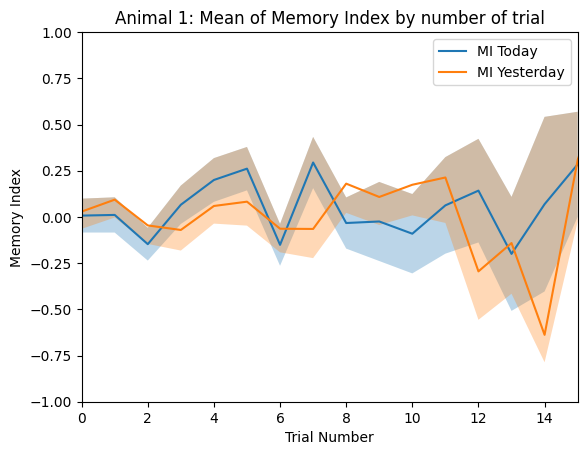

In [ ]:
y = [np.nanmean(MItrl[:, trial]) for trial in range(max_length_nested_arrays)]
sem_result = [sem(MItrl[:, trial], nan_policy='omit') for trial in range(max_length_nested_arrays)]
ylag = [np.nanmean(MItrl_lags[:, trial]) for trial in range(max_length_nested_arrays)]
sem_result_lag = [sem(MItrl_lags[:, trial], nan_policy='omit') for trial in range(max_length_nested_arrays)]
plt.plot(y, label='MI Today')
plt.plot(ylag, label='MI Yesterday')
plt.fill_between(range(max_length_nested_arrays), np.subtract(y, sem_result), np.add(y, sem_result), alpha=0.3)
plt.fill_between(range(max_length_nested_arrays), np.subtract(ylag, sem_result_lag), np.add(y, sem_result), alpha=0.3)
plt.ylim(-1,1)
plt.xlim(0,15)
plt.xlabel('Trial Number')
plt.ylabel('Memory Index')
plt.title('Animal 1: Mean of Memory Index by number of trial')
plt.legend()

 ANIMAL 1: Session by session and Trial by trial

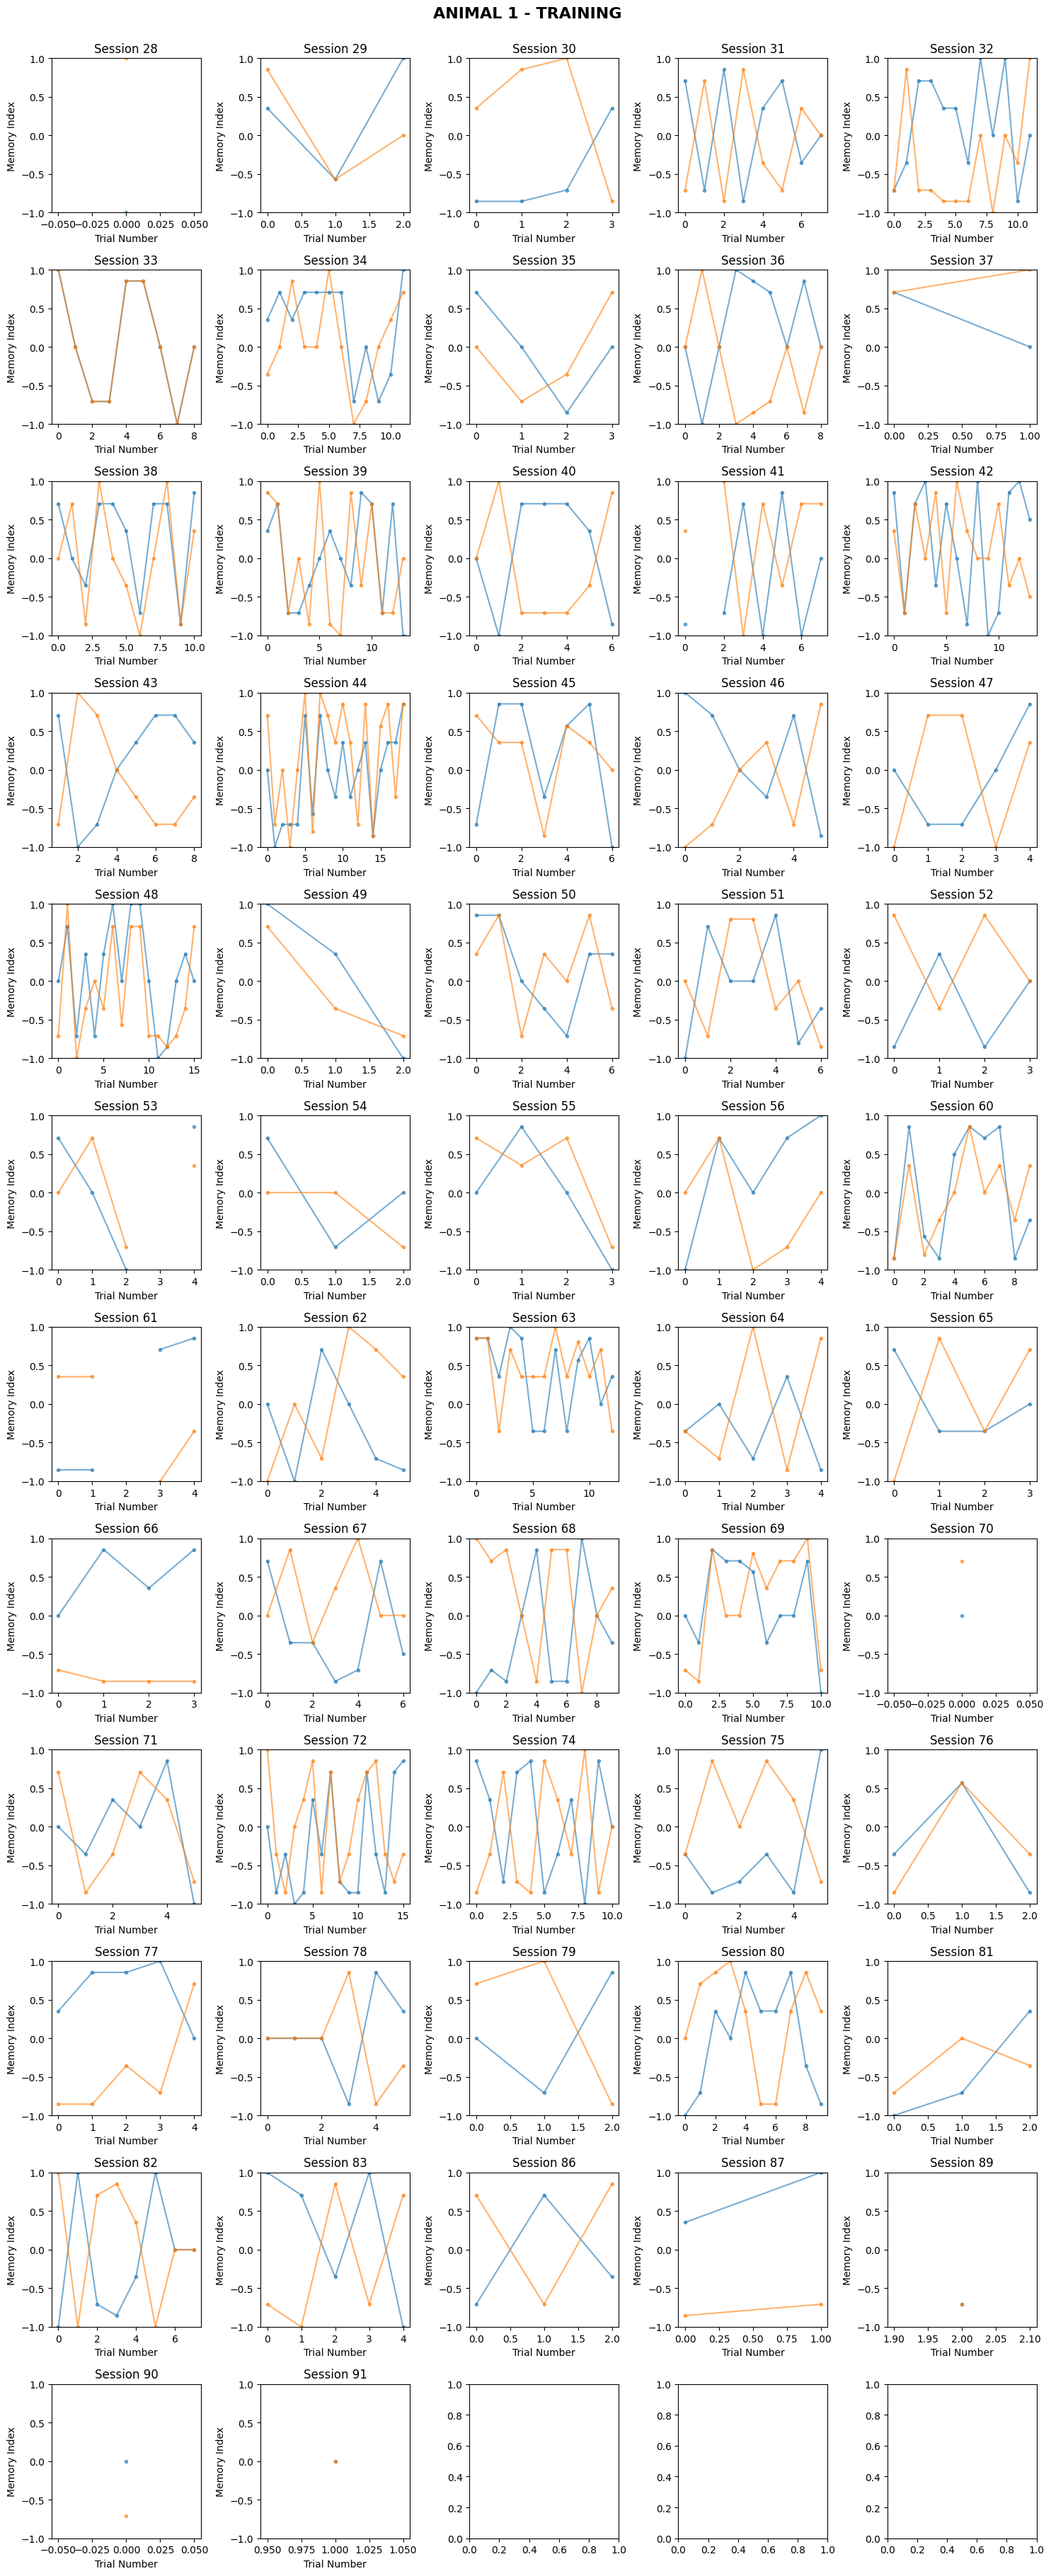

In [ ]:
## PLOTTING BY SESSION
num_columns = 5
n = len(MItrl) // num_columns

# Find the indices of non-empty subplots
non_empty_indices = [i for i in range(len(MItrl)) if not np.isnan(MItrl[i]).all()]

# Calculate the new number of rows based on non-empty subplots
n_rows = len(non_empty_indices) // num_columns + int(len(non_empty_indices) % num_columns != 0)

# Create a figure and an array of subplots
fig, axs = plt.subplots(n_rows, num_columns, figsize=(15, 3 * n_rows))

for i, idx in enumerate(non_empty_indices):
    row_idx, col_idx = divmod(i, num_columns)
    axs[row_idx, col_idx].plot(MItrl[idx], '.-', alpha=0.6, label='Todays Port')
    axs[row_idx, col_idx].plot(MItrl_lags[idx], '.-' , alpha=0.6, label='Yesterdays Port')
    axs[row_idx, col_idx].set_title(f'Session {idx + 1}')
    axs[row_idx, col_idx].set_ylim(-1, 1)
    axs[row_idx, col_idx].set_ylabel('Memory Index')
    axs[row_idx, col_idx].set_xlabel('Trial Number')

# Adjust layout to prevent clipping of titles
fig.tight_layout()
fig.suptitle('ANIMAL 1 - TRAINING', x=0.5, y=1.01, fontweight='bold', fontsize=16)

# Show the figure
plt.show()


ANIMAL 1: Session by session and mean of 2 trials

<ipython-input-208-f4f2638044a5>:17: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot((np.nanmean(sliding_window(MItrl[idx], 2),axis=1)), '.-' ,alpha=0.6 ,label='Todays Port')
<ipython-input-208-f4f2638044a5>:18: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot((np.nanmean(sliding_window(MItrl_lags[idx], 2),axis=1)), '.-' , alpha=0.5 ,label='Yesterdays Port')


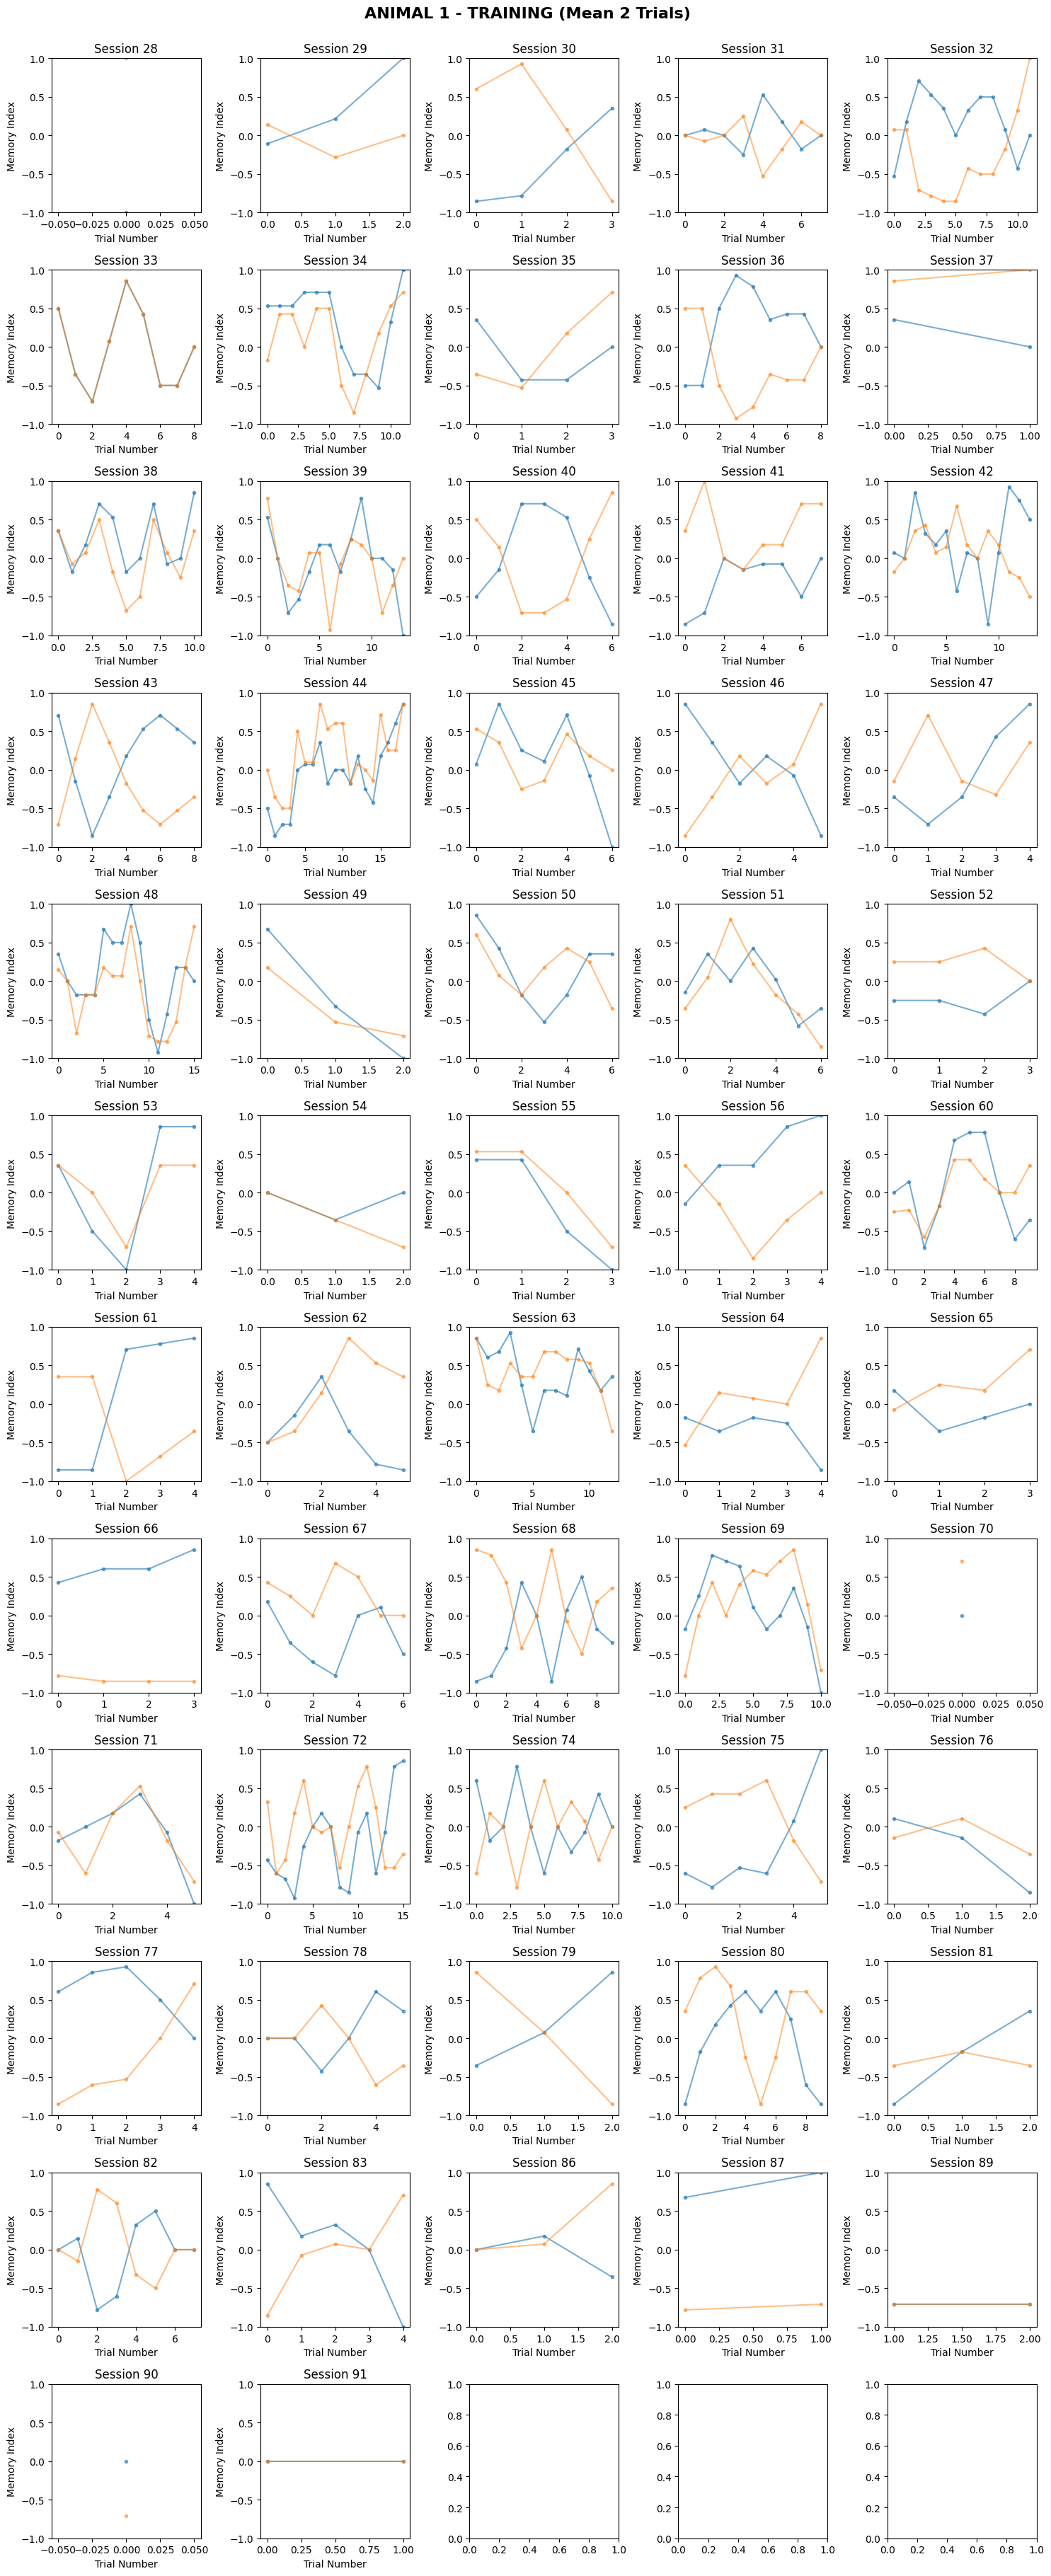

In [ ]:
## PLOTTING BY SESSION
num_columns = 5
n = len(MItrl) // num_columns

# Find the indices of non-empty subplots
non_empty_indices = [i for i in range(len(MItrl)) if not np.isnan(MItrl[i]).all()]

# Calculate the new number of rows based on non-empty subplots
n_rows = len(non_empty_indices) // num_columns + int(len(non_empty_indices) % num_columns != 0)

# Create a figure and an array of subplots
fig, axs = plt.subplots(n_rows, num_columns, figsize=(15, 3 * n_rows))

for i, idx in enumerate(non_empty_indices):
    row_idx, col_idx = divmod(i, num_columns)
    axs[row_idx, col_idx].plot((np.nanmean(sliding_window(MItrl[idx], 2),axis=1)), '.-' ,alpha=0.6 ,label='Todays Port')
    axs[row_idx, col_idx].plot((np.nanmean(sliding_window(MItrl_lags[idx], 2),axis=1)), '.-' , alpha=0.5 ,label='Yesterdays Port')
    axs[row_idx, col_idx].set_title(f'Session {idx + 1}')
    axs[row_idx, col_idx].set_ylim(-1, 1)
    axs[row_idx, col_idx].set_ylabel('Memory Index')
    axs[row_idx, col_idx].set_xlabel('Trial Number')

# Adjust layout to prevent clipping of titles
fig.tight_layout()
fig.suptitle('ANIMAL 1 - TRAINING (Mean 2 Trials)', x=0.5, y=1.01, fontweight='bold', fontsize=16)

# Show the figure
plt.show()

 ANIMAL 1: Session by session and mean of 3 trials

<ipython-input-210-4a376ca252be>:16: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot((np.nanmean(sliding_window(MItrl[idx], 3),axis=1)), '.-' ,alpha=0.6 ,label='Todays Port')
<ipython-input-210-4a376ca252be>:17: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot((np.nanmean(sliding_window(MItrl_lags[idx], 3),axis=1)), '.-' , alpha=0.5 ,label='Yesterdays Port')


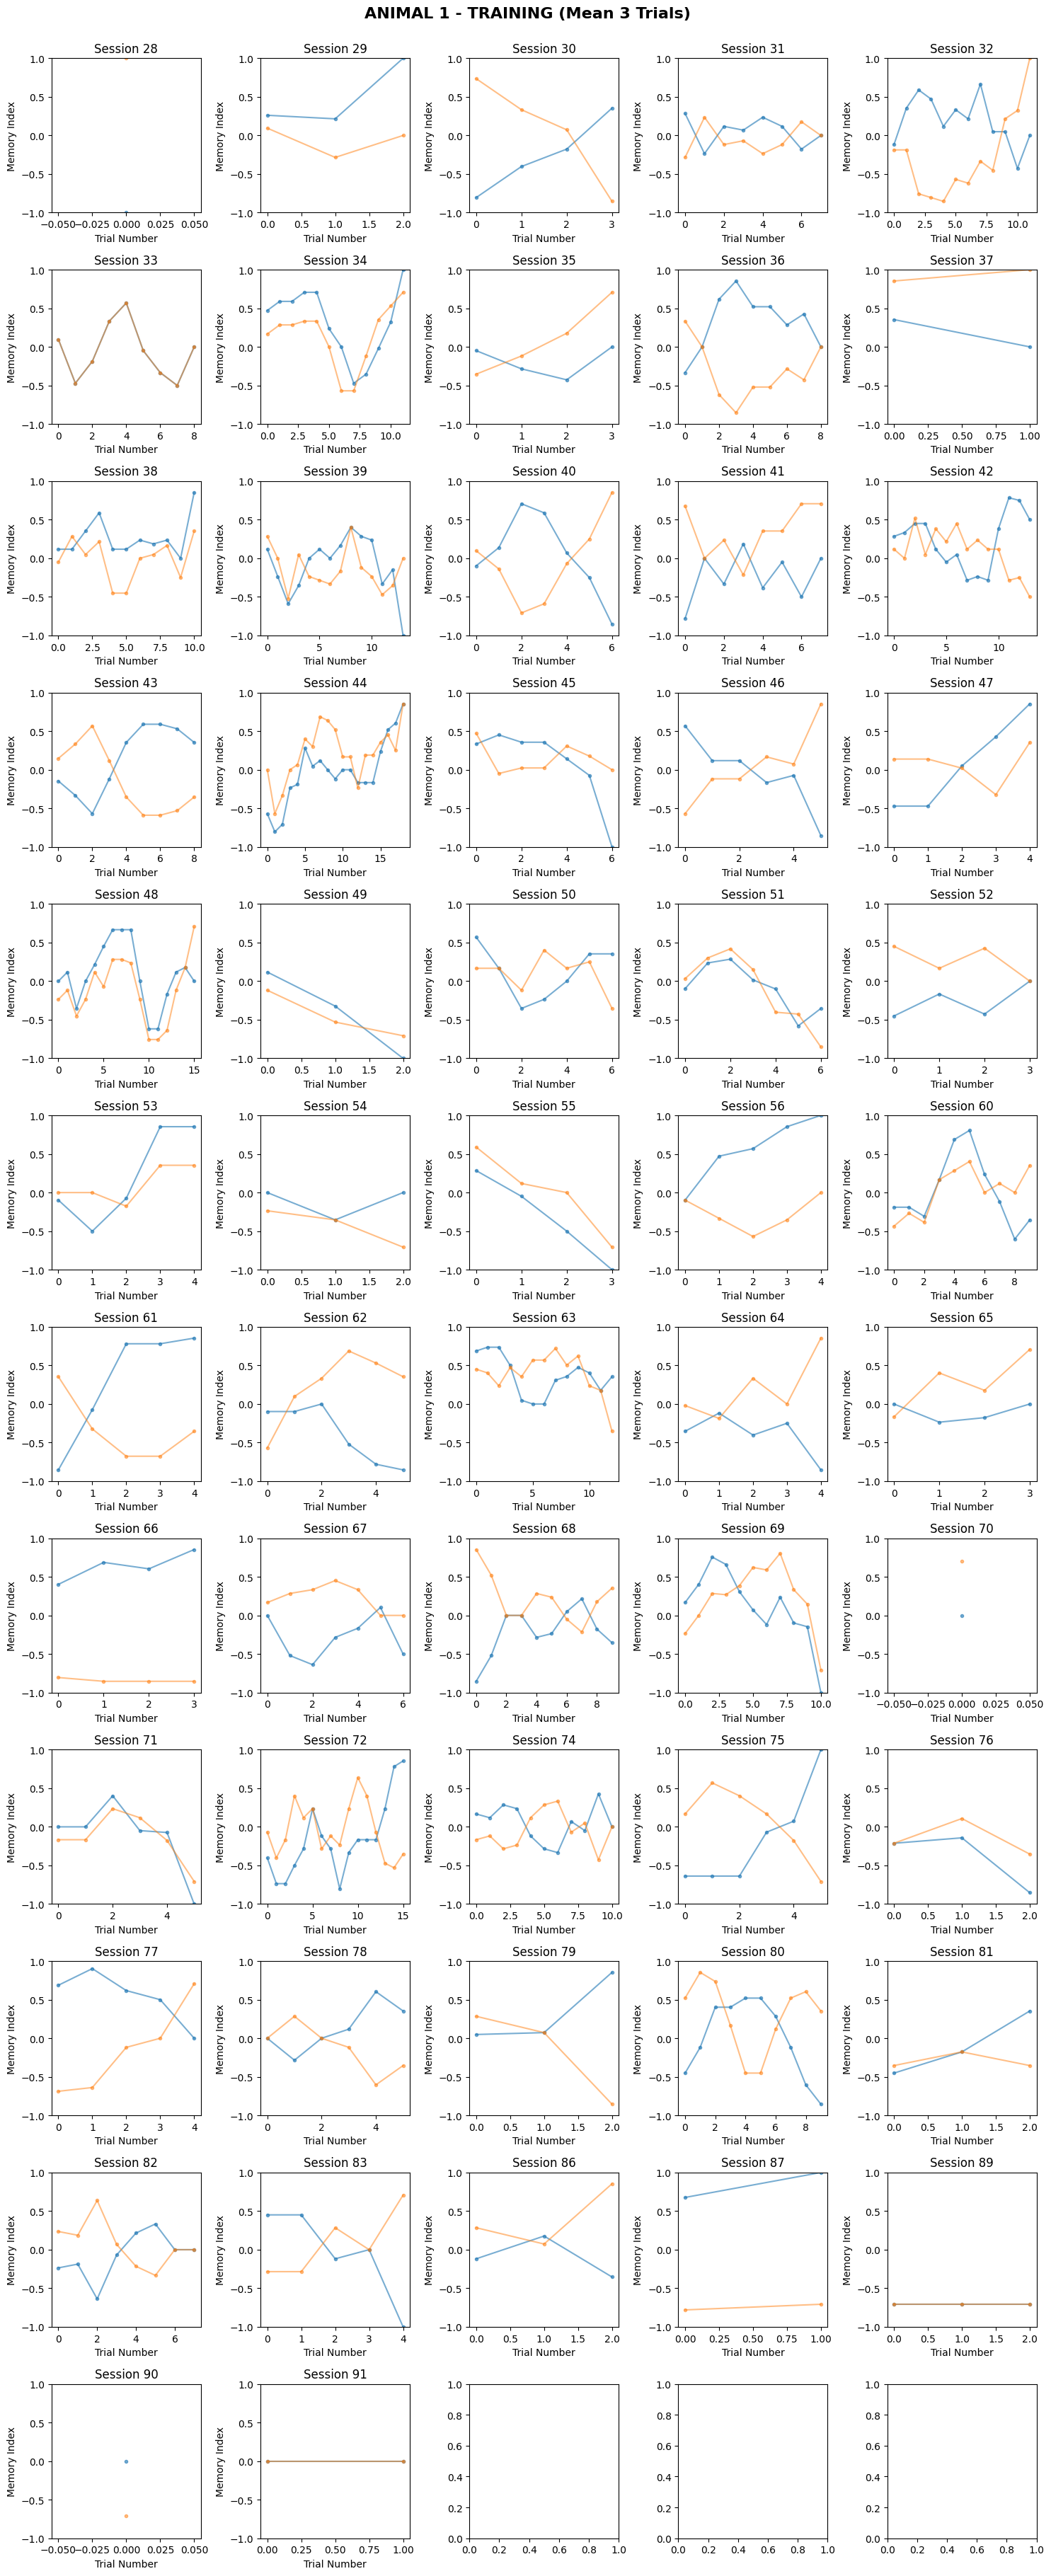

In [ ]:
## PLOTTING BY SESSION
num_columns = 5
n = len(MItrl) // num_columns

# Find the indices of non-empty subplots
non_empty_indices = [i for i in range(len(MItrl)) if not np.isnan(MItrl[i]).all()]

# Calculate the new number of rows based on non-empty subplots
n_rows = len(non_empty_indices) // num_columns + int(len(non_empty_indices) % num_columns != 0)

# Create a figure and an array of subplots
fig, axs = plt.subplots(n_rows, num_columns, figsize=(15, 3 * n_rows))

for i, idx in enumerate(non_empty_indices):
    row_idx, col_idx = divmod(i, num_columns)
    axs[row_idx, col_idx].plot((np.nanmean(sliding_window(MItrl[idx], 3),axis=1)), '.-' ,alpha=0.6 ,label='Todays Port')
    axs[row_idx, col_idx].plot((np.nanmean(sliding_window(MItrl_lags[idx], 3),axis=1)), '.-' , alpha=0.5 ,label='Yesterdays Port')
    axs[row_idx, col_idx].set_title(f'Session {idx + 1}')
    axs[row_idx, col_idx].set_ylim(-1, 1)
    axs[row_idx, col_idx].set_ylabel('Memory Index')
    axs[row_idx, col_idx].set_xlabel('Trial Number')

# Adjust layout to prevent clipping of titles
fig.tight_layout()
fig.suptitle('ANIMAL 1 - TRAINING (Mean 3 Trials)', x=0.5, y=1.01, fontweight='bold', fontsize=16)

# Show the figure
plt.show()

# ALL ANIMALS

In [ ]:
# ADJUSTING THE ARRAYS TO CREATE MATRIX
AngRad_dict = {1: np.pi/4, 2: 0, 3: -np.pi/4, 4: -np.pi/2, 5: -3*np.pi/4, 6: np.pi, 7: 3*np.pi/4, 8: np.pi/2}
cosAng = np.cos([np.pi/4, 0, -np.pi/4, -np.pi/2, -3/4*np.pi, np.pi, 3/4*np.pi, np.pi/2])
ALL_portsPoked_3D_arr=np.array(ALL_portsPoked)
port_seq=np.array(ALL_PORTS)
max_length_nested_arrays=np.shape(ALL_portsPoked_3D_arr)[2]
# HIST SEQUENCE
hist_all=[]
for aa in range(len(ALL_portsPoked_3D_arr)):
  hist_anim=[]
  for s, sess in enumerate(ALL_portsPoked_3D_arr [aa]):
      hist_sess=[]
      for trl in range(max_length_nested_arrays):
        if np.shape(ALL_portsPoked_3D_arr [aa,s,trl])==() or np.shape(ALL_portsPoked_3D_arr [aa,s,trl])==(0,):
          hist_sess.append(np.array([0 for _ in range(8)]))
        else:
          filtered_pokes = np.array(np.hstack(ALL_portsPoked_3D_arr[aa,s,trl]).tolist())
          port_counts = Counter(filtered_pokes)
          hist_sess.append(np.array([port_counts[port] for port in AngRad_dict]))
      hist_anim.append(hist_sess)
  hist_all.append(np.array(hist_anim))

hist_all_arr=np.array(hist_all)


# hist=np.nansum(hist_all_arr, axis=2)


New_port_seq=[[port_seq[aa][ss] if not (np.sum(hist_all_arr[aa][ss])==0 ) else 0 for ss in range(len(port_seq[aa])) ]for aa in range(len(port_seq))]
New_port_seq_arr=np.array(New_port_seq)

# ## Creating collapsed datasets
NON_0_port_seq=[New_port_seq_arr[aa][New_port_seq_arr[aa]!=0] for aa in range(len(port_seq))]
NON_0_hist_seq=[hist_all_arr[aa][New_port_seq_arr[aa]!=0] for aa in range(len(port_seq))]
NON_0_FirstTrlWWater=[ALL_FirstTrlWWater[aa][New_port_seq_arr[aa]!=0] for aa in range(len(port_seq))]
NON_0_FirstTrlWaterAvai=[ALL_FirstTrlWaterAvai[aa][New_port_seq_arr[aa]!=0] for aa in range(len(port_seq))]
NON_0_CorrectTrials_afterW=[ALL_CorrectTrials_afterW[aa][New_port_seq_arr[aa]!=0] for aa in range(len(port_seq))]
NON_0_Cues_afterW=[ALL_Cues_afterW[aa][New_port_seq_arr[aa]!=0] for aa in range(len(port_seq))]

# # MEMORY INDEX
MIs = [[[np.nan if NON_0_port_seq[aa][ss] == 0 or np.nansum(NON_0_hist_seq[aa][ss][trl])==0 else MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss]) for
        trl in range(len(NON_0_hist_seq[aa][ss]))] for ss in range(len(NON_0_hist_seq[aa]))] for aa in range(len(NON_0_hist_seq))]
# MItrl=np.array(MIs)

MIs_lag = [[[np.nan if ss == 0 or NON_0_port_seq[aa][ss] == 0  or np.nansum(NON_0_hist_seq[aa][ss][trl])==0 or np.nansum(NON_0_hist_seq[aa][ss-1][trl])==0 else
             MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss-1]) for trl in range(len(NON_0_hist_seq[aa][ss]))]
            for ss in range(len(NON_0_hist_seq[aa]))] for aa in range(len(NON_0_hist_seq))]

# MItrl_lags=np.array(MIs_lag)

In [ ]:
# perfAfterW=[]
# for aa in range(len(NON_0_Cues_afterW)):
#    perf_sess=[]
#    for sess in range(len(NON_0_Cues_afterW[aa])):
#     perf_sess.append(np.array((len(NON_0_CorrectTrials_afterW[aa][sess].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][sess].astype(float))][~np.isnan(NON_0_CorrectTrials_afterW[aa][sess].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][sess].astype(float))])])/len(NON_0_Cues_afterW[aa][sess].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][sess].astype(float))]))*100))
#    perfAfterW.append(np.array(perf_sess))
# # perfAfterW=[[(len(NON_0_CorrectTrials_afterW[aa][sess].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][sess].astype(float))][~np.isnan(NON_0_CorrectTrials_afterW[aa][sess].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][sess].astype(float))])])/len(NON_0_Cues_afterW[aa][sess].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][sess].astype(float))]))*100 ] if len(NON_0_Cues_afterW[aa])>0 else np.nan for sess in range(len(NON_0_Cues_afterW[aa])) for aa in range(len(NON_0_Cues_afterW))]

## Surrogates

In [ ]:
# Nshuffles=5
# MI_shufftrn2=[]
# for n in range(Nshuffles):
#   MI_surr=[surrogates(NON_0_hist_seq, NON_0_port_seq, trl) for trl in range(len(NON_0_hist_seq[0][0]))]
#   MI_shufftrn2.append(np.array(MI_surr))

# MIShuffTrn2=np.array(MI_shufftrn2)

# folder = "/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/"
# file_name = "Shuffle_trn.csv"
# np.savetxt(folder + file_name, MIShuffTrn2, delimiter=",")

<ipython-input-15-82a22524b9c9>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_hist=np.array([[hist_seq[aa][ss][trl] for ss in range(len(hist_seq[aa]))] for aa in range(len(hist_seq))])
<ipython-input-9-0b74b0aa8a09>:7: RuntimeWarning: invalid value encountered in divide
  Projected_hist_seq_norm = hist_seq / np.nansum(hist_seq)


In [ ]:
# ruta_archivo = "/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_trn.csv"
# data = np.loadtxt(ruta_archivo, delimiter=",") # Read the CSV with np.loadtxt
# # data = np.genfromtxt(ruta_archivo, delimiter=",") # Read the CSV with np.genfromtxt if the data is fragmented
# np.shape(data)

(500, 50)

In [ ]:
# MI_Shuff=np.array(MI_shuff)

# CI95=np.array([np.percentile(MIShuffTrn[trl], [0.95, 0.05]) for trl in range(np.shape(MIShuffTrn)[1])])
# revCI95=np.roll(CI95, len(CI95), axis=0)[::-1]
# CI99=np.array([np.percentile(MIShuffTrn[trl], [0.99, 0.01]) for trl in range(np.shape(MIShuffTrn)[1])])
# revCI99=np.roll(CI99, len(CI99), axis=0)[::-1]

In [ ]:
# surrogates(NON_0_hist_seq, NON_0_port_seq, 0)

# Regular Memory Index - All sessions all animals

Memory Index Today:  -0.19771282130760295 Memory Index Yesterday:  0.07543357678564855


<ipython-input-15-a8d4b67579b3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(labels2)


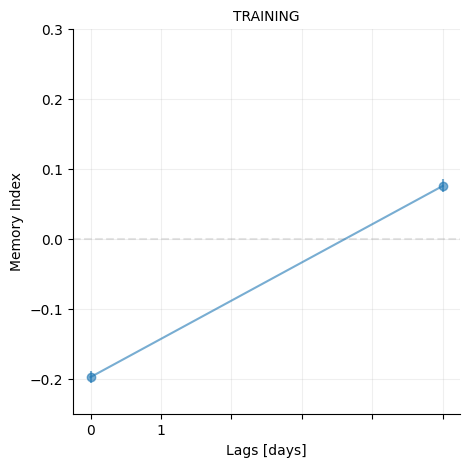

In [ ]:
hist=np.nansum(hist_all_arr, axis=2)

New_port_seq=[[port_seq[aa][ss] if not (np.sum(hist_all_arr[aa][ss])==0 ) else 0 for ss in range(len(port_seq[aa])) ]for aa in range(len(port_seq))]
New_port_seq_arr=np.array(New_port_seq)

# ## Creating collapsed datasets
NON_0_port_seq=[New_port_seq_arr[aa][New_port_seq_arr[aa]!=0] for aa in range(len(port_seq))]
NON_0_hist_seq=[hist[aa][New_port_seq_arr[aa]!=0] for aa in range(len(port_seq))]


MIs=np.nanmean(np.concatenate([MemoryIndex(NON_0_hist_seq[aa], NON_0_port_seq[aa]) for aa in range(len(NON_0_hist_seq))]))
MIs_std=np.nanstd(np.concatenate([MemoryIndex(NON_0_hist_seq[aa], NON_0_port_seq[aa]) for aa in range(len(NON_0_hist_seq))]))
MIs_sem=MIs_std/np.sqrt(len(~np.isnan(np.concatenate([MemoryIndex(NON_0_hist_seq[aa], NON_0_port_seq[aa]) for aa in range(len(NON_0_hist_seq))]))))
MIsLag=np.nanmean(np.concatenate([MemoryIndexLag(NON_0_hist_seq[aa], NON_0_port_seq[aa]) for aa in range(len(NON_0_hist_seq))]))
MIsLag_std=np.nanstd(np.concatenate([MemoryIndexLag(NON_0_hist_seq[aa], NON_0_port_seq[aa]) for aa in range(len(NON_0_hist_seq))]))
MIsLag_sem=MIsLag_std/np.sqrt(len(~np.isnan(np.concatenate([MemoryIndexLag(NON_0_hist_seq[aa], NON_0_port_seq[aa]) for aa in range(len(NON_0_hist_seq))]))))

print('Memory Index Today: ', MIs,'Memory Index Yesterday: ',MIsLag )

##Plot it to have a reference
fig, axs = plt.subplots(figsize=(5, 5))
plt.errorbar([0,1],[MIs, MIsLag],yerr=[MIs_sem,MIsLag_sem ], fmt='o-' , alpha=0.6, label='CONTROL')
plt.axhline(0,linestyle='--' ,color='grey', alpha=0.2)
plt.ylim(-.25, .3)
plt.ylabel('Memory Index')
plt.xlabel('Lags [days]')
# axs[0].set_xticklabels(np.array([-.1, 0, 0.1]))
plt.grid(True, alpha=0.2)
# Create a sample plot
ax = plt.gca()
ticks = axs.get_xticks()  # Obtain the x-axis labels positions
labels = axs.get_xticklabels()  # Obtain the x-axis labels
labels2=np.arange(-1, 2, 1).astype(int)  # change the labels of the x-axis
axs.set_xticklabels(labels2)
# Show the plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_aspect('equal')
plt.title('TRAINING', fontsize=10)
plt.show()


In [ ]:
## CHECKING WHETHER PABLO HAD THE SAME DATASET

# import mat73
# hist_mat=mat73.loadmat('/content/gdrive/MyDrive/Data8port/before/HistCountAllSess.mat')
# hist_all_mat=hist_mat['HistPokesOnToneCONTROL']
# hist_mat=np.nansum(hist_all_mat, axis=0)
# hist_all_mat_=hist_all_mat.T[hist_mat != 0]
# # hist_mat=np.nansum(hist_all_mat_.T, axis=0)
# np.shape(hist_all_mat_)
# final_hist_mat=np.nansum(hist_all_mat_, axis=1)
# np.shape(final_hist_mat)


# histAll_P=np.nansum(hist_all_arr, axis=2)
# histAll_P_=np.nansum(histAll_P, axis=2)
# np.shape(histAll_P_)
# Hist_non_zero_all=np.concatenate([histAll_P_[i][histAll_P_[i] != 0] for i in range(np.shape(histAll_P_)[0])])
# len(Hist_non_zero_all)
# # np.shape(histAll_P_)


# fig, axs = plt.subplots(1,3, figsize=(10, 5) )#,  gridspec_kw={'height_ratios': [1, 2]})
# axs[0].bar(['Paula', 'Pablo'],[len(Hist_non_zero_all),len(final_hist_mat)], alpha=0.4, color=['tab:orange', 'tab:blue'])
# axs[0].set_title('Number of sessions')
# axs[1].plot(final_hist_mat[0:20], alpha=0.6,label='Pablos Data')
# axs[1].plot(Hist_non_zero_all[0:20],alpha=0.6 , label='Paulas Data')
# axs[1].set_title('Comparison Pablo vs Paula')
# axs[1].legend()
# axs[1].grid(True)
# axs[2].plot(final_hist_mat, alpha=0.6,label='Pablos Data')
# axs[2].plot(Hist_non_zero_all,alpha=0.6 , label='Paulas Data')
# axs[2].set_title('Comparison Pablo vs Paula')
# axs[2].legend()
# axs[2].grid(True)

# Memory Index by trial:All sessions
- Aligned towards the 1st water drop
- Aligned form 1st trial on

In [ ]:
# n_trials=[]
# for i in range(np.shape(MItrl_list)[1]):
#   x=np.array(MItrl_list)[:,i]
#   n_trials.append(len(x[~np.isnan(x)]))
# x=np.array([t if trial>40 else np.nan for t,trial in enumerate(n_trials)])
# # n_trials[x[-1]]
# x

Importing shuffles calculated before:

In [ ]:
# Número de animales y sesiones
num_anim= MItrl.shape[0]
lengthsMI=[len(MItrl[aa]) for aa in range(len(MItrl))]

## creating new array
MItrl_ =np.full((len(MItrl), max(lengthsMI), 50), np.nan)
# loop over animal and session
for aa in range(num_anim):
    for sess in range(1,lengthsMI[aa]):
        # Find the last index of the last 'real value' not a NaN if not use 0
        indexes_no_nan = np.where(~np.isnan(np.array(MItrl[aa][sess]).astype(float)))[0]
        last_index_no_nan = indexes_no_nan[-1] if indexes_no_nan.size > 0 else 0

        # apply np.roll to align the last non-NaN value as the last value of the array
        MItrl_[aa, sess] = np.roll(np.array(MItrl[aa][sess]), -last_index_no_nan-1)



num_anim= MItrl_lags.shape[0]
lengthsMI=[len(MItrl_lags[aa]) for aa in range(len(MItrl_lags))]
#  Create a new array to store the results
MItrl_lags_ = np.full((len(MItrl_lags), max(lengthsMI), 50), np.nan)

# loop over animal and session
for aa in range(num_anim):
    for sess in range(lengthsMI[aa]):
        # Find the last index of the last 'real value' not a NaN if not use 0
        indexes_no_nan = np.where(~np.isnan(np.array(MItrl_lags[aa][sess]).astype(float)))[0]
        last_index_no_nan = indexes_no_nan[-1] if indexes_no_nan.size > 0 else 0

        # apply np.roll to align the last non-NaN value as the last value of the array
        MItrl_lags_[aa, sess] = np.roll(MItrl_lags[aa][sess], -last_index_no_nan-1)

MItrl_list = MItrl_.reshape(-1, MItrl_.shape[2]).tolist()
MItrl_lags_list = MItrl_lags_.reshape(-1, MItrl_lags_.shape[2]).tolist()

### COMPUTING THE 95 AND 5 PERCENTILES
MItrl_arr=np.array(MItrl_list)
MItrl_arr_non_nan=[MItrl_arr[:,trl][~np.isnan(MItrl_arr[:,trl])] for trl in range(np.shape(MItrl_arr)[1])]
confidence_interval =[np.array([np.nan, np.nan]) if np.size(MItrl_arr_non_nan[trl])==0 else np.percentile(MItrl_arr_non_nan[trl], [0.95, 0.05]) for trl in range(np.shape(MItrl_arr)[1])]
arr_confidence=np.array(confidence_interval)

MItrl_lags_arr=np.array(MItrl_lags_list)
MItrl_lags_non_nan=[MItrl_lags_arr[:,trl][~np.isnan(MItrl_lags_arr[:,trl])] for trl in range(np.shape(MItrl_lags_arr)[1])]
confidence_interval_lags =[np.array([np.nan, np.nan]) if np.size(MItrl_lags_non_nan[trl])==0 else np.percentile(MItrl_lags_non_nan[trl], [0.95, 0.05]) for trl in range(np.shape(MItrl_lags_arr)[1])]
arr_confidence_lags=np.array(confidence_interval_lags)

#Confidence_interval
# MIShuffTrn=np.array(MIShuffTrn)

CI95=np.array([np.percentile(MIShuffTrn[trl], [0.95, 0.05]) for trl in range(np.shape(MIShuffTrn)[1])])
revCI95=np.roll(CI95, len(CI95), axis=0)[::-1]
CI99=np.array([np.percentile(MIShuffTrn[trl], [0.99, 0.01]) for trl in range(np.shape(MIShuffTrn)[1])])
revCI99=np.roll(CI99, len(CI99), axis=0)[::-1]
## Number of trials
n_trials=[]
for i in range(np.shape(MItrl_list)[1]):
  x=np.array(MItrl_list)[:,i]
  n_trials.append(len(x[~np.isnan(x)]))
x=np.array([t if trial>40 else np.nan for t,trial in enumerate(n_trials)])

## PLOTTING BY SESSION
# Create a figure and an array of subplots
fig, axs = plt.subplots(2,1, figsize=(7.5, 5),  gridspec_kw={'height_ratios': [1, 2]})

indexes = np.arange(len(MItrl[0][0]))
## SEM computation
sem_MItrl_list = np.nanstd(MItrl_list, axis=0) / np.sqrt(np.sum(~np.isnan(MItrl_list), axis=0))
sem_MItrl_lags_list =  np.nanstd(MItrl_lags_list, axis=0) / np.sqrt(np.sum(~np.isnan(MItrl_lags_list), axis=0))

#plot
axs[0].bar(indexes, n_trials, color='grey', alpha=0.2, label='Number of trials')
axs[0].set_xticklabels(-np.array([60,50,40,30, 20, 10, 0]))
axs[0].axvline(x[~np.isnan(x)].astype(int)[0], color='red',  alpha=0.3, linestyle='--')
axs[0].annotate('# samples<40', xy=(12, 1500), color='red', alpha=0.5)
axs[0].set_ylabel('# Samples', fontweight='bold')
axs[0].legend(loc='upper center', bbox_to_anchor=(1.15, .9), fancybox=True, shadow=True,  fontsize=9)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_linestyle('dashed')
axs[0].spines['top'].set_visible(False)


axs[1].fill_between(indexes, np.nanmean(MIShuffTrn, axis=0)+revCI99[:,0], np.nanmean(MIShuffTrn, axis=0)-revCI99[:,1],color='grey' , alpha=0.3 ,label='Mean Surrogates')
axs[1].errorbar(indexes, np.nanmean(MItrl_list, axis=0), yerr=sem_MItrl_list, fmt='.-', alpha=0.6 ,label='Todays Port')
axs[1].errorbar(indexes, np.nanmean(MItrl_lags_list, axis=0), yerr=sem_MItrl_lags_list, fmt='.-', alpha=0.6 ,label='Yesterdays Port')
# axs[1].fill_between(indexes,np.nanmean(MItrl_list, axis=0)+arr_confidence[:,0],  np.nanmean(MItrl_list, axis=0)-arr_confidence[:,1],  color='tab:blue', alpha=0.2)
# axs[1].fill_between(indexes,np.nanmean(MItrl_lags_list, axis=0)+arr_confidence_lags[:,0],  np.nanmean(MItrl_lags_list, axis=0)-arr_confidence_lags[:,1],  color='orange', alpha=0.2, label='YesterdaysPort')
# axs[1].fill_between(indexes,np.nanmean(MItrl_list, axis=0)-np.nanstd(MItrl_list, axis=0),  np.nanmean(MItrl_list, axis=0)+np.nanstd(MItrl_list, axis=0),  color='tab:blue', alpha=0.2)
# axs[1].fill_between(indexes,np.nanmean(MItrl_lags_list, axis=0)-np.nanstd(MItrl_lags_list, axis=0),  np.nanmean(MItrl_lags_list, axis=0)+np.nanstd(MItrl_lags_list, axis=0),  color='orange', alpha=0.2, label='YesterdaysPort')
axs[1].axvline(indexes[-1]+1, color='tab:blue', alpha=0.2)
# fig.text(0.67,0.515,emoji.emojize(':droplet:'), fontsize=8, ha='center', va='center')
fig.text(0.675,0.515,'💧Water Starts', color='tab:blue', alpha=0.5, fontsize=8)
axs[1].axvline(x[~np.isnan(x)].astype(int)[0], color='red',  alpha=0.3, linestyle='--')
axs[1].set_ylim(-1, 1)
axs[1].set_xticklabels(-np.array([60,50,40,30, 20, 10, 0]))
axs[1].set_ylabel('Memory Index', fontweight='bold')
axs[1].set_xlabel('Trial Number', fontweight='bold')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].legend(loc='upper center', bbox_to_anchor=(1.25, .9), fancybox=True, labels=['99CI-Surrogates','Water Starts','Threshold<40 samples', 'Mean MI Todays \nPort' ,'Mean MI Yesterdays \nPort'], fontsize=7.5)

fig.text( 0.85,0.20, f'MeanToday: {round(np.nanmean(MItrl_list),3)}', ha='center', va='center', fontsize=9)#, bbox=dict(facecolor='tab:blue', alpha=0.1))
fig.text( 0.85,0.15, f'MeanYesterday: {round(np.nanmean(MItrl_lags_list),3)}', ha='center', va='center', fontsize=9)#, bbox=dict(facecolor='tab:orange', alpha=0.1))
# Adjust layout to prevent clipping of titles
fig.suptitle('Mean over trial \naligned towards 1st water drop   \nTRAINING', x=0.55, y=1.0001, fontweight='bold', fontsize=10)
fig.tight_layout()
# Show the figure
plt.show()

NameError: name 'MItrl' is not defined

In [ ]:
# import matplotlib.font_manager as fm

# # Obtener la lista de fuentes disponibles
# font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

# # Mostrar las primeras 10 fuentes de la lista
# for i, font_path in enumerate(font_list[:10]):
#     font = fm.FontProperties(fname=font_path)
#     print(f"{i + 1}. {font.get_name()} ({font_path})")


# emoji.emojize(':droplet:', fontstyle=)

<ipython-input-87-84393697140a>:55: RuntimeWarning: Mean of empty slice
  axs[1].errorbar(indexes, np.nanmean(MItrlList, axis=0), yerr=sem_MItrl_list, fmt='.-', alpha=0.6 ,label='Todays Port')
<ipython-input-87-84393697140a>:56: RuntimeWarning: Mean of empty slice
  axs[1].errorbar(indexes, np.nanmean(MItrlLagsList, axis=0), yerr=sem_MItrl_lags_list, fmt='.-', alpha=0.6 ,label='Yesterdays Port')


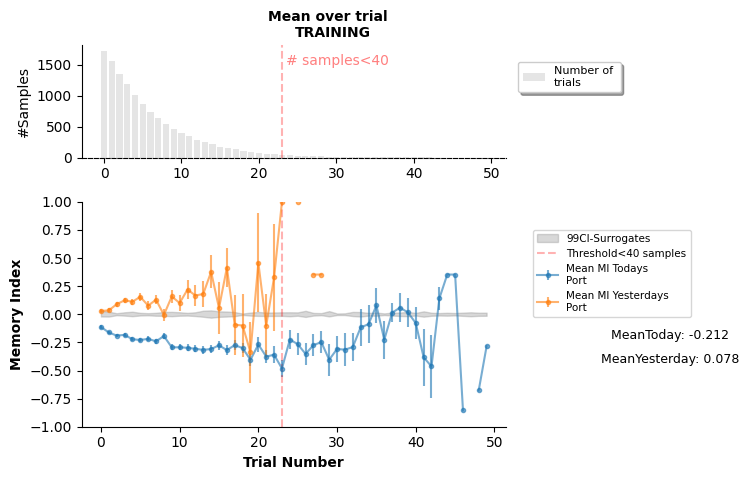

In [ ]:
## PLOTTING BY SESSION
# Create a figure and an array of subplots
fig, axs = plt.subplots(2,1, figsize=(7.5, 5),  gridspec_kw={'height_ratios': [1, 2]})

#Reshape
MItrlList=np.concatenate(MItrl)
MItrlLagsList =np.concatenate(MItrl_lags)
# MItrlList = MItrl.reshape(-1, MItrl.shape[2]).tolist()
# MItrlLagsList = MItrl_lags.reshape(-1, MItrl_lags.shape[2]).tolist()
#SEM
sem_MItrl_list = np.nanstd(MItrlList, axis=0) / np.sqrt(np.sum(~np.isnan(MItrlList), axis=0))
sem_MItrl_lags_list =  np.nanstd(MItrlLagsList, axis=0) / np.sqrt(np.sum(~np.isnan(MItrlLagsList), axis=0))

## Number of trials
n_trials=[]
for i in range(np.shape(MItrlList)[1]):
  x=np.array(MItrlList)[:,i]
  n_trials.append(len(x[~np.isnan(x)]))
x=np.array([t if trial>40 else np.nan for t,trial in enumerate(n_trials)])


### COMPUTING THE 95 AND 5 PERCENTILES
MItrlList_arr=np.array(MItrlList)
MItrlList_arr_non_nan=[MItrlList_arr[:,trl][~np.isnan(MItrlList_arr[:,trl])] for trl in range(np.shape(MItrlList_arr)[1])]
confidence_interval_MI =[np.array([np.nan, np.nan]) if np.size(MItrlList_arr_non_nan[trl])==0 else np.percentile(MItrlList_arr_non_nan[trl], [0.95, 0.05])
                              for trl in range(np.shape(MItrlList_arr)[1])]
arr_confidence_MI=np.array(confidence_interval_MI)

MItrlLagsList_arr=np.array(MItrlLagsList)
MItrlLagsList_non_nan=[MItrlLagsList_arr[:,trl][~np.isnan(MItrlLagsList_arr[:,trl])] for trl in range(np.shape(MItrlLagsList_arr)[1])]
confidence_interval_Lags =[np.array([np.nan, np.nan]) if np.size(MItrlLagsList_non_nan[trl])==0 else np.percentile(MItrlLagsList_non_nan[trl], [0.95, 0.05])
                                         for trl in range(np.shape(MItrlLagsList_arr)[1])]
arr_confidence_Lags=np.array(confidence_interval_Lags)


CI95=np.array([np.percentile(MIShuffTrn[trl], [0.95, 0.05]) for trl in range(np.shape(MIShuffTrn)[1])])
revCI95=np.roll(CI95, len(CI95), axis=0)[::-1]
CI99=np.array([np.percentile(MIShuffTrn[trl], [0.99, 0.01]) for trl in range(np.shape(MIShuffTrn)[1])])
revCI99=np.roll(CI99, len(CI99), axis=0)[::-1]


#plot
axs[0].bar(indexes, n_trials, color='grey', alpha=0.2, label='Number of \ntrials')
# axs[0].set_xticklabels(-np.array([65,55,45,35, 25, 15, 5]))
axs[0].legend(loc='upper center', bbox_to_anchor=(1.15, .9), fancybox=True, shadow=True,  fontsize=8)
axs[0].axvline(x[~np.isnan(x)].astype(int)[-1], color='red',  alpha=0.3, linestyle='--')
axs[0].annotate('# samples<40', xy=(23.5, 1500), color='red', alpha=0.5)
axs[0].set_ylabel('#Samples')
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_linestyle('dashed')
axs[0].spines['top'].set_visible(False)


axs[1].fill_between(indexes, np.nanmean(MIShuffTrn, axis=0)+revCI99[:,0], np.nanmean(MIShuffTrn, axis=0)-revCI99[:,1],color='grey' , alpha=0.3 ,label='Mean Surrogates')
axs[1].errorbar(indexes, np.nanmean(MItrlList, axis=0), yerr=sem_MItrl_list, fmt='.-', alpha=0.6 ,label='Todays Port')
axs[1].errorbar(indexes, np.nanmean(MItrlLagsList, axis=0), yerr=sem_MItrl_lags_list, fmt='.-', alpha=0.6 ,label='Yesterdays Port')
# axs[1].fill_between(indexes,np.nanmean(MItrlList, axis=0)+arr_confidence_MI[:,0],np.nanmean(MItrlList, axis=0)-arr_confidence_MI[:,1], color='tab:blue', alpha=0.2 )
# axs[1].fill_between(indexes,np.nanmean(MItrlLagsList, axis=0)+arr_confidence_Lags[:,0], np.nanmean(MItrlLagsList, axis=0)-arr_confidence_Lags[:,1], color='orange', alpha=0.2 )

# axs[1].fill_between(indexes,np.nanmean(MItrlList, axis=0)-np.nanstd(MItrlList, axis=0),np.nanmean(MItrlList, axis=0)+np.nanstd(MItrlList, axis=0), color='tab:blue', alpha=0.2 )
# axs[1].fill_between(indexes,np.nanmean(MItrlLagsList, axis=0)-np.nanstd(MItrlLagsList, axis=0), np.nanmean(MItrlLagsList, axis=0)+np.nanstd(MItrlLagsList, axis=0), color='orange', alpha=0.2 )
# axs[1].axhline(0, color='grey', alpha=0.2)
axs[1].axvline(x[~np.isnan(x)].astype(int)[-1], color='red',  alpha=0.3, linestyle='--')
axs[1].set_ylim(-1,1 )
axs[1].set_ylabel('Memory Index', fontweight='bold')
axs[1].set_xlabel('Trial Number', fontweight='bold')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].legend(loc='upper center', bbox_to_anchor=(1.25, .9), fancybox=True, labels=['99CI-Surrogates','Threshold<40 samples', 'Mean MI Todays \nPort' ,'Mean MI Yesterdays \nPort'], fontsize=7.5)


fig.text( 0.9,0.30, f'MeanToday: {round(np.nanmean(MItrlList),3)}', ha='center', va='center', fontsize=9)#, bbox=dict(facecolor='tab:blue', alpha=0.1))
fig.text( 0.9,0.25, f'MeanYesterday: {round(np.nanmean(MItrlLagsList),3)}', ha='center', va='center', fontsize=9)#, bbox=dict(facecolor='tab:orange', alpha=0.1))

# Adjust layout to prevent clipping of titles
fig.suptitle('Mean over trial  \nTRAINING', x=0.45, y=0.95, fontweight='bold', fontsize=10)
fig.tight_layout()
# Show the figure
plt.show()

In [ ]:
## PLOTTING BY SESSION
# Create a figure and an array of subplots
fig, axs = plt.subplots( figsize=(5, 5))
axs.plot(np.nanmean(np.nanmean(np.nanmean(sliding_window(MItrl,3), axis=1),axis=1), axis=0), '.-' ,alpha=0.6 ,label='Todays Port')
axs.plot(np.nanmean(np.nanmean(np.nanmean(sliding_window(MItrl_lags,3), axis=1),axis=1), axis=0), '.-' ,alpha=0.6 ,label='Yesterdays Port')
axs.axhline(0, color='grey', alpha=0.2)
axs.set_ylim(-.75, .75)
axs.set_ylabel('Memory Index', fontweight='bold')
axs.set_xlabel('Trial Number', fontweight='bold')

fig.legend(loc='upper center', bbox_to_anchor=(1.15, .9), fancybox=True, shadow=True, labels=['Todays Port', 'Yesterdays Port'], fontsize=9)

# Adjust layout to prevent clipping of titles
fig.suptitle('Mean over sessions (mean of 3 trials)  \nTRAINING', x=0.55, y=1.0001, fontweight='bold', fontsize=10)
fig.tight_layout()
# Show the figure
plt.show()

# DISTANCE

In the next cell we compute the memory index based on the distance of yesterdays port with todays port (fix the function that is not working properly)

In [ ]:
def MemoryIndexbyDistanceTrl(distance):
  Ports_Seq_Rad=[[AngRad_dict[NON_0_port_seq[aa][ss]] for ss in range(len(NON_0_port_seq[aa])) ]for aa in range(len(NON_0_port_seq))]
  lengths_sess=max([len(NON_0_hist_seq[i]) for i in range(len(NON_0_hist_seq))])
  Nanimals=50

  MItrl=np.full((Nanimals,lengths_sess,56),np.nan)
  MItrl_lags=np.full((Nanimals,lengths_sess,56),np.nan)
  FirstTrlWaterAvai=np.full((Nanimals,lengths_sess), np.nan)
  FirstTrlWWater=np.full((Nanimals,lengths_sess), np.nan)

  for aa in range(len(NON_0_hist_seq)):
    for ss in range(len(NON_0_hist_seq[aa])):
      if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==distance or NON_0_port_seq[aa][ss] == 0:
          FirstTrlWaterAvai[aa,ss]=NON_0_FirstTrlWaterAvai[aa][ss]
          FirstTrlWWater[aa,ss]=NON_0_FirstTrlWWater[aa][ss]
          for trl in range(len(NON_0_hist_seq[aa][ss])):
            if np.nansum(NON_0_hist_seq[aa][ss][trl])==0:
              MItrl[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss])
              MItrl_lags[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss-1])

    return MItrl, MItrl_lags, FirstTrlWaterAvai, FirstTrlWWater



In [ ]:
Ports_Seq_Rad=[[AngRad_dict[NON_0_port_seq[aa][ss]] for ss in range(len(NON_0_port_seq[aa])) ]for aa in range(len(NON_0_port_seq))]
lengths_sess=max([len(NON_0_hist_seq[i]) for i in range(len(NON_0_hist_seq))])

MItrl_0=np.full((50,lengths_sess,56),np.nan)
MItrl_1=np.full((50,lengths_sess,56),np.nan)
MItrl_2=np.full((50,lengths_sess,56),np.nan)
MItrl_3=np.full((50,lengths_sess,56),np.nan)
MItrl_4=np.full((50,lengths_sess,56),np.nan)

MItrl_lags_0=np.full((50,lengths_sess,56),np.nan)
MItrl_lags_1=np.full((50,lengths_sess,56),np.nan)
MItrl_lags_2=np.full((50,lengths_sess,56),np.nan)
MItrl_lags_3=np.full((50,lengths_sess,56),np.nan)
MItrl_lags_4=np.full((50,lengths_sess,56),np.nan)

FirstTrlWaterAvai_0=np.full((50,lengths_sess),np.nan)
FirstTrlWaterAvai_1=np.full((50,lengths_sess),np.nan)
FirstTrlWaterAvai_2=np.full((50,lengths_sess),np.nan)
FirstTrlWaterAvai_3=np.full((50,lengths_sess),np.nan)
FirstTrlWaterAvai_4=np.full((50,lengths_sess),np.nan)

FirstTrlWWater_0=np.full((50,lengths_sess),np.nan)
FirstTrlWWater_1=np.full((50,lengths_sess),np.nan)
FirstTrlWWater_2=np.full((50,lengths_sess),np.nan)
FirstTrlWWater_3=np.full((50,lengths_sess),np.nan)
FirstTrlWWater_4=np.full((50,lengths_sess),np.nan)

PerfAfterW_0=np.full((50,lengths_sess),np.nan)
PerfAfterW_1=np.full((50,lengths_sess),np.nan)
PerfAfterW_2=np.full((50,lengths_sess),np.nan)
PerfAfterW_3=np.full((50,lengths_sess),np.nan)
PerfAfterW_4=np.full((50,lengths_sess),np.nan)


for aa in range(len(NON_0_hist_seq)):
  for ss in range(len(NON_0_hist_seq[aa])):
    for trl in range(len(NON_0_hist_seq[aa][ss])):
      if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==0 or NON_0_port_seq[aa][ss] == 0 or np.nansum(NON_0_hist_seq[aa][ss][trl])==0 :
          MItrl_0[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss])
          MItrl_lags_0[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss-1])
          FirstTrlWaterAvai_0[aa,ss]=NON_0_FirstTrlWaterAvai[aa][ss]
          FirstTrlWWater_0[aa,ss]=NON_0_FirstTrlWWater[aa][ss]
          PerfAfterW_0[aa,ss]=(len(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))][~np.isnan(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))])])/
                               len(NON_0_Cues_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))]))*100

      if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==1 or NON_0_port_seq[aa][ss] == 0 or np.nansum(NON_0_hist_seq[aa][ss][trl])==0 :
        MItrl_1[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss])
        MItrl_lags_1[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss-1])
        FirstTrlWaterAvai_1[aa,ss]=NON_0_FirstTrlWaterAvai[aa][ss]
        FirstTrlWWater_1[aa,ss]=NON_0_FirstTrlWWater[aa][ss]
        PerfAfterW_1[aa,ss]=(len(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))][~np.isnan(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))])])/
                               len(NON_0_Cues_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))]))*100

      if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==2 or NON_0_port_seq[aa][ss] == 0 or np.nansum(NON_0_hist_seq[aa][ss][trl])==0 :
        MItrl_2[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss])
        MItrl_lags_2[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss-1])
        FirstTrlWaterAvai_2[aa,ss]=NON_0_FirstTrlWaterAvai[aa][ss]
        FirstTrlWWater_2[aa,ss]=NON_0_FirstTrlWWater[aa][ss]
        PerfAfterW_3[aa,ss]=(len(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))][~np.isnan(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))])])/
                               len(NON_0_Cues_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))]))*100

      if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==3 or NON_0_port_seq[aa][ss] == 0 or np.nansum(NON_0_hist_seq[aa][ss][trl])==0 :
        MItrl_3[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss])
        MItrl_lags_3[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss-1])
        FirstTrlWaterAvai_3[aa,ss]=NON_0_FirstTrlWaterAvai[aa][ss]
        FirstTrlWWater_3[aa,ss]=NON_0_FirstTrlWWater[aa][ss]
        PerfAfterW_3[aa,ss]=(len(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))][~np.isnan(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))])])/
                               len(NON_0_Cues_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))]))*100

      if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==4 or NON_0_port_seq[aa][ss] == 0 or np.nansum(NON_0_hist_seq[aa][ss][trl])==0 :
        MItrl_4[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss])
        MItrl_lags_4[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss-1])
        FirstTrlWaterAvai_4[aa,ss]=NON_0_FirstTrlWaterAvai[aa][ss]
        FirstTrlWWater_4[aa,ss]=NON_0_FirstTrlWWater[aa][ss]
        PerfAfterW_4[aa,ss]=(len(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))][~np.isnan(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))])])/
                               len(NON_0_Cues_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))]))*100

FirstTrlWaterAvail0=np.array([[FirstTrlWaterAvai_0[aa][ss] if not np.isnan(np.nanmean(MItrl_0[aa][ss])) else np.nan for ss in range(len(MItrl_0[aa]))] for aa in range(len(MItrl_0))])
FirstTrlWaterAvail1=np.array([[FirstTrlWaterAvai_1[aa][ss] if not np.isnan(np.nanmean(MItrl_1[aa][ss])) else np.nan for ss in range(len(MItrl_1[aa]))] for aa in range(len(MItrl_1))])
FirstTrlWaterAvail2=np.array([[FirstTrlWaterAvai_2[aa][ss] if not np.isnan(np.nanmean(MItrl_2[aa][ss])) else np.nan for ss in range(len(MItrl_2[aa]))] for aa in range(len(MItrl_2))])
FirstTrlWaterAvail3=np.array([[FirstTrlWaterAvai_3[aa][ss] if not np.isnan(np.nanmean(MItrl_3[aa][ss])) else np.nan for ss in range(len(MItrl_3[aa]))] for aa in range(len(MItrl_3))])
FirstTrlWaterAvail4=np.array([[FirstTrlWaterAvai_4[aa][ss] if not np.isnan(np.nanmean(MItrl_4[aa][ss])) else np.nan for ss in range(len(MItrl_4[aa]))] for aa in range(len(MItrl_4))])

FirstTrlWWater0=np.array([[FirstTrlWWater_0[aa][ss] if not np.isnan(np.nanmean(MItrl_0[aa][ss])) else np.nan for ss in range(len(MItrl_0[aa]))] for aa in range(len(MItrl_0))])
FirstTrlWWater1=np.array([[FirstTrlWWater_1[aa][ss] if not np.isnan(np.nanmean(MItrl_1[aa][ss])) else np.nan for ss in range(len(MItrl_1[aa]))] for aa in range(len(MItrl_1))])
FirstTrlWWater2=np.array([[FirstTrlWWater_2[aa][ss] if not np.isnan(np.nanmean(MItrl_2[aa][ss])) else np.nan for ss in range(len(MItrl_2[aa]))] for aa in range(len(MItrl_2))])
FirstTrlWWater3=np.array([[FirstTrlWWater_3[aa][ss] if not np.isnan(np.nanmean(MItrl_3[aa][ss])) else np.nan for ss in range(len(MItrl_3[aa]))] for aa in range(len(MItrl_3))])
FirstTrlWWater4=np.array([[FirstTrlWWater_4[aa][ss] if not np.isnan(np.nanmean(MItrl_4[aa][ss])) else np.nan for ss in range(len(MItrl_4[aa]))] for aa in range(len(MItrl_4))])

PerfAfterW0=np.array([[PerfAfterW_0[aa][ss] if not np.isnan(np.nanmean(MItrl_0[aa][ss])) else np.nan for ss in range(len(MItrl_0[aa]))] for aa in range(len(MItrl_0))])
PerfAfterW1=np.array([[PerfAfterW_1[aa][ss] if not np.isnan(np.nanmean(MItrl_1[aa][ss])) else np.nan for ss in range(len(MItrl_1[aa]))] for aa in range(len(MItrl_1))])
PerfAfterW2=np.array([[PerfAfterW_2[aa][ss] if not np.isnan(np.nanmean(MItrl_2[aa][ss])) else np.nan for ss in range(len(MItrl_2[aa]))] for aa in range(len(MItrl_2))])
PerfAfterW3=np.array([[PerfAfterW_3[aa][ss] if not np.isnan(np.nanmean(MItrl_3[aa][ss])) else np.nan for ss in range(len(MItrl_3[aa]))] for aa in range(len(MItrl_3))])
PerfAfterW4=np.array([[PerfAfterW_4[aa][ss] if not np.isnan(np.nanmean(MItrl_4[aa][ss])) else np.nan for ss in range(len(MItrl_4[aa]))] for aa in range(len(MItrl_4))])

<ipython-input-5-73539661d16f>:7: RuntimeWarning: invalid value encountered in divide
  Projected_hist_seq_norm = hist_seq / np.nansum(hist_seq)
<ipython-input-13-6d07e66f04fa>:78: RuntimeWarning: Mean of empty slice
  FirstTrlWaterAvail0=np.array([[FirstTrlWaterAvai_0[aa][ss] if not np.isnan(np.nanmean(MItrl_0[aa][ss])) else np.nan for ss in range(len(MItrl_0[aa]))] for aa in range(len(MItrl_0))])
<ipython-input-13-6d07e66f04fa>:79: RuntimeWarning: Mean of empty slice
  FirstTrlWaterAvail1=np.array([[FirstTrlWaterAvai_1[aa][ss] if not np.isnan(np.nanmean(MItrl_1[aa][ss])) else np.nan for ss in range(len(MItrl_1[aa]))] for aa in range(len(MItrl_1))])
<ipython-input-13-6d07e66f04fa>:80: RuntimeWarning: Mean of empty slice
  FirstTrlWaterAvail2=np.array([[FirstTrlWaterAvai_2[aa][ss] if not np.isnan(np.nanmean(MItrl_2[aa][ss])) else np.nan for ss in range(len(MItrl_2[aa]))] for aa in range(len(MItrl_2))])
<ipython-input-13-6d07e66f04fa>:81: RuntimeWarning: Mean of empty slice
  FirstTrlWa

In [ ]:
distance_Seq=np.full((50,lengths_sess),np.nan)
for aa in range(len(NON_0_hist_seq)):
  for ss in range(len(NON_0_hist_seq[aa])):
    distance_Seq[aa,ss]=circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1])*8/(2*np.pi)

In [ ]:
# distance_Seq=[[np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi) ] for ss in range(len(Ports_Seq_Rad[aa])) for aa in range(len(Ports_Seq_Rad))]

In [ ]:
# Ports_Seq_Rad=[[AngRad_dict[NON_0_port_seq[aa][ss]] for ss in range(len(NON_0_port_seq[aa])) ]for aa in range(len(NON_0_port_seq))]
# lengths_sess=max([len(NON_0_hist_seq[i]) for i in range(len(NON_0_hist_seq))])

# MItrl_0=np.full((50,lengths_sess,56),np.nan)
# MItrl_1=np.full((50,lengths_sess,56),np.nan)
# MItrl_2=np.full((50,lengths_sess,56),np.nan)
# MItrl_3=np.full((50,lengths_sess,56),np.nan)
# MItrl_4=np.full((50,lengths_sess,56),np.nan)

# MItrl_lags_0=np.full((50,lengths_sess,56),np.nan)
# MItrl_lags_1=np.full((50,lengths_sess,56),np.nan)
# MItrl_lags_2=np.full((50,lengths_sess,56),np.nan)
# MItrl_lags_3=np.full((50,lengths_sess,56),np.nan)
# MItrl_lags_4=np.full((50,lengths_sess,56),np.nan)

# FirstTrlWaterAvai_0=np.full((50,lengths_sess),np.nan)
# FirstTrlWaterAvai_1=np.full((50,lengths_sess),np.nan)
# FirstTrlWaterAvai_2=np.full((50,lengths_sess),np.nan)
# FirstTrlWaterAvai_3=np.full((50,lengths_sess),np.nan)
# FirstTrlWaterAvai_4=np.full((50,lengths_sess),np.nan)

# FirstTrlWWater_0=np.full((50,lengths_sess),np.nan)
# FirstTrlWWater_1=np.full((50,lengths_sess),np.nan)
# FirstTrlWWater_2=np.full((50,lengths_sess),np.nan)
# FirstTrlWWater_3=np.full((50,lengths_sess),np.nan)
# FirstTrlWWater_4=np.full((50,lengths_sess),np.nan)

# PerfAfterW_0=np.full((50,lengths_sess),np.nan)
# PerfAfterW_1=np.full((50,lengths_sess),np.nan)
# PerfAfterW_2=np.full((50,lengths_sess),np.nan)
# PerfAfterW_3=np.full((50,lengths_sess),np.nan)
# PerfAfterW_4=np.full((50,lengths_sess),np.nan)


# for aa in range(len(NON_0_hist_seq)):
#   for ss in range(len(NON_0_hist_seq[aa])):
#     for trl in range(len(NON_0_hist_seq[aa][ss])):
#       if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==0 or NON_0_port_seq[aa][ss] == 0 or np.nansum(NON_0_hist_seq[aa][ss][trl])==0 :
#           MItrl_0[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss])
#           MItrl_lags_0[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss-1])
#           FirstTrlWaterAvai_0[aa,ss]=NON_0_FirstTrlWaterAvai[aa][ss]
#           FirstTrlWWater_0[aa,ss]=NON_0_FirstTrlWWater[aa][ss]
#           PerfAfterW_0[aa,ss]=(len(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))][~np.isnan(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))])])/
#                                len(NON_0_Cues_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))]))*100

#       if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==1 or NON_0_port_seq[aa][ss] == 0 or np.nansum(NON_0_hist_seq[aa][ss][trl])==0 :
#         MItrl_1[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss])
#         MItrl_lags_1[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss-1])
#         FirstTrlWaterAvai_1[aa,ss]=NON_0_FirstTrlWaterAvai[aa][ss]
#         FirstTrlWWater_1[aa,ss]=NON_0_FirstTrlWWater[aa][ss]
#         PerfAfterW_1[aa,ss]=(len(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))][~np.isnan(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))])])/
#                                len(NON_0_Cues_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))]))*100

#       if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==2 or NON_0_port_seq[aa][ss] == 0 or np.nansum(NON_0_hist_seq[aa][ss][trl])==0 :
#         MItrl_2[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss])
#         MItrl_lags_2[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss-1])
#         FirstTrlWaterAvai_2[aa,ss]=NON_0_FirstTrlWaterAvai[aa][ss]
#         FirstTrlWWater_2[aa,ss]=NON_0_FirstTrlWWater[aa][ss]
#         PerfAfterW_3[aa,ss]=(len(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))][~np.isnan(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))])])/
#                                len(NON_0_Cues_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))]))*100

#       if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==3 or NON_0_port_seq[aa][ss] == 0 or np.nansum(NON_0_hist_seq[aa][ss][trl])==0 :
#         MItrl_3[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss])
#         MItrl_lags_3[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss-1])
#         FirstTrlWaterAvai_3[aa,ss]=NON_0_FirstTrlWaterAvai[aa][ss]
#         FirstTrlWWater_3[aa,ss]=NON_0_FirstTrlWWater[aa][ss]
#         PerfAfterW_3[aa,ss]=(len(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))][~np.isnan(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))])])/
#                                len(NON_0_Cues_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))]))*100

#       if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==4 or NON_0_port_seq[aa][ss] == 0 or np.nansum(NON_0_hist_seq[aa][ss][trl])==0 :
#         MItrl_4[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss])
#         MItrl_lags_4[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss-1])
#         FirstTrlWaterAvai_4[aa,ss]=NON_0_FirstTrlWaterAvai[aa][ss]
#         FirstTrlWWater_4[aa,ss]=NON_0_FirstTrlWWater[aa][ss]
#         PerfAfterW_4[aa,ss]=(len(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))][~np.isnan(NON_0_CorrectTrials_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))])])/
#                                len(NON_0_Cues_afterW[aa][ss].astype(float)[~np.isnan(NON_0_Cues_afterW[aa][ss].astype(float))]))*100

# FirstTrlWaterAvail0=np.array([[FirstTrlWaterAvai_0[aa][ss] if not np.isnan(np.nanmean(MItrl_0[aa][ss])) else np.nan for ss in range(len(MItrl_0[aa]))] for aa in range(len(MItrl_0))])
# FirstTrlWaterAvail1=np.array([[FirstTrlWaterAvai_1[aa][ss] if not np.isnan(np.nanmean(MItrl_1[aa][ss])) else np.nan for ss in range(len(MItrl_1[aa]))] for aa in range(len(MItrl_1))])
# FirstTrlWaterAvail2=np.array([[FirstTrlWaterAvai_2[aa][ss] if not np.isnan(np.nanmean(MItrl_2[aa][ss])) else np.nan for ss in range(len(MItrl_2[aa]))] for aa in range(len(MItrl_2))])
# FirstTrlWaterAvail3=np.array([[FirstTrlWaterAvai_3[aa][ss] if not np.isnan(np.nanmean(MItrl_3[aa][ss])) else np.nan for ss in range(len(MItrl_3[aa]))] for aa in range(len(MItrl_3))])
# FirstTrlWaterAvail4=np.array([[FirstTrlWaterAvai_4[aa][ss] if not np.isnan(np.nanmean(MItrl_4[aa][ss])) else np.nan for ss in range(len(MItrl_4[aa]))] for aa in range(len(MItrl_4))])

# FirstTrlWWater0=np.array([[FirstTrlWWater_0[aa][ss] if not np.isnan(np.nanmean(MItrl_0[aa][ss])) else np.nan for ss in range(len(MItrl_0[aa]))] for aa in range(len(MItrl_0))])
# FirstTrlWWater1=np.array([[FirstTrlWWater_1[aa][ss] if not np.isnan(np.nanmean(MItrl_1[aa][ss])) else np.nan for ss in range(len(MItrl_1[aa]))] for aa in range(len(MItrl_1))])
# FirstTrlWWater2=np.array([[FirstTrlWWater_2[aa][ss] if not np.isnan(np.nanmean(MItrl_2[aa][ss])) else np.nan for ss in range(len(MItrl_2[aa]))] for aa in range(len(MItrl_2))])
# FirstTrlWWater3=np.array([[FirstTrlWWater_3[aa][ss] if not np.isnan(np.nanmean(MItrl_3[aa][ss])) else np.nan for ss in range(len(MItrl_3[aa]))] for aa in range(len(MItrl_3))])
# FirstTrlWWater4=np.array([[FirstTrlWWater_4[aa][ss] if not np.isnan(np.nanmean(MItrl_4[aa][ss])) else np.nan for ss in range(len(MItrl_4[aa]))] for aa in range(len(MItrl_4))])

# PerfAfterW0=np.array([[PerfAfterW_0[aa][ss] if not np.isnan(np.nanmean(MItrl_0[aa][ss])) else np.nan for ss in range(len(MItrl_0[aa]))] for aa in range(len(MItrl_0))])
# PerfAfterW1=np.array([[PerfAfterW_1[aa][ss] if not np.isnan(np.nanmean(MItrl_1[aa][ss])) else np.nan for ss in range(len(MItrl_1[aa]))] for aa in range(len(MItrl_1))])
# PerfAfterW2=np.array([[PerfAfterW_2[aa][ss] if not np.isnan(np.nanmean(MItrl_2[aa][ss])) else np.nan for ss in range(len(MItrl_2[aa]))] for aa in range(len(MItrl_2))])
# PerfAfterW3=np.array([[PerfAfterW_3[aa][ss] if not np.isnan(np.nanmean(MItrl_3[aa][ss])) else np.nan for ss in range(len(MItrl_3[aa]))] for aa in range(len(MItrl_3))])
# PerfAfterW4=np.array([[PerfAfterW_4[aa][ss] if not np.isnan(np.nanmean(MItrl_4[aa][ss])) else np.nan for ss in range(len(MItrl_4[aa]))] for aa in range(len(MItrl_4))])

In [ ]:
ports_dist0=[]
hist_dist0=[]
ports_dist1=[]
hist_dist1=[]
ports_dist2=[]
hist_dist2=[]
ports_dist3=[]
hist_dist3=[]
ports_dist4=[]
hist_dist4=[]
for aa in range(len(NON_0_hist_seq)):
  hist_dist0_ss=[]
  ports_dist0_ss=[]
  hist_dist1_ss=[]
  ports_dist1_ss=[]
  hist_dist2_ss=[]
  ports_dist2_ss=[]
  hist_dist3_ss=[]
  ports_dist3_ss=[]
  hist_dist4_ss=[]
  ports_dist4_ss=[]
  for ss in  range(len(NON_0_hist_seq[aa])):
    if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==0:
      ports_dist0_ss.append(NON_0_port_seq[aa][ss])
      hist_dist0_ss.append(NON_0_hist_seq[aa][ss])
    if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==1:
      ports_dist1_ss.append(NON_0_port_seq[aa][ss])
      hist_dist1_ss.append(NON_0_hist_seq[aa][ss])
    if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==2:
      ports_dist2_ss.append(NON_0_port_seq[aa][ss])
      hist_dist2_ss.append(NON_0_hist_seq[aa][ss])
    if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==3:
      ports_dist3_ss.append(NON_0_port_seq[aa][ss])
      hist_dist3_ss.append(NON_0_hist_seq[aa][ss])
    if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==4:
      ports_dist4_ss.append(NON_0_port_seq[aa][ss])
      hist_dist4_ss.append(NON_0_hist_seq[aa][ss])
  ports_dist0.append(ports_dist0_ss)
  hist_dist0.append(np.array(hist_dist0_ss))
  ports_dist1.append(ports_dist1_ss)
  hist_dist1.append(np.array(hist_dist1_ss))
  ports_dist2.append(ports_dist2_ss)
  hist_dist2.append(np.array(hist_dist2_ss))
  ports_dist3.append(ports_dist3_ss)
  hist_dist3.append(np.array(hist_dist3_ss))
  ports_dist4.append(ports_dist4_ss)
  hist_dist4.append(np.array(hist_dist4_ss))

# ports_dist0_arr=np.array(ports_dist0)
# hist_dist0_arr=np.array(hist_dist0)
# ports_dist1_arr=np.array(ports_dist1)
# hist_dist1_arr=np.array(hist_dist1)
# ports_dist2_arr=np.array(ports_dist2)
# hist_dist2_arr=np.array(hist_dist2)
# ports_dist3_arr=np.array(ports_dist3)
# hist_dist3_arr=np.array(hist_dist3)
# ports_dist4_arr=np.array(ports_dist4)
# hist_dist4_arr=np.array(hist_dist4)

# ports_dist0_arr=ports_dist0
# hist_dist0_arr=np.array(hist_dist0)
# ports_dist1_arr=np.array(ports_dist1)
# hist_dist1_arr=np.array(hist_dist1)
# ports_dist2_arr=np.array(ports_dist2)
# hist_dist2_arr=np.array(hist_dist2)
# ports_dist3_arr=np.array(ports_dist3)
# hist_dist3_arr=np.array(hist_dist3)
# ports_dist4_arr=np.array(ports_dist4)
# hist_dist4_arr=np.array(hist_dist4)

In [ ]:
# Nshuffles=500
# MI_shuff_2=[]
# for n in range(Nshuffles):
#   MI_surr=[surrogates(hist_dist2_arr, ports_dist2_arr, trl) for trl in range(len(hist_dist2_arr[0][0]))]
#   MI_shuff_2.append(np.array(MI_surr))

# MIShuffTrn_2_arr=np.array(MI_shuff_2)

# folder = "/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/"
# file_name = "Shuffle_trn2.csv"
# np.savetxt(folder + file_name, MIShuffTrn_2_arr, delimiter=",")

<ipython-input-10-82a22524b9c9>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_hist=np.array([[hist_seq[aa][ss][trl] for ss in range(len(hist_seq[aa]))] for aa in range(len(hist_seq))])
<ipython-input-6-0b74b0aa8a09>:7: RuntimeWarning: invalid value encountered in divide
  Projected_hist_seq_norm = hist_seq / np.nansum(hist_seq)


Execute the next lines to import the surrogate datasets that we've created using shuffles for every condition. ie. yesterday's and Todays ports are at distance zero (same port)

In [ ]:
MIShuffTrn_zero = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_trn0.csv",  delimiter=",")
MIShuffTrn_1 = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_trn1.csv",  delimiter=",")
MIShuffTrn_2 = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_trn2.csv",  delimiter=",")
MIShuffTrn_3 = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_trn3.csv",  delimiter=",")
MIShuffTrn_4 = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_trn4.csv",  delimiter=",")

#Plot function: Distance

In [ ]:
# plt.plot([np.nanmean(PerfAfterW0), np.nanmean(PerfAfterW1), np.nanmean(PerfAfterW2), np.nanmean(PerfAfterW3), np.nanmean(PerfAfterW4)])

In [ ]:
def plot_distance(distance, index, FirstTrlWaterAvail,FirstTrlWWater,n_trials, MIShuffle, MI, MILags, Ntrials):
  fig, axs = plt.subplots(2,1, figsize=(7.5, 5),  gridspec_kw={'height_ratios': [1, 2]})
  occurrences_WaterAvail  = Counter(sorted(FirstTrlWaterAvail[~np.isnan(FirstTrlWaterAvail)].astype(int)))
  dict_occurrences_WaterAvail= {i: occurrences_WaterAvail[i] if i in occurrences_WaterAvail else 0 for i in range(Ntrials)}
  occurrences_FirstTrlWWater = Counter(sorted(FirstTrlWWater[~np.isnan(FirstTrlWWater)].astype(int)))
  dict_occurrences_FirstTrlWWater = {i: occurrences_FirstTrlWWater[i] if i in occurrences_FirstTrlWWater else float('nan') for i in range(Ntrials)}

  # axs[0].plot(dict_occurrences_WaterAvail.keys(), dict_occurrences_WaterAvail.values(), '--',color='blue', alpha=0.4, label='Trial Water \nis Available')
  # axs[0].plot(dict_occurrences_FirstTrlWWater.keys(), dict_occurrences_FirstTrlWWater.values(),'-' ,color='blue', alpha=0.4, label='Trial Water \nis Collected')
  # axs[0].set_ylabel('#Samples')
  # axs[0].spines['right'].set_visible(False)  # Ocultar el eje derecho
  # axs[0].spines['bottom'].set_linestyle('dashed')
  # axs[0].spines['top'].set_visible(False)
  # axs[0].legend(loc='upper center', bbox_to_anchor=(1.25, .9), fancybox=True, fontsize=9)


  axs[0].bar(index[:Ntrials], n_trials[:Ntrials], color='grey', alpha=0.2, label='Number of \ntrials')
  axs[0].annotate('# samples<40', xy=(23.5, 1500), color='red', alpha=0.5)
  axs[0].set_ylabel('#Samples')
  axs[0].spines['right'].set_visible(False)  # Ocultar el eje derecho
  axs[0].spines['bottom'].set_linestyle('dashed')
  axs[0].spines['top'].set_visible(False)
  axs[0].legend(loc='upper center', bbox_to_anchor=(1.25, .9), fancybox=True, fontsize=9)

  CI95=np.array([np.percentile(MIShuffle[trl], [0.95, 0.05]) for trl in range(np.shape(MIShuffle)[1])])[:Ntrials]
  revCI95=np.roll(CI95, len(CI95), axis=0)[::-1]
  CI99=np.array([np.percentile(MIShuffle[trl], [0.99, 0.01]) for trl in range(np.shape(MIShuffle)[1])])[:Ntrials]
  revCI99=np.roll(CI99, len(CI99), axis=0)[::-1]

  sem_MI = np.nanstd(MI, axis=0)[:Ntrials] / np.sqrt(np.sum(~np.isnan(MI), axis=0)[:Ntrials])
  sem_MILags = np.nanstd(MILags, axis=0) [:Ntrials]/ np.sqrt(np.sum(~np.isnan(MILags), axis=0)[:Ntrials])

  axs[1].fill_between(index[:Ntrials], np.nanmean(MIShuffle, axis=0)[:Ntrials]+CI99[:,0], np.nanmean(MIShuffle, axis=0)[:Ntrials]-CI99[:,1],color='grey' , alpha=0.3 ,label='Mean Surrogates')
  axs[1].errorbar(index[:Ntrials], np.nanmean(MI, axis=0)[:Ntrials], yerr=sem_MI , fmt='.-', alpha=0.6 ,label='Todays Port')
  axs[1].errorbar(index[:Ntrials], np.nanmean(MILags, axis=0)[:Ntrials], yerr=sem_MILags, fmt='.-', alpha=0.6 ,label='Yesterdays Port')
  # axs[1].fill_between(indexes,np.nanmean(MItrlList, axis=0)+arr_confidence_MI[:,0],np.nanmean(MItrlList, axis=0)-arr_confidence_MI[:,1], color='tab:blue', alpha=0.2 )
  # axs[1].fill_between(indexes,np.nanmean(MItrlLagsList, axis=0)+arr_confidence_Lags[:,0], np.nanmean(MItrlLagsList, axis=0)-arr_confidence_Lags[:,1], color='orange', alpha=0.2 )

  # axs[1].fill_between(indexes,np.nanmean(MItrlList, axis=0)-np.nanstd(MItrlList, axis=0),np.nanmean(MItrlList, axis=0)+np.nanstd(MItrlList, axis=0), color='tab:blue', alpha=0.2 )
  # axs[1].fill_between(indexes,np.nanmean(MItrlLagsList, axis=0)-np.nanstd(MItrlLagsList, axis=0), np.nanmean(MItrlLagsList, axis=0)+np.nanstd(MItrlLagsList, axis=0), color='orange', alpha=0.2 )
  # axs[1].axhline(0, color='grey', alpha=0.2)
  # axs[1].axvline(x[~np.isnan(x)].astype(int)[-1], color='red',  alpha=0.3, linestyle='--')
  axs[1].set_ylim(-1,1 )
  axs[1].set_ylabel('Memory Index', fontweight='bold')
  axs[1].set_xlabel('Trial Number', fontweight='bold')
  axs[1].spines['right'].set_visible(False)
  axs[1].spines['top'].set_visible(False)
  axs[1].legend(loc='upper center', bbox_to_anchor=(1.25, .9), fancybox=True, labels=['99CI-Surrogates', 'Mean MI Todays \nPort' ,'Mean MI Yesterdays \nPort'], fontsize=7.5)

  fig.text( 0.74,0.2, f'MeanToday: {round(np.nanmean(MI[:,:Ntrials]),3)}', ha='left', va='center', fontsize=9)#, bbox=dict(facecolor='tab:blue', alpha=0.1))
  fig.text( 0.74,0.23, f'MeanYesterday: {round(np.nanmean(MILags[:,:Ntrials]),3)}', ha='left', va='center', fontsize=9)#, bbox=dict(facecolor='tab:orange', alpha=0.1))

  # Adjust layout to prevent clipping of titles
  fig.suptitle(f'Mean over trial  \nTRAINING DISTANCE {distance}', x=0.45, y=0.95, fontweight='bold', fontsize=10)
  # fig.tight_layout()
  return fig.tight_layout()

##Plots

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-18-c099e346b223>:34: RuntimeWarning: Mean of empty slice
  axs[1].errorbar(index[:Ntrials], np.nanmean(MI, axis=0)[:Ntrials], yerr=sem_MI , fmt='.-', alpha=0.6 ,label='Todays Port')
<ipython-input-18-c099e346b223>:35: RuntimeWarning: Mean of empty slice
  axs[1].errorbar(index[:Ntrials], np.nanmean(MILags, axis=0)[:Ntrials], yerr=sem_MILags, fmt='.-', alpha=0.6 ,label='Yesterdays Port')


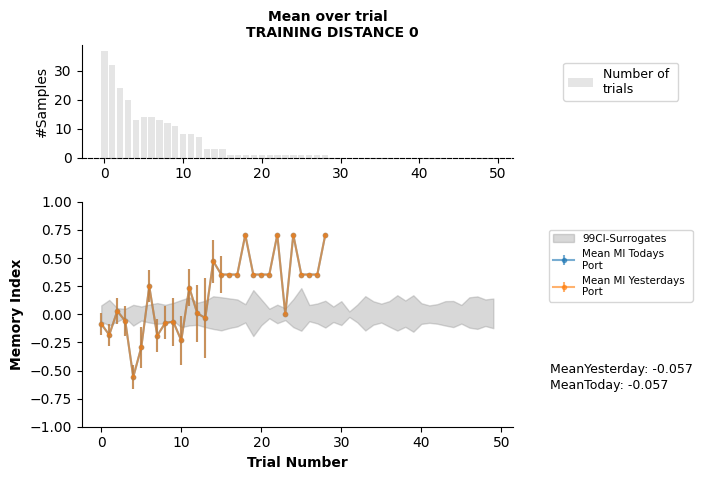

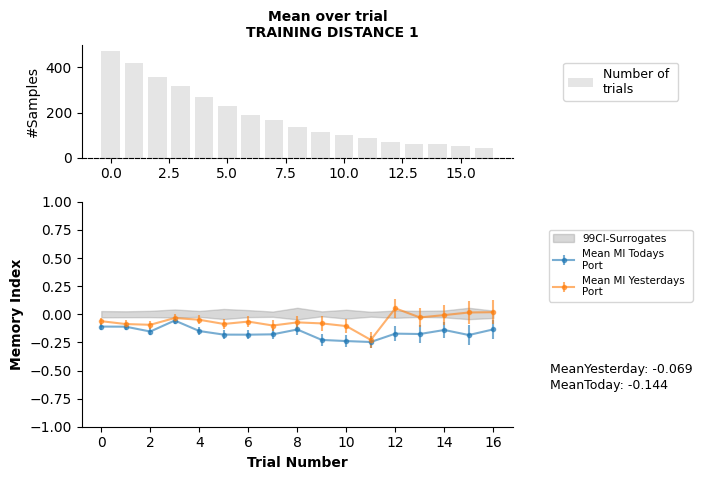

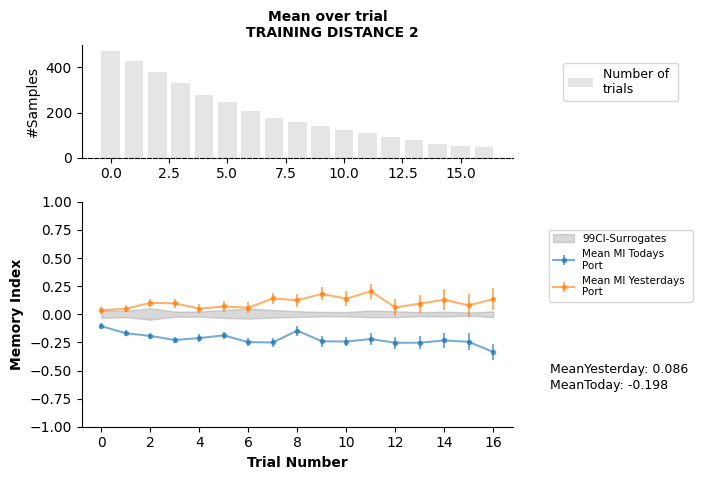

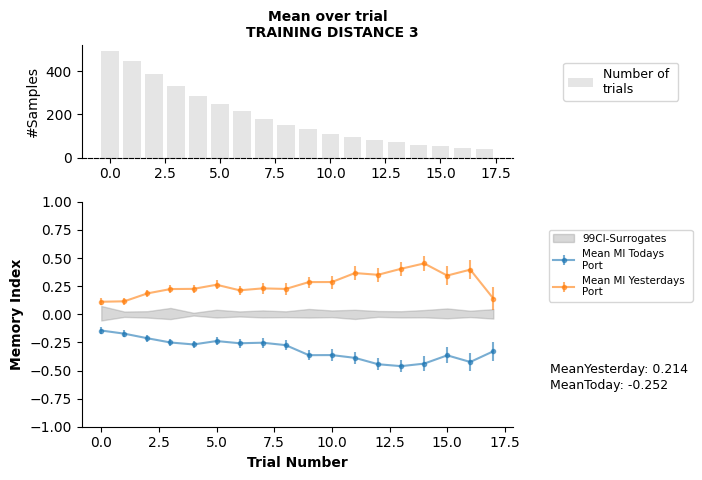

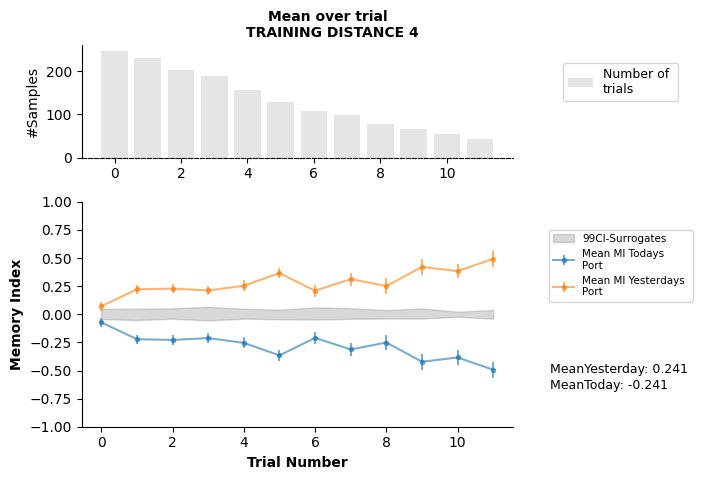

In [ ]:
# #Reshape
MItrlList=np.concatenate(MItrl_0)
MItrlLagsList =np.concatenate(MItrl_lags_0)

## Number of trials
n_trials=[]
for i in range(np.shape(MItrlList)[1]):
  x=np.array(MItrlList)[:,i]
  n_trials.append(len(x[~np.isnan(x)]))
x=np.array([t if trial>40 else np.nan for t,trial in enumerate(n_trials)])
indexes=np.arange(len(MItrl_0[0][0]))

plot_distance(0, indexes,FirstTrlWaterAvail0,FirstTrlWWater0,n_trials, MIShuffTrn_zero, MItrlList, MItrlLagsList, 50)


#Reshape
MItrlList=np.concatenate(MItrl_1)
MItrlLagsList =np.concatenate(MItrl_lags_1)

## Number of trials
n_trials=[]
for i in range(np.shape(MItrlList)[1]):
  x=np.array(MItrlList)[:,i]
  n_trials.append(len(x[~np.isnan(x)]))
x=np.array([t if trial>40 else np.nan for t,trial in enumerate(n_trials)])
Ntrials=int(max(x[~np.isnan(x)]))+1

indexes=x[~np.isnan(x)].astype(int)
plot_distance(1, indexes,FirstTrlWaterAvail1,FirstTrlWWater1,n_trials, MIShuffTrn_1, MItrlList, MItrlLagsList, Ntrials)

#Reshape
MItrlList=np.concatenate(MItrl_2)
MItrlLagsList =np.concatenate(MItrl_lags_2)

## Number of trials
n_trials=[]
for i in range(np.shape(MItrlList)[1]):
  x=np.array(MItrlList)[:,i]
  n_trials.append(len(x[~np.isnan(x)]))
x=np.array([t if trial>40 else np.nan for t,trial in enumerate(n_trials)])
Ntrials=int(max(x[~np.isnan(x)]))+1

indexes=x[~np.isnan(x)].astype(int)
plot_distance(2, indexes,FirstTrlWaterAvail2,FirstTrlWWater2,n_trials, MIShuffTrn_2, MItrlList, MItrlLagsList, Ntrials)

#Reshape
MItrlList=np.concatenate(MItrl_3)
MItrlLagsList =np.concatenate(MItrl_lags_3)

## Number of trials
n_trials=[]
for i in range(np.shape(MItrlList)[1]):
  x=np.array(MItrlList)[:,i]
  n_trials.append(len(x[~np.isnan(x)]))
x=np.array([t if trial>40 else np.nan for t,trial in enumerate(n_trials)])
Ntrials=int(max(x[~np.isnan(x)]))+1

indexes=x[~np.isnan(x)].astype(int)
plot_distance(3, indexes,FirstTrlWaterAvail3,FirstTrlWWater3,n_trials, MIShuffTrn_3, MItrlList, MItrlLagsList, Ntrials)


#Reshape
MItrlList=np.concatenate(MItrl_4)
MItrlLagsList =np.concatenate(MItrl_lags_4)

## Number of trials
n_trials=[]
for i in range(np.shape(MItrlList)[1]):
  x=np.array(MItrlList)[:,i]
  n_trials.append(len(x[~np.isnan(x)]))
x=np.array([t if trial>40 else np.nan for t,trial in enumerate(n_trials)])
Ntrials=int(max(x[~np.isnan(x)]))+1

indexes=x[~np.isnan(x)].astype(int)
plot_distance(4, indexes,FirstTrlWaterAvail4,FirstTrlWWater4,n_trials, MIShuffTrn_4, MItrlList, MItrlLagsList, Ntrials)



#Plot Water

In [ ]:
def plot_water(distance, FirstTrlWaterAvail,FirstTrlWWater, Ntrials, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    occurrences_WaterAvail = Counter(sorted(FirstTrlWaterAvail[~np.isnan(FirstTrlWaterAvail)].astype(int)))
    dict_occurrences_WaterAvail = {i: occurrences_WaterAvail[i] if i in occurrences_WaterAvail else 0 for i in range(Ntrials)}
    occurrences_FirstTrlWWater = Counter(sorted(FirstTrlWWater[~np.isnan(FirstTrlWWater)].astype(int)))
    dict_occurrences_FirstTrlWWater = {i: occurrences_FirstTrlWWater[i] if i in occurrences_FirstTrlWWater else float('nan') for i in range(Ntrials)}

    ax.plot(dict_occurrences_WaterAvail.keys(), dict_occurrences_WaterAvail.values(), '--', color='blue', alpha=0.4, label='Trial Water \nis Available')
    ax.plot(dict_occurrences_FirstTrlWWater.keys(), dict_occurrences_FirstTrlWWater.values(), '-', color='blue', alpha=0.4, label='Trial Water \nis Collected')
    # ax.set_ylabel('#Samples', fontsize=8)
    # ax.set_xlabel('Trial Number', fontsize=8)
    ax.spines['right'].set_visible(False)  # Ocultar el eje derecho
    ax.spines['bottom'].set_linestyle('dashed')
    ax.spines['top'].set_visible(False)
    # ax.legend(loc='upper center', bbox_to_anchor=(1.25, .9), fancybox=True, fontsize=8)
    # ax.set_aspect('equal', adjustable='box')
    # fig.suptitle(f'Water \nDistance {distance}', fontsize=10)
    return ax

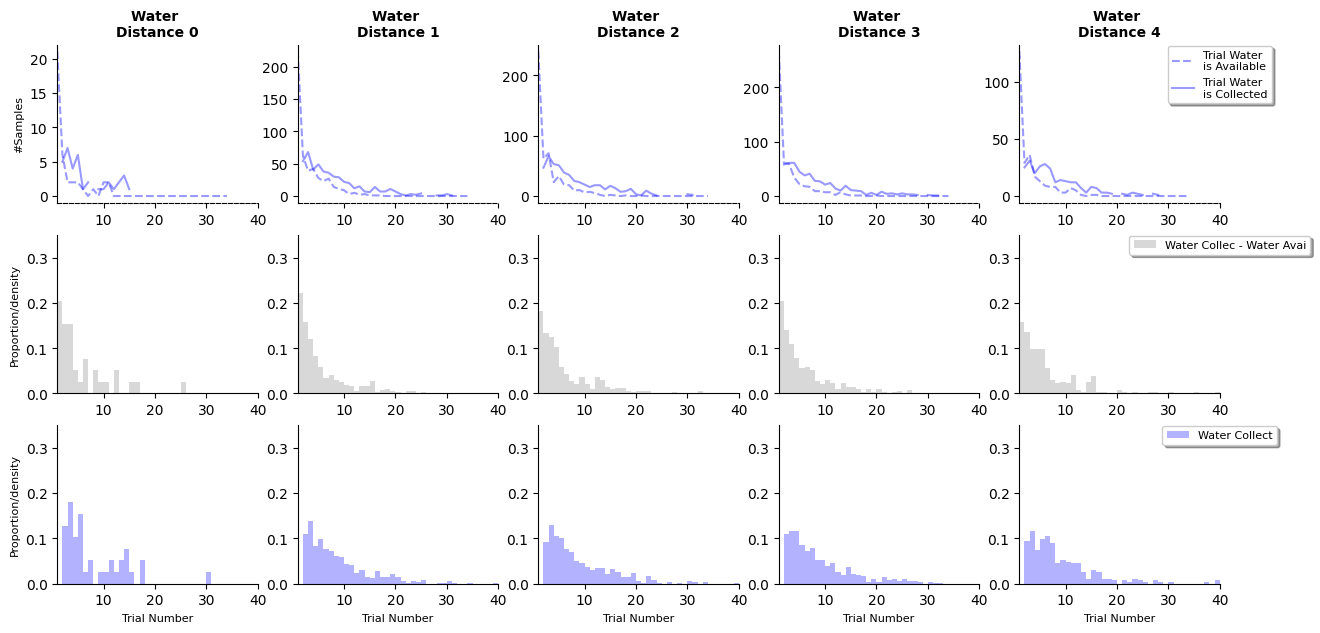

In [ ]:
fig , axs = plt.subplots( 3,5, figsize=(15, 7))
range_min=0
range_max=40
plot_water(0, FirstTrlWaterAvail0,FirstTrlWWater0, 35,  ax=axs[0,0])
axs[0,0].set_title(f'Water \nDistance {0}', fontsize=10, fontweight='bold')
axs[0,0].set_xlim(1,40)
axs[0,0].set_ylabel('#Samples', fontsize=8)
axs[1,0].hist(np.concatenate(FirstTrlWWater0-FirstTrlWaterAvail0), bins=40, density=True, color='grey', alpha=0.3, range=(range_min, range_max))
axs[1,0].spines[['right', 'top']].set_visible(False)
axs[1,0].set_xlim(1,40)
axs[1,0].set_ylim(0,0.35)
axs[1,0].set_ylabel('Proportion/density', fontsize=8)
axs[2,0].hist(np.concatenate(FirstTrlWWater0), bins=40, density=True, color='blue', alpha=0.3, range=(range_min, range_max))
axs[2,0].spines[['right', 'top']].set_visible(False)
axs[2,0].set_xlim(1,40)
axs[2,0].set_ylim(0,0.35)
axs[2,0].set_ylabel('Proportion/density', fontsize=8)
axs[2,0].set_xlabel('Trial Number', fontsize=8)

plot_water(1, FirstTrlWaterAvail1,FirstTrlWWater1, 35,  ax=axs[0,1])
axs[0,1].set_title(f'Water \nDistance {1}', fontsize=10, fontweight='bold')
axs[0,1].set_xlim(1,40)
axs[1,1].hist(np.concatenate(FirstTrlWWater1-FirstTrlWaterAvail1),bins=40,density=True, color='grey', alpha=0.3, range=(range_min, range_max))
axs[1,1].spines[['right', 'top']].set_visible(False)
axs[1,1].set_xlim(1,40)
axs[1,1].set_ylim(0,0.35)
axs[2,1].hist(np.concatenate(FirstTrlWWater1), bins=40, density=True, color='blue', alpha=0.3, range=(range_min, range_max))
axs[2,1].spines[['right', 'top']].set_visible(False)
axs[2,1].set_xlim(1,40)
axs[2,1].set_ylim(0,0.35)
# axs[2,1].set_ylabel('#Samples', fontsize=8)
axs[2,1].set_xlabel('Trial Number', fontsize=8)


plot_water(2, FirstTrlWaterAvail2,FirstTrlWWater2, 35,  ax=axs[0,2])
axs[0,2].set_title(f'Water \nDistance {2}', fontsize=10, fontweight='bold')
axs[0,2].set_xlim(1,40)
axs[1,2].hist(np.concatenate(FirstTrlWWater2-FirstTrlWaterAvail2),bins=40, density=True, color='grey', alpha=0.3, range=(range_min, range_max))
axs[1,2].spines[['right', 'top']].set_visible(False)
axs[1,2].set_xlim(1,40)
axs[1,2].set_ylim(0,0.35)
axs[2,2].hist(np.concatenate(FirstTrlWWater2), bins=40, density=True, color='blue', alpha=0.3, range=(range_min, range_max))
axs[2,2].spines[['right', 'top']].set_visible(False)
axs[2,2].set_xlim(1,40)
axs[2,2].set_ylim(0,0.35)
# axs[2,2].set_ylabel('#Samples', fontsize=8)
axs[2,2].set_xlabel('Trial Number', fontsize=8)


plot_water(1, FirstTrlWaterAvail3,FirstTrlWWater3, 35,  ax=axs[0,3])
axs[0,3].set_title(f'Water \nDistance {3}', fontsize=10, fontweight='bold')
axs[0,3].set_xlim(1,40)
axs[1,3].hist(np.concatenate(FirstTrlWWater3-FirstTrlWaterAvail3) ,bins=40, density=True, color='grey', alpha=0.3, range=(range_min, range_max))
axs[1,3].spines[['right', 'top']].set_visible(False)
axs[1,3].set_xlim(1,40)
axs[1,3].set_ylim(0,0.35)
axs[2,3].hist(np.concatenate(FirstTrlWWater3), bins=40, density=True, color='blue', alpha=0.3, range=(range_min, range_max))
axs[2,3].spines[['right', 'top']].set_visible(False)
axs[2,3].set_xlim(1,40)
axs[2,3].set_ylim(0,0.35)
# axs[2,3].set_ylabel('#Samples', fontsize=8)
axs[2,3].set_xlabel('Trial Number', fontsize=8)


plot_water(1, FirstTrlWaterAvail4,FirstTrlWWater4, 35,  ax=axs[0,4])
axs[0,4].set_title(f'Water \nDistance {4}', fontsize=10, fontweight='bold')
axs[0,4].set_xlim(1,40)
axs[1,4].hist(np.concatenate(FirstTrlWWater4-FirstTrlWaterAvail4),bins=40, density=True, color='grey', alpha=0.3, range=(range_min, range_max), label='Water Collec - Water Avai')
axs[1,4].spines[['right', 'top']].set_visible(False)
axs[1,4].set_xlim(1,40)
axs[1,4].set_ylim(0,0.35)
axs[2,4].hist(np.concatenate(FirstTrlWWater4), bins=40, density=True, color='blue', alpha=0.3,range=(range_min, range_max), label='Water Collect')
axs[2,4].spines[['right', 'top']].set_visible(False)
axs[2,4].set_xlim(1,40)
axs[2,4].set_ylim(0,0.35)
# axs[2,4].set_ylabel('#Samples', fontsize=8)
axs[2,4].set_xlabel('Trial Number', fontsize=8)

axs[0,4].legend( loc='upper center', bbox_to_anchor=(1, 1.03), fancybox=True, shadow=True, fontsize=8)
axs[1,4].legend( loc='upper center', bbox_to_anchor=(1, 1.03), fancybox=True, shadow=True, fontsize=8)
axs[2,4].legend( loc='upper center', bbox_to_anchor=(1, 1.03), fancybox=True, shadow=True, fontsize=8)
# handles, labels = axs[0,0].get_legend_handles_labels()
# unique_labels = list(set(labels))
# # fig.tight_layout()
# # fig.legend(handles[:len(unique_labels)], unique_labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, shadow=True, ncol=len(unique_labels), fontsize=8)


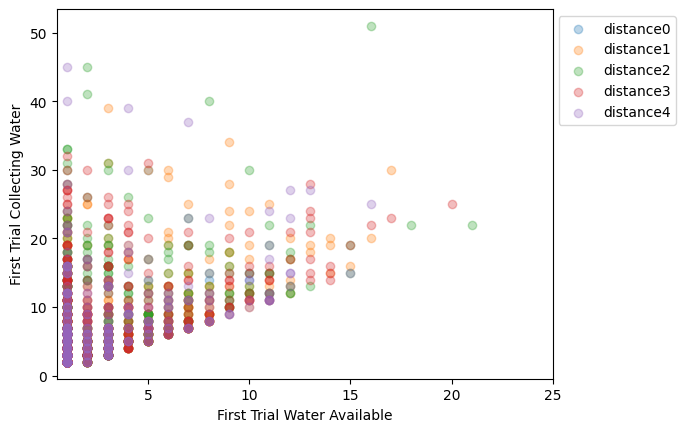

In [ ]:
plt.scatter(FirstTrlWaterAvail0,FirstTrlWWater0, label='distance0', alpha=0.3)
plt.scatter(FirstTrlWaterAvail1,FirstTrlWWater1, label='distance1', alpha=0.3)
plt.scatter(FirstTrlWaterAvail2,FirstTrlWWater2, label='distance2', alpha=0.3)
plt.scatter(FirstTrlWaterAvail3,FirstTrlWWater3, label='distance3', alpha=0.3)
plt.scatter(FirstTrlWaterAvail4,FirstTrlWWater4, label='distance4', alpha=0.3)
plt.xlim(0.5,25)
plt.ylabel('First Trial Collecting Water')
plt.xlabel('First Trial Water Available')
plt.legend(loc='upper center', bbox_to_anchor=(1.13, 1))

Text(0.9, 0.8, 'x:Mode')

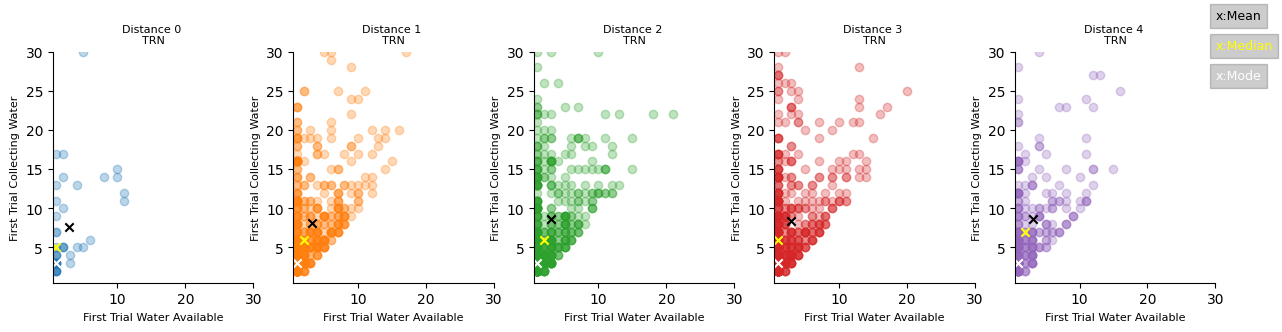

In [ ]:
fig , axs = plt.subplots( 1,5, figsize=(15, 3))
axs[0].scatter(FirstTrlWaterAvail0,FirstTrlWWater0, label='distance0', color='tab:blue',alpha=0.3)
axs[0].scatter(np.nanmean(FirstTrlWaterAvail0), np.nanmean(FirstTrlWWater0), marker='x', color='black', label='Mean')
axs[0].scatter(np.nanmedian(FirstTrlWaterAvail0), np.nanmedian(FirstTrlWWater0), marker='x',  color='yellow', label='Median')
axs[0].scatter(mode(FirstTrlWaterAvail0[~np.isnan(FirstTrlWaterAvail0)]).mode, mode(FirstTrlWWater0[~np.isnan(FirstTrlWWater0)]).mode, marker='x',  color='white', label='Mode')
axs[0].spines[['top', 'right']].set_visible(False)
axs[0].set_xlim(0.5,30)
axs[0].set_ylim(0.5,30)
axs[0].set_ylabel('First Trial Collecting Water',fontsize=8)
axs[0].set_xlabel('First Trial Water Available',fontsize=8)
axs[0].set_title('Distance 0 \nTRN' ,fontsize=8)

axs[1].scatter(FirstTrlWaterAvail1,FirstTrlWWater1, label='distance1', color='tab:orange',alpha=0.3)
axs[1].spines[['top', 'right']].set_visible(False)
axs[1].set_xlim(0.5,30)
axs[1].set_ylim(0.5,30)
axs[1].set_ylabel('First Trial Collecting Water',fontsize=8)
axs[1].set_xlabel('First Trial Water Available',fontsize=8)
axs[1].scatter(np.nanmean(FirstTrlWaterAvail1), np.nanmean(FirstTrlWWater1), marker='x',color='black', label='Mean')
axs[1].scatter(np.nanmedian(FirstTrlWaterAvail1), np.nanmedian(FirstTrlWWater1), marker='x',  color='yellow', label='Median')
axs[1].scatter(mode(FirstTrlWaterAvail1[~np.isnan(FirstTrlWaterAvail1)]).mode, mode(FirstTrlWWater1[~np.isnan(FirstTrlWWater1)]).mode, marker='x',  color='white', label='Mode')
axs[1].set_title('Distance 1 \nTRN' ,fontsize=8)

axs[2].scatter(FirstTrlWaterAvail2,FirstTrlWWater2, label='distance2', color='tab:green', alpha=0.3)
axs[2].spines[['top', 'right']].set_visible(False)
axs[2].set_xlim(0.5,30)
axs[2].set_ylim(0.5,30)
axs[2].set_ylabel('First Trial Collecting Water',fontsize=8)
axs[2].set_xlabel('First Trial Water Available',fontsize=8)
axs[2].scatter(np.nanmean(FirstTrlWaterAvail2), np.nanmean(FirstTrlWWater2), marker='x', color='black', label='Mean')
axs[2].scatter(np.nanmedian(FirstTrlWaterAvail2), np.nanmedian(FirstTrlWWater2), marker='x',  color='yellow', label='Median')
axs[2].scatter(mode(FirstTrlWaterAvail2[~np.isnan(FirstTrlWaterAvail2)]).mode, mode(FirstTrlWWater2[~np.isnan(FirstTrlWWater2)]).mode, marker='x',  color='white', label='Mode')
axs[2].set_title('Distance 2 \nTRN' ,fontsize=8)

axs[3].scatter(FirstTrlWaterAvail3,FirstTrlWWater3, label='distance3', color='tab:red',alpha=0.3)
axs[3].spines[['top', 'right']].set_visible(False)
axs[3].set_xlim(0.5,30)
axs[3].set_ylim(0.5,30)
axs[3].set_ylabel('First Trial Collecting Water',fontsize=8)
axs[3].set_xlabel('First Trial Water Available',fontsize=8)
axs[3].scatter(np.nanmean(FirstTrlWaterAvail3), np.nanmean(FirstTrlWWater3), marker='x', color='black', label='Mean')
axs[3].scatter(np.nanmedian(FirstTrlWaterAvail3), np.nanmedian(FirstTrlWWater3), marker='x',  color='yellow', label='Median')
axs[3].scatter(mode(FirstTrlWaterAvail3[~np.isnan(FirstTrlWaterAvail3)]).mode, mode(FirstTrlWWater3[~np.isnan(FirstTrlWWater3)]).mode, marker='x', color='white', label='Mode')
axs[3].set_title('Distance 3 \nTRN' ,fontsize=8)

axs[4].scatter(FirstTrlWaterAvail4,FirstTrlWWater4, label='distance4', color='tab:purple',alpha=0.3)
axs[4].spines[['top', 'right']].set_visible(False)
axs[4].set_xlim(0.5,30)
axs[4].set_ylim(0.5,30)
axs[4].set_ylabel('First Trial Collecting Water',fontsize=8)
axs[4].set_xlabel('First Trial Water Available',fontsize=8)
axs[4].scatter(np.nanmean(FirstTrlWaterAvail4), np.nanmean(FirstTrlWWater4), marker='x', color='black', label='Mean')
axs[4].scatter(np.nanmedian(FirstTrlWaterAvail4), np.nanmedian(FirstTrlWWater4), marker='x',  color='yellow', label='Median')
axs[4].scatter(mode(FirstTrlWaterAvail4[~np.isnan(FirstTrlWaterAvail4)]).mode, mode(FirstTrlWWater4[~np.isnan(FirstTrlWWater4)]).mode, marker='x',  color='white', label='Mode')
axs[4].set_title('Distance 4 \nTRN' ,fontsize=8)

fig.text( 0.9,1, 'x:Mean', color='black', ha='left', va='center', fontsize=9,bbox=dict(facecolor='black', alpha=0.2))
fig.text( 0.9,0.9, 'x:Median', color='yellow', ha='left', va='center', fontsize=9,bbox=dict(facecolor='black', alpha=0.2))
fig.text( 0.9,0.8, 'x:Mode', color='white', ha='left', va='center', fontsize=9,bbox=dict(facecolor='black', alpha=0.2))

# axs[0].legend(loc='upper center', bbox_to_anchor=(1.13, 1))

Text(0.5, 0, 'Trial Number')

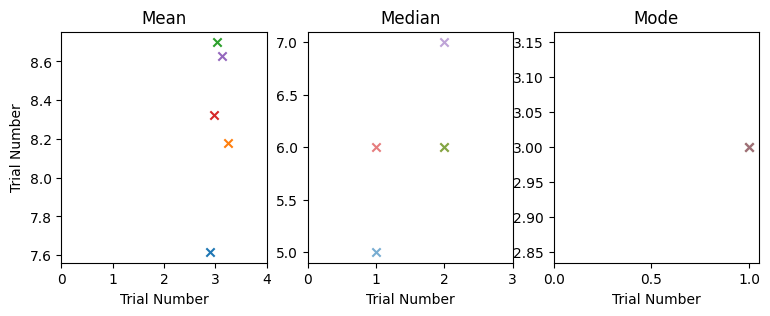

In [ ]:
fig , axs = plt.subplots(1,3, figsize=(9, 3))
axs[0].scatter(np.nanmean(FirstTrlWaterAvail0), np.nanmean(FirstTrlWWater0), marker='x', color='tab:blue', label='Mean')
axs[1].scatter(np.nanmedian(FirstTrlWaterAvail0), np.nanmedian(FirstTrlWWater0), marker='x',  color='tab:blue',alpha=0.6, label='Median')
axs[2].scatter(mode(FirstTrlWaterAvail0[~np.isnan(FirstTrlWaterAvail0)]).mode, mode(FirstTrlWWater0[~np.isnan(FirstTrlWWater0)]).mode, marker='x', alpha=0.4, color='tab:blue', label='Mode')
axs[0].scatter(np.nanmean(FirstTrlWaterAvail1), np.nanmean(FirstTrlWWater1), marker='x',color='tab:orange', label='Mean')
axs[1].scatter(np.nanmedian(FirstTrlWaterAvail1), np.nanmedian(FirstTrlWWater1), marker='x',  color='tab:orange',alpha=0.6, label='Median')
axs[2].scatter(mode(FirstTrlWaterAvail1[~np.isnan(FirstTrlWaterAvail1)]).mode, mode(FirstTrlWWater1[~np.isnan(FirstTrlWWater1)]).mode, marker='x',  color='tab:orange',alpha=0.4, label='Mode')
axs[0].scatter(np.nanmean(FirstTrlWaterAvail2), np.nanmean(FirstTrlWWater2), marker='x',color='tab:green', label='Mean')
axs[1].scatter(np.nanmedian(FirstTrlWaterAvail2), np.nanmedian(FirstTrlWWater2), marker='x',  color='tab:green',alpha=0.6, label='Median')
axs[2].scatter(mode(FirstTrlWaterAvail2[~np.isnan(FirstTrlWaterAvail2)]).mode, mode(FirstTrlWWater2[~np.isnan(FirstTrlWWater2)]).mode, marker='x',  color='tab:green',alpha=0.4, label='Mode')
axs[0].scatter(np.nanmean(FirstTrlWaterAvail3), np.nanmean(FirstTrlWWater3), marker='x',color='tab:red', label='Mean')
axs[1].scatter(np.nanmedian(FirstTrlWaterAvail3), np.nanmedian(FirstTrlWWater3), marker='x',  color='tab:red',alpha=0.6, label='Median')
axs[2].scatter(mode(FirstTrlWaterAvail3[~np.isnan(FirstTrlWaterAvail3)]).mode, mode(FirstTrlWWater3[~np.isnan(FirstTrlWWater3)]).mode, marker='x',  color='tab:red',alpha=0.4, label='Mode')
axs[0].scatter(np.nanmean(FirstTrlWaterAvail4), np.nanmean(FirstTrlWWater4), marker='x',color='tab:purple', label='Mean')
axs[1].scatter(np.nanmedian(FirstTrlWaterAvail4), np.nanmedian(FirstTrlWWater4), marker='x',  color='tab:purple',alpha=0.6, label='Median')
axs[2].scatter(mode(FirstTrlWaterAvail4[~np.isnan(FirstTrlWaterAvail4)]).mode, mode(FirstTrlWWater4[~np.isnan(FirstTrlWWater4)]).mode, marker='x',  color='tab:purple',alpha=0.4, label='Mode')
axs[0].set_title('Mean')
axs[0].set_xlim(0,4)
axs[0].set_xlabel('Trial Number')
axs[0].set_ylabel('Trial Number')
axs[1].set_title('Median')
axs[1].set_xlim(0,3)
axs[1].set_xlabel('Trial Number')
# axs[1].set_ylabel('Trial Number')
axs[2].set_title('Mode')
axs[2].set_xlim(0,1.05)
axs[2].set_xlabel('Trial Number')
# axs[2].set_ylabel('Trial Number')

# Mean MI by distance

In [ ]:
MItrlList0=np.concatenate(MItrl_0)
MItrlLagsList0 =np.concatenate(MItrl_lags_0)
MItrlList1=np.concatenate(MItrl_1)
MItrlLagsList1 =np.concatenate(MItrl_lags_1)
MItrlList2=np.concatenate(MItrl_2)
MItrlLagsList2 =np.concatenate(MItrl_lags_2)
MItrlList3=np.concatenate(MItrl_3)
MItrlLagsList3 =np.concatenate(MItrl_lags_3)
MItrlList4=np.concatenate(MItrl_4)
MItrlLagsList4 =np.concatenate(MItrl_lags_4)
All_MItrlList={0:MItrlList0,1:MItrlList1,2:MItrlList2,3:MItrlList3,4:MItrlList4}
All_MItrlLagsList={0:MItrlLagsList0,1:MItrlLagsList1,2:MItrlLagsList2,3:MItrlLagsList3,4:MItrlLagsList4}

Text(0.5, 1.0, 'MI by Distance TRN \nwith 1 trials')

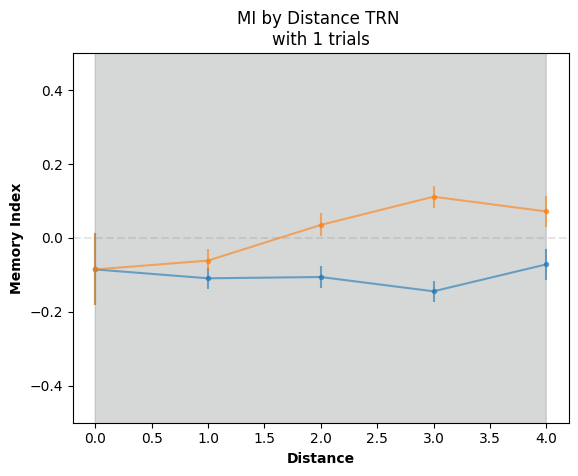

In [ ]:
NumTrials=1
All_MItrlList_Dist_means=[]
All_MItrlList_Dist_sem=[]
All_MItrlList_Dist_CI95=[]
All_MItrlLagsList_Dist_means=[]
All_MItrlLagsList_Dist_sem=[]
All_MItrlLagsList_Dist_CI95=[]
for i in range(len(All_MItrlList)):
  All_MItrlList_Dist_means.append(np.nanmean(All_MItrlList[i][:,:NumTrials]))
  All_MItrlList_non_nan=[All_MItrlList[i][:,:NumTrials][~np.isnan(All_MItrlList[i][:,:NumTrials])]]
  All_MItrlList_Dist_CI95.append(np.array(np.percentile(All_MItrlList_non_nan, [0.95, 0.05])))
  All_MItrlList_Dist_sem.append(np.nanstd(All_MItrlList[i][:,:NumTrials]) / np.sqrt(np.sum(~np.isnan(All_MItrlList[i][:,:NumTrials]))))
  All_MItrlLagsList_Dist_means.append(np.nanmean(All_MItrlLagsList[i][:,:NumTrials]))
  All_MItrlLagsList_non_nan=[All_MItrlLagsList[i][:,:NumTrials][~np.isnan(All_MItrlLagsList[i][:,:NumTrials])]]
  All_MItrlLagsList_Dist_CI95.append(np.array(np.percentile(All_MItrlLagsList_non_nan, [0.95, 0.05])))
  All_MItrlLagsList_Dist_sem.append(np.nanstd(All_MItrlLagsList[i][:,:NumTrials]) / np.sqrt(np.sum(~np.isnan(All_MItrlLagsList[i][:,:NumTrials]))))

x=np.arange(0, len(All_MItrlList_Dist_means), 1)
##FIGURE
# axs[1].fill_between(indexes, np.nanmean(MIShuffTrn_zero, axis=0)+revCI99[:,0], np.nanmean(MIShuffTrn_zero, axis=0)-revCI99[:,1],color='grey' , alpha=0.3 ,label='Mean Surrogates')
plt.fill_between(x,np.array(All_MItrlList_Dist_means)-np.array(All_MItrlList_Dist_CI95)[:,0], np.array(All_MItrlList_Dist_means)+np.array(All_MItrlList_Dist_CI95)[:,1],color='tab:blue', alpha=0.2)
plt.errorbar(x,All_MItrlList_Dist_means,  yerr=All_MItrlList_Dist_sem, fmt='.-', alpha=0.6 ,label='Todays Port')
plt.fill_between(x,np.array(All_MItrlLagsList_Dist_means)-np.array(All_MItrlLagsList_Dist_CI95)[:,0], np.array(All_MItrlLagsList_Dist_means)+np.array(All_MItrlLagsList_Dist_CI95)[:,1],color='tab:orange', alpha=0.1)
plt.errorbar(x,All_MItrlLagsList_Dist_means,  yerr=All_MItrlLagsList_Dist_sem, fmt='.-', alpha=0.6 ,label='Yesterdays Port')
plt.axhline(y=0,  linestyle='--', color='grey', alpha=0.2)
plt.ylabel('Memory Index',fontweight='bold')
plt.xlabel('Distance',fontweight='bold')
plt.ylim(-.5,.5)
plt.title(f'MI by Distance TRN \nwith {NumTrials} trials')
# axs[1].set_ylim(-1,1 )
# axs[1].set_ylabel('Memory Index', fontweight='bold')
# axs[1].set_xlabel('Trial Number', fontweight='bold')

# Other data arrangement

5 by 5 sessions

<ipython-input-139-3052fa713f95>:18: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot(x,(np.nanmean(np.nanmean(MItrl_[:,idx:idx+5],axis=1),axis=0)), '.-' ,alpha=0.6 ,label='Todays Port')
<ipython-input-139-3052fa713f95>:19: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot(x,(np.nanmean(np.nanmean(MItrl_lags_[:,idx:idx+5],axis=1),axis=0)), '.-' , alpha=0.5 ,label='Yesterdays Port')


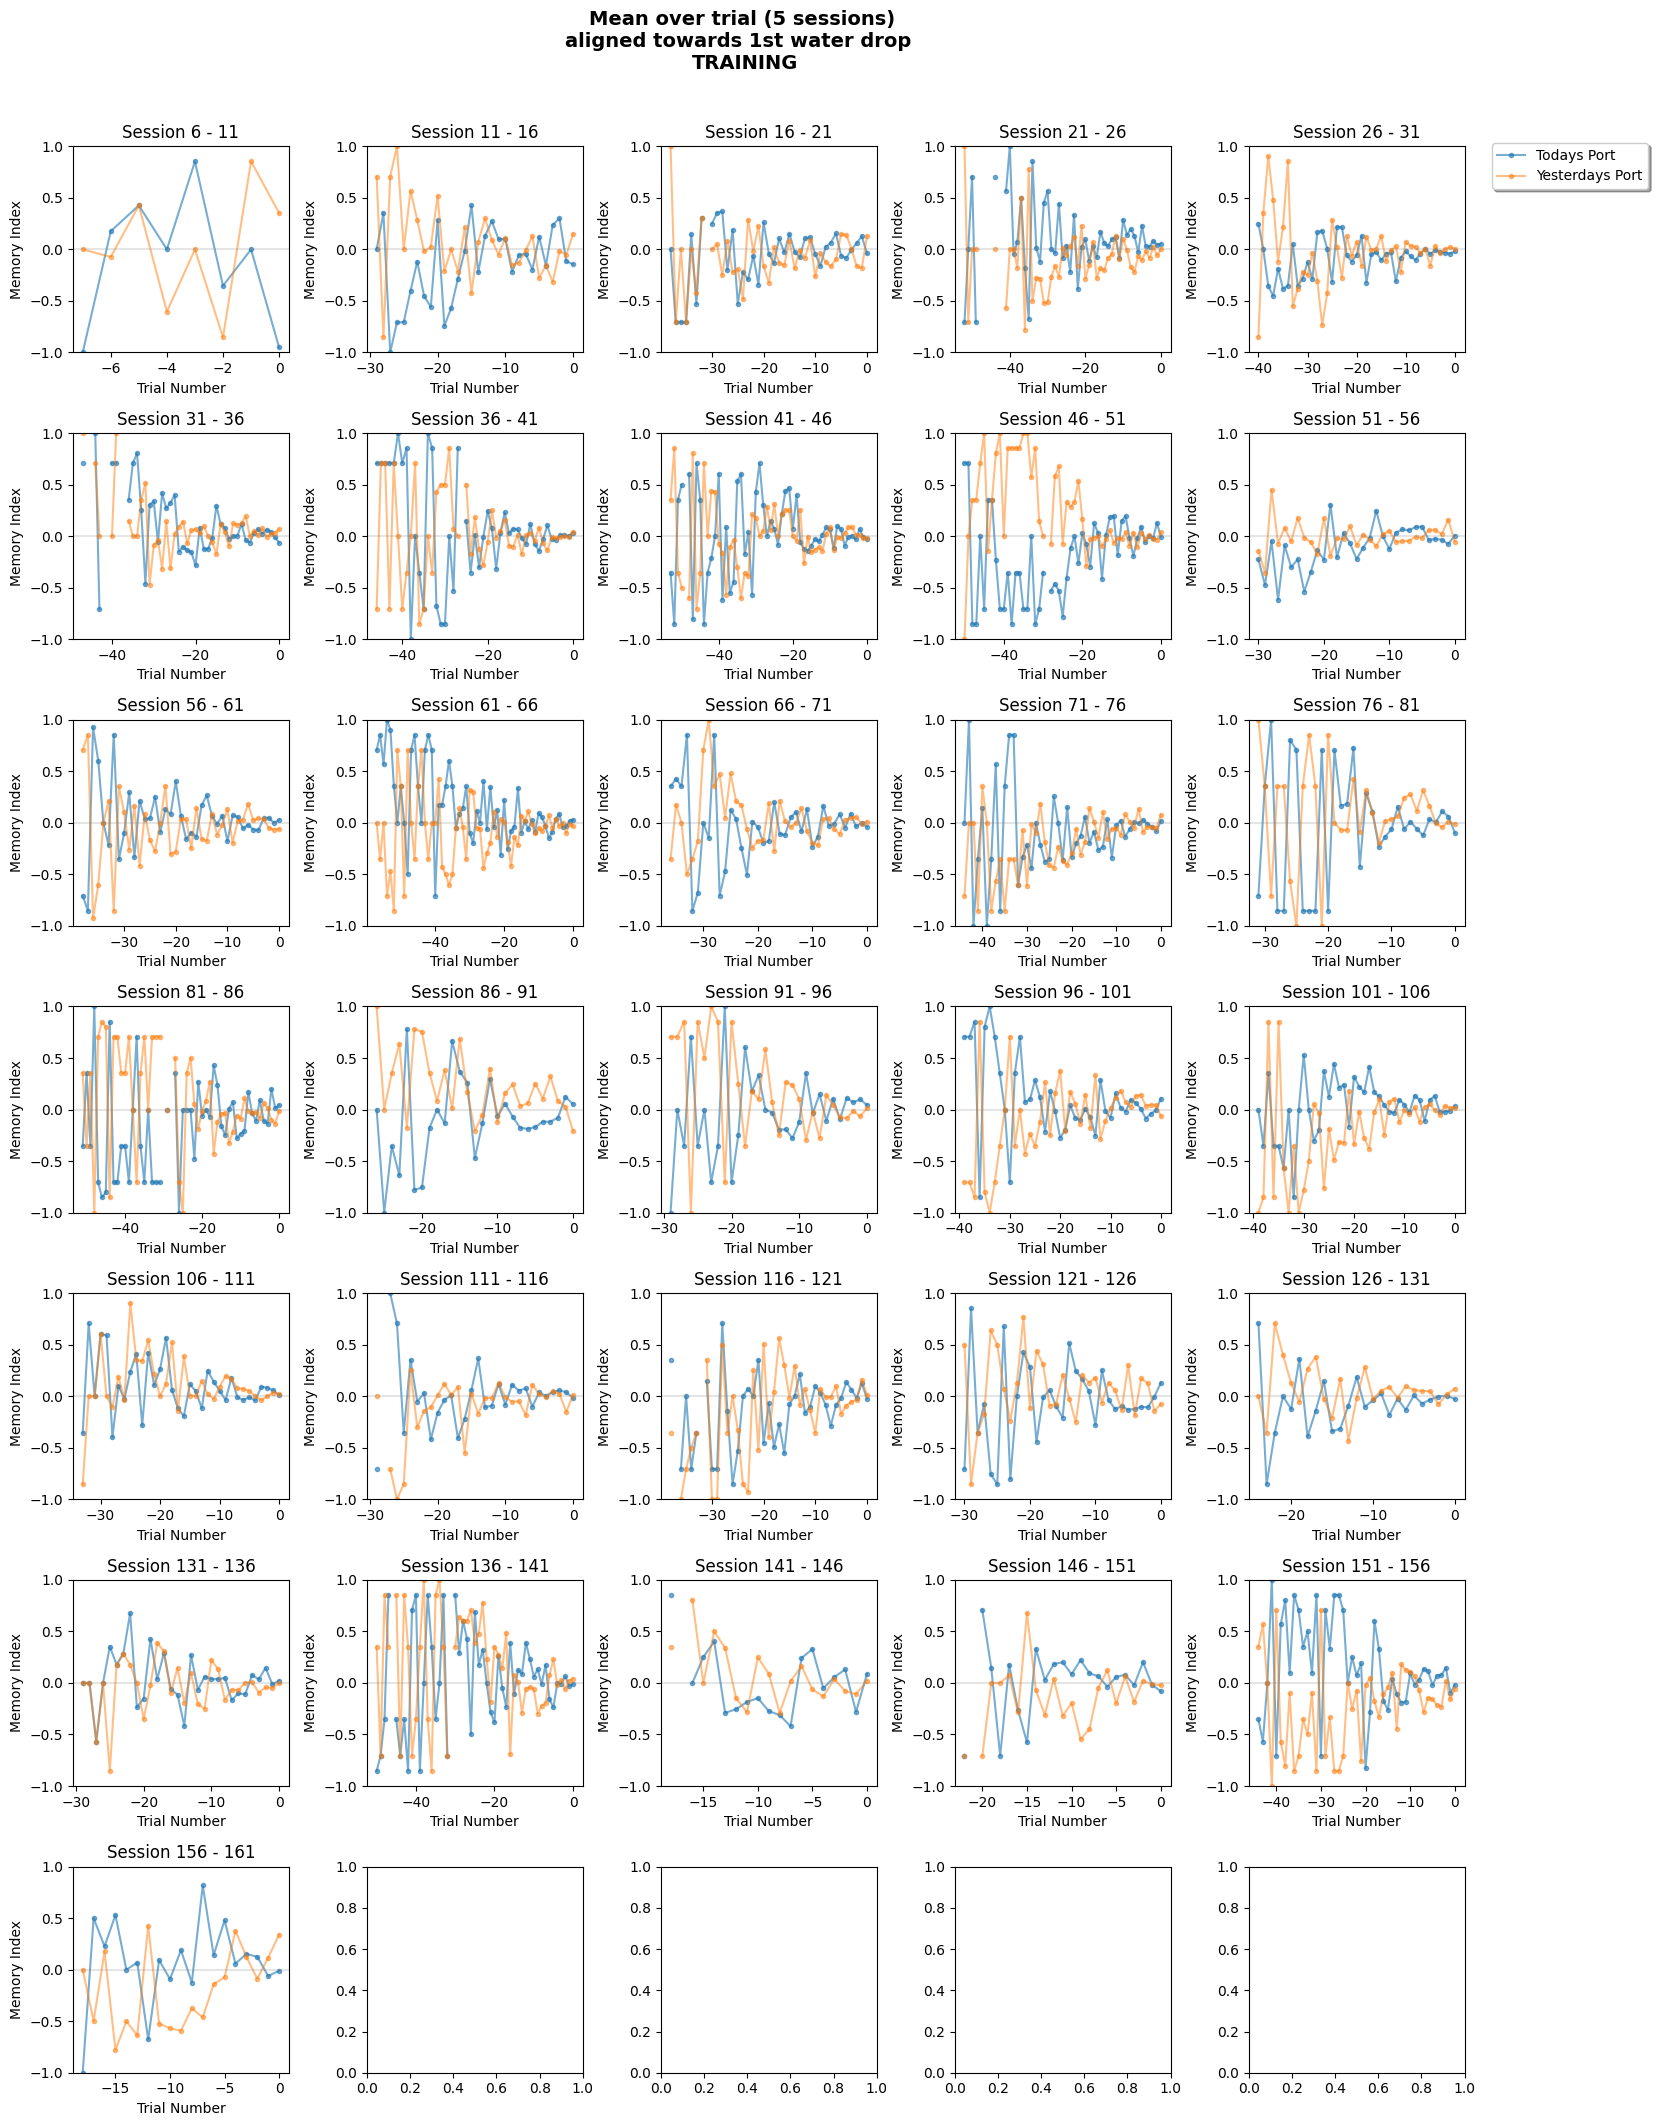

In [ ]:
## PLOTTING BY SESSION
num_columns = 5
n = (MItrl_lags_.shape[1]/5) // num_columns

# Find the indices of non-empty subplots
non_empty_indices = [i for i in range(0,MItrl_lags_.shape[1],5) if not np.isnan(MItrl_lags_[:,i:i+5]).all()]

# Calculate the new number of rows based on non-empty subplots
n_rows = len(non_empty_indices) // num_columns + int(len(non_empty_indices) % num_columns != 0)
x=-np.array(list(reversed(np.arange(len(MItrl_[0][0])))))

# Create a figure and an array of subplots
fig, axs = plt.subplots(n_rows, num_columns, figsize=(15, 3 * n_rows))

for i, idx in enumerate(non_empty_indices):
    # print(i, idx)
    row_idx, col_idx = divmod(i, num_columns)
    axs[row_idx, col_idx].plot(x,(np.nanmean(np.nanmean(MItrl_[:,idx:idx+5],axis=1),axis=0)), '.-' ,alpha=0.6 ,label='Todays Port')
    axs[row_idx, col_idx].plot(x,(np.nanmean(np.nanmean(MItrl_lags_[:,idx:idx+5],axis=1),axis=0)), '.-' , alpha=0.5 ,label='Yesterdays Port')
    axs[row_idx, col_idx].axhline(0, color='grey', alpha=0.2)
    axs[row_idx, col_idx].set_title(f'Session {idx + 1} - {idx+5 + 1}')
    axs[row_idx, col_idx].set_ylim(-1, 1)
    axs[row_idx, col_idx].set_ylabel('Memory Index')
    axs[row_idx, col_idx].set_xlabel('Trial Number')
    # axs[row_idx, col_idx].set_xticklabels()
fig.legend(loc='upper center', bbox_to_anchor=(1.05, .95), fancybox=True, shadow=True, labels=['Todays Port', 'Yesterdays Port'])

# Adjust layout to prevent clipping of titles
fig.suptitle('Mean over trial (5 sessions) \naligned towards 1st water drop  \nTRAINING', x=0.5, y=1.01, fontweight='bold', fontsize=14)
fig.tight_layout()
# Show the figure
plt.show()

<ipython-input-140-d39fe0428c33>:17: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot((np.nanmean(np.nanmean(MItrl[:,idx:idx+5],axis=1),axis=0)), '.-' ,alpha=0.6 ,label='Todays Port')
<ipython-input-140-d39fe0428c33>:18: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot((np.nanmean(np.nanmean(MItrl_lags[:,idx:idx+5],axis=1),axis=0)), '.-' , alpha=0.5 ,label='Yesterdays Port')


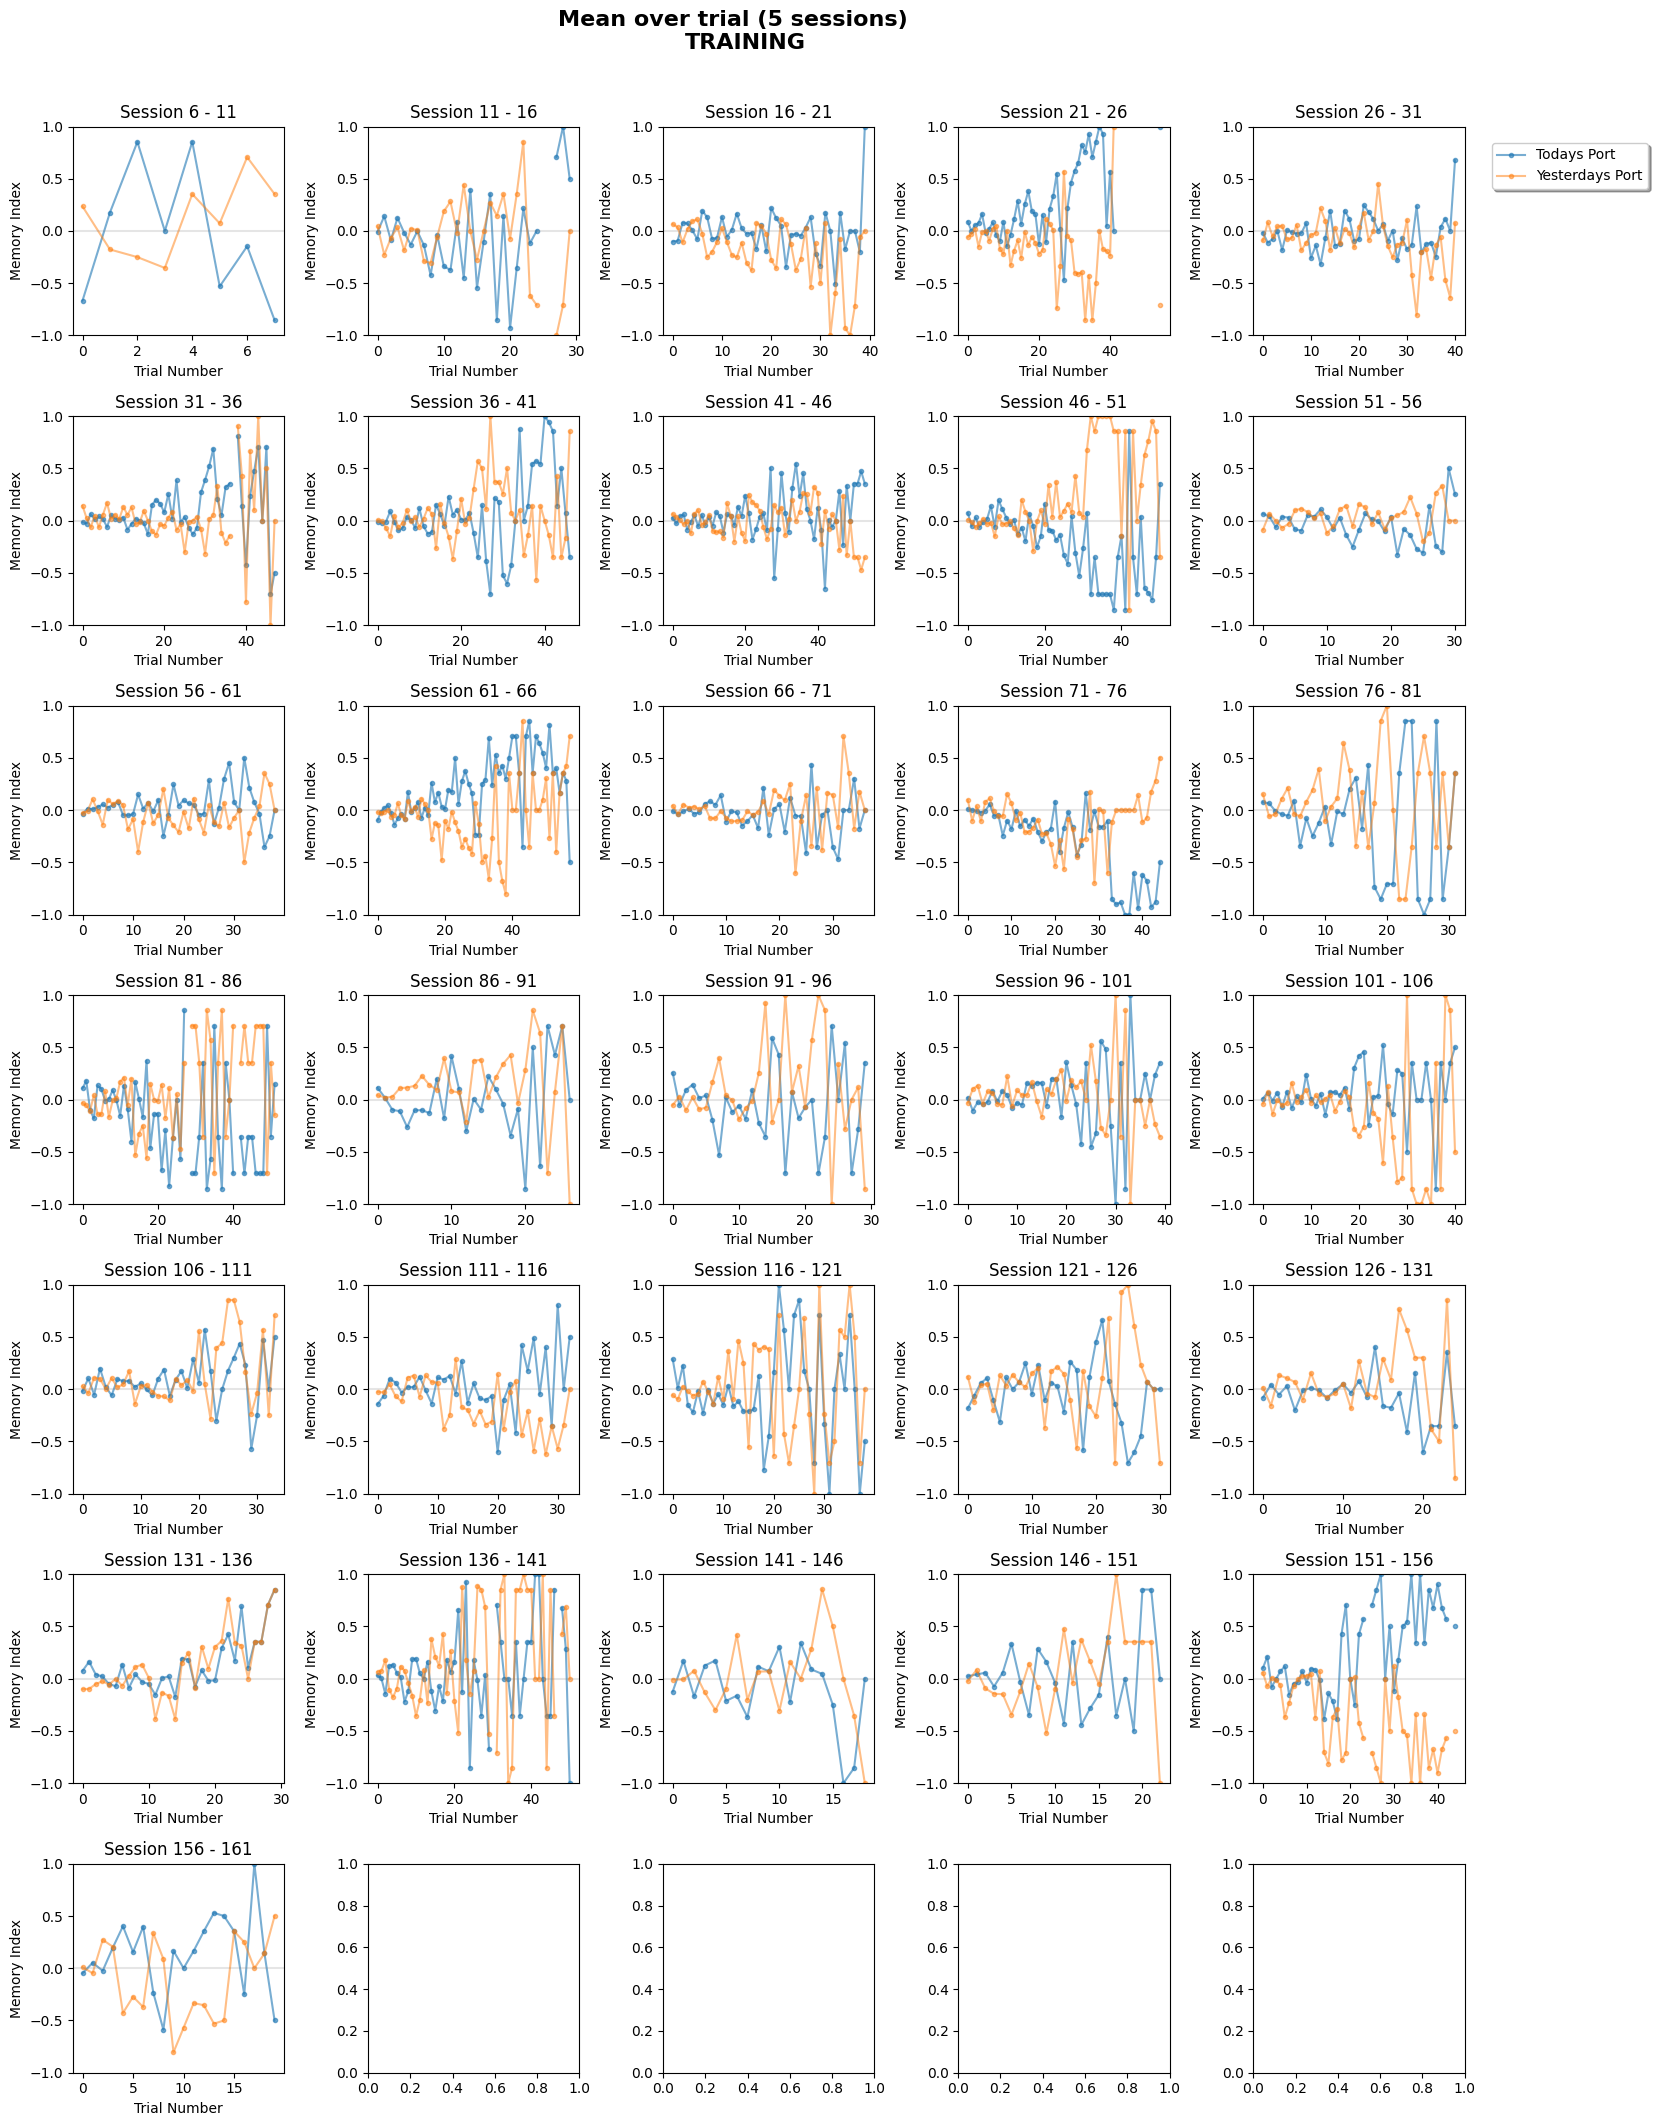

In [ ]:
## PLOTTING BY SESSION
num_columns = 5
n = (MItrl_lags.shape[1]/5) // num_columns

# Find the indices of non-empty subplots
non_empty_indices = [i for i in range(0,MItrl_lags.shape[1],5) if not np.isnan(MItrl_lags[:,i:i+5]).all()]

# Calculate the new number of rows based on non-empty subplots
n_rows = len(non_empty_indices) // num_columns + int(len(non_empty_indices) % num_columns != 0)

# Create a figure and an array of subplots
fig, axs = plt.subplots(n_rows, num_columns, figsize=(15, 3 * n_rows))

for i, idx in enumerate(non_empty_indices):
    # print(i, idx)
    row_idx, col_idx = divmod(i, num_columns)
    axs[row_idx, col_idx].plot((np.nanmean(np.nanmean(MItrl[:,idx:idx+5],axis=1),axis=0)), '.-' ,alpha=0.6 ,label='Todays Port')
    axs[row_idx, col_idx].plot((np.nanmean(np.nanmean(MItrl_lags[:,idx:idx+5],axis=1),axis=0)), '.-' , alpha=0.5 ,label='Yesterdays Port')
    axs[row_idx, col_idx].axhline(0, color='grey', alpha=0.2)
    axs[row_idx, col_idx].set_title(f'Session {idx + 1} - {idx+5 + 1}')
    axs[row_idx, col_idx].set_ylim(-1, 1)
    axs[row_idx, col_idx].set_ylabel('Memory Index')
    axs[row_idx, col_idx].set_xlabel('Trial Number')

fig.legend(loc='upper center', bbox_to_anchor=(1.05, .95), fancybox=True, shadow=True, labels=['Todays Port', 'Yesterdays Port'])

# Adjust layout to prevent clipping of titles
fig.suptitle('Mean over trial (5 sessions)   \nTRAINING', x=0.5, y=1.01, fontweight='bold', fontsize=16)
fig.tight_layout()
# Show the figure
plt.show()

 10 by 10 sessions

<ipython-input-141-89c224f17d91>:19: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot(x,(np.nanmean(np.nanmean(MItrl_[:,idx:idx+10],axis=1),axis=0)), '.-' ,alpha=0.6 ,label='Todays Port')
<ipython-input-141-89c224f17d91>:20: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot(x,(np.nanmean(np.nanmean(MItrl_lags_[:,idx:idx+10],axis=1),axis=0)), '.-' , alpha=0.5 ,label='Yesterdays Port')


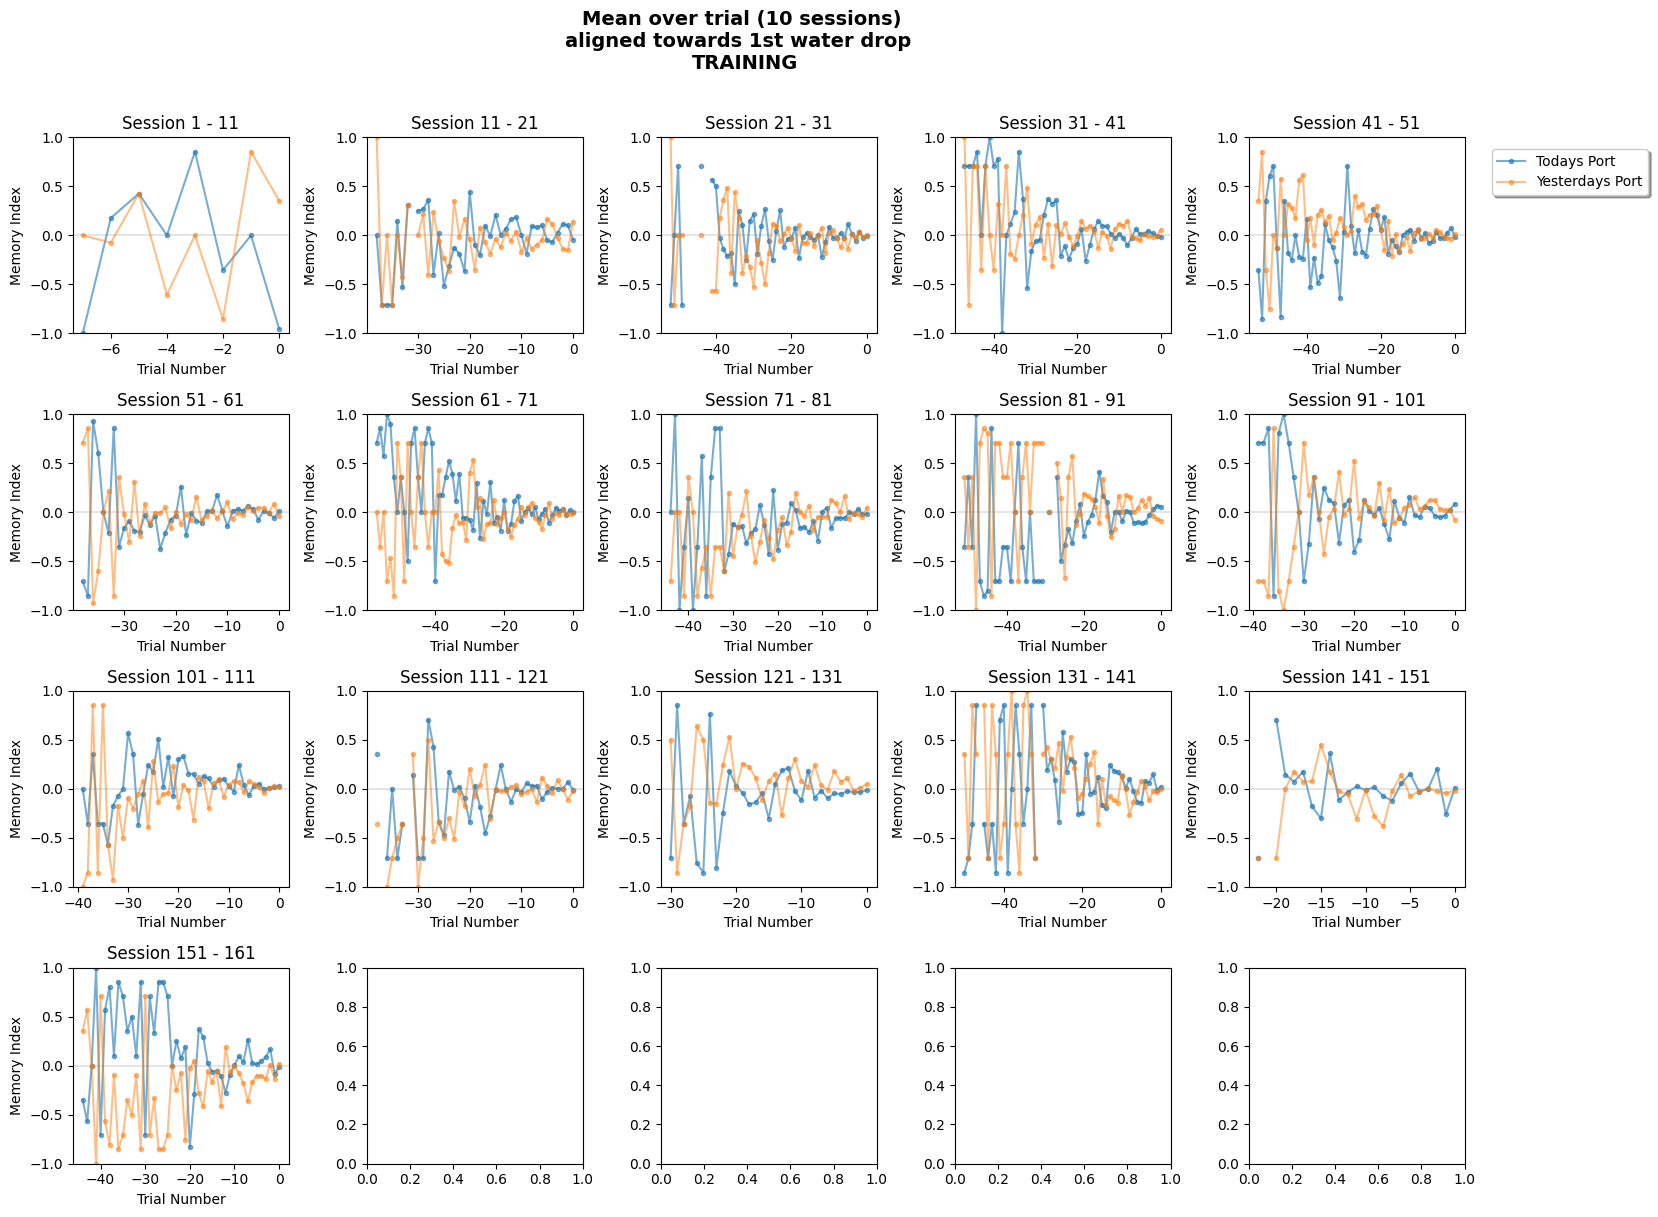

In [ ]:
## PLOTTING BY SESSION
num_columns = 5
n = (MItrl_lags_.shape[1]/10) // num_columns

# Find the indices of non-empty subplots
non_empty_indices = [i for i in range(0,MItrl_lags_.shape[1],10) if not np.isnan(MItrl_lags_[:,i:i+10]).all()]
x=-np.array(list(reversed(np.arange(len(MItrl_[0][0])))))


# Calculate the new number of rows based on non-empty subplots
n_rows = len(non_empty_indices) // num_columns + int(len(non_empty_indices) % num_columns != 0)

# Create a figure and an array of subplots
fig, axs = plt.subplots(n_rows, num_columns, figsize=(15, 3 * n_rows))

for i, idx in enumerate(non_empty_indices):
    # print(i, idx)
    row_idx, col_idx = divmod(i, num_columns)
    axs[row_idx, col_idx].plot(x,(np.nanmean(np.nanmean(MItrl_[:,idx:idx+10],axis=1),axis=0)), '.-' ,alpha=0.6 ,label='Todays Port')
    axs[row_idx, col_idx].plot(x,(np.nanmean(np.nanmean(MItrl_lags_[:,idx:idx+10],axis=1),axis=0)), '.-' , alpha=0.5 ,label='Yesterdays Port')
    axs[row_idx, col_idx].axhline(0, color='grey', alpha=0.2)
    axs[row_idx, col_idx].set_title(f'Session {idx + 1} - {idx+10 + 1}')
    axs[row_idx, col_idx].set_ylim(-1, 1)
    axs[row_idx, col_idx].set_ylabel('Memory Index')
    axs[row_idx, col_idx].set_xlabel('Trial Number')

fig.legend(loc='upper center', bbox_to_anchor=(1.05, .9), fancybox=True, shadow=True, labels=['Todays Port', 'Yesterdays Port'])


# Adjust layout to prevent clipping of titles
fig.suptitle('Mean over trial (10 sessions) \naligned towards 1st water drop  \nTRAINING', x=0.5, y=1.01, fontweight='bold', fontsize=14)
fig.tight_layout()
# Show the figure
plt.show()

<ipython-input-142-4b71a1699472>:17: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot((np.nanmean(np.nanmean(MItrl[:,idx:idx+10],axis=1),axis=0)), '.-' ,alpha=0.6 ,label='Todays Port')
<ipython-input-142-4b71a1699472>:18: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot((np.nanmean(np.nanmean(MItrl_lags[:,idx:idx+10],axis=1),axis=0)), '.-' , alpha=0.5 ,label='Yesterdays Port')


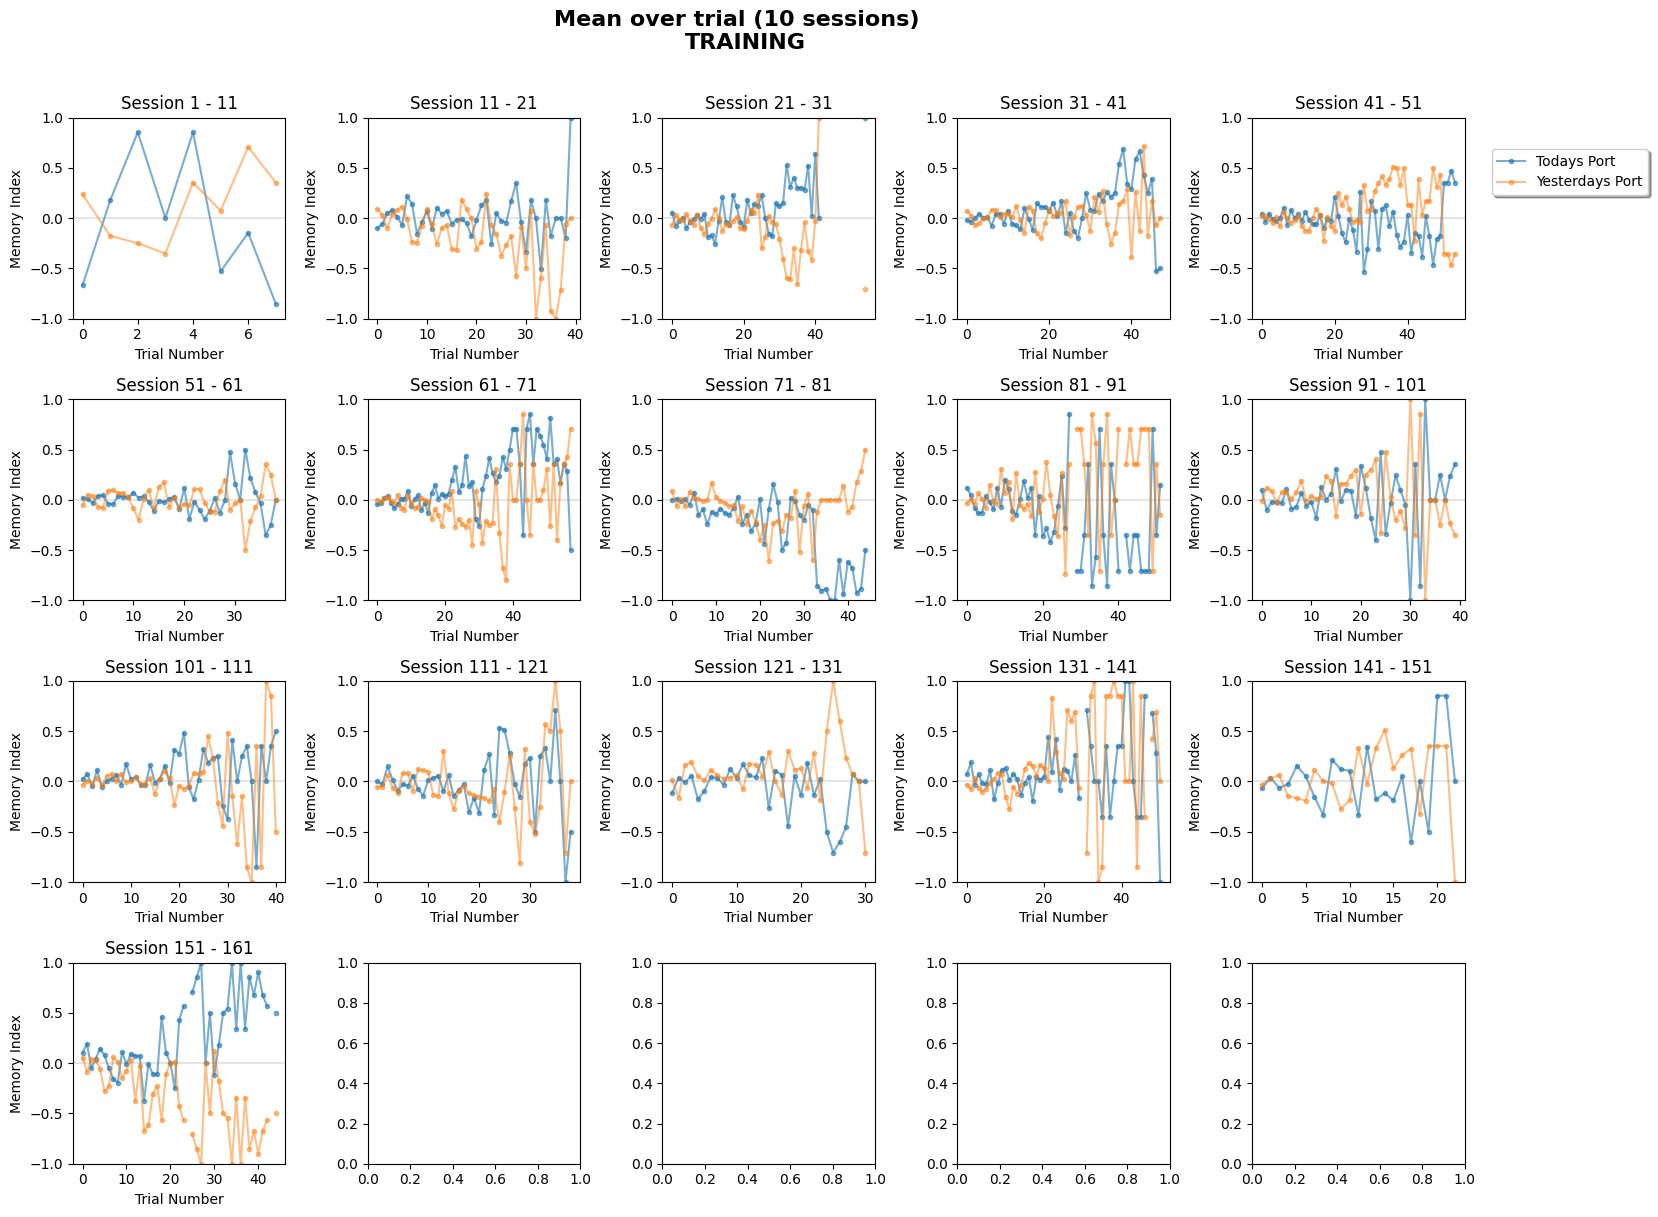

In [ ]:
## PLOTTING BY SESSION
num_columns = 5
n = (MItrl_lags.shape[1]/10) // num_columns

# Find the indices of non-empty subplots
non_empty_indices = [i for i in range(0,MItrl_lags.shape[1],10) if not np.isnan(MItrl_lags[:,i:i+10]).all()]

# Calculate the new number of rows based on non-empty subplots
n_rows = len(non_empty_indices) // num_columns + int(len(non_empty_indices) % num_columns != 0)

# Create a figure and an array of subplots
fig, axs = plt.subplots(n_rows, num_columns, figsize=(15, 3 * n_rows))

for i, idx in enumerate(non_empty_indices):
    # print(i, idx)
    row_idx, col_idx = divmod(i, num_columns)
    axs[row_idx, col_idx].plot((np.nanmean(np.nanmean(MItrl[:,idx:idx+10],axis=1),axis=0)), '.-' ,alpha=0.6 ,label='Todays Port')
    axs[row_idx, col_idx].plot((np.nanmean(np.nanmean(MItrl_lags[:,idx:idx+10],axis=1),axis=0)), '.-' , alpha=0.5 ,label='Yesterdays Port')
    axs[row_idx, col_idx].axhline(0, color='grey', alpha=0.2)
    axs[row_idx, col_idx].set_title(f'Session {idx + 1} - {idx+10 + 1}')
    axs[row_idx, col_idx].set_ylim(-1, 1)
    axs[row_idx, col_idx].set_ylabel('Memory Index')
    axs[row_idx, col_idx].set_xlabel('Trial Number')

fig.legend(loc='upper center', bbox_to_anchor=(1.05, .9), fancybox=True, shadow=True, labels=['Todays Port', 'Yesterdays Port'])


# Adjust layout to prevent clipping of titles
fig.suptitle('Mean over trial (10 sessions)  \nTRAINING', x=0.5, y=1.01, fontweight='bold', fontsize=16)
fig.tight_layout()
# Show the figure
plt.show()

# Cleaning and extracting variables from Raw Data: REC

In [ ]:
def CleaningRawDataset_REC(DrugType='CONTROL', FlagforSessions='CONTROL'):
  pathData= '/content/gdrive/MyDrive/Data8port/'
  fileName1='Output_8PortMazeAnalAVerRecallAllAnimals8Batch.mat'
  fileName2='Output_8PortMazeAnalAVerRecallAllAnimals9Batch.mat'
  fileName3='Output_8PortMazeAnalAVerRecallAllAnimals11Batch.mat'
  # Load data from files
  S = [scipy.io.loadmat(pathData + fileName) for fileName in [fileName1, fileName2, fileName3]]
  # Parameters
  StaMin = 3
  StaMax = 3
  MinNumTrials = 1

  if DrugType=='CONTROL':
    DrugType=[0, 1, 3, 5, 8, 9, 7] ##CONTROL or non infused
  if DrugType=='NMDA':
    DrugType=[6, 10]  ## anti_NMDAR infused animals
  if DrugType=='LGI1':
    DrugType=[11]   ## anti_LGI1 infused animals


  X = []
  ALL_FirstTrlWWater_REC=[]
  ALL_FirstTrlWaterAvai_REC=[]
  ALL_portsPoked_REC = []
  ALL_OnlyCorrectPortsPoked_REC = []
  ALL_IntTrialportsPoked_REC = []
  ALL_PORTS_REC =[]
  WATER = []
  CP = []

  # Loop over batches
  for bb in range(len(S)):
      if bb == 0:
        if FlagforSessions=='CONTROL':
          YearStart, MonthStart, DayStart = 2019, 10, 21 # This is the real original start
          YearEnd, MonthEnd, DayEnd = 2020, 12, 31 # This is the real original end
          # ## HIGH PERFORMERS
        if FlagforSessions=='NMDA':
          YearStart, MonthStart, DayStart = 2020, 1, 11 #24 days before the NMDA infusion period
          YearEnd, MonthEnd, DayEnd =   2020, 3, 8 # Day of NMDA end
                  # ## HIGH PERFORMERS
        if FlagforSessions=='LGI1':
          YearStart, MonthStart, DayStart = 2020, 6, 12 #15 days before LGI1
          YearEnd, MonthEnd, DayEnd = 2020, 7, 17 #Day After LGI1

      elif bb == 1:
        if FlagforSessions=='CONTROL':
          YearStart, MonthStart, DayStart = 2021, 1, 1 # This is the real original start
          YearEnd, MonthEnd, DayEnd = 2021, 7, 12 # This is the real original end
          ## HIGH PERFORMERS
        if FlagforSessions=='NMDA':
          YearStart, MonthStart, DayStart = 2021, 3, 26# 2021, 4, 12
          YearEnd, MonthEnd, DayEnd = 2021, 5, 19 #2021, 6, 2

        if FlagforSessions=='LGI1':
          YearStart, MonthStart, DayStart = 2021, 5, 24
          YearEnd, MonthEnd, DayEnd = 2021, 6, 24


      elif bb == 2:
        if FlagforSessions=='CONTROL':
          YearStart, MonthStart, DayStart = 2022, 1, 13# This is the real original start
          YearEnd, MonthEnd, DayEnd = 2022, 12, 31 # This is the real original end
        # ## HIGH PERFORMERS
        if FlagforSessions=='NMDA':
          YearStart, MonthStart, DayStart = 2022, 4, 8
          YearEnd, MonthEnd, DayEnd = 2022, 5, 5

        if FlagforSessions=='LGI1':
          YearStart, MonthStart, DayStart = 2022, 4, 8
          YearEnd, MonthEnd, DayEnd = 2022, 4, 25


      YearStart_str = str(YearStart)
      MonthStart_str = str(MonthStart).zfill(2)
      DayStart_str = str(DayStart).zfill(2)
      YearEnd_str = str(YearEnd)
      MonthEnd_str = str(MonthEnd).zfill(2)
      DayEnd_str = str(DayEnd).zfill(2)

      start_date = np.datetime64(f'{YearStart_str}-{MonthStart_str}-{DayStart_str}')
      end_date = np.datetime64(f'{YearEnd_str}-{MonthEnd_str}-{DayEnd_str}')

      Nanimals = S[bb]['CorrectPortPOSTG'].shape[0]
      Nsess = S[bb]['CorrectPortPOSTG'].shape[1]

      anim_portsPoked = np.full((Nanimals,157,56) ,np.nan, dtype=object)
      anim_FirstTrlWWater=np.full((Nanimals,157),np.nan, dtype=object)
      anim_FirstTrlWaterAvai=np.full((Nanimals, 157),np.nan, dtype=object)
      anim_OnlyCorrectPortsPoked = []
      anim_IntTrialportsPoked = []
      anim_PORTS =np.full((Nanimals,157), 0)
      anim_WATER = []

      for aa in range(Nanimals):
          sess_portsPoked = np.full((157,56) ,np.nan, dtype=object)

          sess_OnlyCorrectPortsPoked = []
          sess_IntTrialportsPoked = []
          sess_PORTS = np.full(157 ,0, dtype=object)
          sess_WATER = []
          FirstTrlWWater=np.full(157,np.nan, dtype=object)
          FirstTrlWaterAvai=np.full(157,np.nan, dtype=object)

          for sess in range(Nsess):
              # print('Sess: ', sess)
              # Initialize session containers
              waterAvail = []
              portsPoked = np.full(56, np.nan,dtype=object)
              OnlyCorrectPortsPoked = []
              IntTrialportsPoked = []
              k = 0

              if not np.shape(S[bb]['POSTWaterAvailabilityPerAnimalSess'][aa][sess]) == (1, 0):
                  vec_day = S[bb]['ExpDay'][aa, sess, :].squeeze()
                  VecDay = np.datetime64(f'{vec_day[0]:04d}-{vec_day[1]:02d}-{vec_day[2]:02d}', 'D')
                  IN = 0

              if start_date <= VecDay <= end_date:
                  IN = 1

              if S[bb]['AllAnimalsSessTrialsPOSTCorrectTrialRT'][aa, sess][0].all():
                  if not S[bb]['AllAnimalsSessTrialsPOSTCorrectTrialRT'][aa, sess][0].all():
                      IN = 0
                  if MinNumTrials <= S[bb]['AllAnimalsSessTrialsPOSTCorrectTrialRT'][aa, sess].shape[1] and \
                          S[bb]['ExpParams'][aa, sess] is not None:
                      if StaMin <= S[bb]['ExpParams'][aa, sess][0][0] <= StaMax and IN == 1 and \
                              any((S[bb]['ExpParams'][aa, sess][0][1] - DrugType) == 0):
                          sess_PORTS[sess]=np.array(S[bb]['CorrectPortPOSTG'][aa, sess])
                          nw = 1
                          for i in range(len(S[bb]['AllAnimalsSessTrialsPOSTIncorrPortLicked'][aa, sess][0])):
                              if S[bb]['AllAnimalsSessTrialsPOSTIncorrPortLicked'][aa, sess][0][i][0].all():
                                  nw += 1
                          for t in range(water_availability(S[bb]['POSTWaterAvailabilityPerAnimalSess'][aa, sess])):

                              if not np.isnan(S[bb]['AllAnimalsSessTrialsPOSTCorrectTrialRT'][aa, sess][0][t]) and \
                                      np.size(S[bb]['AllAnimalsSessTrialsPOSTIncorrPortLicked'][aa, sess][0][t]!=0):
                                  portsPoked[t]=np.concatenate([S[bb]['AllAnimalsSessTrialsPOSTIncorrPortLicked'][aa, sess][0][t][0].astype(float), np.array([S[bb]['CorrectPortPOSTG'][aa, sess].astype(float)])])
                              else:
                                  if not np.isnan(S[bb]['AllAnimalsSessTrialsPOSTCorrectTrialRT'][aa, sess][0][t]):
                                      portsPoked[t]=np.array([S[bb]['CorrectPortPOSTG'][aa, sess]], dtype=float)
                                      OnlyCorrectPortsPoked.append(S[bb]['CorrectPortPOSTG'][aa, sess].astype(float))
                                  if np.size(S[bb]['AllAnimalsSessTrialsPOSTIncorrPortLicked'][aa, sess][0][t]!=0):
                                      portsPoked[t]=np.array(S[bb]['AllAnimalsSessTrialsPOSTIncorrPortLicked'][aa, sess][0][t][0].astype(float))
                                  if S[bb]['AllAnimalsSessTrialsPOSTErrorLickPortInd'][aa, sess][0][t][0].all():
                                      IntTrialportsPoked.extend(
                                          S[bb]['AllAnimalsSessTrialsPOSTErrorLickPortInd'][aa, sess][0][t])

              # ANIMALS VARIABLES APPENDING
              sess_portsPoked[sess]=np.array(portsPoked)
              sess_OnlyCorrectPortsPoked.append(np.array(OnlyCorrectPortsPoked))
              sess_IntTrialportsPoked.append(IntTrialportsPoked)
              # sess_PORTS[sess]=np.array(S[bb]['CorrectPortPOSTG'][aa, sess])

          # Session VARIABLES APPENDING
          anim_portsPoked[aa]=np.array(sess_portsPoked)
          anim_FirstTrlWWater[aa]=np.array(FirstTrlWWater)
          anim_FirstTrlWaterAvai[aa]=np.array(FirstTrlWaterAvai)
          anim_OnlyCorrectPortsPoked.append(sess_OnlyCorrectPortsPoked)
          anim_IntTrialportsPoked.append(sess_IntTrialportsPoked)
          anim_PORTS[aa]=np.array(sess_PORTS)

      # ALL VARIABLES APPENDING

      ALL_portsPoked_REC.extend(anim_portsPoked)
      ALL_FirstTrlWaterAvai_REC.extend(np.array(anim_FirstTrlWaterAvai))
      ALL_FirstTrlWWater_REC.extend(np.array(anim_FirstTrlWWater))
      # ALL_OnlyCorrectPortsPoked_REC.append(np.array(anim_OnlyCorrectPortsPoked))
      # ALL_IntTrialportsPoked_REC.append(np.array(anim_IntTrialportsPoked))#np.array(anim_IntTrialportsPoked))
      ALL_PORTS_REC.extend(np.array(anim_PORTS))
  return ALL_portsPoked_REC, ALL_PORTS_REC

In [ ]:
ALL_portsPoked_REC=CleaningRawDataset_REC(DT)[0]
ALL_PORTS_REC=CleaningRawDataset_REC(DT)[1]

In [ ]:
ALL_portsPoked_REC_NMDA=CleaningRawDataset_REC(DTNMDA)[0]
ALL_PORTS_REC_NMDA=CleaningRawDataset_REC(DTNMDA)[1]

## Creating the HIST_ALL RECALL

In [ ]:
def hist_all(port_seq, ports_poked,NumTrials):
  # ADJUSTING THE ARRAYS TO CREATE MATRIX
  AngRad_dict = {1: np.pi/4, 2: 0, 3: -np.pi/4, 4: -np.pi/2, 5: -3*np.pi/4, 6: np.pi, 7: 3*np.pi/4, 8: np.pi/2}
  cosAng = np.cos([np.pi/4, 0, -np.pi/4, -np.pi/2, -3/4*np.pi, np.pi, 3/4*np.pi, np.pi/2])
  ALL_portsPoked_3D_arr_REC=np.array(ports_poked)
  max_length_nested_arrays=np.shape(ports_poked)[2]
  port_seq_REC=np.array(port_seq)
  # HIST SEQUENCE
  hist_all_REC=[]
  for aa in range(len(ALL_portsPoked_3D_arr_REC)):
    hist_anim_REC=[]
    for s, sess in enumerate(ALL_portsPoked_3D_arr_REC [aa]):
        hist_sess_REC=[]
        for trl in range(NumTrials):
          if np.shape(ALL_portsPoked_3D_arr_REC [aa,s,trl])==() or  np.shape(ALL_portsPoked_3D_arr_REC [aa,s,trl])==(0,):
            hist_sess_REC.append(np.array([0 for _ in range(8)]))
          else:
            filtered_pokes = np.array(np.hstack(ALL_portsPoked_3D_arr_REC [aa,s,trl]).tolist())
            port_counts = Counter(filtered_pokes)
            hist_sess_REC.append(np.array([port_counts[port] for port in AngRad_dict]))
        hist_anim_REC.append(hist_sess_REC)
    hist_all_REC.append(np.array(hist_anim_REC))

  hist_all_REC_arr=np.array(hist_all_REC)
  return hist_all_REC_arr

In [ ]:
hist_all_REC_arr=hist_all(ALL_PORTS_REC, ALL_portsPoked_REC)
hist_all_REC_arr_NMDA=hist_all(ALL_PORTS_REC_NMDA, ALL_portsPoked_REC_NMDA)

In [ ]:
AngRad_dict = {1: np.pi/4, 2: 0, 3: -np.pi/4, 4: -np.pi/2, 5: -3*np.pi/4, 6: np.pi, 7: 3*np.pi/4, 8: np.pi/2}
cosAng = np.cos([np.pi/4, 0, -np.pi/4, -np.pi/2, -3/4*np.pi, np.pi, 3/4*np.pi, np.pi/2])
NumTrials=35
##CONTROL
hist_all_REC_arr=hist_all(ALL_PORTS_REC, ALL_portsPoked_REC, NumTrials)
port_seq_REC=ALL_PORTS_REC

## Adding zeros to those sessions where an animal didn't do anything (hist_all=0)
New_port_seq_REC_arr=np.array([[port_seq_REC[aa][ss] if not np.sum(hist_all_REC_arr[aa][ss])==0 else 0 for ss in range(len(port_seq_REC[aa])) ]for aa in range(len(port_seq_REC))])

Yesterdays_port_seq_REC=np.roll(New_port_seq_REC_arr, 1)
# Ports_Seq_Rad=np.array([np.array([AngRad_dict[port_seq_REC[aa][ss]]  if port_seq_REC[aa][ss]!=0 else 0 for ss in range(len(port_seq_REC[aa])) ])for aa in range(len(port_seq_REC))])

MIbyTrl=np.full(np.shape(hist_all_REC_arr)[:3], np.nan)
for aa in range(len(hist_all_REC_arr)):
  for ss in range(len(hist_all_REC_arr[aa])):
    for trl in range(len(hist_all_REC_arr[aa][ss])):
      MIbyTrl[aa, ss, trl]=MemoryIndexbyTrl(hist_all_REC_arr[aa][ss][trl], New_port_seq_REC_arr[aa][ss])

# Regular Memory Index - REC- All Sessions all animals

In [ ]:
hist_REC=np.nansum(hist_all_REC_arr, axis=2)
New_port_seq_REC=[[port_seq_REC[aa][ss] if not (np.sum(hist_all_REC_arr[aa][ss])==0 and np.sum(hist_all_REC_arr[aa][ss])==0) else 0 for ss in range(len(port_seq_REC[aa])) ]for aa in range(len(port_seq_REC))]
New_port_seq_REC_arr=np.array(New_port_seq_REC)


## Creating collapsed datasets
NON_0_port_seq_REC=[New_port_seq_REC_arr[aa][New_port_seq_REC_arr[aa]!=0] for aa in range(len(port_seq_REC))]
NON_0_hist_seq_REC=[hist_REC[aa][New_port_seq_REC_arr[aa]!=0] for aa in range(len(port_seq_REC))]

# hist_REC=np.nansum(hist_all_REC_arr, axis=2)
MIs_REC=np.nanmean(np.concatenate([MemoryIndex(NON_0_hist_seq_REC[aa], NON_0_port_seq_REC[aa]) for aa in range(len(NON_0_hist_seq_REC))]))
MIs_REC_std=np.nanstd(np.concatenate([MemoryIndex(NON_0_hist_seq_REC[aa], NON_0_port_seq_REC[aa]) for aa in range(len(NON_0_hist_seq_REC))]))
MIs_REC_sem=MIs_REC_std/np.sqrt(len(~np.isnan(np.concatenate([MemoryIndex(NON_0_hist_seq_REC[aa], NON_0_port_seq_REC[aa]) for aa in range(len(NON_0_hist_seq_REC))]))))
MIsLag_REC=np.nanmean(np.concatenate([MemoryIndexLag(NON_0_hist_seq_REC[aa], NON_0_port_seq_REC[aa]) for aa in range(len(NON_0_hist_seq_REC))]))
MIsLag_REC_std=np.nanstd(np.concatenate([MemoryIndexLag(NON_0_hist_seq_REC[aa], NON_0_port_seq_REC[aa]) for aa in range(len(NON_0_hist_seq_REC))]))
MIsLag_REC_sem=MIsLag_REC_std/np.sqrt(len(~np.isnan(np.concatenate([MemoryIndexLag(NON_0_hist_seq_REC[aa], NON_0_port_seq_REC[aa]) for aa in range(len(NON_0_hist_seq_REC))]))))

print('Memory Index Today CONTROL: ', MIs_REC, 'Memory Index Yesterday CONTROL: ', MIsLag_REC )

# MIs_REC_NMDA=np.nanmean(np.concatenate([MemoryIndex(NON_0_hist_seq_REC[aa], NON_0_port_seq_REC[aa]) for aa in range(len(NON_0_hist_seq_REC))]))
# MIs_REC_std_NMDA=np.nanstd(np.concatenate([MemoryIndex(NON_0_hist_seq_REC[aa], NON_0_port_seq_REC[aa]) for aa in range(len(NON_0_hist_seq_REC))]))
# MIs_REC_sem_NMDA=MIs_REC_std/np.sqrt(len(~np.isnan(np.concatenate([MemoryIndex(NON_0_hist_seq_REC[aa], NON_0_port_seq_REC[aa]) for aa in range(len(NON_0_hist_seq_REC))]))))
# MIsLag_REC_NMDA=np.nanmean(np.concatenate([MemoryIndexLag(NON_0_hist_seq_REC[aa], NON_0_port_seq_REC[aa]) for aa in range(len(NON_0_hist_seq_REC))]))
# MIsLag_REC_std_NMDA=np.nanstd(np.concatenate([MemoryIndexLag(NON_0_hist_seq_REC[aa], NON_0_port_seq_REC[aa]) for aa in range(len(NON_0_hist_seq_REC))]))
# MIsLag_REC_sem_NMDA=MIsLag_REC_std/np.sqrt(len(~np.isnan(np.concatenate([MemoryIndexLag(NON_0_hist_seq_REC[aa], NON_0_port_seq_REC[aa]) for aa in range(len(NON_0_hist_seq_REC))]))))

# print('Memory Index Today NMDA: ', MIs_REC_NMDA, 'Memory Index Yesterday NMDA: ', MIsLag_REC_NMDA )

Memory Index Today CONTROL:  0.24300547638677372 Memory Index Yesterday CONTROL:  -0.002118357636562872


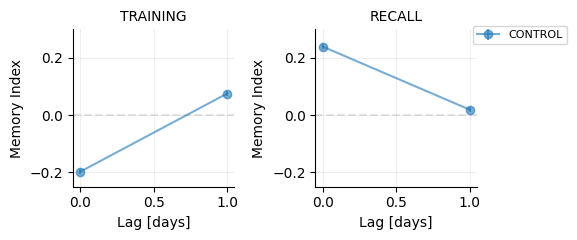

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(5, 2.5))

axs[0].errorbar([0,1],[MIs, MIsLag],yerr=[MIs_sem,MIsLag_sem ], fmt='o-' , alpha=0.6)#, label='CONTROL')
# axs[0].errorbar([0,1],[MIs_NMDA, MIsLag_NMDA],yerr=[MIs_sem_NMDA,MIsLag_sem_NMDA ], fmt='o-',color='tab:red' , alpha=0.6,  label='NMDA')
axs[0].axhline(0,linestyle='--' ,color='grey', alpha=0.2)
axs[0].set_ylim(-.25, .3)
axs[0].set_xlabel('Lag [days]')
axs[0].set_ylabel('Memory Index')
axs[0].grid(True, alpha=0.2)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].set_title('TRAINING', fontsize=10)
# axs[0].set_aspect('equal', adjustable='box')


# axs[1].errorbar([0,1],[MIs_REC_NMDA, MIsLag_REC_NMDA],yerr=[MIs_REC_sem_NMDA,MIsLag_REC_sem_NMDA ], fmt='o-',color='tab:red' , alpha=0.6,  label='NMDA')
axs[1].errorbar([0,1],[MIs_REC, MIsLag_REC],yerr=[MIs_REC_sem,MIsLag_REC_sem ], fmt='o-' , color='tab:blue',alpha=0.6, label='CONTROL')
axs[1].axhline(0,linestyle='--' ,color='grey', alpha=0.2)
axs[1].set_ylim(-.25, .3)
# axs[1].set_yticklabels(labels=,fontsize=10)
axs[1].set_xlabel('Lag [days]')
axs[1].set_ylabel('Memory Index')
axs[1].grid(True, alpha=0.2)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].set_title('RECALL', fontsize=10)
# axs[1].set_aspect('equal', adjustable='box')
# plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)  # Ajuste de la figura

fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(1.05, .9), fontsize=8)

## Surrogates REC

In [ ]:
# Nshuffles=5
# MI_shuff_rec=[]
# for n in range(Nshuffles):
#   MI_surr_rec=[surrogates(NON_0_hist_seq_REC, NON_0_port_seq_REC, trl) for trl in range(len(NON_0_hist_seq_REC[0][0]))]
#   MI_shuff_rec.append(np.array(MI_surr_rec))

# MIShuffRec=np.array(MI_shuff_rec)

# # folder = "/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/"
# # file_name = "Shuffle_rec.csv"
# # np.savetxt(folder + file_name, MIShuffRec, delimiter=",")

In [ ]:
# ruta_archivo = "/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_rec.csv"
# # data = np.loadtxt(ruta_archivo, delimiter=",") # Read the CSV with np.loadtxt
# MIShuffRec = np.genfromtxt(ruta_archivo, delimiter=",") # Read the CSV with np.genfromtxt if the data is fragmented
# np.shape(data)

<ipython-input-48-410af820357b>:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(-np.array([65,55,45,35, 25, 15, 5]))
<ipython-input-48-410af820357b>:89: RuntimeWarning: Mean of empty slice
  axs[1].errorbar(indexes, np.nanmean(MItrl_list_REC, axis=0), yerr=sem_MItrl_list_REC ,fmt='.-' ,alpha=0.6 ,label='Todays Port')
<ipython-input-48-410af820357b>:90: RuntimeWarning: Mean of empty slice
  axs[1].errorbar(indexes, np.nanmean(MItrl_lags_list_REC, axis=0),yerr=sem_MItrl_lags_list_REC, fmt='.-' ,alpha=0.6 ,label='Yesterdays Port')


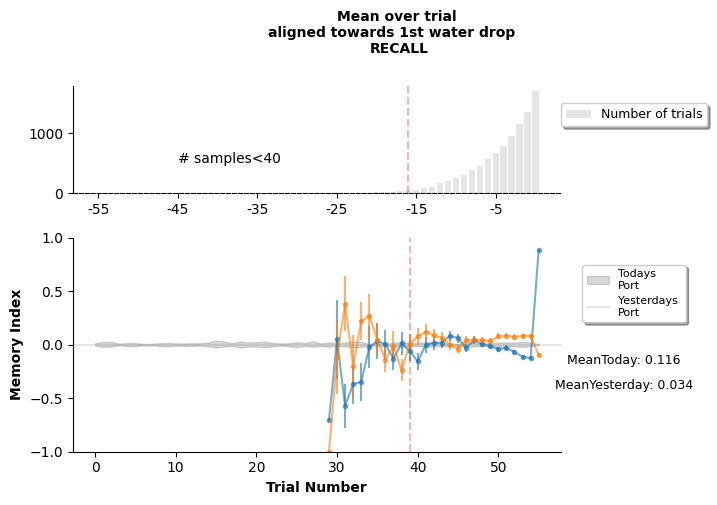

In [ ]:
# Número de animales y sesiones
num_anim_REC = MItrl_REC.shape[0]
lengthsMI=[len(MItrl_REC[aa]) for aa in range(len(MItrl_REC))]
MItrl_REC_ =np.full((len(MItrl_REC), max(lengthsMI), 56), np.nan)

# loop over animal and session
for aa in range(num_anim_REC):
    for sess in range(1,lengthsMI[aa]):
        # Find the last index of the last 'real value' not a NaN if not use 0
        indexes_no_nan = np.where(~np.isnan(np.array(MItrl_REC[aa][sess]).astype(float)))[0]
        last_index_no_nan = indexes_no_nan[-1] if indexes_no_nan.size > 0 else 0

        # apply np.roll to align the last non-NaN value as the last value of the array
        MItrl_REC_[aa, sess] = np.roll(np.array(MItrl_REC[aa][sess]), -last_index_no_nan-1)


#  Create a new array to store the results
num_anim_REC_lags = MItrl_lags_REC.shape[0]
lengths=[len(MIs_lag_REC[aa]) for aa in range(len(MIs_lag_REC))]
MItrl_lags_REC_ =np.full((len(MIs_lag_REC), max(lengths), 56), np.nan)


# loop over animal and session
for aa in range(num_anim_REC_lags):
    # print('Animal: ', aa)
    for sess in range(1,lengths[aa]):
        # Find the last index of the last 'real value' not a NaN if not use 0
        indices_no_nan = np.where(~np.isnan(np.array(MItrl_lags_REC[aa][sess]).astype(float)))[0]
        # print(indices_no_nan)
        ultimo_indice_no_nan = indices_no_nan[-1] if np.size(indices_no_nan) > 0 else 0

        # apply np.roll to align the last non-NaN value as the last value of the array
        MItrl_lags_REC_[aa,sess] = np.roll(np.array(MItrl_lags_REC[aa][sess]), -ultimo_indice_no_nan-1)

MItrl_list_REC = MItrl_REC_.reshape(-1, MItrl_REC_.shape[2]).tolist()
MItrl_lags_list_REC = MItrl_lags_REC_.reshape(-1, MItrl_lags_REC_.shape[2]).tolist()


### COMPUTING THE 95 AND 5 PERCENTILES
MItrl_list_REC_arr=np.array(MItrl_list_REC)
MItrl_REC_arr_non_nan=[MItrl_list_REC_arr[:,trl][~np.isnan(MItrl_list_REC_arr[:,trl])] for trl in range(np.shape(MItrl_list_REC_arr)[1])]
confidence_interval_REC =[np.array([np.nan, np.nan]) if np.size(MItrl_REC_arr_non_nan[trl])==0 else np.percentile(MItrl_REC_arr_non_nan[trl], [0.95, 0.05])
                                for trl in range(np.shape(MItrl_list_REC_arr)[1])]
arr_REC_confidence=np.array(confidence_interval_REC)

MItrl_lags_REC_arr=np.array(MItrl_lags_list_REC)
MItrl_lags_REC_non_nan=[MItrl_lags_REC_arr[:,trl][~np.isnan(MItrl_lags_REC_arr[:,trl])] for trl in range(np.shape(MItrl_lags_REC_arr)[1])]
confidence_interval_REC_lags =[np.array([np.nan, np.nan]) if np.size(MItrl_lags_REC_non_nan[trl])==0 else np.percentile(MItrl_lags_REC_non_nan[trl], [0.95, 0.05])
                            for trl in range(np.shape(MItrl_lags_REC_arr)[1])]
arr_confidence_REC_lags=np.array(confidence_interval_REC_lags)

#Confidence_interval
MI_ShuffRec=np.array(MIShuffRec)

CI95=np.array([np.percentile(MI_ShuffRec[trl], [0.95, 0.05]) for trl in range(np.shape(MI_ShuffRec)[1])])
revCI95=np.roll(CI95, len(CI95), axis=0)[::-1]
CI99=np.array([np.percentile(MI_ShuffRec[trl], [0.99, 0.01]) for trl in range(np.shape(MI_ShuffRec)[1])])
revCI99=np.roll(CI99, len(CI99), axis=0)[::-1]


## Number of trials
n_trials=[]
for i in range(np.shape(MItrl_list_REC)[1]):
  x=np.array(MItrl_list_REC)[:,i]
  n_trials.append(len(x[~np.isnan(x)]))
x=np.array([t if trial>40 else np.nan for t,trial in enumerate(n_trials)])



## PLOTTING BY SESSION
# Create a figure and an array of subplots
fig, axs = plt.subplots(2,1, figsize=(7.5, 5),  gridspec_kw={'height_ratios': [1, 2]})
indexes = np.arange(len(n_trials))
## SEM computation
sem_MItrl_list_REC = np.nanstd(MItrl_list_REC, axis=0) / np.sqrt(np.sum(~np.isnan(MItrl_list_REC), axis=0))
sem_MItrl_lags_list_REC =  np.nanstd(MItrl_lags_list_REC, axis=0) / np.sqrt(np.sum(~np.isnan(MItrl_lags_list_REC), axis=0))

#plot
axs[0].bar(indexes, n_trials, color='grey', alpha=0.2, label='Number of trials')
axs[0].set_xticklabels(-np.array([65,55,45,35, 25, 15, 5]))
axs[0].axvline(x[~np.isnan(x)].astype(int)[0], color='red',  alpha=0.3, linestyle='--')
axs[0].annotate('# samples<40', xy=(10, 500))
axs[0].legend(loc='upper center', bbox_to_anchor=(1.15, .9), fancybox=True, shadow=True,  fontsize=9)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_linestyle('dashed')
axs[0].spines['top'].set_visible(False)

axs[1].fill_between(indexes, np.nanmean(MI_ShuffRec, axis=0)+revCI99[:,0], np.nanmean(MI_ShuffRec, axis=0)-revCI99[:,1],color='grey' , alpha=0.3 ,label='Mean Surrogates')
axs[1].errorbar(indexes, np.nanmean(MItrl_list_REC, axis=0), yerr=sem_MItrl_list_REC ,fmt='.-' ,alpha=0.6 ,label='Todays Port')
axs[1].errorbar(indexes, np.nanmean(MItrl_lags_list_REC, axis=0),yerr=sem_MItrl_lags_list_REC, fmt='.-' ,alpha=0.6 ,label='Yesterdays Port')
# axs[1].fill_between(indexes,np.nanmean(MItrl_list_REC, axis=0)-arr_REC_confidence[:,0],  np.nanmean(MItrl_list_REC, axis=0)+arr_REC_confidence[:,1],  color='tab:blue', alpha=0.2)
# axs.fill_between(indexes,np.nanmean(MItrl_list, axis=0)-sem_MItrl_list,  np.nanmean(MItrl_list, axis=0)+sem_MItrl_list,  color='tab:blue', alpha=0.2)
# axs[1].fill_between(indexes,np.nanmean(MItrl_lags_list_REC, axis=0)-arr_confidence_REC_lags[:,0],  np.nanmean(MItrl_lags_list_REC, axis=0)+arr_confidence_REC_lags[:,1],  color='orange', alpha=0.2, label='YesterdaysPort')
# axs[1].fill_between(indexes,np.nanmean(MItrl_lags_list_REC, axis=0)-np.nanstd(MItrl_lags_list_REC, axis=0),  np.nanmean(MItrl_lags_list_REC, axis=0)+np.nanstd(MItrl_lags_list_REC, axis=0),  color='orange', alpha=0.2, label='YesterdaysPort')
# axs.fill_between(indexes,np.nanmean(np.nanmean(MItrl_lags_list, axis=1), axis=0)-sem_MItrl_lags_list , np.nanmean(np.nanmean(MItrl_lags_, axis=1), axis=0)+sem_MItrl_lags_list, color='orange', alpha=0.2 )
axs[1].axhline(0, color='grey', alpha=0.2)
axs[1].axvline(x[~np.isnan(x)].astype(int)[0], color='red',  alpha=0.3, linestyle='--')
axs[1].set_ylim(-1, 1)
# axs.set_xlim(-5,0)
# axs[1].set_xticklabels(-np.array([65,55,45,35, 25, 15, 5, 0]))
axs[1].set_ylabel('Memory Index', fontweight='bold')
axs[1].set_xlabel('Trial Number', fontweight='bold')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].legend(loc='upper center', bbox_to_anchor=(1.15, .9), fancybox=True, shadow=True, labels=['Todays \nPort', 'Yesterdays \nPort'], fontsize=8)

fig.text( 0.85,0.30, f'MeanToday: {round(np.nanmean(MItrl_list_REC),3)}', ha='center', va='center', fontsize=9)#, bbox=dict(facecolor='tab:blue', alpha=0.1))
fig.text( 0.85,0.25, f'MeanYesterday: {round(np.nanmean(MItrl_lags_list_REC),3)}', ha='center', va='center', fontsize=9)#, bbox=dict(facecolor='tab:orange', alpha=0.1))


# axs.annotate(f'MeanYesterday: {round(np.nanmean(MItrl_lags_list_REC),3)}', xy=(25, 0.6), fontsize=10, bbox=dict(facecolor='white', alpha=0.5), transform=plt.gcf().transFigure)
# axs.annotate(f'MeanToday: {round(np.nanmean(MItrl_list_REC),3)}', xy=(25, -0.6), fontsize=10, bbox=dict(facecolor='white', alpha=0.5 ),  transform=plt.gcf().transFigure)

# Adjust layout to prevent clipping of titles
fig.suptitle('Mean over trial \naligned towards 1st water drop   \nRECALL', x=0.55, y=1.0001, fontweight='bold', fontsize=10)
fig.tight_layout()
# Show the figure
plt.show()

# DISTANCE-REC

In [ ]:
New_port_seq_REC=[[port_seq_REC[aa][ss] if not (np.sum(hist_all_REC_arr[aa][ss])==0 and np.sum(hist_all_REC_arr[aa][ss])==0) else 0 for ss in range(len(port_seq_REC[aa])) ]for aa in range(len(port_seq_REC))]
New_port_seq_REC_arr=np.array(New_port_seq_REC)

## Creating collapsed datasets
NON_0_port_seq_REC=[New_port_seq_REC_arr[aa][New_port_seq_REC_arr[aa]!=0] for aa in range(len(port_seq_REC))]
NON_0_hist_seq_REC=[hist_all_REC_arr[aa][New_port_seq_REC_arr[aa]!=0] for aa in range(len(port_seq_REC))]
hist_REC=np.nansum(hist_all_REC_arr, axis=2)

Yesterdays_port_seq_REC=np.roll(port_seq_REC, 1)
Ports_Seq_Rad=np.array([np.array([AngRad_dict[port_seq_REC[aa][ss]]  if port_seq_REC[aa][ss]!=0 else 0 for ss in range(len(port_seq_REC[aa])) ])for aa in range(len(port_seq_REC))])
New_port_seq_REC=[[port_seq_REC[aa][ss] if not (np.sum(hist_all_REC_arr[aa][ss])==0 and np.sum(hist_all_REC_arr[aa][ss])==0) else 0 for ss in range(len(port_seq_REC[aa])) ]for aa in range(len(port_seq_REC))]
New_port_seq_REC_arr=np.array(New_port_seq_REC)


## Creating collapsed datasets
NON_0_port_seq_REC=[New_port_seq_REC_arr[aa][New_port_seq_REC_arr[aa]!=0] for aa in range(len(port_seq_REC))]
NON_0_hist_seq_REC=[hist_REC[aa][New_port_seq_REC_arr[aa]!=0] for aa in range(len(port_seq_REC))]
NON_0_Yesterdays_port_seq_REC=[Yesterdays_port_seq_REC[aa][New_port_seq_REC_arr[aa]!=0] for aa in range(len(port_seq_REC))]
NON_0_Ports_Seq_Rad=[Ports_Seq_Rad[aa][New_port_seq_REC_arr[aa]!=0] for aa in range(len(port_seq_REC))]

# Ports_Seq_Rad=[[AngRad_dict[NON_0_port_seq_REC[aa][ss]] for ss in range(len(NON_0_port_seq_REC[aa])) ]for aa in range(len(NON_0_port_seq_REC))]
lengths_sess=max([len(NON_0_hist_seq_REC[i]) for i in range(len(NON_0_port_seq_REC))])
distance_seq_REC=[]
for aa in range(len(NON_0_port_seq_REC)):
  distance_seq_REC_sess=[]
  for ss in range(len(NON_0_port_seq_REC[aa])):
    distance_seq_REC_sess.append(circular_distance(NON_0_Ports_Seq_Rad[aa][ss],NON_0_Ports_Seq_Rad[aa][ss-1])*8/(2*np.pi))
  distance_seq_REC.append(distance_seq_REC_sess)

In [ ]:
# Ports_Seq_Rad=[[AngRad_dict[NON_0_port_seq_REC[aa][ss]] for ss in range(len(NON_0_port_seq_REC[aa])) ]for aa in range(len(NON_0_port_seq_REC))]
# lengths_sess=max([len(NON_0_hist_seq_REC[i]) for i in range(len(NON_0_port_seq_REC))])
# # distance_Seq_REC[aa,ss]=circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1])*8/(2*np.pi)

# distance_Seq_REC=np.full((50,lengths_sess),np.nan)

# MItrl_REC_0=np.full((50,lengths_sess,56),np.nan)
# MItrl_REC_1=np.full((50,lengths_sess,56),np.nan)
# MItrl_REC_2=np.full((50,lengths_sess,56),np.nan)
# MItrl_REC_3=np.full((50,lengths_sess,56),np.nan)
# MItrl_REC_4=np.full((50,lengths_sess,56),np.nan)

# MItrl_REC_lags_0=np.full((50,lengths_sess,56),np.nan)
# MItrl_REC_lags_1=np.full((50,lengths_sess,56),np.nan)
# MItrl_REC_lags_2=np.full((50,lengths_sess,56),np.nan)
# MItrl_REC_lags_3=np.full((50,lengths_sess,56),np.nan)
# MItrl_REC_lags_4=np.full((50,lengths_sess,56),np.nan)

# for aa in range(len(NON_0_hist_seq_REC)):
#   for ss in range(len(NON_0_hist_seq_REC[aa])):
#     distance_Seq_REC[aa,ss]=circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1])*8/(2*np.pi)
#     for trl in range(len(NON_0_hist_seq_REC[aa][ss])):
#       if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==0 or NON_0_port_seq_REC[aa][ss] == 0 or np.nansum(NON_0_hist_seq_REC[aa][ss][trl])==0 :
#         #  print('Here')
#          MItrl_REC_0[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss])
#          MItrl_REC_lags_0[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss-1])

#       if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==1 or NON_0_port_seq_REC[aa][ss] == 0 or np.nansum(NON_0_hist_seq_REC[aa][ss][trl])==0 :
#         MItrl_REC_1[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss])
#         MItrl_REC_lags_1[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss-1])

#       if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==2 or NON_0_port_seq_REC[aa][ss] == 0 or np.nansum(NON_0_hist_seq_REC[aa][ss][trl])==0 :
#         MItrl_REC_2[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss])
#         MItrl_REC_lags_2[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss-1])

#       if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==3 or NON_0_port_seq_REC[aa][ss] == 0 or np.nansum(NON_0_hist_seq_REC[aa][ss][trl])==0 :
#         MItrl_REC_3[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss])
#         MItrl_REC_lags_3[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss-1])

#       if np.array(circular_distance(Ports_Seq_Rad[aa][ss],Ports_Seq_Rad[aa][ss-1]))*8/(2*np.pi)==4 or NON_0_port_seq_REC[aa][ss] == 0 or np.nansum(NON_0_hist_seq_REC[aa][ss][trl])==0 :
#         MItrl_REC_4[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss])
#         MItrl_REC_lags_4[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss-1])


In [ ]:
# Ports_Seq_Rad_REC=[np.array([AngRad_dict[NON_0_port_seq_REC[aa][ss]] for ss in range(len(NON_0_port_seq_REC[aa])) ])for aa in range(len(NON_0_port_seq_REC))]

# ports_dist0_REC=[]
# hist_dist0_REC=[]
# ports_dist1_REC=[]
# hist_dist1_REC=[]
# ports_dist2_REC=[]
# hist_dist2_REC=[]
# ports_dist3_REC=[]
# hist_dist3_REC=[]
# ports_dist4_REC=[]
# hist_dist4_REC=[]
# for aa in range(len(NON_0_hist_seq_REC)):
#   hist_dist0_REC_ss=[]
#   ports_dist0_REC_ss=[]
#   hist_dist1_REC_ss=[]
#   ports_dist1_REC_ss=[]
#   hist_dist2_REC_ss=[]
#   ports_dist2_REC_ss=[]
#   hist_dist3_REC_ss=[]
#   ports_dist3_REC_ss=[]
#   hist_dist4_REC_ss=[]
#   ports_dist4_REC_ss=[]
#   for ss in  range(len(NON_0_hist_seq_REC[aa])):
#     if np.array(circular_distance(Ports_Seq_Rad_REC[aa][ss],Ports_Seq_Rad_REC[aa][ss-1]))*8/(2*np.pi)==0:
#       ports_dist0_REC_ss.append(NON_0_port_seq_REC[aa][ss])
#       hist_dist0_REC_ss.append(NON_0_hist_seq_REC[aa][ss])
#     if np.array(circular_distance(Ports_Seq_Rad_REC[aa][ss],Ports_Seq_Rad_REC[aa][ss-1]))*8/(2*np.pi)==1:
#       ports_dist1_REC_ss.append(NON_0_port_seq_REC[aa][ss])
#       hist_dist1_REC_ss.append(NON_0_hist_seq_REC[aa][ss])
#     if np.array(circular_distance(Ports_Seq_Rad_REC[aa][ss],Ports_Seq_Rad_REC[aa][ss-1]))*8/(2*np.pi)==2:
#       ports_dist2_REC_ss.append(NON_0_port_seq_REC[aa][ss])
#       hist_dist2_REC_ss.append(NON_0_hist_seq_REC[aa][ss])
#     if np.array(circular_distance(Ports_Seq_Rad_REC[aa][ss],Ports_Seq_Rad_REC[aa][ss-1]))*8/(2*np.pi)==3:
#       ports_dist3_REC_ss.append(NON_0_port_seq_REC[aa][ss])
#       hist_dist3_REC_ss.append(NON_0_hist_seq_REC[aa][ss])
#     if np.array(circular_distance(Ports_Seq_Rad_REC[aa][ss],Ports_Seq_Rad_REC[aa][ss-1]))*8/(2*np.pi)==4:
#       ports_dist4_REC_ss.append(NON_0_port_seq_REC[aa][ss])
#       hist_dist4_REC_ss.append(NON_0_hist_seq_REC[aa][ss])
#   ports_dist0_REC.append(ports_dist0_REC_ss)
#   hist_dist0_REC.append(np.array(hist_dist0_REC_ss))
#   ports_dist1_REC.append(ports_dist1_REC_ss)
#   hist_dist1_REC.append(np.array(hist_dist1_REC_ss))
#   ports_dist2_REC.append(ports_dist2_REC_ss)
#   hist_dist2_REC.append(np.array(hist_dist2_REC_ss))
#   ports_dist3_REC.append(ports_dist3_REC_ss)
#   hist_dist3_REC.append(np.array(hist_dist3_REC_ss))
#   ports_dist4_REC.append(ports_dist4_REC_ss)
#   hist_dist4_REC.append(np.array(hist_dist4_REC_ss))

##Surrogates by distance

In [ ]:
##CONTROL
hist_all_REC_arr=hist_all(ALL_PORTS_REC, ALL_portsPoked_REC)
port_seq_REC=ALL_PORTS_REC
hist_REC=np.nansum(hist_all_REC_arr, axis=2)
New_port_seq_REC=[[port_seq_REC[aa][ss] if not (np.sum(hist_all_REC_arr[aa][ss])==0 and np.sum(hist_all_REC_arr[aa][ss])==0) else 0 for ss in range(len(port_seq_REC[aa])) ]for aa in range(len(port_seq_REC))]
New_port_seq_REC_arr=np.array(New_port_seq_REC)

Yesterdays_port_seq_REC=np.roll(New_port_seq_REC_arr, -1)
Ports_Seq_Rad=np.array([np.array([AngRad_dict[port_seq_REC[aa][ss]]  if port_seq_REC[aa][ss]!=0 else 0 for ss in range(len(port_seq_REC[aa])) ])for aa in range(len(port_seq_REC))])

## Creating collapsed datasets
NON_0_port_seq_REC=[New_port_seq_REC_arr[aa][New_port_seq_REC_arr[aa]!=0] for aa in range(len(port_seq_REC))]
NON_0_hist_seq_REC=[hist_REC[aa][New_port_seq_REC_arr[aa]!=0] for aa in range(len(port_seq_REC))]
NON_0_Yesterdays_port_seq_REC=[np.roll(NON_0_port_seq_REC[aa], -1) for aa in range(len(NON_0_port_seq_REC))]
NON_0_Ports_Seq_Rad=[Ports_Seq_Rad[aa][New_port_seq_REC_arr[aa]!=0] for aa in range(len(port_seq_REC))]

# Ports_Seq_Rad=[[AngRad_dict[NON_0_port_seq_REC[aa][ss]] for ss in range(len(NON_0_port_seq_REC[aa])) ]for aa in range(len(NON_0_port_seq_REC))]
lengths_sess=max([len(NON_0_hist_seq_REC[i]) for i in range(len(NON_0_port_seq_REC))])
distance_seq_REC=[]
for aa in range(len(NON_0_port_seq_REC)):
  distance_seq_REC_sess=[]
  for ss in range(len(NON_0_port_seq_REC[aa])):
    distance_seq_REC_sess.append(circular_distance(NON_0_Ports_Seq_Rad[aa][ss],NON_0_Ports_Seq_Rad[aa][ss-1])*8/(2*np.pi))
  distance_seq_REC.append(distance_seq_REC_sess)


##NMDA
hist_all_REC_arr_NMDA=hist_all(ALL_PORTS_REC_NMDA, ALL_portsPoked_REC_NMDA)
port_seq_REC_NMDA=ALL_PORTS_REC_NMDA
hist_REC_NMDA=np.nansum(hist_all_REC_arr_NMDA, axis=2)
New_port_seq_REC_NMDA=[[port_seq_REC_NMDA[aa][ss] if not (np.sum(hist_all_REC_arr_NMDA[aa][ss])==0 and np.sum(hist_all_REC_arr_NMDA[aa][ss])==0) else 0 for ss in range(len(port_seq_REC_NMDA[aa])) ]for aa in range(len(port_seq_REC_NMDA))]
New_port_seq_REC_arr_NMDA=np.array(New_port_seq_REC_NMDA)

Yesterdays_port_seq_REC_NMDA=np.roll(New_port_seq_REC_arr_NMDA, -1)
Ports_Seq_Rad_NMDA=np.array([np.array([AngRad_dict[port_seq_REC_NMDA[aa][ss]]  if port_seq_REC_NMDA[aa][ss]!=0 else 0 for ss in range(len(port_seq_REC_NMDA[aa])) ])for aa in range(len(port_seq_REC_NMDA))])

## Creating collapsed datasets
NON_0_port_seq_REC_NMDA=[New_port_seq_REC_arr_NMDA[aa][New_port_seq_REC_arr_NMDA[aa]!=0] for aa in range(len(port_seq_REC_NMDA))]
NON_0_hist_seq_REC_NMDA=[hist_REC_NMDA[aa][New_port_seq_REC_arr_NMDA[aa]!=0] for aa in range(len(port_seq_REC_NMDA))]
NON_0_Yesterdays_port_seq_REC_NMDA=[np.roll(NON_0_port_seq_REC[aa], -1) for aa in range(len(NON_0_port_seq_REC_NMDA))]
NON_0_Ports_Seq_Rad_NMDA=[Ports_Seq_Rad_NMDA[aa][New_port_seq_REC_arr_NMDA[aa]!=0] for aa in range(len(port_seq_REC_NMDA))]

# Ports_Seq_Rad=[[AngRad_dict[NON_0_port_seq_REC[aa][ss]] for ss in range(len(NON_0_port_seq_REC[aa])) ]for aa in range(len(NON_0_port_seq_REC))]
lengths_sess=max([len(NON_0_hist_seq_REC_NMDA[i]) for i in range(len(NON_0_port_seq_REC_NMDA))])
distance_seq_REC_NMDA=[]
for aa in range(len(NON_0_port_seq_REC_NMDA)):
  distance_seq_REC_sess=[]
  for ss in range(len(NON_0_port_seq_REC_NMDA[aa])):
    distance_seq_REC_sess.append(circular_distance(NON_0_Ports_Seq_Rad_NMDA[aa][ss],NON_0_Ports_Seq_Rad_NMDA[aa][ss-1])*8/(2*np.pi))
  distance_seq_REC_NMDA.append(distance_seq_REC_sess)




Shuffle of the surrogates for the MI computed using a Histogram of All the sessions for each distance

In [ ]:
Nshuffles=1000
MI_shuff_Surr=np.full((Nshuffles, 5), np.nan)
for n in range(Nshuffles):
  MI_shuff_Surr[n]=((surrogastes_distance_big_Hist(distance_seq_REC,NON_0_hist_seq_REC, NON_0_port_seq_REC)))

In [ ]:
Nshuffles=1000
MI_shuff_Surr24h=np.full((Nshuffles, 5), np.nan)
for n in range(Nshuffles):
  MI_shuff_Surr24h[n]=((surrogates_24h_big_Hist(NON_0_hist_seq_REC, NON_0_port_seq_REC)))

In [ ]:
Nshuffles=1000
MI_shuff_Surr=np.full((Nshuffles, 5), np.nan)
for n in range(Nshuffles):
  MI_shuff_Surr[n]=((surrogastes_distance_big_Hist(NON_0_hist_seq_REC, NON_0_port_seq_REC)))

In [ ]:
Nshuffles=25000
MI_shuff_0=[]
MI_shuff_1=[]
MI_shuff_2=[]
MI_shuff_3=[]
MI_shuff_4=[]
for n in range(Nshuffles):
  MI_shuff_0.append((surrogates_2nd(distance_seq_REC,NON_0_hist_seq_REC, NON_0_port_seq_REC)[0]))
  MI_shuff_1.append((surrogates_2nd(distance_seq_REC,NON_0_hist_seq_REC, NON_0_port_seq_REC)[1]))
  MI_shuff_2.append((surrogates_2nd(distance_seq_REC,NON_0_hist_seq_REC, NON_0_port_seq_REC)[2]))
  MI_shuff_3.append((surrogates_2nd(distance_seq_REC,NON_0_hist_seq_REC, NON_0_port_seq_REC)[3]))
  MI_shuff_4.append((surrogates_2nd(distance_seq_REC,NON_0_hist_seq_REC, NON_0_port_seq_REC)[4]))


MIShuffREC_0_arr=np.array(MI_shuff_0)
MIShuffREC_1_arr=np.array(MI_shuff_1)
MIShuffREC_2_arr=np.array(MI_shuff_2)
MIShuffREC_3_arr=np.array(MI_shuff_3)
MIShuffREC_4_arr=np.array(MI_shuff_4)
# folder = "/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/"
# file_name = "Shuffle_REC0.csv"
# np.savetxt(folder + file_name, MIShuffREC_0_arr, delimiter=",")

In [ ]:
Nshuffles24h=5000
MI_shuff24_0=[]
MI_shuff24_1=[]
MI_shuff24_2=[]
MI_shuff24_3=[]
MI_shuff24_4=[]
for n in range(Nshuffles24h):
  MI_shuff24_0.append((surrogates_24h(NON_0_hist_seq_REC, NON_0_port_seq_REC)[0]))
  MI_shuff24_1.append((surrogates_24h(NON_0_hist_seq_REC, NON_0_port_seq_REC)[1]))
  MI_shuff24_2.append((surrogates_24h(NON_0_hist_seq_REC, NON_0_port_seq_REC)[2]))
  MI_shuff24_3.append((surrogates_24h(NON_0_hist_seq_REC, NON_0_port_seq_REC)[3]))
  MI_shuff24_4.append((surrogates_24h(NON_0_hist_seq_REC, NON_0_port_seq_REC)[4]))


MIShuffREC24_0_arr=np.array(MI_shuff24_0)
MIShuffREC24_1_arr=np.array(MI_shuff24_1)
MIShuffREC24_2_arr=np.array(MI_shuff24_2)
MIShuffREC24_3_arr=np.array(MI_shuff24_3)
MIShuffREC24_4_arr=np.array(MI_shuff24_4)

In [ ]:
folder = "/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/"
# file_name = "Shuffle_REC0_distances.csv"
# MIShuffREC_arr_2d = MIShuffREC_arr.reshape(-1, MIShuffREC_arr.shape[-1])

np.savetxt(folder +  "Shuffle_REC0_distances25k.csv", MIShuffREC_0_arr, delimiter=",")
np.savetxt(folder +  "Shuffle_REC1_distances25k.csv", MIShuffREC_1_arr, delimiter=",")
np.savetxt(folder +  "Shuffle_REC2_distances25k.csv", MIShuffREC_2_arr, delimiter=",")
np.savetxt(folder +  "Shuffle_REC3_distances25k.csv", MIShuffREC_3_arr, delimiter=",")
np.savetxt(folder +  "Shuffle_REC4_distances25k.csv", MIShuffREC_4_arr, delimiter=",")

In [ ]:
MIShuffREC_0_arr = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_REC0_distances6.5k.csv",  delimiter=",")
MIShuffREC_1_arr = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_REC1_distances6.5k.csv",  delimiter=",")
MIShuffREC_2_arr = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_REC2_distances6.5k.csv",  delimiter=",")
MIShuffREC_3_arr= np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_REC3_distances6.5k.csv",  delimiter=",")
MIShuffREC_4_arr= np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_REC4_distances6.5k.csv",  delimiter=",")


In [ ]:
# MIShuffREC_zero = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_REC0.csv",  delimiter=",")
# MIShuffREC_1 = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_REC1.csv",  delimiter=",")
# MIShuffREC_2 = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_REC2.csv",  delimiter=",")
# MIShuffREC_3 = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_REC3.csv",  delimiter=",")
# MIShuffREC_4 = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_REC4.csv",  delimiter=",")
# MIShuffREC_arr=np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_REC_distances.csv",  delimiter=",")

### Zero Distance

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-461-d35f4961b3f8>:65: RuntimeWarning: Mean of empty slice
  axs[1].errorbar(indexes, np.nanmean(MItrlList, axis=0), yerr=sem_MItrl_list, fmt='.-', alpha=0.6 ,label='Todays Port')
<ipython-input-461-d35f4961b3f8>:66: RuntimeWarning: Mean of empty slice
  axs[1].errorbar(indexes, np.nanmean(MItrlLagsList, axis=0), yerr=sem_MItrl_lags_list, fmt='.-', alpha=0.6 ,label='Yesterdays Port')


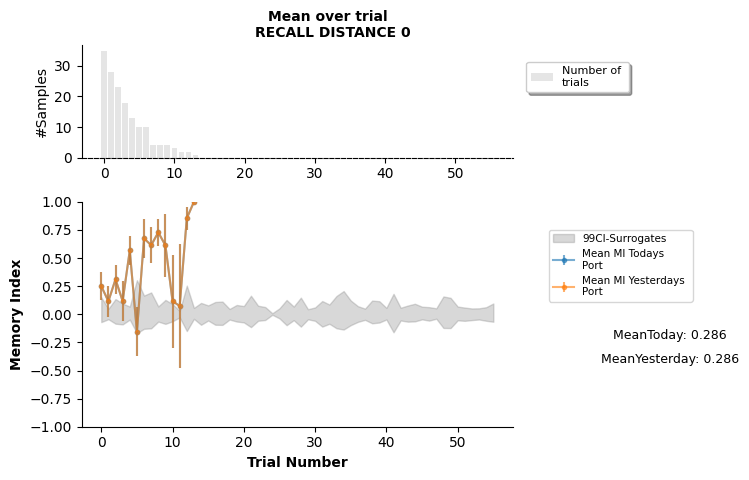

In [ ]:
## PLOTTING BY SESSION
# Create a figure and an array of subplots
fig, axs = plt.subplots(2,1, figsize=(7.5, 5),  gridspec_kw={'height_ratios': [1, 2]})

#Reshape
MItrlList=np.concatenate(MItrl_REC_0)
MItrlLagsList =np.concatenate(MItrl_REC_lags_0)
# MItrlList = MItrl.reshape(-1, MItrl.shape[2]).tolist()
# MItrlLagsList = MItrl_lags.reshape(-1, MItrl_lags.shape[2]).tolist()

## Number of trials
n_trials=[]
for i in range(np.shape(MItrlList)[1]):
  x=np.array(MItrlList)[:,i]
  n_trials.append(len(x[~np.isnan(x)]))
x=np.array([t if trial>40 else np.nan for t,trial in enumerate(n_trials)])

#SEM
sem_MItrl_list = np.nanstd(MItrlList, axis=0) / np.sqrt(np.sum(~np.isnan(MItrlList), axis=0))
sem_MItrl_lags_list =  np.nanstd(MItrlLagsList, axis=0) / np.sqrt(np.sum(~np.isnan(MItrlLagsList), axis=0))

# ## Number of trials
# n_trials=[]
# for i in range(np.shape(MItrlList)[1]):
#   x=np.array(MItrlList)[:,i]
#   n_trials.append(len(x[~np.isnan(x)]))
# x=np.array([t if trial>40 else np.nan for t,trial in enumerate(n_trials)])


### COMPUTING THE 95 AND 5 PERCENTILES
MItrlList_arr=np.array(MItrlList)
MItrlList_arr_non_nan=[MItrlList_arr[:,trl][~np.isnan(MItrlList_arr[:,trl])] for trl in range(np.shape(MItrlList_arr)[1])]
confidence_interval_MI =[np.array([np.nan, np.nan]) if np.size(MItrlList_arr_non_nan[trl])==0 else np.percentile(MItrlList_arr_non_nan[trl], [0.95, 0.05])
                              for trl in range(np.shape(MItrlList_arr)[1])]
arr_confidence_MI=np.array(confidence_interval_MI)

MItrlLagsList_arr=np.array(MItrlLagsList)
MItrlLagsList_non_nan=[MItrlLagsList_arr[:,trl][~np.isnan(MItrlLagsList_arr[:,trl])] for trl in range(np.shape(MItrlLagsList_arr)[1])]
confidence_interval_Lags =[np.array([np.nan, np.nan]) if np.size(MItrlLagsList_non_nan[trl])==0 else np.percentile(MItrlLagsList_non_nan[trl], [0.95, 0.05])
                                         for trl in range(np.shape(MItrlLagsList_arr)[1])]
arr_confidence_Lags=np.array(confidence_interval_Lags)


CI95=np.array([np.percentile(MIShuffREC_zero[trl], [0.95, 0.05]) for trl in range(np.shape(MIShuffREC_zero)[1])])
revCI95=np.roll(CI95, len(CI95), axis=0)[::-1]
CI99=np.array([np.percentile(MIShuffREC_zero[trl], [0.99, 0.01]) for trl in range(np.shape(MIShuffREC_zero)[1])])
revCI99=np.roll(CI99, len(CI99), axis=0)[::-1]

indexes = np.arange(len(MItrl_REC_0[0][0]))


#plot
axs[0].bar(indexes, n_trials, color='grey', alpha=0.2, label='Number of \ntrials')
# axs[0].set_xticklabels(-np.array([65,55,45,35, 25, 15, 5]))
axs[0].legend(loc='upper center', bbox_to_anchor=(1.15, .9), fancybox=True, shadow=True,  fontsize=8)
# axs[0].axvline(x[~np.isnan(x)].astype(int)[-1], color='red',  alpha=0.3, linestyle='--')
axs[0].annotate('# samples<40', xy=(23.5, 1500), color='red', alpha=0.5)
axs[0].set_ylabel('#Samples')
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_linestyle('dashed')
axs[0].spines['top'].set_visible(False)


axs[1].fill_between(indexes, np.nanmean(MIShuffREC_zero, axis=0)+revCI99[:,0], np.nanmean(MIShuffREC_zero, axis=0)-revCI99[:,1],color='grey' , alpha=0.3 ,label='Mean Surrogates')
axs[1].errorbar(indexes, np.nanmean(MItrlList, axis=0), yerr=sem_MItrl_list, fmt='.-', alpha=0.6 ,label='Todays Port')
axs[1].errorbar(indexes, np.nanmean(MItrlLagsList, axis=0), yerr=sem_MItrl_lags_list, fmt='.-', alpha=0.6 ,label='Yesterdays Port')
# axs[1].fill_between(indexes,np.nanmean(MItrlList, axis=0)+arr_confidence_MI[:,0],np.nanmean(MItrlList, axis=0)-arr_confidence_MI[:,1], color='tab:blue', alpha=0.2 )
# axs[1].fill_between(indexes,np.nanmean(MItrlLagsList, axis=0)+arr_confidence_Lags[:,0], np.nanmean(MItrlLagsList, axis=0)-arr_confidence_Lags[:,1], color='orange', alpha=0.2 )

# axs[1].fill_between(indexes,np.nanmean(MItrlList, axis=0)-np.nanstd(MItrlList, axis=0),np.nanmean(MItrlList, axis=0)+np.nanstd(MItrlList, axis=0), color='tab:blue', alpha=0.2 )
# axs[1].fill_between(indexes,np.nanmean(MItrlLagsList, axis=0)-np.nanstd(MItrlLagsList, axis=0), np.nanmean(MItrlLagsList, axis=0)+np.nanstd(MItrlLagsList, axis=0), color='orange', alpha=0.2 )
# axs[1].axhline(0, color='grey', alpha=0.2)
# axs[1].axvline(x[~np.isnan(x)].astype(int)[-1], color='red',  alpha=0.3, linestyle='--')
axs[1].set_ylim(-1,1 )
axs[1].set_ylabel('Memory Index', fontweight='bold')
axs[1].set_xlabel('Trial Number', fontweight='bold')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].legend(loc='upper center', bbox_to_anchor=(1.25, .9), fancybox=True, labels=['99CI-Surrogates', 'Mean MI Todays \nPort' ,'Mean MI Yesterdays \nPort'], fontsize=7.5)


fig.text( 0.9,0.30, f'MeanToday: {round(np.nanmean(MItrlList),3)}', ha='center', va='center', fontsize=9)#, bbox=dict(facecolor='tab:blue', alpha=0.1))
fig.text( 0.9,0.25, f'MeanYesterday: {round(np.nanmean(MItrlLagsList),3)}', ha='center', va='center', fontsize=9)#, bbox=dict(facecolor='tab:orange', alpha=0.1))

# Adjust layout to prevent clipping of titles
fig.suptitle('Mean over trial  \nRECALL DISTANCE 0', x=0.45, y=0.95, fontweight='bold', fontsize=10)
fig.tight_layout()
# Show the figure
plt.show()

### Distance 1

<ipython-input-462-f47280c475cc>:62: RuntimeWarning: Mean of empty slice
  axs[1].errorbar(indexes, np.nanmean(MItrlList, axis=0)[:int(max(x[~np.isnan(x)]))+1], yerr=sem_MItrl_list, fmt='.-', alpha=0.6 ,label='Todays Port')
<ipython-input-462-f47280c475cc>:63: RuntimeWarning: Mean of empty slice
  axs[1].errorbar(indexes, np.nanmean(MItrlLagsList, axis=0)[:int(max(x[~np.isnan(x)]))+1], yerr=sem_MItrl_lags_list, fmt='.-', alpha=0.6 ,label='Yesterdays Port')


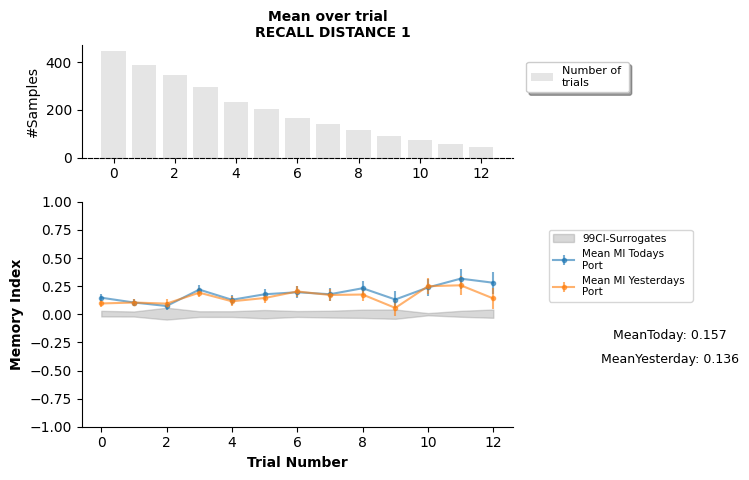

In [ ]:
## PLOTTING BY SESSION
# Create a figure and an array of subplots
fig, axs = plt.subplots(2,1, figsize=(7.5, 5),  gridspec_kw={'height_ratios': [1, 2]})

#Reshape
MItrlList=np.concatenate(MItrl_REC_1)
MItrlLagsList =np.concatenate(MItrl_REC_lags_1)
## Number of trials
n_trials=[]
for i in range(np.shape(MItrlList)[1]):
  x=np.array(MItrlList)[:,i]
  n_trials.append(len(x[~np.isnan(x)]))
x=np.array([t if trial>40 else np.nan for t,trial in enumerate(n_trials)])


# MItrlList = MItrl.reshape(-1, MItrl.shape[2]).tolist()
# MItrlLagsList = MItrl_lags.reshape(-1, MItrl_lags.shape[2]).tolist()

#SEM
sem_MItrl_list = np.nanstd(MItrlList, axis=0)[:int(max(x[~np.isnan(x)]))+1] / np.sqrt(np.sum(~np.isnan(MItrlList), axis=0)[:int(max(x[~np.isnan(x)]))+1])
sem_MItrl_lags_list =  np.nanstd(MItrlLagsList, axis=0)[:int(max(x[~np.isnan(x)]))+1] / np.sqrt(np.sum(~np.isnan(MItrlLagsList), axis=0)[:int(max(x[~np.isnan(x)]))+1])



### COMPUTING THE 95 AND 5 PERCENTILES
MItrlList_arr=np.array(MItrlList)
MItrlList_arr_non_nan=[MItrlList_arr[:,trl][~np.isnan(MItrlList_arr[:,trl])] for trl in range(np.shape(MItrlList_arr)[1])]
confidence_interval_MI =[np.array([np.nan, np.nan]) if np.size(MItrlList_arr_non_nan[trl])==0 else np.percentile(MItrlList_arr_non_nan[trl], [0.95, 0.05])
                              for trl in range(np.shape(MItrlList_arr)[1])]
arr_confidence_MI=np.array(confidence_interval_MI)

MItrlLagsList_arr=np.array(MItrlLagsList)
MItrlLagsList_non_nan=[MItrlLagsList_arr[:,trl][~np.isnan(MItrlLagsList_arr[:,trl])] for trl in range(np.shape(MItrlLagsList_arr)[1])]
confidence_interval_Lags =[np.array([np.nan, np.nan]) if np.size(MItrlLagsList_non_nan[trl])==0 else np.percentile(MItrlLagsList_non_nan[trl], [0.95, 0.05])
                                         for trl in range(np.shape(MItrlLagsList_arr)[1])]
arr_confidence_Lags=np.array(confidence_interval_Lags)


CI95=np.array([np.percentile(MIShuffREC_1[trl], [0.95, 0.05]) for trl in range(int(max(x[~np.isnan(x)]))+1)]) #range(np.shape(MIShuffREC_1)[1])])
revCI95=np.roll(CI95, len(CI95), axis=0)[::-1]
CI99=np.array([np.percentile(MIShuffREC_1[trl], [0.99, 0.01]) for trl in range(int(max(x[~np.isnan(x)]))+1)]) #in range(np.shape(MIShuffREC_1)[1])])
revCI99=np.roll(CI99, len(CI99), axis=0)[::-1]

# indexes = np.arange(len(MItrl_REC_1[0][0]))
indexes=x[~np.isnan(x)]



#plot
axs[0].bar(indexes, n_trials[:int(max(x[~np.isnan(x)]))+1], color='grey', alpha=0.2, label='Number of \ntrials')
# axs[0].set_xticklabels(-np.array([65,55,45,35, 25, 15, 5]))
axs[0].legend(loc='upper center', bbox_to_anchor=(1.15, .9), fancybox=True, shadow=True,  fontsize=8)
# axs[0].axvline(x[~np.isnan(x)].astype(int)[-1], color='red',  alpha=0.3, linestyle='--')
axs[0].annotate('# samples<40', xy=(23.5, 1500), color='red', alpha=0.5)
axs[0].set_ylabel('#Samples')
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_linestyle('dashed')
axs[0].spines['top'].set_visible(False)


axs[1].fill_between(indexes, np.nanmean(MIShuffREC_1, axis=0)[:int(max(x[~np.isnan(x)]))+1]+revCI99[:,0], np.nanmean(MIShuffREC_1, axis=0)[:int(max(x[~np.isnan(x)]))+1]-revCI99[:,1],color='grey' , alpha=0.3 ,label='Mean Surrogates')
axs[1].errorbar(indexes, np.nanmean(MItrlList, axis=0)[:int(max(x[~np.isnan(x)]))+1], yerr=sem_MItrl_list, fmt='.-', alpha=0.6 ,label='Todays Port')
axs[1].errorbar(indexes, np.nanmean(MItrlLagsList, axis=0)[:int(max(x[~np.isnan(x)]))+1], yerr=sem_MItrl_lags_list, fmt='.-', alpha=0.6 ,label='Yesterdays Port')
# axs[1].fill_between(indexes,np.nanmean(MItrlList, axis=0)+arr_confidence_MI[:,0],np.nanmean(MItrlList, axis=0)-arr_confidence_MI[:,1], color='tab:blue', alpha=0.2 )
# axs[1].fill_between(indexes,np.nanmean(MItrlLagsList, axis=0)+arr_confidence_Lags[:,0], np.nanmean(MItrlLagsList, axis=0)-arr_confidence_Lags[:,1], color='orange', alpha=0.2 )

# axs[1].fill_between(indexes,np.nanmean(MItrlList, axis=0)-np.nanstd(MItrlList, axis=0),np.nanmean(MItrlList, axis=0)+np.nanstd(MItrlList, axis=0), color='tab:blue', alpha=0.2 )
# axs[1].fill_between(indexes,np.nanmean(MItrlLagsList, axis=0)-np.nanstd(MItrlLagsList, axis=0), np.nanmean(MItrlLagsList, axis=0)+np.nanstd(MItrlLagsList, axis=0), color='orange', alpha=0.2 )
# axs[1].axhline(0, color='grey', alpha=0.2)
# axs[1].axvline(x[~np.isnan(x)].astype(int)[-1], color='red',  alpha=0.3, linestyle='--')
axs[1].set_ylim(-1,1 )
axs[1].set_ylabel('Memory Index', fontweight='bold')
axs[1].set_xlabel('Trial Number', fontweight='bold')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].legend(loc='upper center', bbox_to_anchor=(1.25, .9), fancybox=True, labels=['99CI-Surrogates', 'Mean MI Todays \nPort' ,'Mean MI Yesterdays \nPort'], fontsize=7.5)


fig.text( 0.9,0.30, f'MeanToday: {round(np.nanmean(MItrlList[:,:int(max(x[~np.isnan(x)]))+1]),3)}', ha='center', va='center', fontsize=9)#, bbox=dict(facecolor='tab:blue', alpha=0.1))
fig.text( 0.9,0.25, f'MeanYesterday: {round(np.nanmean(MItrlLagsList[:,:int(max(x[~np.isnan(x)]))+1]),3)}', ha='center', va='center', fontsize=9)#, bbox=dict(facecolor='tab:orange', alpha=0.1))

# Adjust layout to prevent clipping of titles
fig.suptitle('Mean over trial  \nRECALL DISTANCE 1', x=0.45, y=0.95, fontweight='bold', fontsize=10)
fig.tight_layout()
# Show the figure
plt.show()

### Distance 2

<ipython-input-463-c1b98c526cfb>:57: RuntimeWarning: Mean of empty slice
  axs[1].errorbar(indexes, np.nanmean(MItrlList, axis=0)[:int(max(x[~np.isnan(x)]))+1], yerr=sem_MItrl_list, fmt='.-', alpha=0.6 ,label='Todays Port')
<ipython-input-463-c1b98c526cfb>:58: RuntimeWarning: Mean of empty slice
  axs[1].errorbar(indexes, np.nanmean(MItrlLagsList, axis=0)[:int(max(x[~np.isnan(x)]))+1], yerr=sem_MItrl_lags_list, fmt='.-', alpha=0.6 ,label='Yesterdays Port')


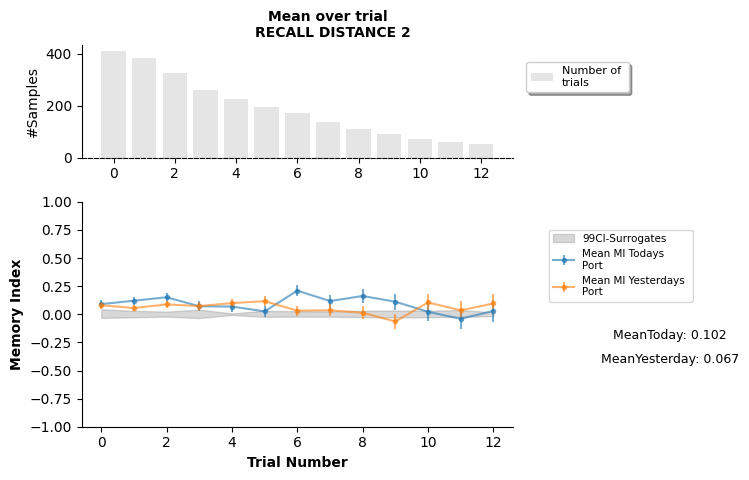

In [ ]:
## PLOTTING BY SESSION
# Create a figure and an array of subplots
fig, axs = plt.subplots(2,1, figsize=(7.5, 5),  gridspec_kw={'height_ratios': [1, 2]})

#Reshape
MItrlList=np.concatenate(MItrl_REC_2)
MItrlLagsList =np.concatenate(MItrl_REC_lags_2)
# MItrlList = MItrl.reshape(-1, MItrl.shape[2]).tolist()
# MItrlLagsList = MItrl_lags.reshape(-1, MItrl_lags.shape[2]).tolist()
## Number of trials
n_trials=[]
for i in range(np.shape(MItrlList)[1]):
  x=np.array(MItrlList)[:,i]
  n_trials.append(len(x[~np.isnan(x)]))
x=np.array([t if trial>40 else np.nan for t,trial in enumerate(n_trials)])

#SEM
sem_MItrl_list = np.nanstd(MItrlList, axis=0)[:int(max(x[~np.isnan(x)]))+1]  / np.sqrt(np.sum(~np.isnan(MItrlList), axis=0)[:int(max(x[~np.isnan(x)]))+1])
sem_MItrl_lags_list =  np.nanstd(MItrlLagsList, axis=0)[:int(max(x[~np.isnan(x)]))+1] / np.sqrt(np.sum(~np.isnan(MItrlLagsList), axis=0)[:int(max(x[~np.isnan(x)]))+1])

### COMPUTING THE 95 AND 5 PERCENTILES
# MItrlList_arr=np.array(MItrlList)
# MItrlList_arr_non_nan=[MItrlList_arr[:,trl][~np.isnan(MItrlList_arr[:,trl])] for trl in range([int(max(x[~np.isnan(x)]))+1])] #range(np.shape(MItrlList_arr)[1])]
# confidence_interval_MI =[np.array([np.nan, np.nan]) if np.size(MItrlList_arr_non_nan[trl])==0 else np.percentile(MItrlList_arr_non_nan[trl], [0.95, 0.05])
#                               for trl in range([int(max(x[~np.isnan(x)]))+1])] #range(np.shape(MItrlList_arr)[1])]
# arr_confidence_MI=np.array(confidence_interval_MI)

# MItrlLagsList_arr=np.array(MItrlLagsList)
# MItrlLagsList_non_nan=[MItrlLagsList_arr[:,trl][~np.isnan(MItrlLagsList_arr[:,trl])] for trl in range([int(max(x[~np.isnan(x)]))+1])] #range(np.shape(MItrlLagsList_arr)[1])]
# confidence_interval_Lags =[np.array([np.nan, np.nan]) if np.size(MItrlLagsList_non_nan[trl])==0 else np.percentile(MItrlLagsList_non_nan[trl], [0.95, 0.05])
#                                          for trl in mrange([int(max(x[~np.isnan(x)]))+1])] #range(np.shape(MItrlLagsList_arr)[1])]
# arr_confidence_Lags=np.array(confidence_interval_Lags)


CI95=np.array([np.percentile(MIShuffREC_2[trl], [0.95, 0.05]) for trl in range(int(max(x[~np.isnan(x)]))+1)]) #range(np.shape(MIShuffREC_2)[1])])
revCI95=np.roll(CI95, len(CI95), axis=0)[::-1]
CI99=np.array([np.percentile(MIShuffREC_2[trl], [0.99, 0.01]) for trl in range(int(max(x[~np.isnan(x)]))+1)]) #range(np.shape(MIShuffREC_2)[1])])
revCI99=np.roll(CI99, len(CI99), axis=0)[::-1]

# indexes = np.arange(len(MItrl_REC_1[0][0]))
indexes=x[~np.isnan(x)]


#plot
axs[0].bar(indexes, n_trials[:int(max(x[~np.isnan(x)]))+1], color='grey', alpha=0.2, label='Number of \ntrials')
# axs[0].set_xticklabels(-np.array([65,55,45,35, 25, 15, 5]))
axs[0].legend(loc='upper center', bbox_to_anchor=(1.15, .9), fancybox=True, shadow=True,  fontsize=8)
# axs[0].axvline(x[~np.isnan(x)].astype(int)[-1], color='red',  alpha=0.3, linestyle='--')
axs[0].annotate('# samples<40', xy=(23.5, 1500), color='red', alpha=0.5)
axs[0].set_ylabel('#Samples')
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_linestyle('dashed')
axs[0].spines['top'].set_visible(False)


axs[1].fill_between(indexes, np.nanmean(MIShuffREC_2, axis=0)[:int(max(x[~np.isnan(x)]))+1]+revCI99[:,0], np.nanmean(MIShuffREC_2, axis=0)[:int(max(x[~np.isnan(x)]))+1]-revCI99[:,1],color='grey' , alpha=0.3 ,label='Mean Surrogates')
axs[1].errorbar(indexes, np.nanmean(MItrlList, axis=0)[:int(max(x[~np.isnan(x)]))+1], yerr=sem_MItrl_list, fmt='.-', alpha=0.6 ,label='Todays Port')
axs[1].errorbar(indexes, np.nanmean(MItrlLagsList, axis=0)[:int(max(x[~np.isnan(x)]))+1], yerr=sem_MItrl_lags_list, fmt='.-', alpha=0.6 ,label='Yesterdays Port')
# axs[1].fill_between(indexes,np.nanmean(MItrlList, axis=0)+arr_confidence_MI[:,0],np.nanmean(MItrlList, axis=0)-arr_confidence_MI[:,1], color='tab:blue', alpha=0.2 )
# axs[1].fill_between(indexes,np.nanmean(MItrlLagsList, axis=0)+arr_confidence_Lags[:,0], np.nanmean(MItrlLagsList, axis=0)-arr_confidence_Lags[:,1], color='orange', alpha=0.2 )

# axs[1].fill_between(indexes,np.nanmean(MItrlList, axis=0)-np.nanstd(MItrlList, axis=0),np.nanmean(MItrlList, axis=0)+np.nanstd(MItrlList, axis=0), color='tab:blue', alpha=0.2 )
# axs[1].fill_between(indexes,np.nanmean(MItrlLagsList, axis=0)-np.nanstd(MItrlLagsList, axis=0), np.nanmean(MItrlLagsList, axis=0)+np.nanstd(MItrlLagsList, axis=0), color='orange', alpha=0.2 )
# axs[1].axhline(0, color='grey', alpha=0.2)
# axs[1].axvline(x[~np.isnan(x)].astype(int)[-1], color='red',  alpha=0.3, linestyle='--')
axs[1].set_ylim(-1,1 )
axs[1].set_ylabel('Memory Index', fontweight='bold')
axs[1].set_xlabel('Trial Number', fontweight='bold')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].legend(loc='upper center', bbox_to_anchor=(1.25, .9), fancybox=True, labels=['99CI-Surrogates', 'Mean MI Todays \nPort' ,'Mean MI Yesterdays \nPort'], fontsize=7.5)


fig.text( 0.9,0.30, f'MeanToday: {round(np.nanmean(MItrlList[:,:int(max(x[~np.isnan(x)]))+1]),3)}', ha='center', va='center', fontsize=9)#, bbox=dict(facecolor='tab:blue', alpha=0.1))
fig.text( 0.9,0.25, f'MeanYesterday: {round(np.nanmean(MItrlLagsList[:,:int(max(x[~np.isnan(x)]))+1]),3)}', ha='center', va='center', fontsize=9)#, bbox=dict(facecolor='tab:orange', alpha=0.1))

# Adjust layout to prevent clipping of titles
fig.suptitle('Mean over trial  \nRECALL DISTANCE 2', x=0.45, y=0.95, fontweight='bold', fontsize=10)
fig.tight_layout()
# Show the figure
plt.show()

### Distance 3

<ipython-input-464-c151e6f500b8>:56: RuntimeWarning: Mean of empty slice
  axs[1].errorbar(indexes, np.nanmean(MItrlList, axis=0)[:int(max(x[~np.isnan(x)]))+1], yerr=sem_MItrl_list, fmt='.-', alpha=0.6 ,label='Todays Port')
<ipython-input-464-c151e6f500b8>:57: RuntimeWarning: Mean of empty slice
  axs[1].errorbar(indexes, np.nanmean(MItrlLagsList, axis=0)[:int(max(x[~np.isnan(x)]))+1], yerr=sem_MItrl_lags_list, fmt='.-', alpha=0.6 ,label='Yesterdays Port')


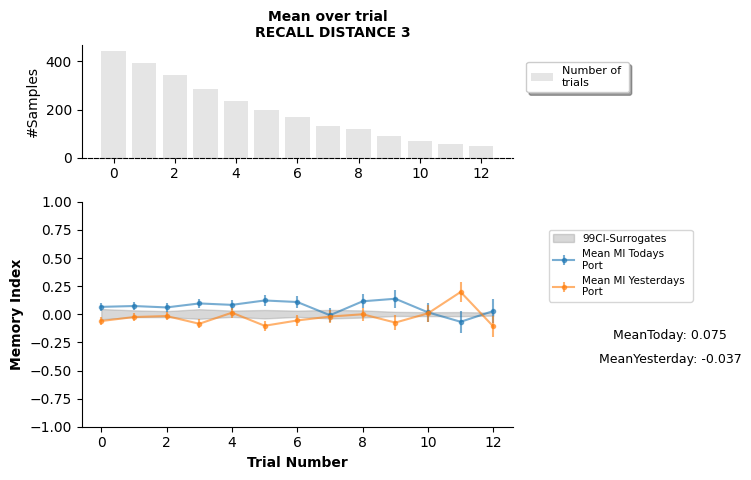

In [ ]:
## PLOTTING BY SESSION
# Create a figure and an array of subplots
fig, axs = plt.subplots(2,1, figsize=(7.5, 5),  gridspec_kw={'height_ratios': [1, 2]})

#Reshape
MItrlList=np.concatenate(MItrl_REC_3)
MItrlLagsList =np.concatenate(MItrl_REC_lags_3)
# MItrlList = MItrl.reshape(-1, MItrl.shape[2]).tolist()
# MItrlLagsList = MItrl_lags.reshape(-1, MItrl_lags.shape[2]).tolist()
## Number of trials
n_trials=[]
for i in range(np.shape(MItrlList)[1]):
  x=np.array(MItrlList)[:,i]
  n_trials.append(len(x[~np.isnan(x)]))
x=np.array([t if trial>40 else np.nan for t,trial in enumerate(n_trials)])

#SEM
sem_MItrl_list = np.nanstd(MItrlList, axis=0)[:int(max(x[~np.isnan(x)]))+1] / np.sqrt(np.sum(~np.isnan(MItrlList), axis=0)[:int(max(x[~np.isnan(x)]))+1])
sem_MItrl_lags_list =  np.nanstd(MItrlLagsList, axis=0)[:int(max(x[~np.isnan(x)]))+1] / np.sqrt(np.sum(~np.isnan(MItrlLagsList), axis=0)[:int(max(x[~np.isnan(x)]))+1])

### COMPUTING THE 95 AND 5 PERCENTILES
MItrlList_arr=np.array(MItrlList)
MItrlList_arr_non_nan=[MItrlList_arr[:,trl][~np.isnan(MItrlList_arr[:,trl])] for trl in range(np.shape(MItrlList_arr)[1])]
confidence_interval_MI =[np.array([np.nan, np.nan]) if np.size(MItrlList_arr_non_nan[trl])==0 else np.percentile(MItrlList_arr_non_nan[trl], [0.95, 0.05])
                              for trl in range(np.shape(MItrlList_arr)[1])]
arr_confidence_MI=np.array(confidence_interval_MI)

MItrlLagsList_arr=np.array(MItrlLagsList)
MItrlLagsList_non_nan=[MItrlLagsList_arr[:,trl][~np.isnan(MItrlLagsList_arr[:,trl])] for trl in range(np.shape(MItrlLagsList_arr)[1])]
confidence_interval_Lags =[np.array([np.nan, np.nan]) if np.size(MItrlLagsList_non_nan[trl])==0 else np.percentile(MItrlLagsList_non_nan[trl], [0.95, 0.05])
                                         for trl in range(np.shape(MItrlLagsList_arr)[1])]
arr_confidence_Lags=np.array(confidence_interval_Lags)


CI95=np.array([np.percentile(MIShuffREC_3[trl], [0.95, 0.05]) for trl in range(int(max(x[~np.isnan(x)]))+1)]) #range(np.shape(MIShuffREC_3)[1])])
revCI95=np.roll(CI95, len(CI95), axis=0)[::-1]
CI99=np.array([np.percentile(MIShuffREC_3[trl], [0.99, 0.01]) for trl in range(int(max(x[~np.isnan(x)]))+1)]) #range(np.shape(MIShuffREC_3)[1])])
revCI99=np.roll(CI99, len(CI99), axis=0)[::-1]

# indexes = np.arange(len(MItrl_REC_1[0][0]))
indexes=x[~np.isnan(x)]

#plot
axs[0].bar(indexes, n_trials[:int(max(x[~np.isnan(x)]))+1], color='grey', alpha=0.2, label='Number of \ntrials')
# axs[0].set_xticklabels(-np.array([65,55,45,35, 25, 15, 5]))
axs[0].legend(loc='upper center', bbox_to_anchor=(1.15, .9), fancybox=True, shadow=True,  fontsize=8)
# axs[0].axvline(x[~np.isnan(x)].astype(int)[-1], color='red',  alpha=0.3, linestyle='--')
axs[0].annotate('# samples<40', xy=(23.5, 1500), color='red', alpha=0.5)
axs[0].set_ylabel('#Samples')
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_linestyle('dashed')
axs[0].spines['top'].set_visible(False)


axs[1].fill_between(indexes, np.nanmean(MIShuffREC_3, axis=0)[:int(max(x[~np.isnan(x)]))+1]+revCI99[:,0], np.nanmean(MIShuffREC_3, axis=0)[:int(max(x[~np.isnan(x)]))+1]-revCI99[:,1],color='grey' , alpha=0.3 ,label='Mean Surrogates')
axs[1].errorbar(indexes, np.nanmean(MItrlList, axis=0)[:int(max(x[~np.isnan(x)]))+1], yerr=sem_MItrl_list, fmt='.-', alpha=0.6 ,label='Todays Port')
axs[1].errorbar(indexes, np.nanmean(MItrlLagsList, axis=0)[:int(max(x[~np.isnan(x)]))+1], yerr=sem_MItrl_lags_list, fmt='.-', alpha=0.6 ,label='Yesterdays Port')
# axs[1].fill_between(indexes,np.nanmean(MItrlList, axis=0)+arr_confidence_MI[:,0],np.nanmean(MItrlList, axis=0)-arr_confidence_MI[:,1], color='tab:blue', alpha=0.2 )
# axs[1].fill_between(indexes,np.nanmean(MItrlLagsList, axis=0)+arr_confidence_Lags[:,0], np.nanmean(MItrlLagsList, axis=0)-arr_confidence_Lags[:,1], color='orange', alpha=0.2 )

# axs[1].fill_between(indexes,np.nanmean(MItrlList, axis=0)-np.nanstd(MItrlList, axis=0),np.nanmean(MItrlList, axis=0)+np.nanstd(MItrlList, axis=0), color='tab:blue', alpha=0.2 )
# axs[1].fill_between(indexes,np.nanmean(MItrlLagsList, axis=0)-np.nanstd(MItrlLagsList, axis=0), np.nanmean(MItrlLagsList, axis=0)+np.nanstd(MItrlLagsList, axis=0), color='orange', alpha=0.2 )
# axs[1].axhline(0, color='grey', alpha=0.2)
# axs[1].axvline(x[~np.isnan(x)].astype(int)[-1], color='red',  alpha=0.3, linestyle='--')
axs[1].set_ylim(-1,1 )
axs[1].set_ylabel('Memory Index', fontweight='bold')
axs[1].set_xlabel('Trial Number', fontweight='bold')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].legend(loc='upper center', bbox_to_anchor=(1.25, .9), fancybox=True, labels=['99CI-Surrogates', 'Mean MI Todays \nPort' ,'Mean MI Yesterdays \nPort'], fontsize=7.5)


fig.text( 0.9,0.30, f'MeanToday: {round(np.nanmean(MItrlList[:,:int(max(x[~np.isnan(x)]))+1]),3)}', ha='center', va='center', fontsize=9)#, bbox=dict(facecolor='tab:blue', alpha=0.1))
fig.text( 0.9,0.25, f'MeanYesterday: {round(np.nanmean(MItrlLagsList[:,:int(max(x[~np.isnan(x)]))+1]),3)}', ha='center', va='center', fontsize=9)#, bbox=dict(facecolor='tab:orange', alpha=0.1))

# Adjust layout to prevent clipping of titles
fig.suptitle('Mean over trial  \nRECALL DISTANCE 3', x=0.45, y=0.95, fontweight='bold', fontsize=10)
fig.tight_layout()
# Show the figure
plt.show()

###Distance 4

<ipython-input-474-6279a85f7178>:55: RuntimeWarning: Mean of empty slice
  axs[1].errorbar(indexes, np.nanmean(MItrlList, axis=0)[:int(max(x[~np.isnan(x)]))+1], yerr=sem_MItrl_list, fmt='.-', alpha=0.6 ,label='Todays Port')
<ipython-input-474-6279a85f7178>:56: RuntimeWarning: Mean of empty slice
  axs[1].errorbar(indexes, np.nanmean(MItrlLagsList, axis=0)[:int(max(x[~np.isnan(x)]))+1], yerr=sem_MItrl_lags_list, fmt='.-', alpha=0.6 ,label='Yesterdays Port')


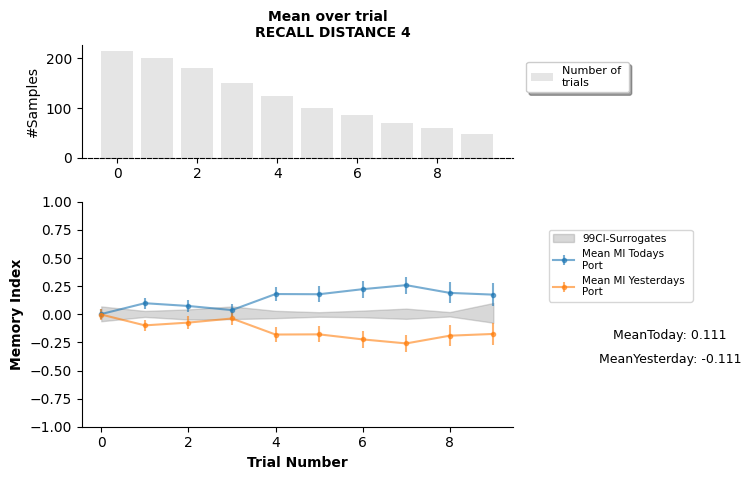

In [ ]:
## PLOTTING BY SESSION
fig, axs = plt.subplots(2,1, figsize=(7.5, 5),  gridspec_kw={'height_ratios': [1, 2]})

#Reshape
MItrlList=np.concatenate(MItrl_REC_4)
MItrlLagsList =np.concatenate(MItrl_REC_lags_4)

## Number of trials
n_trials=[]
for i in range(np.shape(MItrlList)[1]):
  x=np.array(MItrlList)[:,i]
  n_trials.append(len(x[~np.isnan(x)]))
x=np.array([t if trial>40 else np.nan for t,trial in enumerate(n_trials)])

#SEM
sem_MItrl_list = np.nanstd(MItrlList, axis=0)[:int(max(x[~np.isnan(x)]))+1] / np.sqrt(np.sum(~np.isnan(MItrlList), axis=0)[:int(max(x[~np.isnan(x)]))+1])
sem_MItrl_lags_list =  np.nanstd(MItrlLagsList, axis=0)[:int(max(x[~np.isnan(x)]))+1] / np.sqrt(np.sum(~np.isnan(MItrlLagsList), axis=0)[:int(max(x[~np.isnan(x)]))+1])


### COMPUTING THE 95 AND 5 PERCENTILES
MItrlList_arr=np.array(MItrlList)
MItrlList_arr_non_nan=[MItrlList_arr[:,trl][~np.isnan(MItrlList_arr[:,trl])] for trl in range(np.shape(MItrlList_arr)[1])]
confidence_interval_MI =[np.array([np.nan, np.nan]) if np.size(MItrlList_arr_non_nan[trl])==0 else np.percentile(MItrlList_arr_non_nan[trl], [0.95, 0.05])
                              for trl in range(np.shape(MItrlList_arr)[1])]
arr_confidence_MI=np.array(confidence_interval_MI)

MItrlLagsList_arr=np.array(MItrlLagsList)
MItrlLagsList_non_nan=[MItrlLagsList_arr[:,trl][~np.isnan(MItrlLagsList_arr[:,trl])] for trl in range(np.shape(MItrlLagsList_arr)[1])]
confidence_interval_Lags =[np.array([np.nan, np.nan]) if np.size(MItrlLagsList_non_nan[trl])==0 else np.percentile(MItrlLagsList_non_nan[trl], [0.95, 0.05])
                                         for trl in range(np.shape(MItrlLagsList_arr)[1])]
arr_confidence_Lags=np.array(confidence_interval_Lags)


CI95=np.array([np.percentile(MIShuffREC_4[trl], [0.95, 0.05]) for trl in range(int(max(x[~np.isnan(x)]))+1)]) #range(np.shape(MIShuffREC_4)[1])])
revCI95=np.roll(CI95, len(CI95), axis=0)[::-1]
CI99=np.array([np.percentile(MIShuffREC_4[trl], [0.99, 0.01]) for trl in range(int(max(x[~np.isnan(x)]))+1)])  #range(np.shape(MIShuffREC_4)[1])])
revCI99=np.roll(CI99, len(CI99), axis=0)[::-1]

# indexes = np.arange(len(MItrl_REC_4[0][0]))
indexes=x[~np.isnan(x)]

#plot
axs[0].bar(indexes, n_trials[:int(max(x[~np.isnan(x)]))+1], color='grey', alpha=0.2, label='Number of \ntrials')
# axs[0].set_xticklabels(-np.array([65,55,45,35, 25, 15, 5]))
axs[0].legend(loc='upper center', bbox_to_anchor=(1.15, .9), fancybox=True, shadow=True,  fontsize=8)
# axs[0].axvline(x[~np.isnan(x)].astype(int)[-1], color='red',  alpha=0.3, linestyle='--')
axs[0].annotate('# samples<40', xy=(23.5, 1500), color='red', alpha=0.5)
axs[0].set_ylabel('#Samples')
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_linestyle('dashed')
axs[0].spines['top'].set_visible(False)


axs[1].fill_between(indexes, np.nanmean(MIShuffREC_4, axis=0)[:int(max(x[~np.isnan(x)]))+1]+revCI99[:,0], np.nanmean(MIShuffREC_4, axis=0)[:int(max(x[~np.isnan(x)]))+1]-revCI99[:,1],color='grey' , alpha=0.3 ,label='Mean Surrogates')
axs[1].errorbar(indexes, np.nanmean(MItrlList, axis=0)[:int(max(x[~np.isnan(x)]))+1], yerr=sem_MItrl_list, fmt='.-', alpha=0.6 ,label='Todays Port')
axs[1].errorbar(indexes, np.nanmean(MItrlLagsList, axis=0)[:int(max(x[~np.isnan(x)]))+1], yerr=sem_MItrl_lags_list, fmt='.-', alpha=0.6 ,label='Yesterdays Port')
axs[1].set_ylim(-1,1 )
axs[1].set_ylabel('Memory Index', fontweight='bold')
axs[1].set_xlabel('Trial Number', fontweight='bold')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].legend(loc='upper center', bbox_to_anchor=(1.25, .9), fancybox=True, labels=['99CI-Surrogates', 'Mean MI Todays \nPort' ,'Mean MI Yesterdays \nPort'], fontsize=7.5)


fig.text( 0.9,0.30, f'MeanToday: {round(np.nanmean(MItrlList[:,:int(max(x[~np.isnan(x)]))+1]),3)}', ha='center', va='center', fontsize=9)
fig.text( 0.9,0.25, f'MeanYesterday: {round(np.nanmean(MItrlLagsList[:,:int(max(x[~np.isnan(x)]))+1]),3)}', ha='center', va='center', fontsize=9)

# Adjust layout to prevent clipping of titles
fig.suptitle('Mean over trial  \nRECALL DISTANCE 4', x=0.45, y=0.95, fontweight='bold', fontsize=10)
fig.tight_layout()
# Show the figure
plt.show()

#Mean MI by distance: REC

## Correct one

Computing the MI of today following exactly the same way as with the surrogate dataset

In [ ]:
## CONTROL
hist_seq=NON_0_hist_seq_REC
port_seq=NON_0_port_seq_REC
yes_seq=[np.roll(seq,1) for seq in NON_0_port_seq_REC]
distance_seq=distance_seq_REC


Hist_data = np.array(list(chain.from_iterable(hist_seq)))
new_port_seq=np.array(list(chain.from_iterable(port_seq)))
new_yes_seq=np.array(list(chain.from_iterable(yes_seq)))

distance_seq=list(chain.from_iterable(distance_seq))
# random.shuffle(distance_seq)
sess0=np.array(distance_seq)==0.0
sess1=np.array(distance_seq)==1.0
sess2=np.array(distance_seq)==2.0
sess3=np.array(distance_seq)==3.0
sess4=np.array(distance_seq)==4.0

MItrlREC0=MemoryIndex(Hist_data[sess0], new_port_seq[sess0])
MItrlREC1=MemoryIndex(Hist_data[sess1], new_port_seq[sess1])
MItrlREC2=MemoryIndex(Hist_data[sess2], new_port_seq[sess2])
MItrlREC3=MemoryIndex(Hist_data[sess3], new_port_seq[sess3])
MItrlREC4=MemoryIndex(Hist_data[sess4], new_port_seq[sess4])

MItrlLagsREC0=MemoryIndex(Hist_data[sess0], new_yes_seq[sess0])
MItrlLagsREC1=MemoryIndex(Hist_data[sess1], new_yes_seq[sess1])
MItrlLagsREC2=MemoryIndex(Hist_data[sess2], new_yes_seq[sess2])
MItrlLagsREC3=MemoryIndex(Hist_data[sess3], new_yes_seq[sess3])
MItrlLagsREC4=MemoryIndex(Hist_data[sess4], new_yes_seq[sess4])
All_MItrl_REC={0:MItrlREC0,1:MItrlREC1,2:MItrlREC2,3:MItrlREC3,4:MItrlREC4}
All_MItrlLags_REC={0:MItrlLagsREC0,1:MItrlLagsREC1,2:MItrlLagsREC2,3:MItrlLagsREC3,4:MItrlLagsREC4}

## NMDA
hist_seq_NMDA=NON_0_hist_seq_REC_NMDA
port_seq_NMDA=NON_0_port_seq_REC_NMDA
yes_seq_NMDA=[np.roll(seq,1) for seq in NON_0_port_seq_REC_NMDA]
distance_seq_NMDA=distance_seq_REC_NMDA


Hist_data_NMDA = np.array(list(chain.from_iterable(hist_seq_NMDA)))
new_port_seq_NMDA=np.array(list(chain.from_iterable(port_seq_NMDA)))
new_yes_seq_NMDA=np.array(list(chain.from_iterable(yes_seq_NMDA)))

distance_seq_NMDA=list(chain.from_iterable(distance_seq_NMDA))
# random.shuffle(distance_seq)
sess0_NMDA=np.array(distance_seq_NMDA)==0.0
sess1_NMDA=np.array(distance_seq_NMDA)==1.0
sess2_NMDA=np.array(distance_seq_NMDA)==2.0
sess3_NMDA=np.array(distance_seq_NMDA)==3.0
sess4_NMDA=np.array(distance_seq_NMDA)==4.0

MItrlREC0_NMDA=MemoryIndex(Hist_data_NMDA[sess0_NMDA], new_port_seq_NMDA[sess0_NMDA])
MItrlREC1_NMDA=MemoryIndex(Hist_data_NMDA[sess1_NMDA], new_port_seq_NMDA[sess1_NMDA])
MItrlREC2_NMDA=MemoryIndex(Hist_data_NMDA[sess2_NMDA], new_port_seq_NMDA[sess2_NMDA])
MItrlREC3_NMDA=MemoryIndex(Hist_data_NMDA[sess3_NMDA], new_port_seq_NMDA[sess3_NMDA])
MItrlREC4_NMDA=MemoryIndex(Hist_data_NMDA[sess4_NMDA], new_port_seq_NMDA[sess4_NMDA])

MItrlLagsREC0_NMDA=MemoryIndex(Hist_data_NMDA[sess0_NMDA], new_yes_seq_NMDA[sess0_NMDA])
MItrlLagsREC1_NMDA=MemoryIndex(Hist_data_NMDA[sess1_NMDA], new_yes_seq_NMDA[sess1_NMDA])
MItrlLagsREC2_NMDA=MemoryIndex(Hist_data_NMDA[sess2_NMDA], new_yes_seq_NMDA[sess2_NMDA])
MItrlLagsREC3_NMDA=MemoryIndex(Hist_data_NMDA[sess3_NMDA], new_yes_seq_NMDA[sess3_NMDA])
MItrlLagsREC4_NMDA=MemoryIndex(Hist_data_NMDA[sess4_NMDA], new_yes_seq_NMDA[sess4_NMDA])
All_MItrl_REC_NMDA={0:MItrlREC0_NMDA,1:MItrlREC1_NMDA,2:MItrlREC2_NMDA,3:MItrlREC3_NMDA,4:MItrlREC4_NMDA}
All_MItrlLags_REC_NMDA={0:MItrlLagsREC0_NMDA,1:MItrlLagsREC1_NMDA,2:MItrlLagsREC2_NMDA,3:MItrlLagsREC3_NMDA,4:MItrlLagsREC4_NMDA}

In [ ]:
Nshuffles=1000
MI_shuff_Surr_MI0MI4=np.full((Nshuffles,38), np.nan)
for n in range(Nshuffles):
  MI_shuff_Surr_MI0MI4[n]=surrogates_2nd_MI0_MI4(distance_seq_REC, NON_0_hist_seq_REC,NON_0_port_seq_REC )

In [ ]:
X_distribution=All_MItrl_REC[0]-np.nanmean(All_MItrl_REC[4])

Checking the distribution of the shuffles

Text(0.5, 1.0, 'Surrogate datasets')

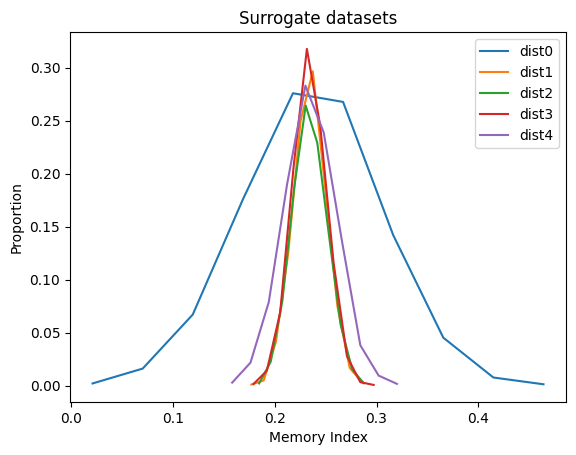

In [ ]:
hist0=np.histogram(All_MIShuffRECListREC[0])
hist1=np.histogram(All_MIShuffRECListREC[1])
hist2=np.histogram(All_MIShuffRECListREC[2])
hist3=np.histogram(All_MIShuffRECListREC[3])
hist4=np.histogram(All_MIShuffRECListREC[4])
plt.plot(hist0[1][:-1]+(hist0[1][:-1][1]- hist0[1][:-1][0])/2,hist0[0]/np.sum(hist0[0]), label="dist0")
plt.plot(hist1[1][:-1]+(hist1[1][:-1][1]- hist1[1][:-1][0])/2,hist1[0]/np.sum(hist1[0]), label="dist1")
plt.plot(hist2[1][:-1]+(hist2[1][:-1][1]- hist2[1][:-1][0])/2,hist2[0]/np.sum(hist2[0]), label="dist2")
plt.plot(hist3[1][:-1]+(hist3[1][:-1][1]- hist3[1][:-1][0])/2,hist3[0]/np.sum(hist3[0]), label="dist3")
plt.plot(hist4[1][:-1]+(hist4[1][:-1][1]- hist4[1][:-1][0])/2,hist4[0]/np.sum(hist4[0]), label="dist4")
plt.legend()
plt.ylabel('Proportion')
plt.xlabel('Memory Index')
plt.title('Surrogate datasets')

In [ ]:
Nshuffles=5000
MI_shuf_REC_NMDA=np.full((Nshuffles, 5), np.nan)
for n in range(Nshuffles):
  MI_shuf_REC_NMDA[n]=((surrogates_2nd(distance_seq_REC_NMDA,NON_0_hist_seq_REC_NMDA, NON_0_port_seq_REC_NMDA)))


In [ ]:
Nshuffles=5000
MI_shuf_REC24_NMDA=np.full((Nshuffles, 5), np.nan)
for n in range(Nshuffles):
  MI_shuf_REC24_NMDA[n]=((surrogates_24h(NON_0_hist_seq_REC_NMDA, NON_0_port_seq_REC_NMDA)))

In [ ]:
folder = "/content/drive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/"
file_name = "Shuffle_rec_24h_all_sessions_NMDA.csv"
np.savetxt(folder + file_name, MI_shuf_REC24_NMDA, delimiter=",")

In [ ]:
## Importing Surrogates:
MI_shuf_REC = np.genfromtxt("/content/drive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_rec_all_Sessions.csv",  delimiter=",")
MI_shuf_REC24= np.genfromtxt("/content/drive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_rec24h_all_Sessions.csv",  delimiter=",")
MI_shuf_REC_NMDA = np.genfromtxt("/content/drive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_rec_all_sessions_NMDA.csv",  delimiter=",")
MI_shuf_REC24_NMDA= np.genfromtxt("/content/drive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_rec_24h_all_sessions_NMDA.csv",  delimiter=",")

Text(0.5, 1.0, 'Memory Index by Distance to previous rewarded port \n REC [all sessions]')

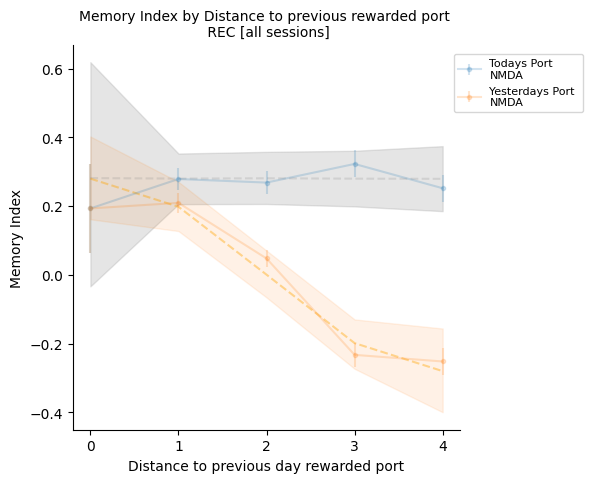

In [ ]:
NumTrials=10
All_MItrlListREC_Dist_means=[]
All_MItrlListREC_Dist_sem=[]
All_MItrlListREC_Dist_CI95=[]

All_MItrlListREC_Dist_means_NMDA=[]
All_MItrlListREC_Dist_sem_NMDA=[]
All_MItrlListREC_Dist_CI95_NMDA=[]

All_MIShuffREC_List_Dist_means=[]
All_MIShuffRECListREC_CI99=[]

All_MIShuffREC_List_Dist_means_NMDA=[]
All_MIShuffRECListREC_CI99_NMDA=[]

All_MItrlLagsListREC_Dist_means=[]
All_MItrlLagsListREC_Dist_sem=[]
All_MItrlLagsListREC_Dist_CI95=[]

All_MItrlLagsListREC_Dist_means_NMDA=[]
All_MItrlLagsListREC_Dist_sem_NMDA=[]
All_MItrlLagsListREC_Dist_CI95_NMDA=[]

All_MIShuffREC_List_Dist_means24=[]
All_MIShuffRECListREC24_CI99=[]

All_MIShuffREC_List_Dist_means24_NMDA=[]
All_MIShuffRECListREC24_CI99_NMDA=[]

for i in range(len(All_MItrl_REC)):
  All_MItrlListREC_Dist_means.append(np.nanmean(All_MItrl_REC[i]))
  All_MItrlListREC_non_nan=[All_MItrl_REC[i][~np.isnan(All_MItrl_REC[i])]]
  All_MItrlListREC_Dist_CI95.append(np.array(np.percentile(All_MItrlListREC_non_nan, [99.5, .5])))
  All_MItrlListREC_Dist_sem.append(np.nanstd(All_MItrl_REC[i]) / np.sqrt(np.sum(~np.isnan(All_MItrl_REC[i]))))

  All_MItrlListREC_Dist_means_NMDA.append(np.nanmean(All_MItrl_REC_NMDA[i]))
  All_MItrlListREC_non_nan_NMDA=[All_MItrl_REC_NMDA[i][~np.isnan(All_MItrl_REC_NMDA[i])]]
  # All_MItrlListREC_Dist_CI95_NMDA.append(np.array(np.percentile(All_MItrlListREC_non_nan_NMDA, [99.5, .5])))
  All_MItrlListREC_Dist_sem_NMDA.append(np.nanstd(All_MItrl_REC_NMDA[i]) / np.sqrt(np.sum(~np.isnan(All_MItrl_REC_NMDA[i]))))

  All_MIShuffREC_List_Dist_means.append(np.nanmean(MI_shuf_REC[:,i]))
  All_MIShuffRECListREC_CI99.append(np.array(np.percentile(MI_shuf_REC[:,i], [99.5,.5])))

  All_MIShuffREC_List_Dist_means_NMDA.append(np.nanmean(MI_shuf_REC_NMDA[:,i]))
  All_MIShuffRECListREC_CI99_NMDA.append(np.array(np.percentile(MI_shuf_REC_NMDA[:,i], [99.5,.5])))

  All_MItrlLagsListREC_Dist_means.append(np.nanmean(All_MItrlLags_REC[i]))
  All_MItrlLagsListREC_Dist_sem.append(np.nanstd(All_MItrlLags_REC[i]) / np.sqrt(np.sum(~np.isnan(All_MItrlLags_REC[i]))))

  All_MItrlLagsListREC_Dist_means_NMDA.append(np.nanmean(All_MItrlLags_REC_NMDA[i]))
  All_MItrlLagsListREC_Dist_sem_NMDA.append(np.nanstd(All_MItrlLags_REC_NMDA[i]) / np.sqrt(np.sum(~np.isnan(All_MItrlLags_REC_NMDA[i]))))

  All_MIShuffREC_List_Dist_means24.append(np.nanmean(MI_shuf_REC24[:,i]))
  All_MIShuffRECListREC24_CI99.append(np.array(np.percentile(MI_shuf_REC24[:,i], [99.5,.5])))

  All_MIShuffREC_List_Dist_means24_NMDA.append(np.nanmean(MI_shuf_REC24_NMDA[:,i]))
  All_MIShuffRECListREC24_CI99_NMDA.append(np.array(np.percentile(MI_shuf_REC24_NMDA[:,i], [99.5,.5])))

##FIGURE
x=np.arange(0, len(All_MItrlListREC_Dist_means), 1)
fig,axs=plt.subplots(figsize=(5,5))
# # ##CONTROL
# axs.plot( np.array(All_MIShuffREC_List_Dist_means),'--' ,color='grey', alpha=0.4)
# axs.fill_between(x, np.array(All_MIShuffRECListREC_CI99)[:,0],np.array(All_MIShuffRECListREC_CI99)[:,1], color='grey', alpha=0.2)
# axs.fill_between(x, np.array(All_MIShuffRECListREC24_CI99)[:,0],np.array(All_MIShuffRECListREC24_CI99)[:,1], color='tab:orange', alpha=0.1)
# axs.plot(np.array(All_MIShuffREC_List_Dist_means24), '--', color='orange', alpha=0.4)

# # plt.fill_between(x,np.array(All_MItrlListREC_Dist_means)-np.array(All_MItrlListREC_Dist_CI95)[:,0], np.array(All_MItrlListREC_Dist_means)+np.array(All_MItrlListREC_Dist_CI95)[:,1],color='tab:blue', alpha=0.2)
# axs.errorbar(x,All_MItrlListREC_Dist_means,  yerr=All_MItrlListREC_Dist_sem, fmt='.-', alpha=0.6 ,label='Todays Port \nCONTROL')
# # plt.fill_between(x,np.array(All_MItrlLagsListREC_Dist_means)-np.array(All_MItrlLagsListREC_Dist_CI95)[:,0], np.array(All_MItrlLagsListREC_Dist_means)+np.array(All_MItrlLagsListREC_Dist_CI95)[:,1],color='tab:orange', alpha=0.1)
# axs.errorbar(x,All_MItrlLagsListREC_Dist_means,  yerr=All_MItrlLagsListREC_Dist_sem, fmt='.-', alpha=0.6 ,label='Yesterdays Port \nCONTROL')
# axs.axhline(y=0,  linestyle='-', color='grey', alpha=0.1)

##NMDA
axs.plot( np.array(All_MIShuffREC_List_Dist_means_NMDA),'--' ,color='grey', alpha=0.2)
axs.fill_between(x, np.array(All_MIShuffRECListREC_CI99_NMDA)[:,0],np.array(All_MIShuffRECListREC_CI99_NMDA)[:,1], color='grey', alpha=0.2)
axs.fill_between(x, np.array(All_MIShuffRECListREC24_CI99_NMDA)[:,0],np.array(All_MIShuffRECListREC24_CI99_NMDA)[:,1], color='tab:orange', alpha=0.1)
axs.plot(np.array(All_MIShuffREC_List_Dist_means24_NMDA), '--', color='orange', alpha=0.4)

axs.errorbar(x,All_MItrlListREC_Dist_means_NMDA,  yerr=All_MItrlListREC_Dist_sem_NMDA, fmt='.-', color='tab:blue', alpha=0.2 ,label='Todays Port \nNMDA')
axs.errorbar(x,All_MItrlLagsListREC_Dist_means_NMDA,  yerr=All_MItrlLagsListREC_Dist_sem_NMDA, fmt='.-',  color='tab:orange',alpha=0.2 ,label='Yesterdays Port \nNMDA')

axs.set_ylabel('Memory Index')
axs.set_xlabel('Distance to previous day rewarded port')
axs.spines[['top', 'right']].set_visible(False)
axs.set_xticks(x)
axs.legend(loc='upper center', bbox_to_anchor=(1.15, .99), fancybox=True, fontsize=8)
axs.set_title('Memory Index by Distance to previous rewarded port \n REC [all sessions]', fontsize=10)

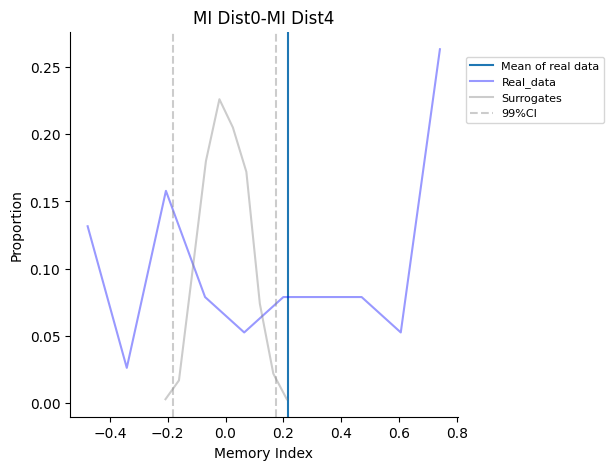

In [ ]:
X_distribution=All_MItrl_REC[0]-np.nanmean(All_MItrl_REC[4])
hist0=np.histogram(np.nanmean(MI_shuff_Surr_MI0MI4, axis=1))
hist1=np.histogram(X_distribution)
fig,axs=plt.subplots(figsize=(5,5))
axs.axvline(np.mean(X_distribution), label='Mean of real data')
axs.plot(hist1[1][:-1]+(hist1[1][:-1][1]- hist1[1][:-1][0])/2,hist1[0]/np.sum(hist1[0]), label="Real_data", color='blue', alpha=0.4)
axs.plot(hist0[1][:-1]+(hist0[1][:-1][1]- hist0[1][:-1][0])/2,hist0[0]/np.sum(hist0[0]), label="Surrogates", color='grey', alpha=0.4)
axs.axvline(np.percentile(np.nanmean(MI_shuff_Surr_MI0MI4, axis=1),[99.5, .5])[0], linestyle='--', color='grey', alpha=0.4, label='99%CI')
axs.axvline(np.percentile(np.nanmean(MI_shuff_Surr_MI0MI4, axis=1),[99.5, .5])[1], linestyle='--', color='grey', alpha=0.4)
axs.spines[['top', 'right']].set_visible(False)
axs.set_ylabel('Proportion')
axs.set_xlabel('Memory Index')
axs.set_title('MI Dist0-MI Dist4')
axs.legend(loc='upper center', bbox_to_anchor=(1.20, .95), fancybox=True, fontsize=8)
# axs.set_aspect('equal', adjustable='box')
# fig.tight_layout()

## BIG HIST

In [ ]:
Nshuffles=5000
MI_shuff_Surr=np.full((Nshuffles, 5), np.nan)
for n in range(Nshuffles):
  MI_shuff_Surr[n]=((surrogastes_distance_big_Hist(distance_seq_REC,NON_0_hist_seq_REC, NON_0_port_seq_REC)))

In [ ]:
Nshuffles=5000
MI_shuff_Surr24h=np.full((Nshuffles, 5), np.nan)
for n in range(Nshuffles):
  MI_shuff_Surr24h[n]=((surrogates_24h_big_Hist(NON_0_hist_seq_REC, NON_0_port_seq_REC)))

In [ ]:
folder = "/content/drive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/"
file_name = "Shuffle_rec24h_BIGHIST_HighPerf.csv"
np.savetxt(folder + file_name, MI_shuff_Surr24h, delimiter=",")

In [ ]:
##CONTROL
hist_seq=NON_0_hist_seq_REC
port_seq=NON_0_port_seq_REC
yes_seq=[np.roll(seq,1) for seq in NON_0_port_seq_REC]
distance_seq=distance_seq_REC


Hist_data = np.array(list(chain.from_iterable(hist_seq)))
new_port_seq=np.array(list(chain.from_iterable(port_seq)))
new_yes_seq=np.array(list(chain.from_iterable(yes_seq)))

distance_seq=list(chain.from_iterable(distance_seq))

sess0=np.array(distance_seq)==0.0
sess1=np.array(distance_seq)==1.0
sess2=np.array(distance_seq)==2.0
sess3=np.array(distance_seq)==3.0
sess4=np.array(distance_seq)==4.0

## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist0=np.sum([np.roll(Hist_data[sess0][ss],8-int(new_port_seq[sess0][ss]), axis=0) for ss in range(len(Hist_data[sess0]))], axis=0)
big_hist1=np.sum([np.roll(Hist_data[sess1][ss],8-int(new_port_seq[sess1][ss]), axis=0) for ss in range(len(Hist_data[sess1]))], axis=0)
big_hist2=np.sum([np.roll(Hist_data[sess2][ss],8-int(new_port_seq[sess2][ss]), axis=0) for ss in range(len(Hist_data[sess2]))], axis=0)
big_hist3=np.sum([np.roll(Hist_data[sess3][ss],8-int(new_port_seq[sess3][ss]), axis=0) for ss in range(len(Hist_data[sess3]))], axis=0)
big_hist4=np.sum([np.roll(Hist_data[sess4][ss],8-int(new_port_seq[sess4][ss]), axis=0) for ss in range(len(Hist_data[sess4]))], axis=0)


## I am ccomputing now the MI of that big Hist with correct port as 8 in all the cases
MI_Surr0=MemoryIndexbyTrl(big_hist0, 8)
MI_Surr1=MemoryIndexbyTrl(big_hist1, 8)
MI_Surr2=MemoryIndexbyTrl(big_hist2, 8)
MI_Surr3=MemoryIndexbyTrl(big_hist3, 8)
MI_Surr4=MemoryIndexbyTrl(big_hist4, 8)


## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist24h0=np.sum([np.roll(Hist_data[sess0][ss],8-int(new_yes_seq[sess0][ss]), axis=0) for ss in range(len(Hist_data[sess0]))], axis=0)
big_hist24h1=np.sum([np.roll(Hist_data[sess1][ss],8-int(new_yes_seq[sess1][ss]), axis=0) for ss in range(len(Hist_data[sess1]))], axis=0)
big_hist24h2=np.sum([np.roll(Hist_data[sess2][ss],8-int(new_yes_seq[sess2][ss]), axis=0) for ss in range(len(Hist_data[sess2]))], axis=0)
big_hist24h3=np.sum([np.roll(Hist_data[sess3][ss],8-int(new_yes_seq[sess3][ss]), axis=0) for ss in range(len(Hist_data[sess3]))], axis=0)
big_hist24h4=np.sum([np.roll(Hist_data[sess4][ss],8-int(new_yes_seq[sess4][ss]), axis=0) for ss in range(len(Hist_data[sess4]))], axis=0)

## I am ccomputing now the MI of that big Hist with correct port as 8 in all the cases
MI_Surr24h0=MemoryIndexbyTrl(big_hist24h0, 8)
MI_Surr24h1=MemoryIndexbyTrl(big_hist24h1, 8)
MI_Surr24h2=MemoryIndexbyTrl(big_hist24h2, 8)
MI_Surr24h3=MemoryIndexbyTrl(big_hist24h3, 8)
MI_Surr24h4=MemoryIndexbyTrl(big_hist24h4, 8)

MIs_distances_REC=np.array([MI_Surr0, MI_Surr1,MI_Surr2,MI_Surr3, MI_Surr4])
MIs_distances24h_REC=np.array([MI_Surr24h0, MI_Surr24h1,MI_Surr24h2,MI_Surr24h3, MI_Surr24h4])

In [ ]:
##NMDA
hist_seq_NMDA=NON_0_hist_seq_REC_NMDA
port_seq_NMDA=NON_0_port_seq_REC_NMDA
yes_seq_NMDA=[np.roll(seq,1) for seq in NON_0_port_seq_REC_NMDA]
distance_seq_NMDA=distance_seq_REC_NMDA


Hist_data_NMDA = np.array(list(chain.from_iterable(hist_seq_NMDA)))
new_port_seq_NMDA=np.array(list(chain.from_iterable(port_seq_NMDA)))
new_yes_seq_NMDA=np.array(list(chain.from_iterable(yes_seq_NMDA)))

distance_seq_NMDA=list(chain.from_iterable(distance_seq_NMDA))

sess0_NMDA=np.array(distance_seq_NMDA)==0.0
sess1_NMDA=np.array(distance_seq_NMDA)==1.0
sess2_NMDA=np.array(distance_seq_NMDA)==2.0
sess3_NMDA=np.array(distance_seq_NMDA)==3.0
sess4_NMDA=np.array(distance_seq_NMDA)==4.0

## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist0_NMDA=np.sum([np.roll(Hist_data_NMDA[sess0_NMDA][ss],8-int(new_port_seq_NMDA[sess0_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess0_NMDA]))], axis=0)
big_hist1_NMDA=np.sum([np.roll(Hist_data_NMDA[sess1_NMDA][ss],8-int(new_port_seq_NMDA[sess1_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess1_NMDA]))], axis=0)
big_hist2_NMDA=np.sum([np.roll(Hist_data_NMDA[sess2_NMDA][ss],8-int(new_port_seq_NMDA[sess2_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess2_NMDA]))], axis=0)
big_hist3_NMDA=np.sum([np.roll(Hist_data_NMDA[sess3_NMDA][ss],8-int(new_port_seq_NMDA[sess3_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess3_NMDA]))], axis=0)
big_hist4_NMDA=np.sum([np.roll(Hist_data_NMDA[sess4_NMDA][ss],8-int(new_port_seq_NMDA[sess4_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess4_NMDA]))], axis=0)


## I am ccomputing now the MI of that big Hist with correct port as 8 in all the cases
MI_Surr0_NMDA=MemoryIndexbyTrl(big_hist0_NMDA, 8)
MI_Surr1_NMDA=MemoryIndexbyTrl(big_hist1_NMDA, 8)
MI_Surr2_NMDA=MemoryIndexbyTrl(big_hist2_NMDA, 8)
MI_Surr3_NMDA=MemoryIndexbyTrl(big_hist3_NMDA, 8)
MI_Surr4_NMDA=MemoryIndexbyTrl(big_hist4_NMDA, 8)


## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist24h0_NMDA=np.sum([np.roll(Hist_data_NMDA[sess0_NMDA][ss],8-int(new_yes_seq_NMDA[sess0_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess0_NMDA]))], axis=0)
big_hist24h1_NMDA=np.sum([np.roll(Hist_data_NMDA[sess1_NMDA][ss],8-int(new_yes_seq_NMDA[sess1_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess1_NMDA]))], axis=0)
big_hist24h2_NMDA=np.sum([np.roll(Hist_data_NMDA[sess2_NMDA][ss],8-int(new_yes_seq_NMDA[sess2_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess2_NMDA]))], axis=0)
big_hist24h3_NMDA=np.sum([np.roll(Hist_data_NMDA[sess3_NMDA][ss],8-int(new_yes_seq_NMDA[sess3_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess3_NMDA]))], axis=0)
big_hist24h4_NMDA=np.sum([np.roll(Hist_data_NMDA[sess4_NMDA][ss],8-int(new_yes_seq_NMDA[sess4_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess4_NMDA]))], axis=0)

## I am ccomputing now the MI of that big Hist with correct port as 8 in all the cases
MI_Surr24h0_NMDA=MemoryIndexbyTrl(big_hist24h0_NMDA, 8)
MI_Surr24h1_NMDA=MemoryIndexbyTrl(big_hist24h1_NMDA, 8)
MI_Surr24h2_NMDA=MemoryIndexbyTrl(big_hist24h2_NMDA, 8)
MI_Surr24h3_NMDA=MemoryIndexbyTrl(big_hist24h3_NMDA, 8)
MI_Surr24h4_NMDA=MemoryIndexbyTrl(big_hist24h4_NMDA, 8)

MIs_distances_REC_NMDA=np.array([MI_Surr0_NMDA, MI_Surr1_NMDA,MI_Surr2_NMDA,MI_Surr3_NMDA, MI_Surr4_NMDA])
MIs_distances24h_REC_NMDA=np.array([MI_Surr24h0_NMDA, MI_Surr24h1_NMDA,MI_Surr24h2_NMDA,MI_Surr24h3_NMDA, MI_Surr24h4_NMDA])

In [ ]:
## Importing Surrogates:
MI_shuff_Surr = np.genfromtxt("/content/drive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_recBIGHIST_all_Sessions.csv",  delimiter=",")
MI_shuff_Surr24h= np.genfromtxt("/content/drive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_recBIGHIST24h_all_Sessions.csv",  delimiter=",")
MI_shuff_Surr_NMDA = np.genfromtxt("/content/drive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_rec_BIGHIST_all_Sessions_NMDA.csv",  delimiter=",")
MI_shuff_Surr24h_NMDA= np.genfromtxt("/content/drive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_rec_BIGHIST24h_all_Sessions_NMDA.csv",  delimiter=",")

Text(0.5, 0.98, 'Memory Index by Distance to previous day rewarded port  \nREC [all sessions]')

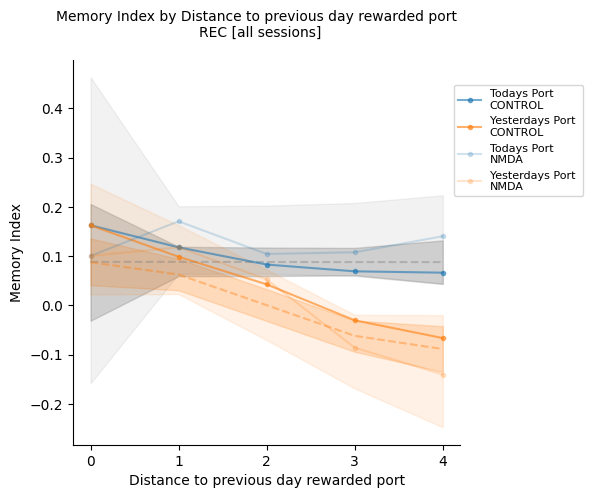

In [ ]:
NumTrials=10
##CONTROL
All_MIShuffREC_List_Dist_means=np.array([np.mean(MI_shuff_Surr[:,0]), np.mean(MI_shuff_Surr[:,1]), np.mean(MI_shuff_Surr[:,2]), np.mean(MI_shuff_Surr[:,3]),np.mean(MI_shuff_Surr[:,4])])
All_MIShuffRECListREC_CI99=np.array([np.percentile(MI_shuff_Surr[:,0], [99.5, .5]),np.percentile(MI_shuff_Surr[:,1], [99.5, .5]),np.percentile(MI_shuff_Surr[:,2], [99.5, .5]),np.percentile(MI_shuff_Surr[:,3], [99.5, .5]), np.percentile(MI_shuff_Surr[:,4], [99.5, .5])])
All_MIShuffREC24_List_Dist_means=np.array([np.mean(MI_shuff_Surr24h[:,0]), np.mean(MI_shuff_Surr24h[:,1]), np.mean(MI_shuff_Surr24h[:,2]), np.mean(MI_shuff_Surr24h[:,3]),np.mean(MI_shuff_Surr24h[:,4])])
All_MIShuffRECListREC24_CI99=np.array([np.percentile(MI_shuff_Surr24h[:,0], [99.5, .5]),np.percentile(MI_shuff_Surr24h[:,1], [99.5, .5]),np.percentile(MI_shuff_Surr24h[:,2], [99.5, .5]),np.percentile(MI_shuff_Surr24h[:,3], [99.5, .5]), np.percentile(MI_shuff_Surr24h[:,4], [99.5, .5])])
##FIGURE
x=np.arange(0, len(MIs_distances_REC), 1)
fig,axs=plt.subplots(figsize=(5,5))
##CONTROL
axs.plot( np.array(All_MIShuffREC_List_Dist_means),'--' ,color='grey', alpha=0.4)
axs.fill_between(x, np.array(All_MIShuffRECListREC_CI99)[:,0],np.array(All_MIShuffRECListREC_CI99)[:,1], color='grey', alpha=0.3)
axs.plot(x,MIs_distances_REC, '.-', alpha=0.6 ,label='Todays Port \nCONTROL')
axs.plot( np.array(All_MIShuffREC24_List_Dist_means),'--' ,color='tab:orange', alpha=0.4)
axs.fill_between(x, np.array(All_MIShuffRECListREC24_CI99)[:,0],np.array(All_MIShuffRECListREC24_CI99)[:,1], color='tab:orange', alpha=0.2)
axs.plot(x,MIs_distances24h_REC, '.-', alpha=0.6 ,label='Yesterdays Port \nCONTROL')

##NMDA
All_MIShuffREC_List_Dist_means_NMDA=np.array([np.mean(MI_shuff_Surr_NMDA[:,0]), np.mean(MI_shuff_Surr_NMDA[:,1]), np.mean(MI_shuff_Surr_NMDA[:,2]), np.mean(MI_shuff_Surr_NMDA[:,3]),np.mean(MI_shuff_Surr_NMDA[:,4])])
All_MIShuffRECListREC_CI99_NMDA=np.array([np.percentile(MI_shuff_Surr_NMDA[:,0], [99.5, .5]),np.percentile(MI_shuff_Surr_NMDA[:,1], [99.5, .5]),np.percentile(MI_shuff_Surr_NMDA[:,2], [99.5, .5]),np.percentile(MI_shuff_Surr_NMDA[:,3], [99.5, .5]), np.percentile(MI_shuff_Surr_NMDA[:,4], [99.5, .5])])
All_MIShuffREC24_List_Dist_means_NMDA=np.array([np.mean(MI_shuff_Surr24h_NMDA[:,0]), np.mean(MI_shuff_Surr24h_NMDA[:,1]), np.mean(MI_shuff_Surr24h_NMDA[:,2]), np.mean(MI_shuff_Surr24h_NMDA[:,3]),np.mean(MI_shuff_Surr24h_NMDA[:,4])])
All_MIShuffRECListREC24_CI99_NMDA=np.array([np.percentile(MI_shuff_Surr24h_NMDA[:,0], [99.5, .5]),np.percentile(MI_shuff_Surr24h_NMDA[:,1], [99.5, .5]),np.percentile(MI_shuff_Surr24h_NMDA[:,2], [99.5, .5]),np.percentile(MI_shuff_Surr24h_NMDA[:,3], [99.5, .5]), np.percentile(MI_shuff_Surr24h_NMDA[:,4], [99.5, .5])])

axs.plot(x,MIs_distances_REC_NMDA, '.-', color='tab:blue',alpha=0.2 ,label='Todays Port \nNMDA')
axs.fill_between(x, np.array(All_MIShuffRECListREC_CI99_NMDA)[:,0],np.array(All_MIShuffRECListREC_CI99_NMDA)[:,1], color='grey', alpha=0.1)
axs.plot(x,MIs_distances24h_REC_NMDA, '.-', color='tab:orange',alpha=0.2 ,label='Yesterdays Port \nNMDA')
axs.fill_between(x, np.array(All_MIShuffRECListREC24_CI99_NMDA)[:,0],np.array(All_MIShuffRECListREC24_CI99_NMDA)[:,1], color='tab:orange', alpha=0.1)


axs.set_ylabel('Memory Index')
axs.set_xlabel('Distance to previous day rewarded port')
axs.spines[['top', 'right']].set_visible(False)
axs.set_xticks(x)
axs.legend(loc='upper center', bbox_to_anchor=(1.15, .95), fancybox=True, fontsize=8)
# axs.set_ylim(-.3,.4)
fig.suptitle('Memory Index by Distance to previous day rewarded port  \nREC [all sessions]',fontsize=10)

In [ ]:
Nshuffles=1000
MI_shuff_Surr_x=np.full((Nshuffles, 5), np.nan)
for n in range(Nshuffles):
  MI_shuff_Surr_x[n]=((surrogastes_distance_big_Hist_MI0_MI4(distance_seq_REC,NON_0_hist_seq_REC, NON_0_port_seq_REC)))

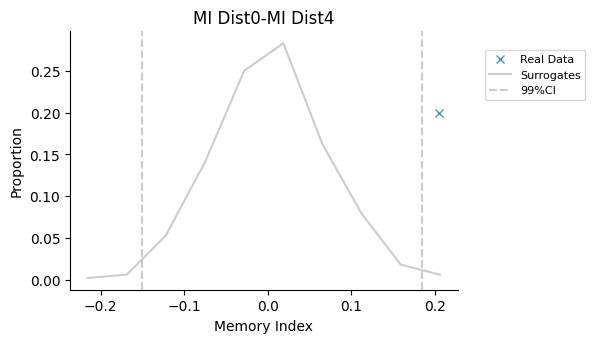

In [ ]:
x=(MIs_distances_REC[0]- MIs_distances_REC[4])
hist0=np.histogram(MI_shuff_Surr_x)
fig,axs=plt.subplots(figsize=(5,5))
axs.plot(x,0.2, 'x', color='tab:blue', alpha=0.8, label='Real Data')
axs.plot(hist0[1][:-1]+(hist0[1][:-1][1]- hist0[1][:-1][0])/2,hist0[0]/np.sum(hist0[0]), label="Surrogates", color='grey', alpha=0.4)
axs.axvline(np.percentile(MI_shuff_Surr_x,[99.5, .5])[0], linestyle='--', color='grey', alpha=0.4, label='99%CI')
axs.axvline(np.percentile(MI_shuff_Surr_x,[99.5, .5])[1], linestyle='--', color='grey', alpha=0.4)
axs.spines[['top', 'right']].set_visible(False)
axs.set_ylabel('Proportion')
axs.set_xlabel('Memory Index')
axs.set_title('MI Dist0-MI Dist4')
axs.legend(loc='upper center', bbox_to_anchor=(1.20, .95), fancybox=True, fontsize=8)
axs.set_aspect('equal', adjustable='box')
# fig.tight_layout()

In [ ]:
def surrogastes_big_Hist(hist_seq,port_seq ):
  Hist_data = np.array(list(chain.from_iterable(hist_seq)))
  new_port_seq=np.array(list(chain.from_iterable(port_seq)))
  random.shuffle(new_port_seq)


  ## I am centering all the histograms to the 8th port and adding them in a big histogram
  big_hist=np.sum([np.roll(Hist_data[ss],4-int(new_port_seq[ss]), axis=0) for ss in range(len(Hist_data))], axis=0)

  return big_hist

In [ ]:
Nshuffles=1
Hist_shuff_Surr_1=np.full((Nshuffles, 8), np.nan)
for n in range(Nshuffles):
  Hist_shuff_Surr_1[n]=((surrogastes_big_Hist(NON_0_hist_seq_REC, NON_0_port_seq_REC)))

In [ ]:
Nshuffles=5
Hist_shuff_Surr_5=np.full((Nshuffles, 8), np.nan)
for n in range(Nshuffles):
  Hist_shuff_Surr_5[n]=((surrogastes_big_Hist(NON_0_hist_seq_REC, NON_0_port_seq_REC)))

In [ ]:
Nshuffles=20
Hist_shuff_Surr_20=np.full((Nshuffles, 8), np.nan)
for n in range(Nshuffles):
  Hist_shuff_Surr_20[n]=((surrogastes_big_Hist(NON_0_hist_seq_REC, NON_0_port_seq_REC)))


In [ ]:
Nshuffles=15000
Hist_shuff_Surr_1000=np.full((Nshuffles, 8), np.nan)
for n in range(Nshuffles):
  Hist_shuff_Surr_1000[n]=((surrogastes_big_Hist(NON_0_hist_seq_REC, NON_0_port_seq_REC)))


In [ ]:
NON_0_port_seq_REC[1][-10:-7]

array([3, 4, 2])

In [ ]:
NON_0_hist_seq_REC[1][-8]

array([2, 3, 0, 1, 0, 0, 0, 0])

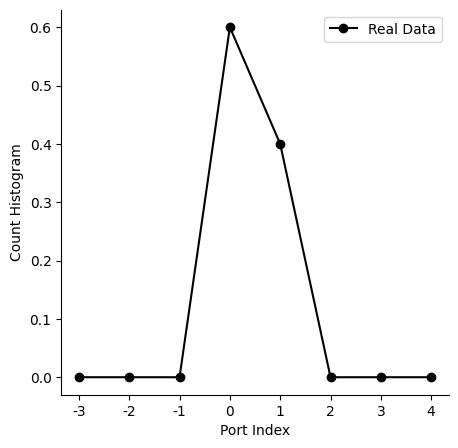

In [ ]:
hist_seq=NON_0_hist_seq_REC
port_seq=NON_0_port_seq_REC

Hist_data = np.array([0, 3, 2, 0, 0, 0, 0, 0])
new_port_seq=port_seq[1][-8]
# new_yes_seq=np.array(list(chain.from_iterable(yes_seq)))

## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist=np.roll(Hist_data,4-int(new_port_seq), axis=0)
fig,axs=plt.subplots(figsize=(5,5))
x=np.arange(8)
axs.plot(x,big_hist/np.sum(big_hist), color='black', marker='o', linestyle='-', label='Real Data')
# axs.plot(x,Hist_shuff_Surr_1[0]/np.sum(Hist_shuff_Surr_1[0]), marker='o', color='grey',alpha=0.4, linestyle='-', label='Surrogate Dataset')
# plt.plot(big_hist/np.sum(big_hist), color='black', linestyle='dotted')
xvalues=x
xlabesl=[-3,-2,-1,0,1,2,3,4]
axs.set_xticks(xvalues, xlabesl)
# axs.set_ylim(0.05, 0.25)
axs.spines[['top', 'right']].set_visible(False)
axs.set_ylabel('Count Histogram')
axs.set_xlabel('Port Index')
axs.legend()

In [ ]:
hist_seq=NON_0_hist_seq_REC
port_seq=NON_0_port_seq_REC

Hist_data = np.array(list(chain.from_iterable(hist_seq)))
new_port_seq=np.array(list(chain.from_iterable(port_seq)))
# new_yes_seq=np.array(list(chain.from_iterable(yes_seq)))

## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist=np.sum([np.roll(Hist_data[ss],4-int(new_port_seq[ss]), axis=0) for ss in range(len(Hist_data))], axis=0)
fig,axs=plt.subplots(figsize=(5,5))
x=np.arange(8)
axs.plot(x,big_hist/np.sum(big_hist), color='black', marker='o', linestyle='-', label='Real Data')
axs.plot(x,Hist_shuff_Surr_1[0]/np.sum(Hist_shuff_Surr_1[0]), marker='o', color='grey',alpha=0.4, linestyle='-', label='Surrogate Dataset')
# plt.plot(big_hist/np.sum(big_hist), color='black', linestyle='dotted')
xvalues=x
xlabesl=[-3,-2,-1,0,1,2,3,4]
axs.set_xticks(xvalues, xlabesl)
axs.set_ylim(0.05, 0.25)
axs.spines[['top', 'right']].set_visible(False)
axs.set_ylabel('Count Histogram')
axs.set_xlabel('Port Index')
axs.legend()

Text(0.5, 0, 'Port Index')

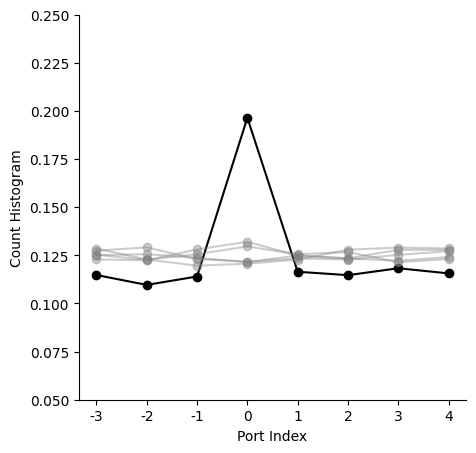

In [ ]:
hist_seq=NON_0_hist_seq_REC
port_seq=NON_0_port_seq_REC

Hist_data = np.array(list(chain.from_iterable(hist_seq)))
new_port_seq=np.array(list(chain.from_iterable(port_seq)))
# new_yes_seq=np.array(list(chain.from_iterable(yes_seq)))

## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist=np.sum([np.roll(Hist_data[ss],4-int(new_port_seq[ss]), axis=0) for ss in range(len(Hist_data))], axis=0)
fig,axs=plt.subplots(figsize=(5,5))
x=np.arange(8)
axs.plot(x,big_hist/np.sum(big_hist), color='black', marker='o', linestyle='-', label='Real Data')
# axs.plot(x,Hist_shuff_Surr_1[0]/np.sum(Hist_shuff_Surr_1[0]), marker='o', color='grey',alpha=0.2, linestyle='-', label='Surrogate Dataset: 1 Shuffle')
for i in range(len(Hist_shuff_Surr_5)):
  axs.plot(x,(Hist_shuff_Surr_5[i])/np.sum(Hist_shuff_Surr_5[i]), marker='o', color='grey',alpha=0.4, linestyle='-', label='Surrogate Dataset: 5 Shuffles')
# plt.plot(big_hist/np.sum(big_hist), color='black', linestyle='dotted')
xvalues=x
xlabesl=[-3,-2,-1,0,1,2,3,4]
axs.set_xticks(xvalues, xlabesl)
axs.set_ylim(0.05, 0.25)
axs.spines[['top', 'right']].set_visible(False)
axs.set_ylabel('Count Histogram')
axs.set_xlabel('Port Index')
# axs.legend()

Text(0.5, 0, 'Port Index')

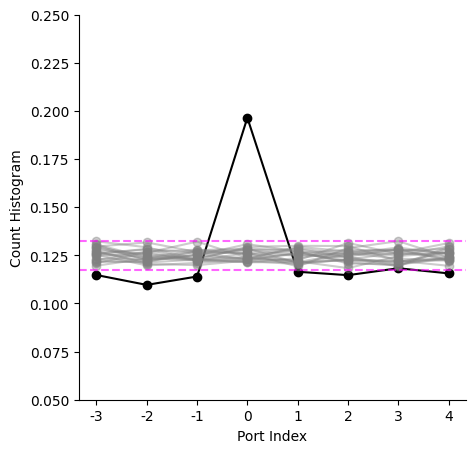

In [ ]:
hist_seq=NON_0_hist_seq_REC
port_seq=NON_0_port_seq_REC

Hist_data = np.array(list(chain.from_iterable(hist_seq)))
new_port_seq=np.array(list(chain.from_iterable(port_seq)))
# new_yes_seq=np.array(list(chain.from_iterable(yes_seq)))

## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist=np.sum([np.roll(Hist_data[ss],4-int(new_port_seq[ss]), axis=0) for ss in range(len(Hist_data))], axis=0)
fig,axs=plt.subplots(figsize=(5,5))
x=np.arange(8)
axs.plot(x,big_hist/np.sum(big_hist), color='black', marker='o', linestyle='-', label='Real Data')
# axs.plot(x,Hist_shuff_Surr_1[0]/np.sum(Hist_shuff_Surr_1[0]), marker='o', color='grey',alpha=0.2, linestyle='-', label='Surrogate Dataset: 1 Shuffle')
for i in range(len (Hist_shuff_Surr_20)):
  axs.plot(x,(Hist_shuff_Surr_20[i])/np.sum(Hist_shuff_Surr_20[i]), marker='o', color='grey',alpha=0.4, linestyle='-', label='Surrogate Dataset: 1000 Shuffles')
axs.axhline(percentiles[0], color='magenta', alpha=0.6, linestyle='--')
axs.axhline(percentiles[1], color='magenta', alpha=0.6, linestyle='--', label='99%CI')
xvalues=x
xlabesl=[-3,-2,-1,0,1,2,3,4]
axs.set_xticks(xvalues, xlabesl)
axs.set_ylim(0.05, 0.25)
axs.spines[['top', 'right']].set_visible(False)
axs.set_ylabel('Count Histogram')
axs.set_xlabel('Port Index')

In [ ]:
hist_normalizado=np.full((Nshuffles, 8), np.nan)
for i in range(len(Hist_shuff_Surr_1000)):
  hist_normalizado[i]=Hist_shuff_Surr_1000[i]/np.sum(Hist_shuff_Surr_1000[i])

Text(0.5, 0, 'Port Index')

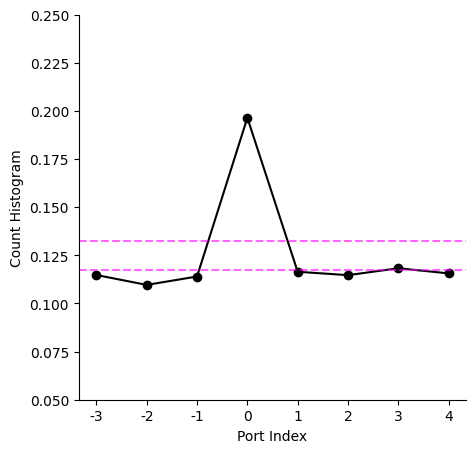

In [ ]:
hist_seq=NON_0_hist_seq_REC
port_seq=NON_0_port_seq_REC

Hist_data = np.array(list(chain.from_iterable(hist_seq)))
new_port_seq=np.array(list(chain.from_iterable(port_seq)))
# new_yes_seq=np.array(list(chain.from_iterable(yes_seq)))

## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist=np.sum([np.roll(Hist_data[ss],4-int(new_port_seq[ss]), axis=0) for ss in range(len(Hist_data))], axis=0)
percentiles=np.percentile(hist_normalizado, [99.5,0.5])
fig,axs=plt.subplots(figsize=(5,5))
x=np.arange(8)
axs.plot(x,big_hist/np.sum(big_hist), color='black', marker='o', linestyle='-', label='Real Data')
# axs.plot(x,Hist_shuff_Surr_1[0]/np.sum(Hist_shuff_Surr_1[0]), marker='o', color='grey',alpha=0.2, linestyle='-', label='Surrogate Dataset: 1 Shuffle')
# for i in range(len (Hist_shuff_Surr_1000)):
#   axs.plot(x,(Hist_shuff_Surr_1000[i])/np.sum(Hist_shuff_Surr_1000[i]), marker='o', color='grey',alpha=0.1, linestyle='-', label='Surrogate Dataset: 1000 Shuffles')
axs.axhline(percentiles[0], color='magenta', alpha=0.6, linestyle='--')
axs.axhline(percentiles[1], color='magenta', alpha=0.6, linestyle='--', label='99%CI')
xvalues=x
xlabesl=[-3,-2,-1,0,1,2,3,4]
axs.set_xticks(xvalues, xlabesl)
axs.set_ylim(0.05, 0.25)
axs.spines[['top', 'right']].set_visible(False)
axs.set_ylabel('Count Histogram')
axs.set_xlabel('Port Index')

## TESTS

In [ ]:
group1=All_MItrl_REC[0]
group2=All_MItrl_REC[4]
t_statistic, p_valor = stats.ttest_ind(group1, group2)

# Imprimir los resultados
print("Estadística t:", t_statistic)
print("Valor p:", p_valor)

Estadística t: 2.964521030267374
Valor p: 0.003290544575895793


In [ ]:
from scipy import stats
group0=All_MItrl_REC[0]
group1=All_MItrl_REC[1]
group2=All_MItrl_REC[2]
group3=All_MItrl_REC[3]
group4=All_MItrl_REC[4]
# Compute ANOVA
f_statistic, p_valor = stats.f_oneway(group0, group1, group2 ,group3, group4)

# Imprimir los resultados
print("Estadística F:", f_statistic)
print("Valor p:", p_valor)

Estadística F: 3.2271125038459467
Valor p: 0.011938371866308157


NameError: name 'All_MItrlList_Dist_means' is not defined

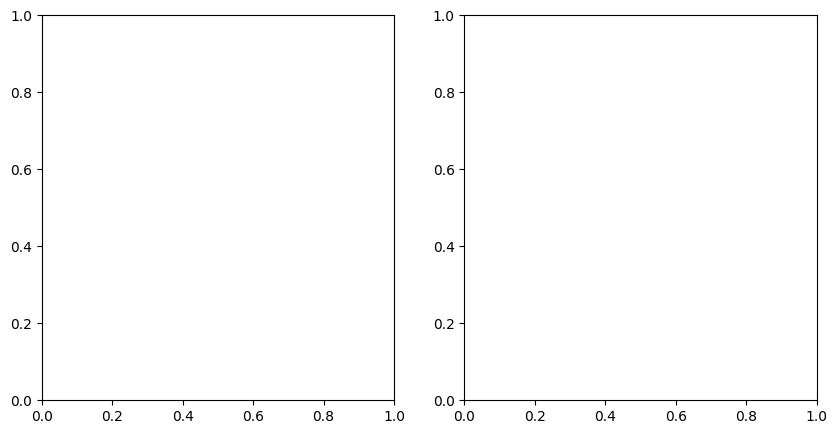

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))  #gridspec_kw={'height_ratios': [1, 2]})

x=np.arange(0, len(All_MItrlList_Dist_means), 1)
axs[0].fill_between(x,np.array(All_MItrlList_Dist_means)-np.array(All_MItrlList_Dist_CI95)[:,0], np.array(All_MItrlList_Dist_means)+np.array(All_MItrlList_Dist_CI95)[:,1],color='tab:blue', alpha=0.2)
axs[0].errorbar(x,All_MItrlList_Dist_means,  yerr=All_MItrlList_Dist_sem, fmt='.-', alpha=0.6 ,label='Todays Port')
axs[0].fill_between(x,np.array(All_MItrlLagsList_Dist_means)-np.array(All_MItrlLagsList_Dist_CI95)[:,0], np.array(All_MItrlLagsList_Dist_means)+np.array(All_MItrlLagsList_Dist_CI95)[:,1],color='tab:orange', alpha=0.1)
axs[0].errorbar(x,All_MItrlLagsList_Dist_means,  yerr=All_MItrlLagsList_Dist_sem, fmt='.-', alpha=0.6 ,label='Yesterdays Port')
axs[0].axhline(y=0,  linestyle='--', color='grey', alpha=0.2)
axs[0].set_ylabel('Memory Index')
axs[0].set_xlabel('Consecutive days Ports Distance')
axs[0].set_ylim(-.5,.5)
axs[0].set_title('MI by Distance \nTRN')
# axs[1].legend(loc='upper center', bbox_to_anchor=(1.25, 1), fancybox=True, shadow=True,  fontsize=9)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)


x=np.arange(0, len(All_MItrlListREC_Dist_means), 1)
axs[1].fill_between(x,np.array(All_MItrlListREC_Dist_means)-np.array(All_MItrlListREC_Dist_CI95)[:,0], np.array(All_MItrlListREC_Dist_means)+np.array(All_MItrlListREC_Dist_CI95)[:,1],color='tab:blue', alpha=0.2)
axs[1].errorbar(x,All_MItrlListREC_Dist_means,  yerr=All_MItrlListREC_Dist_sem, fmt='.-', alpha=0.6 ,label='Todays Port')
axs[1].fill_between(x,np.array(All_MItrlLagsListREC_Dist_means)-np.array(All_MItrlLagsListREC_Dist_CI95)[:,0], np.array(All_MItrlLagsListREC_Dist_means)+np.array(All_MItrlLagsListREC_Dist_CI95)[:,1],color='tab:orange', alpha=0.1)
axs[1].errorbar(x,All_MItrlLagsListREC_Dist_means,  yerr=All_MItrlLagsListREC_Dist_sem, fmt='.-', alpha=0.6 ,label='Yesterdays Port')
axs[1].axhline(y=0,  linestyle='--', color='grey', alpha=0.2)
axs[1].set_ylabel('Memory Index')
axs[1].set_xlabel('Consecutive days Ports Distance')
axs[1].set_ylim(-.5,.5)
axs[1].set_title('MI by Distance \nREC')
axs[1].legend(loc='upper center', bbox_to_anchor=(1.25, 1), fancybox=True, shadow=True,  fontsize=9)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

fig.text( 0.95,0.9, 'NTrials=20', ha='center', va='center', fontsize=9)#, bbox=dict(facecolor='tab:blue', alpha=0.1))


In [ ]:
diff=[]
for i in range(27):
  NumTrials=i
  All_MItrlListREC_Dist_mean=np.nanmean(All_MItrlListREC[4][:,:NumTrials])
  All_MItrlLagsListREC_Dist_mean=np.nanmean(All_MItrlLagsListREC[4][:,:NumTrials])
  diff.append(All_MItrlListREC_Dist_mean-All_MItrlLagsListREC_Dist_mean)

# for i in range(diff[~np.isnan(diff)])
diff=np.array(diff)
indices = [index for index, element in enumerate(diff) if element == max(diff[~np.isnan(diff)])]
indices[0]


<ipython-input-469-d1ee98fee01f>:4: RuntimeWarning: Mean of empty slice
  All_MItrlListREC_Dist_mean=np.nanmean(All_MItrlListREC[4][:,:NumTrials])
<ipython-input-469-d1ee98fee01f>:5: RuntimeWarning: Mean of empty slice
  All_MItrlLagsListREC_Dist_mean=np.nanmean(All_MItrlLagsListREC[4][:,:NumTrials])


19

## 5 by 5 sessions

<ipython-input-354-26b118f6f334>:18: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot(x,(np.nanmean(np.nanmean(MItrl_REC_[:,idx:idx+5],axis=1),axis=0)), '.-' ,alpha=0.6 ,label='Todays Port')
<ipython-input-354-26b118f6f334>:19: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot(x,(np.nanmean(np.nanmean(MItrl_lags_REC_[:,idx:idx+5],axis=1),axis=0)), '.-' , alpha=0.5 ,label='Yesterdays Port')


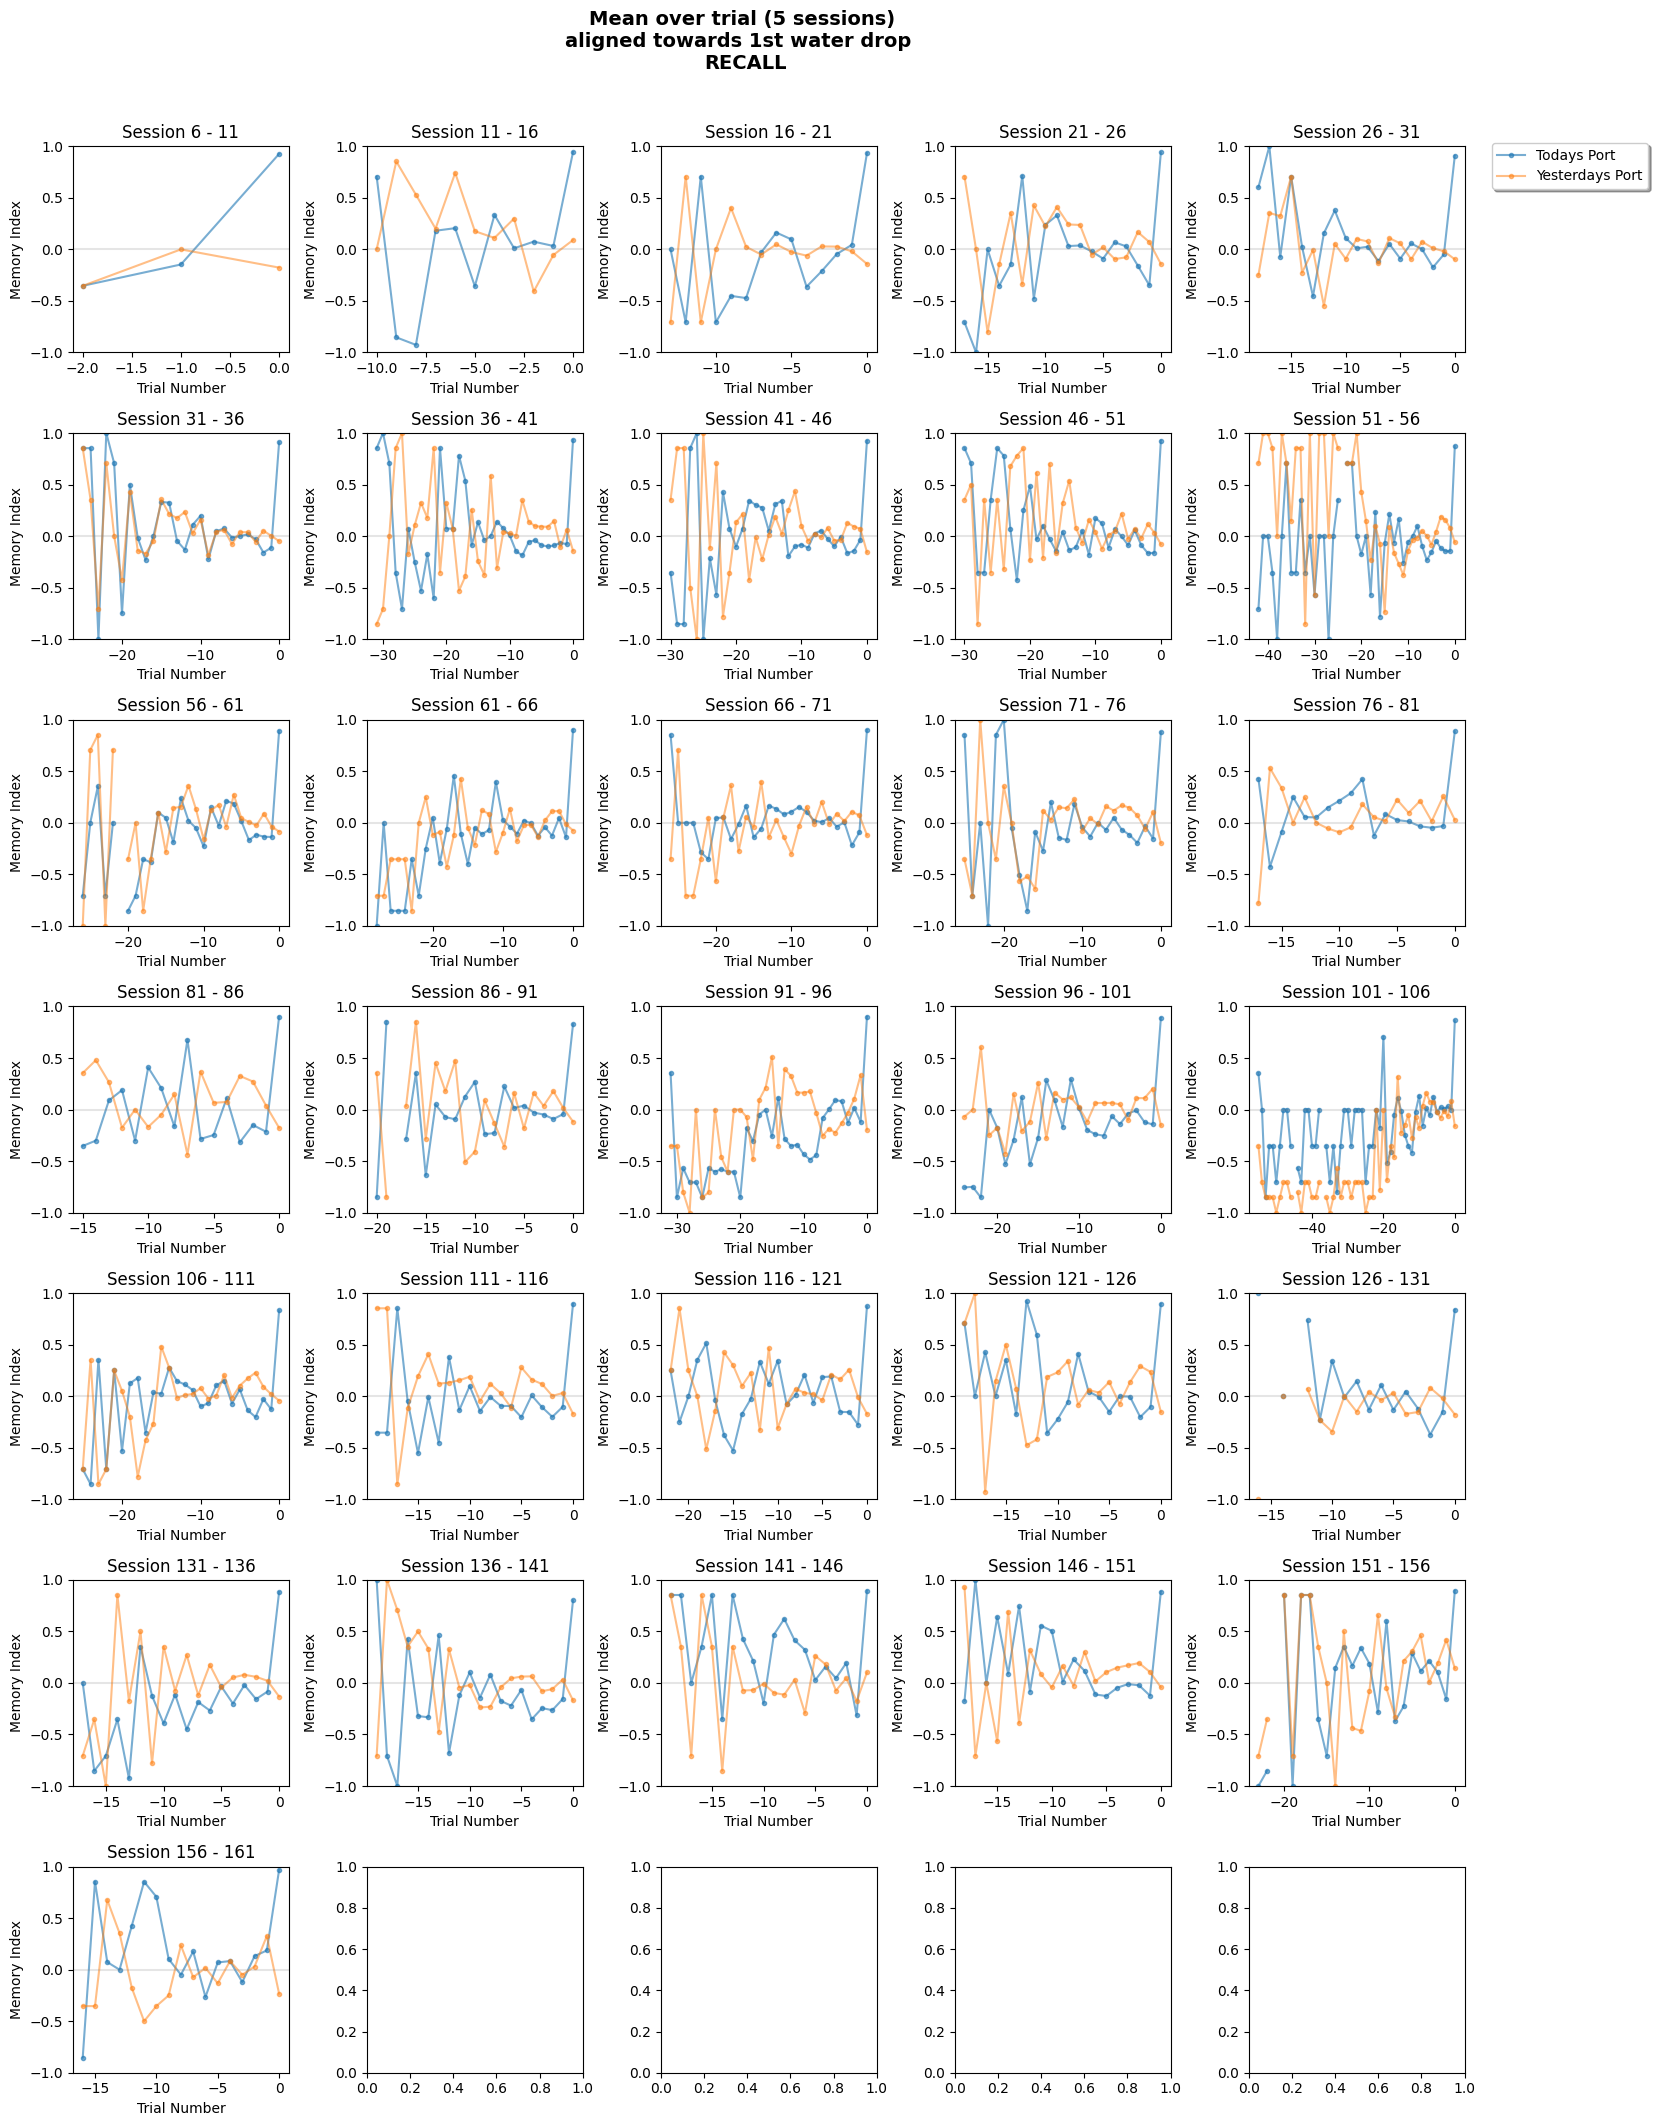

In [ ]:
## PLOTTING BY SESSION
num_columns = 5
n = (MItrl_lags_REC_.shape[1]/5) // num_columns

# Find the indices of non-empty subplots
non_empty_indices = [i for i in range(0,MItrl_lags_REC_.shape[1],5) if not np.isnan(MItrl_lags_REC_[:,i:i+5]).all()]

# Calculate the new number of rows based on non-empty subplots
n_rows = len(non_empty_indices) // num_columns + int(len(non_empty_indices) % num_columns != 0)
x=-np.array(list(reversed(np.arange(len(MItrl_REC_[0][0])))))

# Create a figure and an array of subplots
fig, axs = plt.subplots(n_rows, num_columns, figsize=(15, 3 * n_rows))

for i, idx in enumerate(non_empty_indices):
    # print(i, idx)
    row_idx, col_idx = divmod(i, num_columns)
    axs[row_idx, col_idx].plot(x,(np.nanmean(np.nanmean(MItrl_REC_[:,idx:idx+5],axis=1),axis=0)), '.-' ,alpha=0.6 ,label='Todays Port')
    axs[row_idx, col_idx].plot(x,(np.nanmean(np.nanmean(MItrl_lags_REC_[:,idx:idx+5],axis=1),axis=0)), '.-' , alpha=0.5 ,label='Yesterdays Port')
    axs[row_idx, col_idx].axhline(0, color='grey', alpha=0.2)
    axs[row_idx, col_idx].set_title(f'Session {idx + 1} - {idx+5 + 1}')
    axs[row_idx, col_idx].set_ylim(-1, 1)
    axs[row_idx, col_idx].set_ylabel('Memory Index')
    axs[row_idx, col_idx].set_xlabel('Trial Number')
    # axs[row_idx, col_idx].set_xticklabels()
fig.legend(loc='upper center', bbox_to_anchor=(1.05, .95), fancybox=True, shadow=True, labels=['Todays Port', 'Yesterdays Port'])

# Adjust layout to prevent clipping of titles
fig.suptitle('Mean over trial (5 sessions) \naligned towards 1st water drop  \nRECALL', x=0.5, y=1.01, fontweight='bold', fontsize=14)
fig.tight_layout()
# Show the figure
plt.show()

<ipython-input-45-e834da9f5f6c>:18: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot((np.nanmean(np.nanmean(MItrl_REC[:,idx:idx+5],axis=1),axis=0)), '.-' ,alpha=0.6 ,label='Todays Port')
<ipython-input-45-e834da9f5f6c>:19: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot((np.nanmean(np.nanmean(MItrl_lags_REC[:,idx:idx+5],axis=1),axis=0)), '.-' , alpha=0.5 ,label='Yesterdays Port')


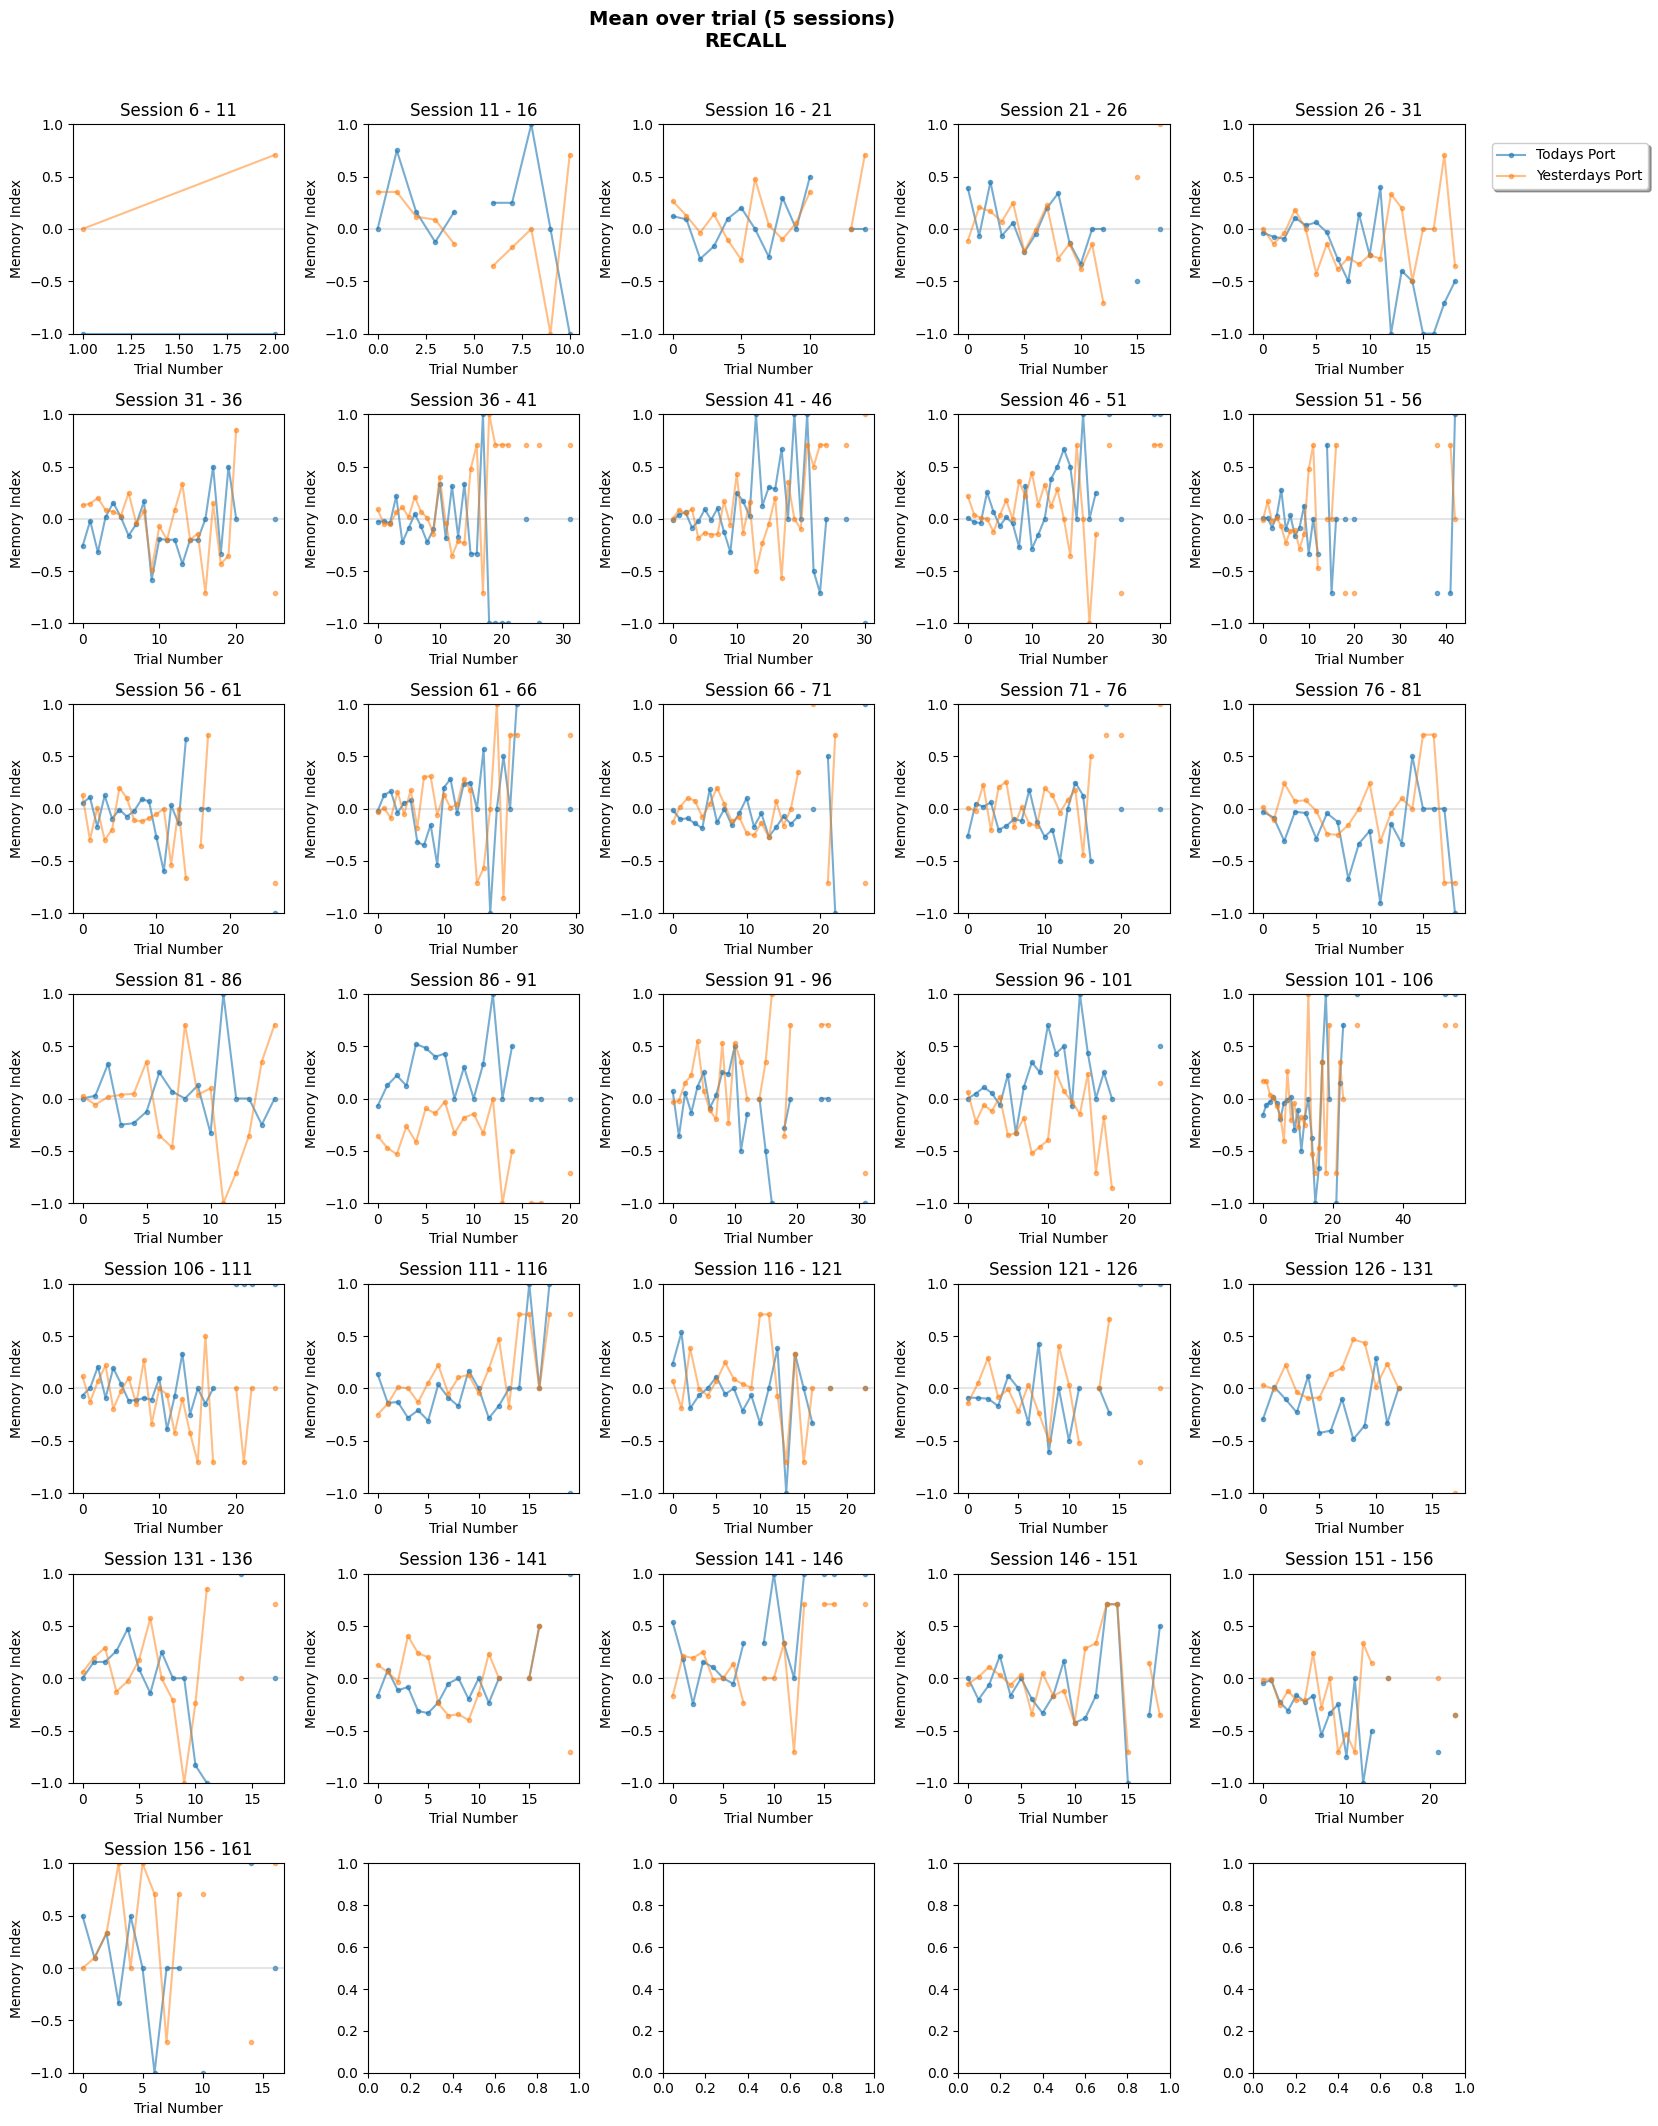

In [ ]:
## PLOTTING BY SESSION
num_columns = 5
n = (MItrl_lags_REC_.shape[1]/5) // num_columns

# Find the indices of non-empty subplots
non_empty_indices = [i for i in range(0,MItrl_lags_REC.shape[1],5) if not np.isnan(MItrl_lags_REC_[:,i:i+5]).all()]

# Calculate the new number of rows based on non-empty subplots
n_rows = len(non_empty_indices) // num_columns + int(len(non_empty_indices) % num_columns != 0)
x=-np.array(list(reversed(np.arange(len(MItrl_REC[0][0])))))

# Create a figure and an array of subplots
fig, axs = plt.subplots(n_rows, num_columns, figsize=(15, 3 * n_rows))

for i, idx in enumerate(non_empty_indices):
    # print(i, idx)
    row_idx, col_idx = divmod(i, num_columns)
    axs[row_idx, col_idx].plot((np.nanmean(np.nanmean(MItrl_REC[:,idx:idx+5],axis=1),axis=0)), '.-' ,alpha=0.6 ,label='Todays Port')
    axs[row_idx, col_idx].plot((np.nanmean(np.nanmean(MItrl_lags_REC[:,idx:idx+5],axis=1),axis=0)), '.-' , alpha=0.5 ,label='Yesterdays Port')
    axs[row_idx, col_idx].axhline(0, color='grey', alpha=0.2)
    axs[row_idx, col_idx].set_title(f'Session {idx + 1} - {idx+5 + 1}')
    axs[row_idx, col_idx].set_ylim(-1, 1)
    axs[row_idx, col_idx].set_ylabel('Memory Index')
    axs[row_idx, col_idx].set_xlabel('Trial Number')
    # axs[row_idx, col_idx].set_xticklabels()
fig.legend(loc='upper center', bbox_to_anchor=(1.05, .95), fancybox=True, shadow=True, labels=['Todays Port', 'Yesterdays Port'])

# Adjust layout to prevent clipping of titles
fig.suptitle('Mean over trial (5 sessions) \nRECALL', x=0.5, y=1.01, fontweight='bold', fontsize=14)
fig.tight_layout()
# Show the figure
plt.show()

## 10 by 10 sessions

<ipython-input-42-4fa5c3b8ac53>:18: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot(x,(np.nanmean(np.nanmean(MItrl_REC_[:,idx:idx+10],axis=1),axis=0)), '.-' ,alpha=0.6 ,label='Todays Port')
<ipython-input-42-4fa5c3b8ac53>:19: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot(x,(np.nanmean(np.nanmean(MItrl_lags_REC_[:,idx:idx+10],axis=1),axis=0)), '.-' , alpha=0.5 ,label='Yesterdays Port')


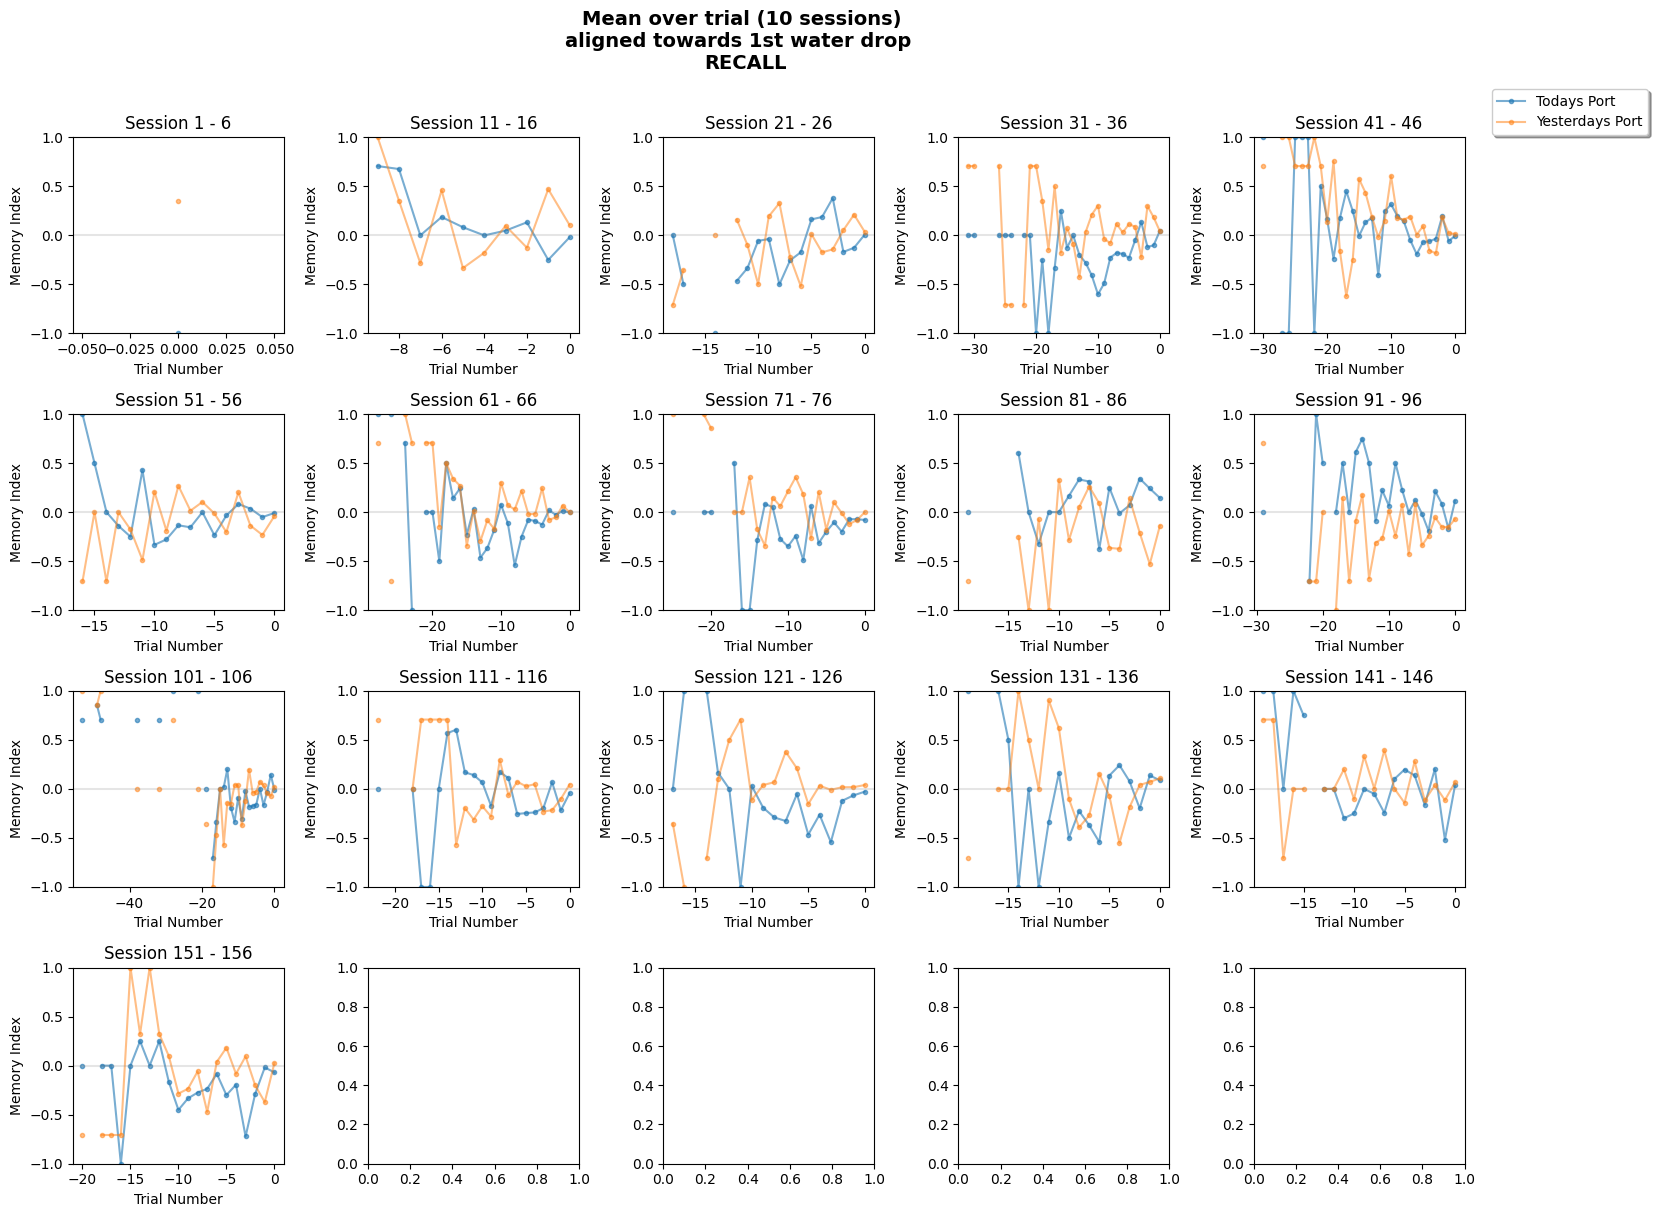

In [ ]:
## PLOTTING BY SESSION
num_columns = 5
n = (MItrl_lags_REC_.shape[1]/5) // num_columns

# Find the indices of non-empty subplots
non_empty_indices = [i for i in range(0,MItrl_lags_REC_.shape[1],10) if not np.isnan(MItrl_lags_REC_[:,i:i+10]).all()]

# Calculate the new number of rows based on non-empty subplots
n_rows = len(non_empty_indices) // num_columns + int(len(non_empty_indices) % num_columns != 0)
x=-np.array(list(reversed(np.arange(len(MItrl_REC_[0][0])))))

# Create a figure and an array of subplots
fig, axs = plt.subplots(n_rows, num_columns, figsize=(15, 3 * n_rows))

for i, idx in enumerate(non_empty_indices):
    # print(i, idx)
    row_idx, col_idx = divmod(i, num_columns)
    axs[row_idx, col_idx].plot(x,(np.nanmean(np.nanmean(MItrl_REC_[:,idx:idx+10],axis=1),axis=0)), '.-' ,alpha=0.6 ,label='Todays Port')
    axs[row_idx, col_idx].plot(x,(np.nanmean(np.nanmean(MItrl_lags_REC_[:,idx:idx+10],axis=1),axis=0)), '.-' , alpha=0.5 ,label='Yesterdays Port')
    axs[row_idx, col_idx].axhline(0, color='grey', alpha=0.2)
    axs[row_idx, col_idx].set_title(f'Session {idx + 1} - {idx+5 + 1}')
    axs[row_idx, col_idx].set_ylim(-1, 1)
    axs[row_idx, col_idx].set_ylabel('Memory Index')
    axs[row_idx, col_idx].set_xlabel('Trial Number')
    # axs[row_idx, col_idx].set_xticklabels()
fig.legend(loc='upper center', bbox_to_anchor=(1.05, .95), fancybox=True, shadow=True, labels=['Todays Port', 'Yesterdays Port'])

# Adjust layout to prevent clipping of titles
fig.suptitle('Mean over trial (10 sessions) \naligned towards 1st water drop  \nRECALL', x=0.5, y=1.01, fontweight='bold', fontsize=14)
fig.tight_layout()
# Show the figure
plt.show()

<ipython-input-44-e2da51205027>:18: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot((np.nanmean(np.nanmean(MItrl_REC[:,idx:idx+10],axis=1),axis=0)), '.-' ,alpha=0.6 ,label='Todays Port')
<ipython-input-44-e2da51205027>:19: RuntimeWarning: Mean of empty slice
  axs[row_idx, col_idx].plot((np.nanmean(np.nanmean(MItrl_lags_REC[:,idx:idx+10],axis=1),axis=0)), '.-' , alpha=0.5 ,label='Yesterdays Port')


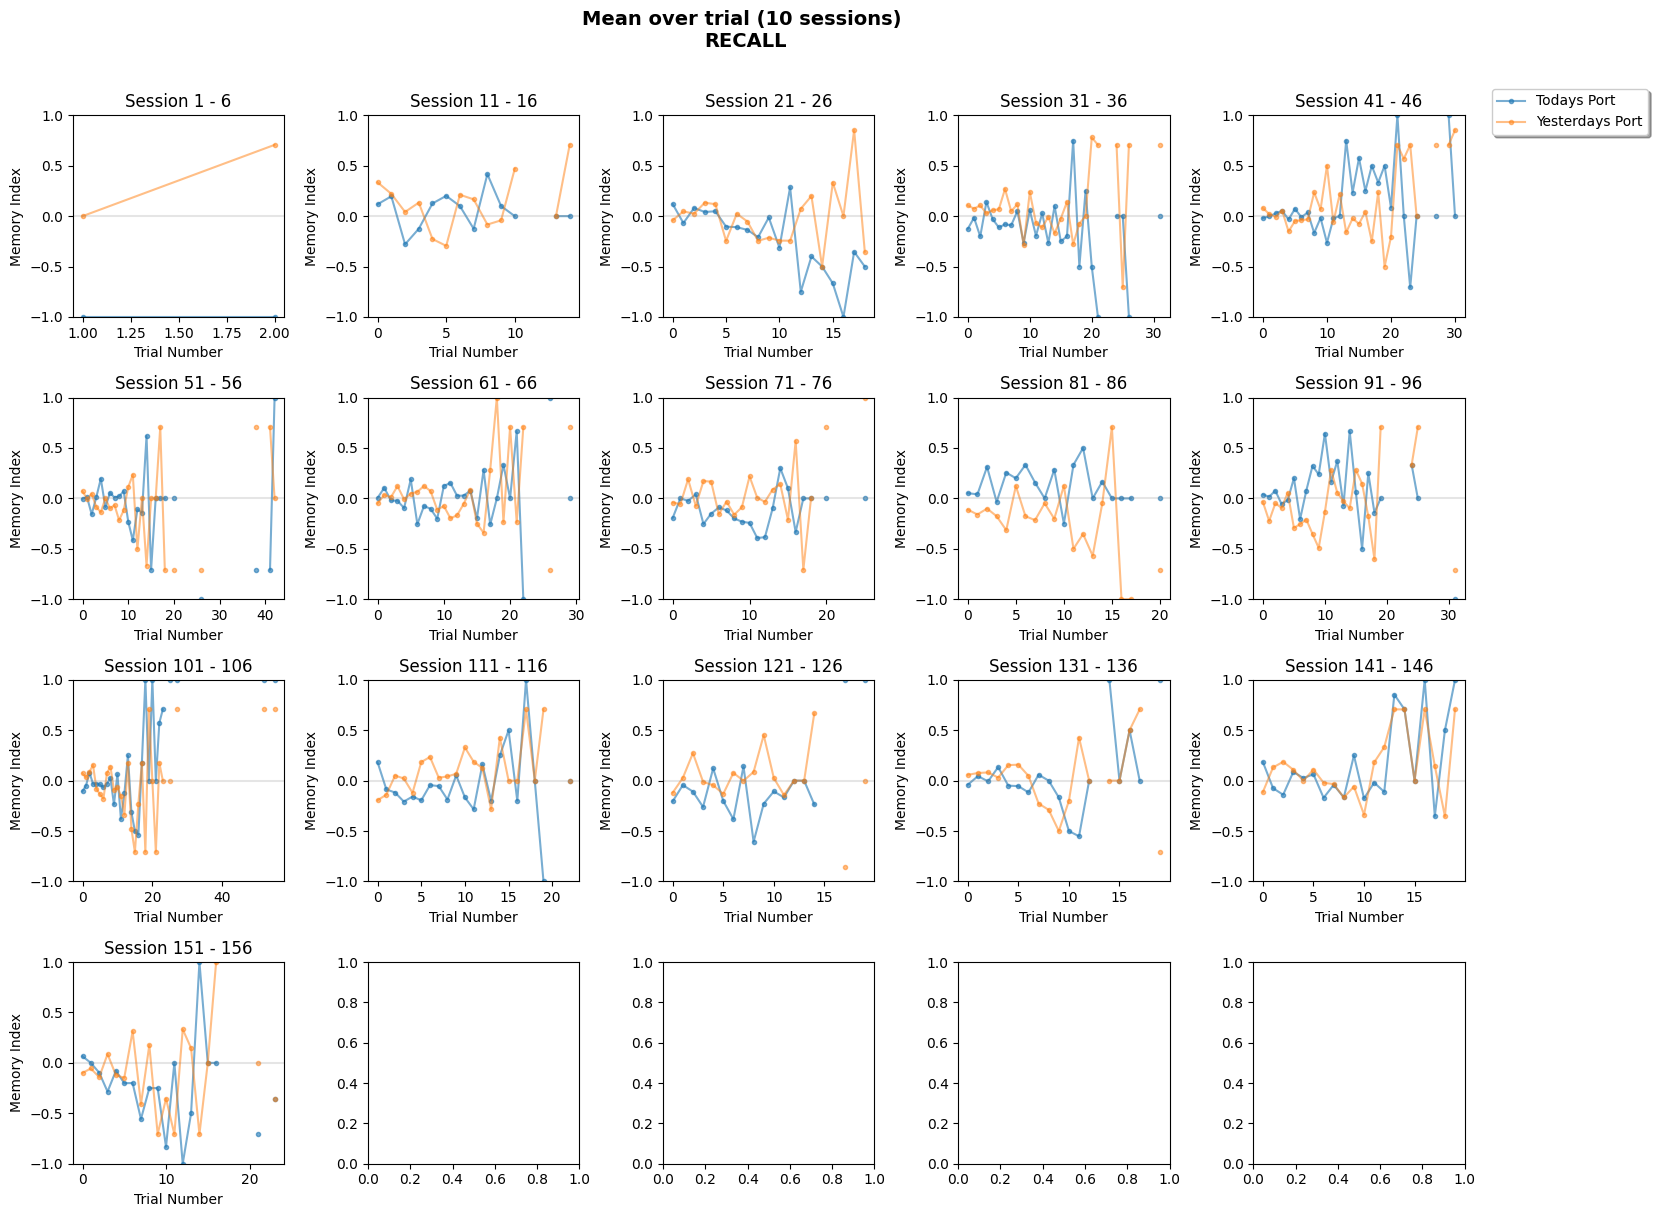

In [ ]:
## PLOTTING BY SESSION
num_columns = 5
n = (MItrl_lags_REC.shape[1]/5) // num_columns

# Find the indices of non-empty subplots
non_empty_indices = [i for i in range(0,MItrl_lags_REC.shape[1],10) if not np.isnan(MItrl_lags_REC[:,i:i+10]).all()]

# Calculate the new number of rows based on non-empty subplots
n_rows = len(non_empty_indices) // num_columns + int(len(non_empty_indices) % num_columns != 0)
x=-np.array(list(reversed(np.arange(len(MItrl_REC[0][0])))))

# Create a figure and an array of subplots
fig, axs = plt.subplots(n_rows, num_columns, figsize=(15, 3 * n_rows))

for i, idx in enumerate(non_empty_indices):
    # print(i, idx)
    row_idx, col_idx = divmod(i, num_columns)
    axs[row_idx, col_idx].plot((np.nanmean(np.nanmean(MItrl_REC[:,idx:idx+10],axis=1),axis=0)), '.-' ,alpha=0.6 ,label='Todays Port')
    axs[row_idx, col_idx].plot((np.nanmean(np.nanmean(MItrl_lags_REC[:,idx:idx+10],axis=1),axis=0)), '.-' , alpha=0.5 ,label='Yesterdays Port')
    axs[row_idx, col_idx].axhline(0, color='grey', alpha=0.2)
    axs[row_idx, col_idx].set_title(f'Session {idx + 1} - {idx+5 + 1}')
    axs[row_idx, col_idx].set_ylim(-1, 1)
    axs[row_idx, col_idx].set_ylabel('Memory Index')
    axs[row_idx, col_idx].set_xlabel('Trial Number')
    # axs[row_idx, col_idx].set_xticklabels()
fig.legend(loc='upper center', bbox_to_anchor=(1.05, .95), fancybox=True, shadow=True, labels=['Todays Port', 'Yesterdays Port'])

# Adjust layout to prevent clipping of titles
fig.suptitle('Mean over trial (10 sessions) \nRECALL', x=0.5, y=1.01, fontweight='bold', fontsize=14)
fig.tight_layout()
# Show the figure
plt.show()

Old ways

In [ ]:
# ADJUSTING THE ARRAYS TO CREATE MATRIX
# AngRad_dict = {1: np.pi/4, 2: 0, 3: -np.pi/4, 4: -np.pi/2, 5: -3*np.pi/4, 6: np.pi, 7: 3*np.pi/4, 8: np.pi/2}
# cosAng = np.cos([np.pi/4, 0, -np.pi/4, -np.pi/2, -3/4*np.pi, np.pi, 3/4*np.pi, np.pi/2])

# # Find the maximum size among the sub-arrays
# max_size = max(len(arr) for arr in ALL_portsPoked_REC)

# # Pad each sub-array with NaNs to match the maximum size
# ALL_portsPoked_padded_REC = np.array([np.pad(arr, (0, max_size - len(arr)), mode='constant', constant_values=np.nan) if isinstance(arr, np.ndarray) else arr for arr in ALL_portsPoked_REC])
# ALL_PORTS_padded_REC = [np.pad(arr, (0, max_size - len(arr)), mode='constant', constant_values=np.nan) if isinstance(arr, np.ndarray) else arr for arr in ALL_PORTS_REC]

# # Replace np.nan with None using math.isnan
# ALL_portsPoked_replaced_REC = [[np.array([], dtype=object) if (isinstance(val, (int, float)) and math.isnan(val)) else val for val in arr] for arr in ALL_portsPoked_padded_REC]

# ALL_PORTS_replaced_REC = [[None if (isinstance(val, (int, float)) and math.isnan(val)) else val for val in arr] for arr in ALL_PORTS_padded_REC]

# # Convert the list of padded arrays back to a 2D numpy array
# ALL_portsPoked_REC_ = np.array(ALL_portsPoked_replaced_REC)
# ALL_PORTS_REC_ = np.array(ALL_PORTS_replaced_REC)

# ## convert the Array of PortsPoked in a 3D array
# max_length_nested_arrays = np.max([np.max([len(inner_array) if inner_array is not None else 0 for inner_array in row]) for row in ALL_portsPoked_REC_])
# ALL_portsPoked_pad_3D_REC = [[np.array([arr[0]] + [np.nan]*(max_length_nested_arrays-1)) if isinstance(arr, np.ndarray) and len(arr)==1 else  np.pad(arr, (0, max_length_nested_arrays - len(arr)), mode='constant', constant_values=np.nan) if isinstance(arr, np.ndarray) else arr for arr in anim] for anim in ALL_portsPoked_REC_]
# ALL_portsPoked_pad_3D_replaced_REC =[[[np.nan if (isinstance(val, (int, float)) and math.isnan(val)) else val for val in arr] for arr in anim ] for anim in ALL_portsPoked_pad_3D_REC]
# ALL_portsPoked_3D_arr_REC=np.array(ALL_portsPoked_pad_3D_replaced_REC)

# ALL_portsPoked_pad_3D_REC = []

# for aa,anim in enumerate(ALL_portsPoked_REC_):
#     # print('animal: ', aa)
#     new_anim = []  # list to store the results of each 'arr' in 'anim'

#     for s,arr in enumerate(anim):
#       array =ALL_portsPoked_REC_[aa][s].tolist()

#       for i in range(max_length_nested_arrays):

#           if i < len(array):
#               array[i] = np.array(array[i])
#           else:
#               array.append(np.nan)

#       new_anim.append(np.array(array))  # add the result to the list 'new_anim'

#     ALL_portsPoked_pad_3D_REC.append(new_anim)
# ALL_portsPoked_3D_arr_REC=np.array(ALL_portsPoked_pad_3D_REC)
# port_seq_REC = ALL_PORTS_REC_

In [ ]:
# Ports_Seq_Rad_REC=np.array([np.array([AngRad_dict[NON_0_port_seq_REC[aa][ss]] for ss in range(len(NON_0_port_seq_REC[aa])) ])for aa in range(len(NON_0_port_seq_REC))])
# ## Distance zero
# MIs_REC_0 = [[[np.nan if np.array(circular_distance(Ports_Seq_Rad_REC[aa][ss],Ports_Seq_Rad_REC[aa][ss-1]))*8/(2*np.pi)!=0 or NON_0_port_seq_REC[aa][ss] == 0 or np.nansum(NON_0_hist_seq_REC[aa][ss][trl])==0 else MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss]) for
#         trl in range(len(NON_0_hist_seq_REC[aa][ss]))] for ss in range(len(NON_0_hist_seq_REC[aa]))] for aa in range(len(NON_0_hist_seq_REC))]
# MItrl_REC_0=np.array(MIs_REC_0)

# MIs_REC_lag_0 = [[[np.nan if np.array(circular_distance(Ports_Seq_Rad_REC[aa][ss],Ports_Seq_Rad_REC[aa][ss-1]))*8/(2*np.pi)!=0  or NON_0_port_seq_REC[aa][ss] == 0  or np.nansum(NON_0_hist_seq_REC[aa][ss][trl])==0  else
#              MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss-1]) for trl in range(len(NON_0_hist_seq_REC[aa][ss]))]
#             for ss in range(len(NON_0_hist_seq_REC[aa]))] for aa in range(len(NON_0_hist_seq_REC))]

# MItrl_REC_lags_0=np.array(MIs_REC_lag_0)

# ## Distance One
# MIs_REC_1 = [[[np.nan if np.array(circular_distance(Ports_Seq_Rad_REC[aa][ss],Ports_Seq_Rad_REC[aa][ss-1]))*8/(2*np.pi)!=1 or NON_0_port_seq_REC[aa][ss] == 0 or np.nansum(NON_0_hist_seq_REC[aa][ss][trl])==0 else
#            MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss]) for trl in range(len(NON_0_hist_seq_REC[aa][ss]))]
#           for ss in range(len(NON_0_hist_seq_REC[aa]))] for aa in range(len(NON_0_hist_seq_REC))]
# MItrl_REC_1=np.array(MIs_REC_1)

# MIs_REC_lag_1 = [[[np.nan if np.array(circular_distance(Ports_Seq_Rad_REC[aa][ss],Ports_Seq_Rad_REC[aa][ss-1]))*8/(2*np.pi)!=1 or  NON_0_port_seq_REC[aa][ss] == 0  or np.nansum(NON_0_hist_seq_REC[aa][ss][trl])==0  else
#              MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss-1]) for trl in range(len(NON_0_hist_seq_REC[aa][ss]))]
#             for ss in range(len(NON_0_hist_seq_REC[aa]))] for aa in range(len(NON_0_hist_seq_REC))]

# MItrl_REC_lags_1=np.array(MIs_REC_lag_1)

# ## Distance two
# MIs_REC_2 = [[[np.nan if np.array(circular_distance(Ports_Seq_Rad_REC[aa][ss],Ports_Seq_Rad_REC[aa][ss-1]))*8/(2*np.pi)!=2 or NON_0_port_seq_REC[aa][ss] == 0 or np.nansum(NON_0_hist_seq_REC[aa][ss][trl])==0 else MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss]) for
#         trl in range(len(NON_0_hist_seq_REC[aa][ss]))] for ss in range(len(NON_0_hist_seq_REC[aa]))] for aa in range(len(NON_0_hist_seq_REC))]
# MItrl_REC_2=np.array(MIs_REC_2)

# MIs_REC_lag_2 = [[[np.nan if np.array(circular_distance(Ports_Seq_Rad_REC[aa][ss],Ports_Seq_Rad_REC[aa][ss-1]))*8/(2*np.pi)!=2  or NON_0_port_seq_REC[aa][ss] == 0
#                    or np.nansum(NON_0_hist_seq_REC[aa][ss][trl])==0 else
#              MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss-1]) for trl in range(len(NON_0_hist_seq_REC[aa][ss]))]
#             for ss in range(len(NON_0_hist_seq_REC[aa]))] for aa in range(len(NON_0_hist_seq_REC))]

# MItrl_REC_lags_2=np.array(MIs_REC_lag_2)

# ## Distance three
# MIs_REC_3 = [[[np.nan if np.array(circular_distance(Ports_Seq_Rad_REC[aa][ss],Ports_Seq_Rad_REC[aa][ss-1]))*8/(2*np.pi)!=3 or NON_0_port_seq_REC[aa][ss] == 0 or np.nansum(NON_0_hist_seq_REC[aa][ss][trl])==0 else MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss]) for
#         trl in range(len(NON_0_hist_seq_REC[aa][ss]))] for ss in range(len(NON_0_hist_seq_REC[aa]))] for aa in range(len(NON_0_hist_seq_REC))]
# MItrl_REC_3=np.array(MIs_REC_3)

# MIs_REC_lag_3 = [[[np.nan if np.array(circular_distance(Ports_Seq_Rad_REC[aa][ss],Ports_Seq_Rad_REC[aa][ss-1]))*8/(2*np.pi)!=3 or NON_0_port_seq_REC[aa][ss] == 0  or np.nansum(NON_0_hist_seq_REC[aa][ss][trl])==0  else
#              MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss-1]) for trl in range(len(NON_0_hist_seq_REC[aa][ss]))]
#             for ss in range(len(NON_0_hist_seq_REC[aa]))] for aa in range(len(NON_0_hist_seq_REC))]

# MItrl_REC_lags_3=np.array(MIs_REC_lag_3)

# ## Distance four
# MIs_REC_4 = [[[np.nan if np.array(circular_distance(Ports_Seq_Rad_REC[aa][ss],Ports_Seq_Rad_REC[aa][ss-1]))*8/(2*np.pi)!=4 or NON_0_port_seq_REC[aa][ss] == 0 or np.nansum(NON_0_hist_seq_REC[aa][ss][trl])==0 else MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss]) for
#         trl in range(len(NON_0_hist_seq_REC[aa][ss]))] for ss in range(len(NON_0_hist_seq_REC[aa]))] for aa in range(len(NON_0_hist_seq_REC))]
# MItrl_REC_4=np.array(MIs_REC_4)

# MIs_REC_lag_4 = [[[np.nan if np.array(circular_distance(Ports_Seq_Rad_REC[aa][ss],Ports_Seq_Rad_REC[aa][ss-1]))*8/(2*np.pi)!=4 or NON_0_port_seq_REC[aa][ss] == 0  or np.nansum(NON_0_hist_seq_REC[aa][ss][trl])==0  else
#              MemoryIndexbyTrl(NON_0_hist_seq_REC[aa][ss][trl], NON_0_port_seq_REC[aa][ss-1]) for trl in range(len(NON_0_hist_seq_REC[aa][ss]))]
#             for ss in range(len(NON_0_hist_seq_REC[aa]))] for aa in range(len(NON_0_hist_seq_REC))]

# MItrl_REC_lags_4=np.array(MIs_REC_lag_4)